In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_15768/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


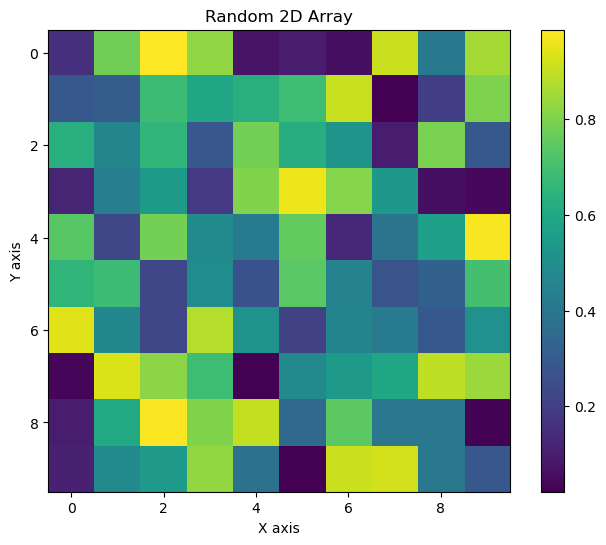

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################


            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################

                        
                        
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board ########################
# decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save


# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "4",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 8 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1,
#                 synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1,
#                 synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 1_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# # dfa code from ASAP
# class feedback_receiver(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input, weight_fb):
#         output = input.clone()
#         dummy = torch.Tensor(input.size()[0],weight_fb.size()[0]).zero_().to(input.device)
#         ctx.save_for_backward(weight_fb,)
#         ctx.shape = input.shape
#         return output, dummy
    
#     @staticmethod
#     def backward(ctx, grad_output, grad_dummy):
#         weight_fb, = ctx.saved_tensors
#         input_size = ctx.shape
#         grad_weight_fb = None
        
#         grad_input = torch.mm(grad_dummy.view(grad_dummy.size()[0],-1), weight_fb).view(input_size) # Batch_size, input
#         return grad_input, grad_weight_fb


# class Feedback_Receiver(nn.Module):
#     def __init__(self, connect_features):
#         super(Feedback_Receiver, self).__init__()
#         self.connect_features = connect_features
#         self.weight_fb = None
    
#     def forward(self, input):
#         if self.weight_fb is None:
#             self.weight_fb = nn.Parameter(torch.Tensor(self.connect_features, *input.size()[1:]).view(self.connect_features, -1)).to(input.device)
#             nn.init.normal_(self.weight_fb, std = math.sqrt(1./self.connect_features))
#         return feedback_receiver.apply(input, self.weight_fb)
   

In [7]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': 'my_snn_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"min": 0.0001, "max": 0.01},
        "BATCH": {"values": [8,16,32,64,96,128]},
        "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [5,6,7,8,9,10]},
        "epoch_num": {"values": [15]},
        "dvs_duration": {"values": [10_000, 100_000, 25_000, 50_000]},
        "dvs_clipping": {"values": [1,2,4]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [True, False]},
        "surrogate": {"values": ['rectangle', 'sigmoid']},
        "cfg": {"values": [['M','M',200,200], ['M','M',200,200,200], ['M','M',200], ['M','M',512]]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    cfg  =  wandb.config.cfg

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "3",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = const2, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = const2, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',200,200], 
                cfg = cfg, 
                # cfg = [200,200],
                # cfg = [512], 
                # cfg = [64,128,'P',128,'P'], 
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = wandb.sweep(sweep=sweep_configuration)
# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')

wandb.agent(sweep_id, project=f'my_snn {unique_name_hyper}', function=hyper_iter, count=10000)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: ntaj4stl
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/ntaj4stl


wandb: Agent Starting Run: 1rg0splz with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009350684833478536
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.009350684833478536'], iter_loss:2.3956949710845947, tr:19.68%, val:15.91%, val_best:15.91%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.44345736503601 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.009248517384281776'], iter_loss:2.04129695892334, tr:27.58%, val:24.62%, val_best:24.62%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]  

epoch_time: 51.55204701423645 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.008946480244475205'], iter_loss:2.1349873542785645, tr:24.61%, val:25.38%, val_best:25.38%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 51.0860321521759 seconds

EPOCH 3



3-67/68 iter:0.00%, lr=['0.008457773886403374'], iter_loss:2.113671064376831, tr:22.75%, val:16.29%, val_best:25.38%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]  

epoch_time: 53.207470417022705 seconds

EPOCH 4



4-67/68 iter:0.00%, lr=['0.007803757122987305'], iter_loss:1.9845900535583496, tr:17.64%, val:24.62%, val_best:25.38%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.53720712661743 seconds

EPOCH 5



5-67/68 iter:0.00%, lr=['0.007013013625108903'], iter_loss:1.65127694606781, tr:22.93%, val:23.11%, val_best:25.38%: 100%|██████████| 68/68 [00:49<00:00,  1.38it/s]   

epoch_time: 49.49959897994995 seconds

EPOCH 6



6-67/68 iter:0.00%, lr=['0.006120102678033741'], iter_loss:1.798888921737671, tr:25.07%, val:28.41%, val_best:28.41%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]  

epoch_time: 51.84234642982483 seconds

EPOCH 7



7-67/68 iter:0.00%, lr=['0.0051640487748111025'], iter_loss:1.8085839748382568, tr:26.18%, val:22.35%, val_best:28.41%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 

epoch_time: 51.276225328445435 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.004186636058667438'], iter_loss:1.885549783706665, tr:25.07%, val:26.89%, val_best:28.41%: 100%|██████████| 68/68 [00:49<00:00,  1.37it/s] 

epoch_time: 49.70916152000427 seconds

EPOCH 9



9-67/68 iter:20.00%, lr=['0.003230582155444798'], iter_loss:1.8328148126602173, tr:24.14%, val:18.56%, val_best:28.41%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 50.98662447929382 seconds

EPOCH 10



10-67/68 iter:20.00%, lr=['0.0023376712083696357'], iter_loss:1.4767645597457886, tr:26.46%, val:26.14%, val_best:28.41%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.642298460006714 seconds

EPOCH 11



11-67/68 iter:40.00%, lr=['0.0015469277104912338'], iter_loss:1.5849180221557617, tr:25.81%, val:32.58%, val_best:32.58%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.52682828903198 seconds

EPOCH 12



12-67/68 iter:40.00%, lr=['0.000892910947075163'], iter_loss:1.6523829698562622, tr:29.06%, val:26.52%, val_best:32.58%: 100%|██████████| 68/68 [00:49<00:00,  1.38it/s]

epoch_time: 49.38048696517944 seconds

EPOCH 13



13-67/68 iter:20.00%, lr=['0.0004042045890033294'], iter_loss:1.7649955749511719, tr:30.73%, val:32.20%, val_best:32.58%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.846896171569824 seconds

EPOCH 14



14-67/68 iter:40.00%, lr=['0.00010216744919676034'], iter_loss:1.6519784927368164, tr:33.33%, val:32.58%, val_best:32.58%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]


epoch_time: 52.35164928436279 seconds



wandb: Agent Starting Run: 2gaa9x3h with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005335748092283446
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:5.66%, lr=['0.005335748092283446'], iter_loss:2.397484302520752, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:10<00:00,  4.13s/it]  

epoch_time: 70.37547421455383 seconds

EPOCH 1



1-16/17 iter:7.55%, lr=['0.00527744864343524'], iter_loss:2.3940911293029785, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:11<00:00,  4.20s/it]

epoch_time: 71.50955605506897 seconds

EPOCH 2



2-16/17 iter:1.89%, lr=['0.00510509826255708'], iter_loss:2.395916223526001, tr:7.61%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:02<00:00,  3.65s/it]  

epoch_time: 62.26820087432861 seconds

EPOCH 3



3-16/17 iter:7.55%, lr=['0.0048262294883222295'], iter_loss:2.401289939880371, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:09<00:00,  4.06s/it]  

epoch_time: 69.27618479728699 seconds

EPOCH 4



4-16/17 iter:7.55%, lr=['0.004453030224325595'], iter_loss:2.403857707977295, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:09<00:00,  4.08s/it]  

epoch_time: 69.47746324539185 seconds

EPOCH 5



5-16/17 iter:9.43%, lr=['0.0040018110692125845'], iter_loss:2.4026787281036377, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:05<00:00,  3.86s/it]

epoch_time: 65.83989095687866 seconds

EPOCH 6



6-16/17 iter:3.77%, lr=['0.0034922924652513684'], iter_loss:2.4024667739868164, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:11<00:00,  4.24s/it] 

epoch_time: 72.1383581161499 seconds

EPOCH 7



7-16/17 iter:3.77%, lr=['0.002946742820376575'], iter_loss:2.3987650871276855, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it] 

epoch_time: 73.71773409843445 seconds

EPOCH 8



8-16/17 iter:3.77%, lr=['0.002389005271906873'], iter_loss:2.3972532749176025, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it] 

epoch_time: 73.5004391670227 seconds

EPOCH 9



9-16/17 iter:5.66%, lr=['0.0018434556270320787'], iter_loss:2.397444009780884, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it] 

epoch_time: 73.70171332359314 seconds

EPOCH 10



10-16/17 iter:7.55%, lr=['0.0013339370230708624'], iter_loss:2.3963630199432373, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:15<00:00,  4.42s/it] 

epoch_time: 75.2766330242157 seconds

EPOCH 11



11-16/17 iter:5.66%, lr=['0.0008827178679578524'], iter_loss:2.3974335193634033, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it] 

epoch_time: 73.77588510513306 seconds

EPOCH 12



12-16/17 iter:13.21%, lr=['0.0005095186039612167'], iter_loss:2.3976261615753174, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:15<00:00,  4.42s/it]

epoch_time: 75.37632846832275 seconds

EPOCH 13



13-16/17 iter:5.66%, lr=['0.00023064982972636512'], iter_loss:2.3974499702453613, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]

epoch_time: 68.757981300354 seconds

EPOCH 14



14-16/17 iter:5.66%, lr=['5.829944884820625e-05'], iter_loss:2.397469997406006, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it] 


epoch_time: 73.33008360862732 seconds



wandb: Agent Starting Run: 10qjefx6 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009409299546130312
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.009409299546130312'], iter_loss:2.3755056858062744, tr:7.61%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.22472071647644 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.009306491660881683'], iter_loss:2.4472732543945312, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.9972984790802 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.009002561203048123'], iter_loss:2.416929006576538, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:48<00:00,  1.40it/s] 

epoch_time: 48.85729932785034 seconds

EPOCH 3



3-67/68 iter:0.00%, lr=['0.008510791392057107'], iter_loss:2.4101526737213135, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s] 

epoch_time: 57.087302923202515 seconds

EPOCH 4



4-67/68 iter:0.00%, lr=['0.007852674928422308'], iter_loss:2.383606195449829, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]  

epoch_time: 56.28151750564575 seconds

EPOCH 5



5-67/68 iter:0.00%, lr=['0.007056974659597734'], iter_loss:2.3984861373901367, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 54.937405586242676 seconds

EPOCH 6



6-67/68 iter:0.00%, lr=['0.006158466505524529'], iter_loss:2.399545431137085, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]  

epoch_time: 56.01684617996216 seconds

EPOCH 7



7-67/68 iter:20.00%, lr=['0.005196419584056171'], iter_loss:2.388650894165039, tr:7.61%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.53752279281616 seconds

EPOCH 8



8-67/68 iter:0.00%, lr=['0.004212879962074141'], iter_loss:2.3919901847839355, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.533868074417114 seconds

EPOCH 9



9-67/68 iter:0.00%, lr=['0.0032508330406057833'], iter_loss:2.3975489139556885, tr:6.59%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.40984082221985 seconds

EPOCH 10



10-67/68 iter:20.00%, lr=['0.002352324886532579'], iter_loss:2.394669532775879, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.543917417526245 seconds

EPOCH 11



11-67/68 iter:0.00%, lr=['0.0015566246177080047'], iter_loss:2.398797035217285, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]  

epoch_time: 56.947439670562744 seconds

EPOCH 12



12-67/68 iter:0.00%, lr=['0.0008985081540732052'], iter_loss:2.3998255729675293, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s] 

epoch_time: 58.974929094314575 seconds

EPOCH 13



13-67/68 iter:0.00%, lr=['0.00040673834308218914'], iter_loss:2.398181200027466, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]  

epoch_time: 55.59913659095764 seconds

EPOCH 14



14-67/68 iter:0.00%, lr=['0.00010280788524863024'], iter_loss:2.398444414138794, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s]  


epoch_time: 55.26829957962036 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1x105iln with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00984850213597008
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-11/12 iter:14.29%, lr=['0.00984850213597008'], iter_loss:2.3979601860046387, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.62499403953552 seconds

EPOCH 1



1-11/12 iter:4.76%, lr=['0.009740895435545486'], iter_loss:2.3986189365386963, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.750492095947266 seconds

EPOCH 2



2-11/12 iter:9.52%, lr=['0.009422778263434498'], iter_loss:2.399135112762451, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.9068808555603 seconds

EPOCH 3



3-11/12 iter:4.76%, lr=['0.008908053866553921'], iter_loss:2.3996458053588867, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.52490496635437 seconds

EPOCH 4



4-11/12 iter:14.29%, lr=['0.008219218170969125'], iter_loss:2.3988046646118164, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:55<00:00,  4.58s/it]

epoch_time: 55.214091300964355 seconds

EPOCH 5



5-11/12 iter:9.52%, lr=['0.00738637660197756'], iter_loss:2.3992161750793457, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.222262144088745 seconds

EPOCH 6



6-11/12 iter:9.52%, lr=['0.006445928332561402'], iter_loss:2.3990871906280518, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.16326141357422 seconds

EPOCH 7



7-11/12 iter:9.52%, lr=['0.005438975464865618'], iter_loss:2.398977041244507, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]  

epoch_time: 58.04028034210205 seconds

EPOCH 8



8-11/12 iter:4.76%, lr=['0.004409526671104463'], iter_loss:2.398681640625, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]    

epoch_time: 57.40557289123535 seconds

EPOCH 9



9-11/12 iter:4.76%, lr=['0.0034025738034086784'], iter_loss:2.398550510406494, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]  

epoch_time: 58.91310787200928 seconds

EPOCH 10



10-11/12 iter:4.76%, lr=['0.002462125533992521'], iter_loss:2.3981997966766357, tr:9.38%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:51<00:00,  4.28s/it] 

epoch_time: 51.52591109275818 seconds

EPOCH 11



11-11/12 iter:9.52%, lr=['0.0016292839650009566'], iter_loss:2.398244857788086, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]

epoch_time: 53.295807123184204 seconds

EPOCH 12



12-11/12 iter:19.05%, lr=['0.0009404482694161584'], iter_loss:2.398237705230713, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it] 

epoch_time: 57.465031147003174 seconds

EPOCH 13



13-11/12 iter:19.05%, lr=['0.00042572387253558'], iter_loss:2.3981873989105225, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.71855807304382 seconds

EPOCH 14



14-11/12 iter:4.76%, lr=['0.00010760670042459285'], iter_loss:2.3981740474700928, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it] 


epoch_time: 57.494935274124146 seconds



wandb: Agent Starting Run: 0l30c7py with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008228679784015822
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.008228679784015822'], iter_loss:2.396594524383545, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.10597801208496 seconds

EPOCH 1



1-16/17 iter:5.66%, lr=['0.008138771585978834'], iter_loss:2.3998756408691406, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.213764905929565 seconds

EPOCH 2



2-16/17 iter:7.55%, lr=['0.007872976411549487'], iter_loss:2.3963193893432617, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it] 

epoch_time: 57.346171379089355 seconds

EPOCH 3



3-16/17 iter:11.32%, lr=['0.007442910785277098'], iter_loss:2.398404836654663, tr:6.87%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it] 

epoch_time: 58.09524130821228 seconds

EPOCH 4



4-16/17 iter:5.66%, lr=['0.006867370638713605'], iter_loss:2.3982925415039062, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.977959632873535 seconds

EPOCH 5



5-16/17 iter:3.77%, lr=['0.006171509838011868'], iter_loss:2.4005701541900635, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it] 

epoch_time: 57.499847173690796 seconds

EPOCH 6



6-16/17 iter:7.55%, lr=['0.005385740839273143'], iter_loss:2.396583080291748, tr:7.24%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]  

epoch_time: 58.46079874038696 seconds

EPOCH 7



7-16/17 iter:13.21%, lr=['0.004544405518280303'], iter_loss:2.3990042209625244, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.86256241798401 seconds

EPOCH 8



8-16/17 iter:5.66%, lr=['0.0036842742657355225'], iter_loss:2.3978168964385986, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 

epoch_time: 54.318190813064575 seconds

EPOCH 9



9-16/17 iter:9.43%, lr=['0.002842938944742682'], iter_loss:2.3997745513916016, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.445518016815186 seconds

EPOCH 10



10-16/17 iter:7.55%, lr=['0.0020571699460039568'], iter_loss:2.399775505065918, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]  

epoch_time: 53.202370166778564 seconds

EPOCH 11



11-16/17 iter:9.43%, lr=['0.0013613091453022197'], iter_loss:2.3987433910369873, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.45811915397644 seconds

EPOCH 12



12-16/17 iter:5.66%, lr=['0.0007857689987387255'], iter_loss:2.398820161819458, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]  

epoch_time: 56.66301107406616 seconds

EPOCH 13



13-16/17 iter:3.77%, lr=['0.0003557033724663345'], iter_loss:2.398685932159424, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it] 

epoch_time: 56.99942755699158 seconds

EPOCH 14



14-16/17 iter:7.55%, lr=['8.990819803698767e-05'], iter_loss:2.3986735343933105, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 


epoch_time: 57.06990933418274 seconds



wandb: Agent Starting Run: 7ybjrmid with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008027380319203614
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:0.00%, lr=['0.008027380319203614'], iter_loss:2.3962390422821045, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it] 

epoch_time: 49.42982506752014 seconds

EPOCH 1



1-16/17 iter:9.43%, lr=['0.0079396715593052'], iter_loss:2.4007973670959473, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.283074378967285 seconds

EPOCH 2



2-16/17 iter:11.32%, lr=['0.007680378573290843'], iter_loss:2.4006309509277344, tr:8.73%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.39881706237793 seconds

EPOCH 3



3-16/17 iter:9.43%, lr=['0.007260833708875164'], iter_loss:2.396158456802368, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:12<00:00,  4.25s/it] 

epoch_time: 72.46966052055359 seconds

EPOCH 4



4-16/17 iter:3.77%, lr=['0.006699373089832746'], iter_loss:2.403937578201294, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:15<00:00,  4.46s/it]  

epoch_time: 76.05867147445679 seconds

EPOCH 5



5-16/17 iter:11.32%, lr=['0.00602053523940271'], iter_loss:2.3977584838867188, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:09<00:00,  4.06s/it]

epoch_time: 69.23185420036316 seconds

EPOCH 6



6-16/17 iter:11.32%, lr=['0.00525398862907426'], iter_loss:2.4025254249572754, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:17<00:00,  4.55s/it]

epoch_time: 77.53476428985596 seconds

EPOCH 7



7-16/17 iter:11.32%, lr=['0.0044332350240174866'], iter_loss:2.4013609886169434, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:14<00:00,  4.38s/it]

epoch_time: 74.69875192642212 seconds

EPOCH 8



8-16/17 iter:3.77%, lr=['0.0035941452951861277'], iter_loss:2.39605450630188, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:18<00:00,  4.64s/it]   

epoch_time: 79.0708920955658 seconds

EPOCH 9



9-16/17 iter:7.55%, lr=['0.002773391690129354'], iter_loss:2.396167755126953, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:04<00:00,  3.82s/it] 

epoch_time: 65.09034895896912 seconds

EPOCH 10



10-16/17 iter:5.66%, lr=['0.0020068450798009043'], iter_loss:2.397078275680542, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:16<00:00,  4.50s/it]  

epoch_time: 76.68979072570801 seconds

EPOCH 11



11-16/17 iter:0.00%, lr=['0.0013280072293708686'], iter_loss:2.398078680038452, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:17<00:00,  4.53s/it]  

epoch_time: 77.2902135848999 seconds

EPOCH 12



12-16/17 iter:9.43%, lr=['0.0007665466103284503'], iter_loss:2.397902488708496, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:11<00:00,  4.20s/it]  

epoch_time: 71.66593146324158 seconds

EPOCH 13



13-16/17 iter:11.32%, lr=['0.00034700174591277'], iter_loss:2.3979568481445312, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:17<00:00,  4.57s/it]

epoch_time: 77.86546421051025 seconds

EPOCH 14



14-16/17 iter:9.43%, lr=['8.770875989841385e-05'], iter_loss:2.3979287147521973, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [01:11<00:00,  4.20s/it] 


epoch_time: 71.6472692489624 seconds



wandb: Agent Starting Run: f4abh2wm with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0054577098574280425
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:0.00%, lr=['0.0054577098574280425'], iter_loss:2.3971269130706787, tr:7.15%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:09<00:00,  7.69s/it] 

epoch_time: 69.45244932174683 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.005398077829986261'], iter_loss:2.3979413509368896, tr:7.24%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:15<00:00,  8.43s/it]

epoch_time: 76.10773754119873 seconds

EPOCH 2



2-8/9 iter:5.66%, lr=['0.0052217879534063386'], iter_loss:2.3975164890289307, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:14<00:00,  8.22s/it] 

epoch_time: 74.20208787918091 seconds

EPOCH 3



3-8/9 iter:3.77%, lr=['0.004936544941227501'], iter_loss:2.397608757019043, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:12<00:00,  8.09s/it]  

epoch_time: 72.97337222099304 seconds

EPOCH 4



4-8/9 iter:5.66%, lr=['0.004554815281829793'], iter_loss:2.4006543159484863, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:17<00:00,  8.60s/it] 

epoch_time: 77.63152885437012 seconds

EPOCH 5



5-8/9 iter:5.66%, lr=['0.0040932823930710325'], iter_loss:2.3996801376342773, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:06<00:00,  7.42s/it] 

epoch_time: 67.0878734588623 seconds

EPOCH 6



6-8/9 iter:11.32%, lr=['0.0035721174768704902'], iter_loss:2.401564836502075, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:18<00:00,  8.67s/it] 

epoch_time: 78.24729108810425 seconds

EPOCH 7



7-8/9 iter:11.32%, lr=['0.003014097940892861'], iter_loss:2.402482748031616, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:12<00:00,  8.01s/it]

epoch_time: 72.28097915649414 seconds

EPOCH 8



8-8/9 iter:13.21%, lr=['0.0024436119165351837'], iter_loss:2.4005608558654785, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:16<00:00,  8.45s/it]

epoch_time: 76.2638909816742 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.0018855923805575537'], iter_loss:2.3999125957489014, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it] 

epoch_time: 53.39118409156799 seconds

EPOCH 10



10-8/9 iter:5.66%, lr=['0.0013644274643570115'], iter_loss:2.3999383449554443, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it] 

epoch_time: 53.53078842163086 seconds

EPOCH 11



11-8/9 iter:0.00%, lr=['0.0009028945755982504'], iter_loss:2.400078296661377, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]  

epoch_time: 53.90174674987793 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.0005211649162005426'], iter_loss:2.3999688625335693, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it] 

epoch_time: 51.993226051330566 seconds

EPOCH 13



13-8/9 iter:11.32%, lr=['0.00023592190402170344'], iter_loss:2.3999314308166504, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.70284414291382 seconds

EPOCH 14



14-8/9 iter:9.43%, lr=['5.963202744178101e-05'], iter_loss:2.399901866912842, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it]  


epoch_time: 50.4831109046936 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: terxngpg with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003722479366574964
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:32.08%, lr=['0.003722479366574964'], iter_loss:2.2466514110565186, tr:19.22%, val:26.52%, val_best:26.52%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

epoch_time: 52.75464224815369 seconds

EPOCH 1



1-8/9 iter:52.83%, lr=['0.0036818068138856808'], iter_loss:1.7267087697982788, tr:44.57%, val:40.91%, val_best:40.91%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.653287410736084 seconds

EPOCH 2



2-8/9 iter:39.62%, lr=['0.003561566741538914'], iter_loss:1.642583966255188, tr:55.52%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it]

epoch_time: 56.23084855079651 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.0033670142176720997'], iter_loss:1.6352312564849854, tr:60.26%, val:43.94%, val_best:44.32%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]

epoch_time: 56.946598052978516 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.003106652121144804'], iter_loss:1.5048856735229492, tr:67.87%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:56<00:00,  6.30s/it]

epoch_time: 56.84985709190369 seconds

EPOCH 5



5-8/9 iter:66.04%, lr=['0.002791859524931223'], iter_loss:1.3985415697097778, tr:73.91%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.54572820663452 seconds

EPOCH 6



6-8/9 iter:84.91%, lr=['0.0024363943760283588'], iter_loss:1.2871143817901611, tr:76.51%, val:53.41%, val_best:57.20%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.501108169555664 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0020557922071542966'], iter_loss:1.384705901145935, tr:78.83%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it] 

epoch_time: 57.01127600669861 seconds

EPOCH 8



8-8/9 iter:77.36%, lr=['0.0016666871594206679'], iter_loss:1.4242713451385498, tr:82.17%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.716888189315796 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.0012860849905466055'], iter_loss:1.303085207939148, tr:83.75%, val:56.82%, val_best:58.71%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it]

epoch_time: 49.96964406967163 seconds

EPOCH 10



10-8/9 iter:90.57%, lr=['0.0009306198416437414'], iter_loss:1.1138496398925781, tr:85.89%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:56<00:00,  6.31s/it]

epoch_time: 56.93651795387268 seconds

EPOCH 11



11-8/9 iter:84.91%, lr=['0.0006158272454301605'], iter_loss:1.244545578956604, tr:86.82%, val:58.71%, val_best:59.47%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it] 

epoch_time: 57.877145528793335 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.00035546514890286434'], iter_loss:1.2204116582870483, tr:87.09%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]

epoch_time: 55.919633865356445 seconds

EPOCH 13



13-8/9 iter:90.57%, lr=['0.00016091262503604954'], iter_loss:1.2408053874969482, tr:87.56%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.33838415145874 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['4.0672552689283106e-05'], iter_loss:1.244835615158081, tr:87.47%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it] 


epoch_time: 54.39904165267944 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sz9a63wf with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00405594013456835
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.00405594013456835'], iter_loss:2.380671501159668, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]  

epoch_time: 55.01004958152771 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.004011624122958165'], iter_loss:2.4321091175079346, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.717745304107666 seconds

EPOCH 2



2-67/68 iter:0.00%, lr=['0.0038806129104867917'], iter_loss:2.407562017440796, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:47<00:00,  1.45it/s]  

epoch_time: 47.269665002822876 seconds

EPOCH 3



3-67/68 iter:0.00%, lr=['0.0036686323158007777'], iter_loss:2.4074509143829346, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 55.10526132583618 seconds

EPOCH 4



4-67/68 iter:0.00%, lr=['0.003384946908083649'], iter_loss:2.3900599479675293, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.25119590759277 seconds

EPOCH 5



5-67/68 iter:0.00%, lr=['0.003041955100926262'], iter_loss:2.398858070373535, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]  

epoch_time: 52.60094928741455 seconds

EPOCH 6



6-67/68 iter:0.00%, lr=['0.0026546472821586905'], iter_loss:2.400343656539917, tr:6.87%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]  

epoch_time: 53.29540705680847 seconds

EPOCH 7



7-67/68 iter:20.00%, lr=['0.0022399506619701897'], iter_loss:2.389983654022217, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.52568006515503 seconds

EPOCH 8



8-67/68 iter:20.00%, lr=['0.0018159894725981608'], iter_loss:2.3918299674987793, tr:9.19%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s]

epoch_time: 55.18797945976257 seconds

EPOCH 9



9-67/68 iter:40.00%, lr=['0.0014012928524096595'], iter_loss:2.39638090133667, tr:6.59%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]  

epoch_time: 54.184975385665894 seconds

EPOCH 10



10-67/68 iter:0.00%, lr=['0.0010139850336420878'], iter_loss:2.39400315284729, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]   

epoch_time: 54.835309743881226 seconds

EPOCH 11



11-67/68 iter:0.00%, lr=['0.000670993226484701'], iter_loss:2.3974740505218506, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 54.07119083404541 seconds

EPOCH 12



12-67/68 iter:0.00%, lr=['0.00038730781876757195'], iter_loss:2.398484468460083, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]  

epoch_time: 53.80103373527527 seconds

EPOCH 13



13-67/68 iter:0.00%, lr=['0.00017532722408155704'], iter_loss:2.3974242210388184, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.1721613407135 seconds

EPOCH 14



14-67/68 iter:0.00%, lr=['4.431601161018474e-05'], iter_loss:2.3976337909698486, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 


epoch_time: 53.504733085632324 seconds



wandb: Agent Starting Run: 12f2qo0a with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005970805965896474
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:0.00%, lr=['0.005970805965896474'], iter_loss:2.3974392414093018, tr:7.15%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.66s/it] 

epoch_time: 51.07788944244385 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.0059055677479426015'], iter_loss:2.3977954387664795, tr:7.24%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.861101388931274 seconds

EPOCH 2



2-8/9 iter:5.66%, lr=['0.0057127043172532695'], iter_loss:2.3975136280059814, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it] 

epoch_time: 52.791709184646606 seconds

EPOCH 3



3-8/9 iter:3.77%, lr=['0.005400644731211022'], iter_loss:2.397522211074829, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]  

epoch_time: 53.89399337768555 seconds

EPOCH 4



4-8/9 iter:5.66%, lr=['0.0049830274911539345'], iter_loss:2.399211883544922, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]  

epoch_time: 53.79375886917114 seconds

EPOCH 5



5-8/9 iter:5.66%, lr=['0.004478104474422355'], iter_loss:2.398817777633667, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.55s/it]  

epoch_time: 50.10828399658203 seconds

EPOCH 6



6-8/9 iter:11.32%, lr=['0.003907943239736904'], iter_loss:2.3999993801116943, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.11342215538025 seconds

EPOCH 7



7-8/9 iter:11.32%, lr=['0.003297462568990485'], iter_loss:2.4006974697113037, tr:9.38%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.17065382003784 seconds

EPOCH 8



8-8/9 iter:13.21%, lr=['0.0026733433969059897'], iter_loss:2.3998115062713623, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.734824419021606 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.002062862726159571'], iter_loss:2.399545431137085, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:47<00:00,  5.28s/it]  

epoch_time: 47.70247030258179 seconds

EPOCH 10



10-8/9 iter:5.66%, lr=['0.0014927014914741191'], iter_loss:2.399596929550171, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]  

epoch_time: 54.09074568748474 seconds

EPOCH 11



11-8/9 iter:0.00%, lr=['0.00098777847474254'], iter_loss:2.399693727493286, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:55<00:00,  6.13s/it]  

epoch_time: 55.355143547058105 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.000570161234685452'], iter_loss:2.3996434211730957, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it] 

epoch_time: 52.6982307434082 seconds

EPOCH 13



13-8/9 iter:11.32%, lr=['0.0002581016486432037'], iter_loss:2.399627208709717, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it] 

epoch_time: 54.599493980407715 seconds

EPOCH 14



14-8/9 iter:9.43%, lr=['6.523821795387236e-05'], iter_loss:2.3996119499206543, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it] 


epoch_time: 51.78365874290466 seconds



wandb: Agent Starting Run: op1jjob9 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004236604763238605
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:19.05%, lr=['0.004236604763238605'], iter_loss:1.73270583152771, tr:29.62%, val:34.47%, val_best:34.47%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.4784517288208 seconds

EPOCH 1



1-33/34 iter:33.33%, lr=['0.004190314773828929'], iter_loss:1.0112849473953247, tr:43.08%, val:40.91%, val_best:40.91%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.965240240097046 seconds

EPOCH 2



2-33/34 iter:38.10%, lr=['0.004053467900261119'], iter_loss:1.280059576034546, tr:55.25%, val:42.05%, val_best:42.05%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 

epoch_time: 51.493905544281006 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0038320450075742434'], iter_loss:1.1004952192306519, tr:55.34%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.73395609855652 seconds

EPOCH 4



4-33/34 iter:61.90%, lr=['0.00353572333868364'], iter_loss:0.9665561318397522, tr:60.26%, val:42.05%, val_best:50.76%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.30828356742859 seconds

EPOCH 5



5-33/34 iter:57.14%, lr=['0.003177453572428954'], iter_loss:0.9582513570785522, tr:61.56%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.08331489562988 seconds

EPOCH 6



6-33/34 iter:71.43%, lr=['0.0027728938167645924'], iter_loss:0.7379186749458313, tr:61.93%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.42132759094238 seconds

EPOCH 7



7-33/34 iter:71.43%, lr=['0.002339725274306179'], iter_loss:1.1015738248825073, tr:68.90%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.09289574623108 seconds

EPOCH 8



8-33/34 iter:61.90%, lr=['0.0018968794889324269'], iter_loss:0.8803534507751465, tr:72.61%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.57513666152954 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.001463710946474013'], iter_loss:0.9642679691314697, tr:77.44%, val:62.12%, val_best:64.77%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.25251364707947 seconds

EPOCH 10



10-33/34 iter:71.43%, lr=['0.0010591511908096519'], iter_loss:0.9657887816429138, tr:82.08%, val:61.36%, val_best:64.77%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.86650228500366 seconds

EPOCH 11



11-33/34 iter:80.95%, lr=['0.0007008814245549658'], iter_loss:0.9008943438529968, tr:83.47%, val:63.26%, val_best:64.77%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.24363708496094 seconds

EPOCH 12



12-33/34 iter:80.95%, lr=['0.0004045597556643617'], iter_loss:0.8447220921516418, tr:85.42%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.7846143245697 seconds

EPOCH 13



13-33/34 iter:85.71%, lr=['0.0001831368629774852'], iter_loss:0.8548101186752319, tr:87.65%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.504900217056274 seconds

EPOCH 14



14-33/34 iter:85.71%, lr=['4.6289989409675314e-05'], iter_loss:0.9362818002700806, tr:88.95%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]


epoch_time: 54.66300868988037 seconds



wandb: Agent Starting Run: bfl6394w with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0014909207702363066
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.0014909207702363066'], iter_loss:1.571451187133789, tr:32.22%, val:40.53%, val_best:40.53%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.4852614402771 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0014746306722635738'], iter_loss:0.8918262720108032, tr:52.55%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.784358501434326 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.0014264723337953462'], iter_loss:0.7043851613998413, tr:64.72%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.23982048034668 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0013485505053120327'], iter_loss:1.069977045059204, tr:69.73%, val:55.68%, val_best:59.85%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.13613700866699 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0012442707446287714'], iter_loss:0.7117245197296143, tr:74.84%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.01421236991882 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.00111819057767723'], iter_loss:0.8586500883102417, tr:83.38%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.20706367492676 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.000975820312752956'], iter_loss:0.8584114909172058, tr:88.39%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.73761010169983 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0008233822136014672'], iter_loss:0.7538562417030334, tr:91.36%, val:64.02%, val_best:67.05%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.98613929748535 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.00066753855663484'], iter_loss:0.5617712736129761, tr:94.80%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.849365234375 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.000515100457483351'], iter_loss:0.4814097285270691, tr:94.99%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:45<00:00,  1.32s/it]

epoch_time: 45.22050333023071 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0003727301925590769'], iter_loss:0.7073229551315308, tr:97.21%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.1886260509491 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0002466500256075357'], iter_loss:0.6446462869644165, tr:98.14%, val:72.73%, val_best:72.73%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.31898808479309 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0001423702649242742'], iter_loss:0.6888615489006042, tr:98.61%, val:70.45%, val_best:72.73%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.7329478263855 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['6.444843644096037e-05'], iter_loss:0.6519865393638611, tr:98.61%, val:71.21%, val_best:72.73%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.00708532333374 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['1.6290097972732864e-05'], iter_loss:0.6607853770256042, tr:98.70%, val:71.59%, val_best:72.73%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 


epoch_time: 52.714815855026245 seconds



wandb: Agent Starting Run: b90iqax8 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0038626259634324056
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.0038626259634324056'], iter_loss:1.7095410823822021, tr:30.18%, val:39.39%, val_best:39.39%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.6611590385437 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.003820422141047959'], iter_loss:1.37714684009552, tr:55.15%, val:44.70%, val_best:44.70%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]  

epoch_time: 57.25514602661133 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.003695655183449227'], iter_loss:1.4410512447357178, tr:68.43%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.81711483001709 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.003493778005381563'], iter_loss:1.5371280908584595, tr:77.90%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.0608344078064 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0032236136082407'], iter_loss:1.2218337059020996, tr:86.44%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.242448568344116 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0028969694725743044'], iter_loss:1.3895083665847778, tr:90.06%, val:57.58%, val_best:61.74%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it] 

epoch_time: 56.143611669540405 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.002528121514523462'], iter_loss:1.1817375421524048, tr:95.26%, val:60.23%, val_best:61.74%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.7926025390625 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0021331901597838676'], iter_loss:1.4204769134521484, tr:98.05%, val:60.23%, val_best:61.74%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.55293083190918 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.001729435803648539'], iter_loss:1.4024596214294434, tr:98.42%, val:60.61%, val_best:61.74%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it] 

epoch_time: 56.10197639465332 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0013345044489089446'], iter_loss:1.2592520713806152, tr:99.35%, val:60.98%, val_best:61.74%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.201719522476196 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009656564908581021'], iter_loss:1.3316569328308105, tr:99.72%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.24785494804382 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006390123551917062'], iter_loss:1.2149845361709595, tr:99.54%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.00665640830994 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00036884795805084276'], iter_loss:1.369636058807373, tr:99.54%, val:62.12%, val_best:62.50%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.84998416900635 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00016697077998317807'], iter_loss:1.3441040515899658, tr:99.63%, val:62.12%, val_best:62.50%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.55936336517334 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['4.2203822384446704e-05'], iter_loss:1.3612473011016846, tr:99.81%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 


epoch_time: 56.614145040512085 seconds



wandb: Agent Starting Run: sc4in83w with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006293939259898615
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.006293939259898615'], iter_loss:1.748414397239685, tr:33.61%, val:30.68%, val_best:30.68%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.69308137893677 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.006225170423066375'], iter_loss:1.0473501682281494, tr:43.64%, val:42.42%, val_best:42.42%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.60091543197632 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.006021869440728713'], iter_loss:1.204712986946106, tr:48.65%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.86349821090698 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0056929215413601365'], iter_loss:1.3549268245697021, tr:51.53%, val:48.48%, val_best:50.76%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.43449664115906 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.005252703326630199'], iter_loss:1.3230533599853516, tr:53.48%, val:43.56%, val_best:50.76%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.10234808921814 seconds

EPOCH 5



5-33/34 iter:66.67%, lr=['0.004720454444923961'], iter_loss:1.0877915620803833, tr:58.87%, val:45.08%, val_best:50.76%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.88440227508545 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['0.004119436726385484'], iter_loss:1.1722954511642456, tr:62.12%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.30702543258667 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.0034759175293178853'], iter_loss:1.1187759637832642, tr:69.64%, val:45.45%, val_best:56.06%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.04704928398132 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.0028180217305807313'], iter_loss:0.8017146587371826, tr:73.26%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.526387214660645 seconds

EPOCH 9



9-33/34 iter:76.19%, lr=['0.0021745025335131326'], iter_loss:1.016188144683838, tr:75.30%, val:55.68%, val_best:59.85%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it] 

epoch_time: 44.58625054359436 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0015734848149746546'], iter_loss:0.8693868517875671, tr:84.40%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.272562742233276 seconds

EPOCH 11



11-33/34 iter:80.95%, lr=['0.0010412359332684167'], iter_loss:0.7058286666870117, tr:89.04%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.970810890197754 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0006010177185384784'], iter_loss:0.6255202293395996, tr:90.44%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.432213306427 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.0002720698191699007'], iter_loss:0.668077826499939, tr:91.46%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]  

epoch_time: 53.654040575027466 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['6.876883683224002e-05'], iter_loss:0.7150533199310303, tr:92.85%, val:64.77%, val_best:65.91%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 


epoch_time: 51.399624824523926 seconds



wandb: Agent Starting Run: mjcdae5j with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023658068007915414
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0023658068007915414'], iter_loss:1.6376806497573853, tr:31.66%, val:36.74%, val_best:36.74%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.55613946914673 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.002339957523392754'], iter_loss:1.4588457345962524, tr:53.67%, val:44.32%, val_best:44.32%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.10232734680176 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.002263539428657314'], iter_loss:1.3224010467529297, tr:66.48%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.95409345626831 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0021398923540198625'], iter_loss:1.6106846332550049, tr:75.12%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.29721999168396 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0019744202699665484'], iter_loss:1.4105713367462158, tr:82.08%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.04374647140503 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0017743551005936565'], iter_loss:1.3473669290542603, tr:83.75%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.309868574142456 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0015484406538219771'], iter_loss:1.141186237335205, tr:89.79%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.80628252029419 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.001306550475033223'], iter_loss:1.490635871887207, tr:94.15%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 55.061524868011475 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0010592563257583196'], iter_loss:1.7125604152679443, tr:96.01%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it] 

epoch_time: 55.12208700180054 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.000817366146969565'], iter_loss:1.7840113639831543, tr:96.29%, val:61.74%, val_best:62.88%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.81663656234741 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0005914517001978858'], iter_loss:1.461036205291748, tr:97.86%, val:61.36%, val_best:62.88%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]  

epoch_time: 56.12761449813843 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00039138653082499385'], iter_loss:1.6180436611175537, tr:98.51%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.152769804000854 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0002259144467716794'], iter_loss:1.7972733974456787, tr:98.42%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.992284536361694 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.0001022673721342275'], iter_loss:1.6238818168640137, tr:98.70%, val:62.88%, val_best:64.77%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 56.03681254386902 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['2.58492773987873e-05'], iter_loss:1.7074068784713745, tr:98.79%, val:64.02%, val_best:64.77%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 


epoch_time: 56.95737290382385 seconds



wandb: Agent Starting Run: 9qnfj4j8 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004950776672685879
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.004950776672685879'], iter_loss:1.3946391344070435, tr:31.85%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.26147651672363 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.004896683498421232'], iter_loss:0.8514401912689209, tr:49.03%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.439736127853394 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.004736768106910505'], iter_loss:0.6251602172851562, tr:62.21%, val:53.41%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.082229137420654 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.004478019568121905'], iter_loss:0.973512589931488, tr:71.87%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.553847789764404 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.004131746434813735'], iter_loss:0.9515378475189209, tr:75.49%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.40230679512024 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.0037130825045144085'], iter_loss:0.7140912413597107, tr:85.42%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.97468829154968 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.0032403253999504357'], iter_loss:1.0873072147369385, tr:92.01%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.18723821640015 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.00273413687513154'], iter_loss:0.6035921573638916, tr:92.94%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.351951122283936 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.002216639797554339'], iter_loss:0.8717876076698303, tr:95.45%, val:67.05%, val_best:67.80%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it] 

epoch_time: 56.567583322525024 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.001710451272735443'], iter_loss:0.7647557854652405, tr:97.96%, val:66.67%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 47.03074884414673 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0012376941681714701'], iter_loss:0.9519562721252441, tr:98.24%, val:65.53%, val_best:67.80%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.24940013885498 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0008190302378721437'], iter_loss:0.8291019201278687, tr:98.79%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it] 

epoch_time: 56.8714804649353 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.00047275710456397323'], iter_loss:0.8327391743659973, tr:99.35%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:56<00:00,  3.29s/it]

epoch_time: 56.17574596405029 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00021400856577537212'], iter_loss:0.7434053421020508, tr:99.26%, val:67.80%, val_best:70.83%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.25343346595764 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.4093174264646406e-05'], iter_loss:0.7724202275276184, tr:99.35%, val:67.80%, val_best:70.83%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]


epoch_time: 52.77281928062439 seconds



wandb: Agent Starting Run: z3dkjc7d with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007876756937835693
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.007876756937835693'], iter_loss:2.1744027137756348, tr:32.50%, val:39.77%, val_best:39.77%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.488022804260254 seconds

EPOCH 1



1-33/34 iter:33.33%, lr=['0.007790693919071517'], iter_loss:1.5343730449676514, tr:49.49%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.10061478614807 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.007536266229675166'], iter_loss:1.53812837600708, tr:61.75%, val:44.32%, val_best:48.11%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]  

epoch_time: 53.368937969207764 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.00712459358055277'], iter_loss:1.5449035167694092, tr:70.10%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.0252890586853 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.006573668041895517'], iter_loss:1.2959363460540771, tr:76.88%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.40551543235779 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.00590756770337677'], iter_loss:1.391821026802063, tr:78.74%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.549931049346924 seconds

EPOCH 6



6-33/34 iter:80.95%, lr=['0.005155404346093847'], iter_loss:1.0214531421661377, tr:83.19%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.756783962249756 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.004350051118040243'], iter_loss:1.2651019096374512, tr:93.22%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.64572787284851 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.003526705819795451'], iter_loss:1.180134892463684, tr:95.36%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]  

epoch_time: 58.746771812438965 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0027213525917418467'], iter_loss:1.3039500713348389, tr:97.40%, val:60.98%, val_best:63.26%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.840813875198364 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.001969189234458924'], iter_loss:1.5720990896224976, tr:98.70%, val:62.50%, val_best:63.26%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.52530550956726 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0013030888959401775'], iter_loss:1.3282688856124878, tr:99.44%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.67420816421509 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007521633572829233'], iter_loss:1.587486743927002, tr:99.81%, val:61.36%, val_best:64.02%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.352123737335205 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003404907081605263'], iter_loss:1.4247517585754395, tr:99.91%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.7340350151062 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.606301876417583e-05'], iter_loss:1.525930643081665, tr:99.91%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 


epoch_time: 59.031923055648804 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1u7g2co4 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029800521270175015
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0029800521270175015'], iter_loss:1.5654449462890625, tr:32.03%, val:30.68%, val_best:30.68%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.3137993812561 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0029474914825606724'], iter_loss:0.9321409463882446, tr:48.10%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.35566520690918 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.0028512326055962554'], iter_loss:1.0365543365478516, tr:54.22%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.07201957702637 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.002695482470948935'], iter_loss:0.9376904964447021, tr:58.96%, val:53.79%, val_best:54.17%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.210052251815796 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.002487048106874864'], iter_loss:0.9154560565948486, tr:65.27%, val:51.14%, val_best:54.17%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.78062200546265 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0022350390952631262'], iter_loss:0.9307109713554382, tr:69.82%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.773645639419556 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0019504694391945597'], iter_loss:0.9691126346588135, tr:77.72%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.690704584121704 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.001645776198156072'], iter_loss:0.9380813241004944, tr:80.78%, val:58.71%, val_best:61.74%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.84227728843689 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0013342759288614305'], iter_loss:0.5443929433822632, tr:87.65%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.34931254386902 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0010295826878229425'], iter_loss:0.6743514537811279, tr:87.65%, val:63.26%, val_best:63.64%: 100%|██████████| 34/34 [00:45<00:00,  1.32s/it]

epoch_time: 45.18862557411194 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0007450130317543759'], iter_loss:0.6850945353507996, tr:93.50%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.29261136054993 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.0004930040201426383'], iter_loss:0.5812771916389465, tr:95.36%, val:71.97%, val_best:71.97%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.14751386642456 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00028456965606856686'], iter_loss:0.6703414916992188, tr:95.54%, val:71.21%, val_best:71.97%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.648781538009644 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00012881952142124585'], iter_loss:0.6288460493087769, tr:97.12%, val:72.73%, val_best:72.73%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.911919355392456 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['3.2560644456829034e-05'], iter_loss:0.7981529235839844, tr:97.40%, val:72.35%, val_best:72.73%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 


epoch_time: 52.32946038246155 seconds



wandb: Agent Starting Run: qbjqtmc8 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004797763863510093
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.004797763863510093'], iter_loss:2.0600006580352783, tr:23.77%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.591134786605835 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.004745342537744923'], iter_loss:1.5964384078979492, tr:48.84%, val:46.21%, val_best:46.21%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.948065519332886 seconds

EPOCH 2



2-8/9 iter:54.72%, lr=['0.004590369623930777'], iter_loss:1.434746503829956, tr:55.06%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 54.024198055267334 seconds

EPOCH 3



3-8/9 iter:58.49%, lr=['0.0043396181820438825'], iter_loss:1.6382309198379517, tr:65.83%, val:49.62%, val_best:53.03%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 55.024832248687744 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.00400404725333361'], iter_loss:1.7194538116455078, tr:70.10%, val:50.00%, val_best:53.03%: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]

epoch_time: 56.00194597244263 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.00359832289763257'], iter_loss:1.4503711462020874, tr:77.16%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it]

epoch_time: 50.43638849258423 seconds

EPOCH 6



6-8/9 iter:92.45%, lr=['0.003140177216166359'], iter_loss:1.3624823093414307, tr:81.24%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it]

epoch_time: 56.42518663406372 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.0026496333736419422'], iter_loss:1.5837326049804688, tr:83.66%, val:57.20%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.976113080978394 seconds

EPOCH 8



8-8/9 iter:92.45%, lr=['0.0021481304898681524'], iter_loss:1.5426076650619507, tr:87.84%, val:58.33%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.93569779396057 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.001657586647343735'], iter_loss:1.5752816200256348, tr:89.88%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:48<00:00,  5.38s/it]

epoch_time: 48.66448903083801 seconds

EPOCH 10



10-8/9 iter:92.45%, lr=['0.001199440965877524'], iter_loss:1.56000816822052, tr:91.92%, val:59.85%, val_best:62.50%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]  

epoch_time: 53.90907669067383 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.000793716610176484'], iter_loss:1.663999319076538, tr:92.94%, val:60.98%, val_best:62.50%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it] 

epoch_time: 56.42821478843689 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0004581456814662113'], iter_loss:1.6483758687973022, tr:94.06%, val:60.61%, val_best:62.50%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.505077838897705 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0002073942395793159'], iter_loss:1.647120714187622, tr:93.87%, val:60.23%, val_best:62.50%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.043981075286865 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['5.2421325765170785e-05'], iter_loss:1.610822319984436, tr:94.06%, val:60.23%, val_best:62.50%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it] 


epoch_time: 51.0207085609436 seconds



wandb: Agent Starting Run: 10hwyrxl with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0007661778739404489
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
error: short read while indexing my_snn/result_save/iter_acc_array_main.npy
error: my_snn/result_save/iter_acc_array_main.npy: failed to insert into database
fatal: cannot hash my_snn/result_save/iter_acc_array_main.npy


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:28.57%, lr=['0.0007661778739404489'], iter_loss:1.7674894332885742, tr:21.45%, val:31.44%, val_best:31.44%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.42384195327759 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.0007578064615353136'], iter_loss:1.8848991394042969, tr:48.28%, val:43.18%, val_best:43.18%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.41712498664856 seconds

EPOCH 2



2-33/34 iter:33.33%, lr=['0.0007330580952125056'], iter_loss:1.8086779117584229, tr:55.15%, val:43.56%, val_best:43.56%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.44476795196533 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0006930143973361691'], iter_loss:1.6614418029785156, tr:62.77%, val:48.48%, val_best:48.48%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 59.015281200408936 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.0006394254696544811'], iter_loss:1.440355896949768, tr:68.62%, val:53.03%, val_best:53.03%: 100%|██████████| 34/34 [01:01<00:00,  1.82s/it] 

epoch_time: 61.94901990890503 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0005746334054553367'], iter_loss:1.4748871326446533, tr:72.89%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.78697848320007 seconds

EPOCH 6



6-33/34 iter:66.67%, lr=['0.0005014699288510569'], iter_loss:1.4017282724380493, tr:75.21%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.253434896469116 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.000423132634846561'], iter_loss:1.3232762813568115, tr:78.83%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.11282277107239 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.000343045239093888'], iter_loss:1.2042317390441895, tr:80.50%, val:56.44%, val_best:57.20%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.491684675216675 seconds

EPOCH 9



9-33/34 iter:80.95%, lr=['0.0002647079450893921'], iter_loss:1.3283095359802246, tr:82.17%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.24388837814331 seconds

EPOCH 10



10-33/34 iter:57.14%, lr=['0.00019154446848511234'], iter_loss:1.3955284357070923, tr:83.19%, val:56.06%, val_best:57.95%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.65892219543457 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00012675240428596787'], iter_loss:1.1853511333465576, tr:85.14%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:59<00:00,  1.76s/it]

epoch_time: 59.86975431442261 seconds

EPOCH 12



12-33/34 iter:80.95%, lr=['7.316347660427981e-05'], iter_loss:1.2023677825927734, tr:85.05%, val:57.95%, val_best:58.71%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.97725319862366 seconds

EPOCH 13



13-33/34 iter:85.71%, lr=['3.311977872794323e-05'], iter_loss:1.1959028244018555, tr:85.14%, val:57.95%, val_best:58.71%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.3445827960968 seconds

EPOCH 14



14-33/34 iter:71.43%, lr=['8.371412405135292e-06'], iter_loss:1.2137551307678223, tr:85.33%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]


epoch_time: 56.53708052635193 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kfi7dcq9 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0014273770533206095
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0014273770533206095'], iter_loss:1.7597143650054932, tr:36.12%, val:40.91%, val_best:40.91%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.77389097213745 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0014117812466843266'], iter_loss:1.303849458694458, tr:57.47%, val:50.76%, val_best:50.76%: 100%|██████████| 68/68 [00:57<00:00,  1.17it/s] 

epoch_time: 58.04216814041138 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0013656754383624663'], iter_loss:1.3642178773880005, tr:69.82%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]

epoch_time: 58.222514152526855 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.001291074673418909'], iter_loss:1.4459668397903442, tr:76.79%, val:56.82%, val_best:57.95%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.63861632347107 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0011912393632558746'], iter_loss:1.5764713287353516, tr:83.47%, val:53.79%, val_best:57.95%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.54545521736145 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.001070532789990457'], iter_loss:1.4125144481658936, tr:89.32%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 54.9478485584259 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0009342304100887567'], iter_loss:1.743941068649292, tr:95.36%, val:60.98%, val_best:62.88%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.46779823303223 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0007882892916038622'], iter_loss:1.713147521018982, tr:97.59%, val:63.64%, val_best:63.64%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.769006967544556 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0006390877617167475'], iter_loss:1.3644955158233643, tr:98.61%, val:67.05%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.72071552276611 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.000493146643231853'], iter_loss:1.348533272743225, tr:98.98%, val:64.39%, val_best:67.05%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.25975203514099 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00035684426333015254'], iter_loss:1.623934268951416, tr:99.26%, val:63.26%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.86113429069519 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0002361376900647351'], iter_loss:1.458939790725708, tr:99.63%, val:65.91%, val_best:67.05%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.91156983375549 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0001363023799017005'], iter_loss:1.569596529006958, tr:99.63%, val:65.15%, val_best:67.05%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.76336908340454 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['6.170161495814301e-05'], iter_loss:1.3544235229492188, tr:99.63%, val:64.39%, val_best:67.05%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.5677855014801 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.5595806636282944e-05'], iter_loss:1.42855966091156, tr:99.63%, val:64.02%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]  


epoch_time: 56.2361581325531 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2e7tgk1t with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0011857152336152883
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.0011857152336152883'], iter_loss:1.6591871976852417, tr:37.70%, val:41.29%, val_best:41.29%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.81572675704956 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.0011727598722648031'], iter_loss:1.3660755157470703, tr:57.10%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.06293320655823 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.001134459999671085'], iter_loss:1.4045722484588623, tr:72.52%, val:59.85%, val_best:59.85%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s]

epoch_time: 59.17139172554016 seconds

EPOCH 3



3-134/135 iter:80.00%, lr=['0.0010724895040496588'], iter_loss:1.2688522338867188, tr:81.80%, val:65.15%, val_best:65.15%: 100%|██████████| 135/135 [00:59<00:00,  2.26it/s] 

epoch_time: 59.78147053718567 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0009895567934266108'], iter_loss:1.9787139892578125, tr:89.51%, val:57.58%, val_best:65.15%: 100%|██████████| 135/135 [01:00<00:00,  2.23it/s]

epoch_time: 60.61801528930664 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.0008892864252114664'], iter_loss:2.1097238063812256, tr:94.71%, val:64.02%, val_best:65.15%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]

epoch_time: 59.076271772384644 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0007760606956458368'], iter_loss:1.4157991409301758, tr:98.24%, val:67.42%, val_best:67.42%: 100%|██████████| 135/135 [00:59<00:00,  2.27it/s]

epoch_time: 59.59396529197693 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0006548281124290707'], iter_loss:1.7866852283477783, tr:99.63%, val:67.80%, val_best:67.80%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.53411245346069 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0005308871211862179'], iter_loss:1.647003412246704, tr:99.91%, val:67.42%, val_best:67.80%: 100%|██████████| 135/135 [00:57<00:00,  2.37it/s] 

epoch_time: 57.23310923576355 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0004096545379694518'], iter_loss:1.9255223274230957, tr:99.91%, val:67.42%, val_best:67.80%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s] 

epoch_time: 58.40018153190613 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.00029642880840382224'], iter_loss:2.0843870639801025, tr:100.00%, val:67.05%, val_best:67.80%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s]

epoch_time: 59.198816537857056 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00019615844018867781'], iter_loss:1.857340931892395, tr:100.00%, val:67.42%, val_best:67.80%: 100%|██████████| 135/135 [01:00<00:00,  2.24it/s]  

epoch_time: 60.37742304801941 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.00011322572956562962'], iter_loss:1.9476341009140015, tr:100.00%, val:67.05%, val_best:67.80%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s] 

epoch_time: 57.76286244392395 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['5.125523394420311e-05'], iter_loss:1.8924195766448975, tr:100.00%, val:67.05%, val_best:67.80%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s] 

epoch_time: 59.173588514328 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['1.2955361350485072e-05'], iter_loss:1.919260025024414, tr:100.00%, val:66.67%, val_best:67.80%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]  


epoch_time: 56.962719440460205 seconds



wandb: Agent Starting Run: 7t32z85u with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0036870017935967457
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0036870017935967457'], iter_loss:1.908309817314148, tr:33.05%, val:37.12%, val_best:37.12%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.63456892967224 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.00364671687595232'], iter_loss:1.270503282546997, tr:51.81%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.92690587043762 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.0035276227672285873'], iter_loss:1.4474008083343506, tr:66.95%, val:51.14%, val_best:53.41%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.594945192337036 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.003334924451453713'], iter_loss:1.5854077339172363, tr:75.77%, val:51.89%, val_best:53.41%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.47160315513611 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0030770437696961673'], iter_loss:1.121701717376709, tr:81.99%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.56393814086914 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.0027652513451975596'], iter_loss:1.1512190103530884, tr:85.42%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.496705770492554 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0024131740030545264'], iter_loss:1.148540735244751, tr:91.92%, val:62.88%, val_best:64.39%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]  

epoch_time: 56.7222421169281 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0020361992125732483'], iter_loss:1.4184277057647705, tr:97.59%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.63833951950073 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0016508025810234987'], iter_loss:1.3827331066131592, tr:98.05%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 58.8400194644928 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0012738277905422202'], iter_loss:1.4409661293029785, tr:98.89%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.055700063705444 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009217504483991871'], iter_loss:1.463309645652771, tr:99.35%, val:64.39%, val_best:66.67%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.335028409957886 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006099580239005794'], iter_loss:1.420754313468933, tr:99.54%, val:65.91%, val_best:66.67%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.4427433013916 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00035207734214303326'], iter_loss:1.503808617591858, tr:99.72%, val:65.15%, val_best:66.67%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 58.86399817466736 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00015937902636815803'], iter_loss:1.3849143981933594, tr:99.63%, val:65.15%, val_best:66.67%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.876627683639526 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['4.028491764442533e-05'], iter_loss:1.3348115682601929, tr:99.63%, val:65.15%, val_best:66.67%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 


epoch_time: 57.88136315345764 seconds



wandb: Agent Starting Run: u4cd1gns with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0021894591801142997
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.0021894591801142997'], iter_loss:1.600680947303772, tr:24.70%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.5670907497406 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0021655367120238535'], iter_loss:1.3141566514968872, tr:50.70%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.476696491241455 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.0020948148344008054'], iter_loss:1.1356507539749146, tr:57.10%, val:46.21%, val_best:52.65%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.475937604904175 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0019803844326585036'], iter_loss:1.0609842538833618, tr:62.40%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.84010648727417 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.001827246664451075'], iter_loss:0.7819961905479431, tr:71.03%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.621886014938354 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.001642094385085725'], iter_loss:0.797107994556427, tr:73.17%, val:60.98%, val_best:62.50%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it] 

epoch_time: 50.55468678474426 seconds

EPOCH 6



6-16/17 iter:73.58%, lr=['0.001433019637629929'], iter_loss:0.773231565952301, tr:77.34%, val:60.61%, val_best:62.50%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.329843282699585 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0012091599917994523'], iter_loss:0.8178658485412598, tr:80.87%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.05058741569519 seconds

EPOCH 8



8-16/17 iter:83.02%, lr=['0.000980299188314848'], iter_loss:0.69862961769104, tr:84.49%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 

epoch_time: 54.44145464897156 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0007564395424843714'], iter_loss:0.7439315915107727, tr:86.91%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.06915354728699 seconds

EPOCH 10



10-16/17 iter:81.13%, lr=['0.0005473647950285753'], iter_loss:0.8735541701316833, tr:88.67%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.100810050964355 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0003622125156632253'], iter_loss:0.8163295984268188, tr:89.69%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.582990884780884 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.00020907474745579624'], iter_loss:0.6678381562232971, tr:91.27%, val:67.42%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.9564208984375 seconds

EPOCH 13



13-16/17 iter:90.57%, lr=['9.464434571349393e-05'], iter_loss:0.6731290221214294, tr:91.74%, val:68.56%, val_best:70.45%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.78235983848572 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['2.3922468090446065e-05'], iter_loss:0.7418686747550964, tr:91.92%, val:68.18%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]


epoch_time: 53.603837966918945 seconds



wandb: Agent Starting Run: upidw7cy with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0006204627074827158
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0006204627074827158'], iter_loss:1.785720944404602, tr:23.96%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.208054542541504 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0006136834080758677'], iter_loss:1.5517610311508179, tr:51.07%, val:47.35%, val_best:47.35%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.48262667655945 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0005936417977700902'], iter_loss:1.3569297790527344, tr:57.94%, val:46.97%, val_best:47.35%: 100%|██████████| 34/34 [00:48<00:00,  1.42s/it]

epoch_time: 48.3673996925354 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0005612137911060624'], iter_loss:1.348628282546997, tr:61.19%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 

epoch_time: 52.221941232681274 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.0005178166475818421'], iter_loss:1.0438225269317627, tr:67.60%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.312172174453735 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.00046534703061203685'], iter_loss:1.0461961030960083, tr:71.03%, val:55.30%, val_best:58.71%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.4693763256073 seconds

EPOCH 6



6-33/34 iter:71.43%, lr=['0.00040609811423538344'], iter_loss:1.071218729019165, tr:74.74%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.36620044708252 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.00034265936040538586'], iter_loss:1.2344093322753906, tr:76.97%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.94211769104004 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.00027780334707733'], iter_loss:0.9932336807250977, tr:80.69%, val:64.39%, val_best:66.29%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.195083141326904 seconds

EPOCH 9



9-33/34 iter:80.95%, lr=['0.0002143645932473324'], iter_loss:0.9182555079460144, tr:82.36%, val:61.74%, val_best:66.29%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.64165258407593 seconds

EPOCH 10



10-33/34 iter:71.43%, lr=['0.000155115676870679'], iter_loss:0.9969349503517151, tr:83.57%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.63653016090393 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00010264605990087372'], iter_loss:0.9764589071273804, tr:85.14%, val:64.77%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.69038248062134 seconds

EPOCH 12



12-33/34 iter:71.43%, lr=['5.924891637665344e-05'], iter_loss:1.0013729333877563, tr:85.24%, val:65.15%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.3556125164032 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['2.6820909712625458e-05'], iter_loss:1.0063283443450928, tr:86.07%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.72232532501221 seconds

EPOCH 14



14-33/34 iter:85.71%, lr=['6.779299406848116e-06'], iter_loss:1.035756230354309, tr:86.63%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 


epoch_time: 53.86365842819214 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzenem1n with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005184200595546966
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.005184200595546966'], iter_loss:1.8858182430267334, tr:21.26%, val:40.15%, val_best:40.15%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.42591428756714 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.005127556984901999'], iter_loss:1.748397946357727, tr:49.68%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it] 

epoch_time: 62.91096019744873 seconds

EPOCH 2



2-11/12 iter:38.10%, lr=['0.004960101750558481'], iter_loss:1.6167445182800293, tr:58.22%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]

epoch_time: 55.896921157836914 seconds

EPOCH 3



3-11/12 iter:71.43%, lr=['0.004689153489796593'], iter_loss:1.6486592292785645, tr:68.43%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.583765268325806 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.004326553941765631'], iter_loss:1.536252498626709, tr:71.22%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.7757031917572 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.003888150446660225'], iter_loss:1.4921250343322754, tr:77.07%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]

epoch_time: 49.626736640930176 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.0033931033409098513'], iter_loss:1.387643814086914, tr:82.54%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.31825566291809 seconds

EPOCH 7



7-11/12 iter:100.00%, lr=['0.002863048558535373'], iter_loss:1.5299463272094727, tr:85.52%, val:61.74%, val_best:62.50%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.026198387145996 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0023211520370115947'], iter_loss:1.3680566549301147, tr:88.95%, val:60.61%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.667219400405884 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0017910972546371156'], iter_loss:1.4864448308944702, tr:91.55%, val:61.74%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.54092860221863 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0012960501488867423'], iter_loss:1.3708069324493408, tr:92.66%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.446162700653076 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0008576466537813364'], iter_loss:1.4057221412658691, tr:94.06%, val:62.50%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.28662657737732 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0004950471057503738'], iter_loss:1.3770194053649902, tr:95.17%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.96697473526001 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00022409884498848423'], iter_loss:1.365250587463379, tr:95.82%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]

epoch_time: 54.303773641586304 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['5.664361064496733e-05'], iter_loss:1.3868143558502197, tr:95.73%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]


epoch_time: 61.90448594093323 seconds



wandb: Agent Starting Run: rbdbpzaq with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002775020036959048
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:43.40%, lr=['0.002775020036959048'], iter_loss:1.7358677387237549, tr:25.26%, val:35.23%, val_best:35.23%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.74622416496277 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.0027446996140493888'], iter_loss:1.4096018075942993, tr:51.25%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.47760605812073 seconds

EPOCH 2



2-16/17 iter:75.47%, lr=['0.002655063493295094'], iter_loss:1.0044478178024292, tr:62.49%, val:56.44%, val_best:56.44%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.85773324966431 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.0025100292032949564'], iter_loss:0.9077578783035278, tr:71.31%, val:55.68%, val_best:56.44%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.4321084022522 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0023159354384737186'], iter_loss:0.9853639602661133, tr:76.51%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.653934955596924 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.002081265027719286'], iter_loss:0.8418961763381958, tr:83.57%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.79738163948059 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0018162741940551945'], iter_loss:1.049560546875, tr:87.28%, val:59.47%, val_best:60.23%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]    

epoch_time: 51.63399863243103 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0015325443084796624'], iter_loss:0.9816771745681763, tr:87.56%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.19273090362549 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0012424757284793865'], iter_loss:0.8302898406982422, tr:92.57%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.61576819419861 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0009587458429038541'], iter_loss:0.8094401955604553, tr:95.17%, val:63.64%, val_best:64.39%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.73300528526306 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0006937550092397625'], iter_loss:0.7932075262069702, tr:96.29%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 

epoch_time: 52.5842227935791 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.00045908459848533004'], iter_loss:0.681840717792511, tr:96.66%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]  

epoch_time: 52.7988224029541 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00026499083366409186'], iter_loss:0.7175918817520142, tr:97.21%, val:65.15%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 

epoch_time: 52.79049348831177 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00011995654366395351'], iter_loss:0.7235182523727417, tr:97.77%, val:67.05%, val_best:68.94%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.424646615982056 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['3.0320422909659208e-05'], iter_loss:0.7702284455299377, tr:97.86%, val:67.42%, val_best:68.94%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]


epoch_time: 50.90423798561096 seconds



wandb: Agent Starting Run: 7hn4qpfn with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0012135371897097685
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.0012135371897097685'], iter_loss:2.0690956115722656, tr:18.01%, val:27.65%, val_best:27.65%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.26987338066101 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.0012002778401128118'], iter_loss:1.8345985412597656, tr:45.68%, val:43.18%, val_best:43.18%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.07538199424744 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.0011610792885247473'], iter_loss:1.6229395866394043, tr:53.85%, val:45.45%, val_best:45.45%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.583056926727295 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0010976546997454929'], iter_loss:1.5735106468200684, tr:57.10%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.69705104827881 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0010127760326496453'], iter_loss:1.489933967590332, tr:65.18%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it] 

epoch_time: 58.95549035072327 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.0009101528922823264'], iter_loss:1.4379686117172241, tr:69.64%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]

epoch_time: 50.99665379524231 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0007942704023180509'], iter_loss:1.4325284957885742, tr:73.35%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.2899534702301 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.0006701931836341388'], iter_loss:1.425689458847046, tr:75.77%, val:57.58%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.186803340911865 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.00054334400607563'], iter_loss:1.382493257522583, tr:76.60%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.84847021102905 seconds

EPOCH 9



9-11/12 iter:66.67%, lr=['0.00041926678739171786'], iter_loss:1.3690860271453857, tr:78.37%, val:57.95%, val_best:58.71%: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]

epoch_time: 53.204789876937866 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.0003033842974274423'], iter_loss:1.3475834131240845, tr:79.57%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.38582468032837 seconds

EPOCH 11



11-11/12 iter:76.19%, lr=['0.00020076115706012338'], iter_loss:1.3440874814987183, tr:82.92%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.15835094451904 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00011588248996427565'], iter_loss:1.3217447996139526, tr:83.01%, val:61.74%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.706528425216675 seconds

EPOCH 13



13-11/12 iter:80.95%, lr=['5.245790118502108e-05'], iter_loss:1.3270347118377686, tr:83.29%, val:62.50%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.71167349815369 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['1.3259349596956628e-05'], iter_loss:1.3240892887115479, tr:84.12%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


epoch_time: 56.365498781204224 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gnpw4245 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0024608520811029806
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:33.96%, lr=['0.0024608520811029806'], iter_loss:1.9255350828170776, tr:21.45%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [01:11<00:00,  4.21s/it]

epoch_time: 71.78034925460815 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.0024339643199973266'], iter_loss:1.5178248882293701, tr:46.43%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [01:14<00:00,  4.38s/it]

epoch_time: 74.6576886177063 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.0023544761608624747'], iter_loss:1.3210220336914062, tr:56.08%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [01:07<00:00,  3.95s/it]

epoch_time: 67.3565821647644 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.002225861617679124'], iter_loss:1.3698315620422363, tr:62.67%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [01:14<00:00,  4.39s/it]

epoch_time: 74.91647458076477 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.002053741763145438'], iter_loss:1.1787623167037964, tr:71.12%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.32187414169312 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0018456390608272352'], iter_loss:1.255241870880127, tr:76.04%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [01:10<00:00,  4.12s/it]

epoch_time: 70.25458836555481 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.0016106485974033788'], iter_loss:1.194185495376587, tr:80.04%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [01:16<00:00,  4.47s/it]

epoch_time: 76.18139338493347 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.001359040583734841'], iter_loss:0.9848197102546692, tr:82.27%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.38018918037415 seconds

EPOCH 8



8-16/17 iter:83.02%, lr=['0.0011018114973681398'], iter_loss:1.3554050922393799, tr:85.14%, val:58.71%, val_best:61.36%: 100%|██████████| 17/17 [01:12<00:00,  4.29s/it]

epoch_time: 73.0728087425232 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0008502034836996018'], iter_loss:1.129181981086731, tr:86.63%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it]

epoch_time: 73.40652799606323 seconds

EPOCH 10



10-16/17 iter:75.47%, lr=['0.0006152130202757455'], iter_loss:1.0577386617660522, tr:87.74%, val:61.74%, val_best:63.26%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.31315898895264 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0004071103179575429'], iter_loss:1.0548710823059082, tr:89.60%, val:61.74%, val_best:63.26%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.16927146911621 seconds

EPOCH 12



12-16/17 iter:96.23%, lr=['0.00023499046342385652'], iter_loss:0.9744569659233093, tr:90.06%, val:61.74%, val_best:63.26%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.55264234542847 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.00010637592024050558'], iter_loss:1.008150577545166, tr:89.97%, val:62.12%, val_best:63.26%: 100%|██████████| 17/17 [01:04<00:00,  3.79s/it] 

epoch_time: 64.59899067878723 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['2.688776110565376e-05'], iter_loss:1.0001740455627441, tr:89.88%, val:62.12%, val_best:63.26%: 100%|██████████| 17/17 [01:09<00:00,  4.06s/it]


epoch_time: 69.16163992881775 seconds



wandb: Agent Starting Run: u0xll95a with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0031240620722246017
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0031240620722246017'], iter_loss:1.959181308746338, tr:34.63%, val:39.77%, val_best:39.77%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.18329405784607 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0030899279463572887'], iter_loss:1.5937538146972656, tr:53.67%, val:53.79%, val_best:53.79%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.95471739768982 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0029890173938494588'], iter_loss:1.2876412868499756, tr:68.62%, val:51.52%, val_best:53.79%: 100%|██████████| 68/68 [00:48<00:00,  1.40it/s]

epoch_time: 48.606751918792725 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0028257406900682597'], iter_loss:1.7773106098175049, tr:77.07%, val:55.68%, val_best:55.68%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.47018265724182 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0026072338104574802'], iter_loss:0.9929696321487427, tr:87.00%, val:56.82%, val_best:56.82%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.2393913269043 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0023430465541684512'], iter_loss:1.3804206848144531, tr:92.01%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.78422212600708 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0020447251720121093'], iter_loss:1.010957956314087, tr:95.26%, val:59.85%, val_best:60.61%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]  

epoch_time: 54.96250581741333 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0017253077398935006'], iter_loss:0.9996702075004578, tr:98.42%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.24205827713013 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.001398754332331102'], iter_loss:1.1559603214263916, tr:99.35%, val:64.39%, val_best:64.39%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.99280071258545 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001079336900212493'], iter_loss:1.0761359930038452, tr:99.91%, val:62.12%, val_best:64.39%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.04053092002869 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0007810155180561509'], iter_loss:1.297664761543274, tr:100.00%, val:60.61%, val_best:64.39%: 100%|██████████| 68/68 [00:55<00:00,  1.24it/s] 

epoch_time: 55.20987677574158 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.000516828261767122'], iter_loss:1.1210256814956665, tr:100.00%, val:64.39%, val_best:64.39%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.45206832885742 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00029832138215634237'], iter_loss:1.2177109718322754, tr:100.00%, val:62.88%, val_best:64.39%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.33561897277832 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0001350446783751428'], iter_loss:1.0753065347671509, tr:100.00%, val:62.50%, val_best:64.39%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.737563133239746 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.413412586731319e-05'], iter_loss:1.08767831325531, tr:100.00%, val:62.50%, val_best:64.39%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]   


epoch_time: 54.57272386550903 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kfsdy5rr with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006214820729788892
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.006214820729788892'], iter_loss:1.7264595031738281, tr:35.84%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.896477937698364 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.006146916357811308'], iter_loss:1.3111019134521484, tr:53.85%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.37574911117554 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.005946170988775304'], iter_loss:1.295781135559082, tr:68.43%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.20316958427429 seconds

EPOCH 3



3-33/34 iter:85.71%, lr=['0.005621358158590909'], iter_loss:1.5113391876220703, tr:78.55%, val:49.24%, val_best:57.20%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.461732149124146 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0051866737465620675'], iter_loss:1.4406864643096924, tr:87.09%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.55091571807861 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.004661115547341669'], iter_loss:1.6664830446243286, tr:94.43%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.270092487335205 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0040676529761436864'], iter_loss:2.3177037239074707, tr:98.51%, val:62.88%, val_best:64.39%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.11485004425049 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.003432223195078841'], iter_loss:2.061983108520508, tr:99.54%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]  

epoch_time: 55.9812114238739 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0027825975347100518'], iter_loss:2.1080894470214844, tr:99.91%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.77589726448059 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.002147167753645206'], iter_loss:2.2184934616088867, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:47<00:00,  1.38s/it]

epoch_time: 47.20489263534546 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0015537051824472236'], iter_loss:2.168773651123047, tr:100.00%, val:64.02%, val_best:65.91%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]  

epoch_time: 56.026068925857544 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0010281469832268254'], iter_loss:2.3815596103668213, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.924681425094604 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005934625711979829'], iter_loss:2.3960328102111816, tr:100.00%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.89784836769104 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00026864974101358766'], iter_loss:2.3700830936431885, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.888733863830566 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.7904371977584e-05'], iter_loss:2.3947672843933105, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 


epoch_time: 55.3979856967926 seconds



wandb: Agent Starting Run: 32jshoup with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0020320370356246213
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.0020320370356246213'], iter_loss:1.8624285459518433, tr:25.07%, val:39.39%, val_best:39.39%: 100%|██████████| 34/34 [01:11<00:00,  2.12s/it]

epoch_time: 72.17082524299622 seconds

EPOCH 1



1-33/34 iter:28.57%, lr=['0.00200983459331154'], iter_loss:1.6780977249145508, tr:52.09%, val:44.70%, val_best:44.70%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.80308198928833 seconds

EPOCH 2



2-33/34 iter:38.10%, lr=['0.001944197619640515'], iter_loss:1.2100765705108643, tr:60.82%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [01:00<00:00,  1.79s/it]

epoch_time: 61.05518960952759 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.0018379947653221155'], iter_loss:1.413025140762329, tr:70.75%, val:53.03%, val_best:53.03%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it] 

epoch_time: 71.85014462471008 seconds

EPOCH 4



4-33/34 iter:71.43%, lr=['0.0016958676047078907'], iter_loss:1.421535611152649, tr:77.34%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it] 

epoch_time: 72.15585374832153 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0015240277767184663'], iter_loss:1.5373423099517822, tr:79.76%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.51507520675659 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0013299855064159603'], iter_loss:1.5789010524749756, tr:85.24%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.90835452079773 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0011222213721307109'], iter_loss:1.4016101360321045, tr:88.58%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]

epoch_time: 70.4383339881897 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0009098156634939113'], iter_loss:1.4253151416778564, tr:90.25%, val:59.09%, val_best:60.61%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.6428337097168 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0007020515292086618'], iter_loss:1.4718562364578247, tr:92.01%, val:59.47%, val_best:60.61%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]

epoch_time: 70.65520358085632 seconds

EPOCH 10



10-33/34 iter:85.71%, lr=['0.0005080092589061558'], iter_loss:1.3848183155059814, tr:93.87%, val:60.23%, val_best:60.61%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it] 

epoch_time: 71.90236592292786 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00033616943091673127'], iter_loss:1.3042333126068115, tr:94.99%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.74961924552917 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00019404227030250625'], iter_loss:1.40227210521698, tr:95.08%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]   

epoch_time: 72.44037008285522 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['8.783941598410621e-05'], iter_loss:1.317477822303772, tr:95.54%, val:60.61%, val_best:62.12%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]  

epoch_time: 70.55164670944214 seconds

EPOCH 14



14-33/34 iter:85.71%, lr=['2.2202442313081576e-05'], iter_loss:1.2795333862304688, tr:95.54%, val:60.61%, val_best:62.12%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 


epoch_time: 72.63797545433044 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lnfhgyr with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00041864984339064833
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.00041864984339064833'], iter_loss:2.153110980987549, tr:16.99%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.25877642631531 seconds

EPOCH 1



1-16/17 iter:43.40%, lr=['0.00041407559162539724'], iter_loss:1.9455783367156982, tr:36.30%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]

epoch_time: 59.66712307929993 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.0004005527530814806'], iter_loss:1.6777832508087158, tr:49.49%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.85938334465027 seconds

EPOCH 3



3-16/17 iter:60.38%, lr=['0.0003786723406930465'], iter_loss:1.725912094116211, tr:55.43%, val:41.29%, val_best:42.42%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it] 

epoch_time: 58.946932554244995 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.0003493906334753369'], iter_loss:1.6127078533172607, tr:61.47%, val:48.11%, val_best:48.11%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.86226415634155 seconds

EPOCH 5



5-16/17 iter:54.72%, lr=['0.0003139873825429862'], iter_loss:1.5813394784927368, tr:63.97%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.87929725646973 seconds

EPOCH 6



6-16/17 iter:71.70%, lr=['0.00027400987984538445'], iter_loss:1.5495221614837646, tr:66.57%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.428362131118774 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0002312053340837583'], iter_loss:1.5188522338867188, tr:68.90%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.52164101600647 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00018744450930689008'], iter_loss:1.4455749988555908, tr:70.57%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.32192373275757 seconds

EPOCH 9



9-16/17 iter:71.70%, lr=['0.0001446399635452639'], iter_loss:1.3247345685958862, tr:71.59%, val:52.27%, val_best:53.03%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.42346906661987 seconds

EPOCH 10



10-16/17 iter:75.47%, lr=['0.00010466246084766214'], iter_loss:1.4079833030700684, tr:72.89%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.101380348205566 seconds

EPOCH 11



11-16/17 iter:71.70%, lr=['6.925920991531146e-05'], iter_loss:1.4151408672332764, tr:73.44%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.505895376205444 seconds

EPOCH 12



12-16/17 iter:71.70%, lr=['3.99775026976018e-05'], iter_loss:1.4046494960784912, tr:73.72%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.34558415412903 seconds

EPOCH 13



13-16/17 iter:67.92%, lr=['1.8097090309167638e-05'], iter_loss:1.41371750831604, tr:74.09%, val:53.79%, val_best:54.17%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]  

epoch_time: 59.033937215805054 seconds

EPOCH 14



14-16/17 iter:66.04%, lr=['4.574251765251084e-06'], iter_loss:1.411369800567627, tr:74.47%, val:53.79%, val_best:54.17%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 


epoch_time: 55.86541986465454 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nllwd1nn with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0013889903505817187
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.0013889903505817187'], iter_loss:1.6643270254135132, tr:32.87%, val:36.74%, val_best:36.74%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.43599057197571 seconds

EPOCH 1



1-33/34 iter:66.67%, lr=['0.0013738139647228172'], iter_loss:0.91353440284729, tr:50.97%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]  

epoch_time: 53.38471531867981 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.0013289480880325256'], iter_loss:0.7707293629646301, tr:64.72%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.36961221694946 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.0012563535746125726'], iter_loss:1.0715937614440918, tr:70.94%, val:56.82%, val_best:59.85%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.571667194366455 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0011592031530465335'], iter_loss:0.7901524305343628, tr:76.97%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.920796632766724 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.001041742762936289'], iter_loss:0.8064924478530884, tr:83.10%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.71332359313965 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.000909105986967143'], iter_loss:0.6931493282318115, tr:88.49%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 55.042808532714844 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0007670896887108125'], iter_loss:0.6850482821464539, tr:90.53%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.49460506439209 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0006219006618709064'], iter_loss:0.6248712539672852, tr:94.24%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.16333270072937 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.00047988436361457587'], iter_loss:0.8342263102531433, tr:95.73%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:45<00:00,  1.33s/it]

epoch_time: 45.47576022148132 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.00034724758764542984'], iter_loss:0.8592613339424133, tr:96.75%, val:68.56%, val_best:70.08%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.06969714164734 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.00022978719753518533'], iter_loss:0.7296434640884399, tr:97.86%, val:71.59%, val_best:71.59%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.77236247062683 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0001326367759691461'], iter_loss:0.9687550067901611, tr:98.51%, val:68.18%, val_best:71.59%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.09414219856262 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['6.0042262549192855e-05'], iter_loss:0.8034040331840515, tr:98.51%, val:69.70%, val_best:71.59%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.278615951538086 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['1.5176385858901464e-05'], iter_loss:0.8219423294067383, tr:98.61%, val:68.56%, val_best:71.59%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 


epoch_time: 53.34913516044617 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qbwwli5g with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007336291256757991
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.007336291256757991'], iter_loss:1.6965113878250122, tr:29.99%, val:30.68%, val_best:30.68%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.827213525772095 seconds

EPOCH 1



1-33/34 iter:66.67%, lr=['0.007256133473920108'], iter_loss:1.1316590309143066, tr:45.68%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.20455884933472 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.00701916340515619'], iter_loss:1.1671046018600464, tr:51.35%, val:47.35%, val_best:47.73%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.76882863044739 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.006635737779579773'], iter_loss:1.2919368743896484, tr:56.36%, val:48.86%, val_best:48.86%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.962368965148926 seconds

EPOCH 4



4-33/34 iter:71.43%, lr=['0.006122614136908827'], iter_loss:1.2262020111083984, tr:61.56%, val:44.32%, val_best:48.86%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.77894926071167 seconds

EPOCH 5



5-33/34 iter:66.67%, lr=['0.005502218442568493'], iter_loss:0.8617981672286987, tr:65.65%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]

epoch_time: 50.56169509887695 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.004801664965390275'], iter_loss:1.3643600940704346, tr:72.61%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.918729066848755 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0040515712539554135'], iter_loss:1.2018852233886719, tr:78.64%, val:47.73%, val_best:54.92%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.25610423088074 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.003284720002802579'], iter_loss:1.108272671699524, tr:86.63%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]  

epoch_time: 54.42010188102722 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0025346262913677163'], iter_loss:0.7710673809051514, tr:88.77%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [00:44<00:00,  1.30s/it] 

epoch_time: 44.272963762283325 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0018340728141894988'], iter_loss:0.9039645195007324, tr:94.06%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.393890619277954 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.0012136771198491645'], iter_loss:0.6280324459075928, tr:96.38%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.47627806663513 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.000700553477178218'], iter_loss:0.7177010774612427, tr:97.31%, val:65.15%, val_best:66.67%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.20849084854126 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00031712785160179993'], iter_loss:0.7178547978401184, tr:98.61%, val:64.77%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.042003870010376 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['8.015778283788304e-05'], iter_loss:0.6986321806907654, tr:98.33%, val:65.15%, val_best:66.67%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 


epoch_time: 52.87340569496155 seconds



wandb: Agent Starting Run: u364h0yy with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004282252499214244
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.004282252499214244'], iter_loss:2.0932865142822266, tr:35.84%, val:39.39%, val_best:39.39%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.87777829170227 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0042354637535285'], iter_loss:1.2384271621704102, tr:52.55%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.75668740272522 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.004097142409175046'], iter_loss:1.1103929281234741, tr:65.00%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:59<00:00,  1.76s/it]

epoch_time: 60.087605237960815 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0038733337726415797'], iter_loss:1.6236801147460938, tr:74.37%, val:50.38%, val_best:58.33%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.786787271499634 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.003573819355297604'], iter_loss:1.4533631801605225, tr:82.45%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.22522830963135 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0032116893744106837'], iter_loss:1.4422551393508911, tr:90.53%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.10118341445923 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.002802770647838019'], iter_loss:1.4946706295013428, tr:96.38%, val:64.77%, val_best:65.15%: 100%|██████████| 34/34 [00:57<00:00,  1.71s/it]

epoch_time: 58.15496802330017 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0023649348861405893'], iter_loss:1.26267409324646, tr:97.96%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]   

epoch_time: 56.07629704475403 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.001917317613073656'], iter_loss:0.9109354019165039, tr:98.79%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.105895042419434 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0014794818513762262'], iter_loss:0.9734674096107483, tr:99.54%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:48<00:00,  1.43s/it]

epoch_time: 48.89047718048096 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0010705631248035617'], iter_loss:1.4427930116653442, tr:99.72%, val:65.15%, val_best:67.80%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.85459280014038 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007084331439166411'], iter_loss:1.4731355905532837, tr:100.00%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.24965572357178 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00040891872657266486'], iter_loss:1.3487625122070312, tr:100.00%, val:67.42%, val_best:67.80%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.864083766937256 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00018511009003919783'], iter_loss:1.4324382543563843, tr:100.00%, val:66.67%, val_best:67.80%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.70326781272888 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.678874568574405e-05'], iter_loss:1.4762611389160156, tr:100.00%, val:67.05%, val_best:67.80%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]


epoch_time: 56.79945111274719 seconds



wandb: Agent Starting Run: mb9qzsi7 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004701515851739906
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.004701515851739906'], iter_loss:1.47768235206604, tr:26.83%, val:33.71%, val_best:33.71%: 100%|██████████| 17/17 [01:08<00:00,  4.01s/it]

epoch_time: 68.26969814300537 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.0046501461509656245'], iter_loss:1.5636075735092163, tr:51.72%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [01:12<00:00,  4.26s/it]

epoch_time: 72.57868885993958 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.004498282151065789'], iter_loss:1.1395517587661743, tr:64.35%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [01:08<00:00,  4.00s/it]

epoch_time: 68.2254626750946 seconds

EPOCH 3



3-16/17 iter:79.25%, lr=['0.004252561037560347'], iter_loss:1.3010181188583374, tr:77.53%, val:58.33%, val_best:61.74%: 100%|██████████| 17/17 [01:12<00:00,  4.29s/it]

epoch_time: 73.13351607322693 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.003923722002210206'], iter_loss:1.2306950092315674, tr:82.45%, val:60.61%, val_best:61.74%: 100%|██████████| 17/17 [01:12<00:00,  4.24s/it]

epoch_time: 72.21977281570435 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.0035261368888049294'], iter_loss:1.153337001800537, tr:87.65%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [01:04<00:00,  3.80s/it] 

epoch_time: 64.71283555030823 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.0030771820746253713'], iter_loss:1.2529054880142212, tr:90.16%, val:57.58%, val_best:63.26%: 100%|██████████| 17/17 [01:07<00:00,  3.97s/it]

epoch_time: 67.74663710594177 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.002596479039375396'], iter_loss:1.4049750566482544, tr:93.22%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it]

epoch_time: 73.49739193916321 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.002105036812364511'], iter_loss:1.2640807628631592, tr:94.71%, val:61.74%, val_best:63.26%: 100%|██████████| 17/17 [01:15<00:00,  4.46s/it]

epoch_time: 75.95932030677795 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.001624333777114535'], iter_loss:1.3331217765808105, tr:96.94%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.255534410476685 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0011753789629349771'], iter_loss:1.4559516906738281, tr:97.68%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [01:13<00:00,  4.32s/it] 

epoch_time: 73.53767848014832 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0007777938495297002'], iter_loss:1.2918014526367188, tr:97.86%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [01:15<00:00,  4.43s/it] 

epoch_time: 75.44650673866272 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0004489548141795583'], iter_loss:1.4202061891555786, tr:98.33%, val:61.74%, val_best:63.26%: 100%|██████████| 17/17 [01:13<00:00,  4.34s/it] 

epoch_time: 73.9675600528717 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002032337006741153'], iter_loss:1.3789114952087402, tr:98.33%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [01:13<00:00,  4.34s/it]

epoch_time: 73.88247609138489 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.136970077428102e-05'], iter_loss:1.374807357788086, tr:98.24%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [01:11<00:00,  4.21s/it] 


epoch_time: 71.71877241134644 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i4yvtdao with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0009889276862788878
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.0009889276862788878'], iter_loss:1.649457335472107, tr:38.53%, val:39.77%, val_best:39.77%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.77574396133423 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.0009781224649559079'], iter_loss:1.509533405303955, tr:58.77%, val:57.20%, val_best:57.20%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s] 

epoch_time: 56.84286332130432 seconds

EPOCH 2



2-134/135 iter:80.00%, lr=['0.0009461790410079864'], iter_loss:1.6966553926467896, tr:72.14%, val:62.12%, val_best:62.12%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s] 

epoch_time: 59.117897510528564 seconds

EPOCH 3



3-134/135 iter:100.00%, lr=['0.0008944934953432023'], iter_loss:1.4243053197860718, tr:81.24%, val:64.02%, val_best:64.02%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s]

epoch_time: 58.87415361404419 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0008253247343218714'], iter_loss:1.9392338991165161, tr:89.32%, val:58.71%, val_best:64.02%: 100%|██████████| 135/135 [01:00<00:00,  2.24it/s]

epoch_time: 60.42011547088623 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0007416957647091659'], iter_loss:1.871923565864563, tr:94.24%, val:65.53%, val_best:65.53%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]  

epoch_time: 58.74610614776611 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0006472615737734804'], iter_loss:1.455098032951355, tr:97.96%, val:65.53%, val_best:65.53%: 100%|██████████| 135/135 [00:59<00:00,  2.27it/s] 

epoch_time: 59.747314453125 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0005461493888042282'], iter_loss:2.0947628021240234, tr:99.54%, val:66.67%, val_best:66.67%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.35875725746155 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.00044277829747466'], iter_loss:1.3972241878509521, tr:99.72%, val:65.91%, val_best:66.67%: 100%|██████████| 135/135 [01:00<00:00,  2.24it/s]

epoch_time: 60.393802881240845 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0003416661125054076'], iter_loss:1.7766261100769043, tr:99.91%, val:66.29%, val_best:66.67%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]

epoch_time: 56.54146766662598 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0002472319215697221'], iter_loss:1.908398151397705, tr:99.91%, val:64.39%, val_best:66.67%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]  

epoch_time: 59.07957363128662 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00016360295195701663'], iter_loss:1.8183667659759521, tr:100.00%, val:67.42%, val_best:67.42%: 100%|██████████| 135/135 [00:59<00:00,  2.27it/s]

epoch_time: 59.61886286735535 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['9.443419093568558e-05'], iter_loss:1.8080127239227295, tr:100.00%, val:67.05%, val_best:67.42%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s] 

epoch_time: 58.92803335189819 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['4.2748645270901366e-05'], iter_loss:1.9549709558486938, tr:100.00%, val:67.05%, val_best:67.42%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s] 

epoch_time: 59.23149609565735 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['1.0805221322980006e-05'], iter_loss:1.9291749000549316, tr:100.00%, val:67.05%, val_best:67.42%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s] 


epoch_time: 58.12682557106018 seconds



wandb: Agent Starting Run: eu8ajngp with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002924848226462331
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:26.42%, lr=['0.002924848226462331'], iter_loss:2.202592372894287, tr:15.04%, val:18.18%, val_best:18.18%: 100%|██████████| 9/9 [01:10<00:00,  7.86s/it]

epoch_time: 70.91905951499939 seconds

EPOCH 1



1-8/9 iter:33.96%, lr=['0.0028928907508434932'], iter_loss:1.8240172863006592, tr:32.03%, val:27.27%, val_best:27.27%: 100%|██████████| 9/9 [01:13<00:00,  8.13s/it]

epoch_time: 73.33714365959167 seconds

EPOCH 2



2-8/9 iter:43.40%, lr=['0.002798415019020505'], iter_loss:1.4933674335479736, tr:42.99%, val:42.05%, val_best:42.05%: 100%|██████████| 9/9 [01:08<00:00,  7.64s/it]

epoch_time: 68.90142011642456 seconds

EPOCH 3



3-8/9 iter:54.72%, lr=['0.0026455500738188907'], iter_loss:1.66238534450531, tr:54.78%, val:46.97%, val_best:46.97%: 100%|██████████| 9/9 [01:13<00:00,  8.16s/it]  

epoch_time: 73.56567478179932 seconds

EPOCH 4



4-8/9 iter:56.60%, lr=['0.0024409768468713505'], iter_loss:1.5623323917388916, tr:59.15%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [01:12<00:00,  8.07s/it]

epoch_time: 72.80143785476685 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.002193636169846748'], iter_loss:1.345360279083252, tr:63.70%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [01:08<00:00,  7.64s/it] 

epoch_time: 68.90301847457886 seconds

EPOCH 6



6-8/9 iter:66.04%, lr=['0.0019143380172033078'], iter_loss:1.2425651550292969, tr:68.43%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [01:16<00:00,  8.45s/it]

epoch_time: 76.21346378326416 seconds

EPOCH 7



7-8/9 iter:64.15%, lr=['0.00161528905843278'], iter_loss:1.1270217895507812, tr:72.33%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [01:13<00:00,  8.20s/it]

epoch_time: 74.00020456314087 seconds

EPOCH 8



8-8/9 iter:71.70%, lr=['0.001309559168029551'], iter_loss:1.1192034482955933, tr:73.44%, val:53.41%, val_best:55.68%: 100%|██████████| 9/9 [01:14<00:00,  8.23s/it]

epoch_time: 74.27393698692322 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.0010105102092590231'], iter_loss:1.1222686767578125, tr:76.79%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [01:14<00:00,  8.31s/it]

epoch_time: 74.94204592704773 seconds

EPOCH 10



10-8/9 iter:64.15%, lr=['0.0007312120566155831'], iter_loss:1.142392635345459, tr:77.62%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [01:13<00:00,  8.20s/it] 

epoch_time: 74.00461745262146 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.00048387137959098064'], iter_loss:1.210391640663147, tr:78.55%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [01:13<00:00,  8.21s/it] 

epoch_time: 74.11529231071472 seconds

EPOCH 12



12-8/9 iter:83.02%, lr=['0.0002792981526434403'], iter_loss:1.1156069040298462, tr:79.02%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [01:13<00:00,  8.14s/it]

epoch_time: 73.41877794265747 seconds

EPOCH 13



13-8/9 iter:81.13%, lr=['0.0001264332074418255'], iter_loss:1.0840359926223755, tr:79.20%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it]

epoch_time: 60.088762521743774 seconds

EPOCH 14



14-8/9 iter:69.81%, lr=['3.1957475618837594e-05'], iter_loss:1.088914394378662, tr:79.57%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [01:11<00:00,  7.90s/it] 


epoch_time: 71.31788682937622 seconds



wandb: Agent Starting Run: 7gxt4jtx with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003470479129496733
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.003470479129496733'], iter_loss:1.4908289909362793, tr:28.13%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.870269775390625 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.0034325599817053546'], iter_loss:1.1847554445266724, tr:48.56%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.878342390060425 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.0033204597870459605'], iter_loss:0.8918116092681885, tr:60.54%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.85689377784729 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.003139077861941582'], iter_loss:0.8417344093322754, tr:69.92%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.91224431991577 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.0028963414668863223'], iter_loss:0.844577431678772, tr:73.26%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.01139998435974 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.00260285934712255'], iter_loss:0.8027164936065674, tr:82.17%, val:61.74%, val_best:66.29%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.052457094192505 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0022714580795673987'], iter_loss:0.8131229281425476, tr:84.12%, val:65.15%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.04090237617493 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.0019166214898527453'], iter_loss:0.5729562044143677, tr:87.37%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.20602488517761 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0015538576396439882'], iter_loss:0.5904754996299744, tr:92.76%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.50663423538208 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0011990210499293345'], iter_loss:0.5605940818786621, tr:95.45%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.59749460220337 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008676197823741836'], iter_loss:0.726371705532074, tr:96.66%, val:71.97%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.37265467643738 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0005741376626104113'], iter_loss:0.6783400177955627, tr:97.68%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 

epoch_time: 54.07613730430603 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00033140126755515115'], iter_loss:0.6854260563850403, tr:98.42%, val:71.21%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.823853731155396 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0001500193424507723'], iter_loss:0.6602693796157837, tr:98.61%, val:71.97%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.57713007926941 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['3.791914779137854e-05'], iter_loss:0.6586079001426697, tr:98.61%, val:71.59%, val_best:72.35%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it] 


epoch_time: 50.40957856178284 seconds



wandb: Agent Starting Run: 4nukffdi with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004464451544591054
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.004464451544591054'], iter_loss:1.9579113721847534, tr:20.24%, val:34.09%, val_best:34.09%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.820985317230225 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.004415672055762563'], iter_loss:1.8245997428894043, tr:47.35%, val:45.45%, val_best:45.45%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.28527331352234 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.004271465487008852'], iter_loss:1.6121705770492554, tr:55.71%, val:43.56%, val_best:45.45%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]

epoch_time: 55.87153959274292 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.00403813435736435'], iter_loss:1.562656044960022, tr:66.76%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.856306314468384 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0037258763568415038'], iter_loss:1.4804787635803223, tr:69.55%, val:57.20%, val_best:57.20%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.50791549682617 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.003348338658443291'], iter_loss:1.3903932571411133, tr:75.58%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [00:48<00:00,  4.01s/it]

epoch_time: 48.27294874191284 seconds

EPOCH 6



6-11/12 iter:71.43%, lr=['0.002922021471216587'], iter_loss:1.4039074182510376, tr:79.67%, val:58.71%, val_best:60.61%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.0240695476532 seconds

EPOCH 7



7-11/12 iter:100.00%, lr=['0.00246555690194003'], iter_loss:1.3802443742752075, tr:83.38%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.68017578125 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0019988946426510255'], iter_loss:1.2700798511505127, tr:87.84%, val:59.09%, val_best:61.74%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.400861740112305 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.001542430073374468'], iter_loss:1.2898790836334229, tr:89.14%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.03951168060303 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0011161128861477642'], iter_loss:1.2197232246398926, tr:91.18%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.42115879058838 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0007385751877495513'], iter_loss:1.281980037689209, tr:92.39%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.57495617866516 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['0.0004263171872267042'], iter_loss:1.2583465576171875, tr:93.13%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.57351040840149 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.00019298605758220143'], iter_loss:1.2336814403533936, tr:94.24%, val:62.88%, val_best:63.26%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]

epoch_time: 53.86728572845459 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['4.877948882849082e-05'], iter_loss:1.214574933052063, tr:94.06%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it] 


epoch_time: 62.22758364677429 seconds



wandb: Agent Starting Run: cvzv8w2y with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0002532466578554454
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.0002532466578554454'], iter_loss:1.18158757686615, tr:35.56%, val:37.88%, val_best:37.88%: 100%|██████████| 135/135 [00:52<00:00,  2.57it/s]

epoch_time: 52.62531018257141 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.00025047963431530217'], iter_loss:0.9351010322570801, tr:55.06%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.99974036216736 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0002422994959012287'], iter_loss:0.864710807800293, tr:65.92%, val:59.09%, val_best:59.09%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s] 

epoch_time: 56.19924068450928 seconds

EPOCH 3



3-134/135 iter:80.00%, lr=['0.00022906375391457926'], iter_loss:0.9040018916130066, tr:71.03%, val:58.71%, val_best:59.09%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.30862474441528 seconds

EPOCH 4



4-134/135 iter:80.00%, lr=['0.00021135087379230694'], iter_loss:1.0307731628417969, tr:75.86%, val:59.47%, val_best:59.47%: 100%|██████████| 135/135 [00:57<00:00,  2.37it/s]

epoch_time: 57.22067427635193 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.00018993499339158405'], iter_loss:0.772221565246582, tr:81.43%, val:60.98%, val_best:60.98%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s] 

epoch_time: 55.63606095314026 seconds

EPOCH 6



6-134/135 iter:80.00%, lr=['0.0001657520894507179'], iter_loss:0.9779118895530701, tr:86.54%, val:65.15%, val_best:65.15%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.814160108566284 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.00013985907091437218'], iter_loss:1.189527153968811, tr:89.60%, val:65.15%, val_best:65.15%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s] 

epoch_time: 55.31913447380066 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.00011338758694107328'], iter_loss:0.6331326961517334, tr:92.29%, val:65.53%, val_best:65.53%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.33144211769104 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['8.749456840472753e-05'], iter_loss:0.949404239654541, tr:94.24%, val:66.29%, val_best:66.29%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 55.13072609901428 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['6.331166446386139e-05'], iter_loss:0.8414727449417114, tr:95.08%, val:69.70%, val_best:69.70%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.685580015182495 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['4.18957840631385e-05'], iter_loss:0.7639495134353638, tr:96.10%, val:68.18%, val_best:69.70%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.50544309616089 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['2.418290394086616e-05'], iter_loss:0.7540551424026489, tr:96.47%, val:68.18%, val_best:69.70%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 54.01901721954346 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['1.0947161954216673e-05'], iter_loss:0.7508171796798706, tr:97.03%, val:68.56%, val_best:69.70%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.907469272613525 seconds

EPOCH 14



14-134/135 iter:80.00%, lr=['2.767023540143249e-06'], iter_loss:0.7813798189163208, tr:97.31%, val:67.42%, val_best:69.70%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 


epoch_time: 55.01341009140015 seconds



wandb: Agent Starting Run: 8p7lmw5m with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002321930773307952
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.002321930773307952'], iter_loss:1.5346026420593262, tr:34.35%, val:35.61%, val_best:35.61%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.387651681900024 seconds

EPOCH 1



1-134/135 iter:0.00%, lr=['0.0022965608941445574'], iter_loss:1.29840087890625, tr:49.58%, val:52.65%, val_best:52.65%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]   

epoch_time: 56.56138873100281 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0022215600421120014'], iter_loss:1.6476761102676392, tr:63.32%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s]

epoch_time: 57.97826266288757 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.0021002061143381243'], iter_loss:1.2586671113967896, tr:72.70%, val:59.09%, val_best:59.09%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.646156549453735 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0019378028597873973'], iter_loss:1.4477641582489014, tr:79.20%, val:56.06%, val_best:59.09%: 100%|██████████| 135/135 [00:58<00:00,  2.32it/s]

epoch_time: 58.34468054771423 seconds

EPOCH 5



5-134/135 iter:100.00%, lr=['0.0017414480799809642'], iter_loss:1.4030624628067017, tr:89.32%, val:59.47%, val_best:59.47%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.8424186706543 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0015197234210111367'], iter_loss:1.5291386842727661, tr:94.80%, val:64.02%, val_best:64.02%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.90599584579468 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0012823193144278536'], iter_loss:1.3711326122283936, tr:98.61%, val:63.64%, val_best:64.02%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.4033522605896 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0010396114588800992'], iter_loss:1.251149296760559, tr:99.63%, val:65.53%, val_best:65.53%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s]  

epoch_time: 58.837358713150024 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0008022073522968159'], iter_loss:1.3905744552612305, tr:99.91%, val:64.39%, val_best:65.53%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s] 

epoch_time: 56.83061909675598 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0005804826933269884'], iter_loss:1.588005542755127, tr:100.00%, val:65.15%, val_best:65.53%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s] 

epoch_time: 57.145044565200806 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00038412791352055516'], iter_loss:1.5316076278686523, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 135/135 [00:59<00:00,  2.29it/s] 

epoch_time: 59.18724989891052 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.00022172465896982773'], iter_loss:1.8613874912261963, tr:100.00%, val:66.67%, val_best:66.67%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s] 

epoch_time: 56.522160053253174 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.00010037073119595031'], iter_loss:1.788315773010254, tr:100.00%, val:66.29%, val_best:66.67%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]  

epoch_time: 57.876073122024536 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['2.5369879163394345e-05'], iter_loss:1.8469157218933105, tr:100.00%, val:66.67%, val_best:66.67%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s] 


epoch_time: 56.805437088012695 seconds



wandb: Agent Starting Run: u698frq2 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003360023234749838
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.003360023234749838'], iter_loss:1.7952611446380615, tr:35.38%, val:39.77%, val_best:39.77%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.47252440452576 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0033233109501151162'], iter_loss:1.4799273014068604, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.67046880722046 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0032147785992145753'], iter_loss:1.656691551208496, tr:68.15%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.375396966934204 seconds

EPOCH 3



3-67/68 iter:100.00%, lr=['0.00303916956657857'], iter_loss:1.7109112739562988, tr:78.74%, val:56.06%, val_best:56.06%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.91868352890015 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0028041588095989245'], iter_loss:1.6878622770309448, tr:86.91%, val:53.41%, val_best:56.06%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.653019189834595 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0025200174260623784'], iter_loss:1.5174543857574463, tr:91.18%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 56.10140013694763 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0021991637578911106'], iter_loss:1.3873159885406494, tr:97.77%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.87056303024292 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0018556206500109245'], iter_loss:1.640453577041626, tr:99.63%, val:67.05%, val_best:67.42%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.49948811531067 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0015044025847389141'], iter_loss:1.3658921718597412, tr:100.00%, val:67.80%, val_best:67.80%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.08718252182007 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0011608594768587276'], iter_loss:1.4203736782073975, tr:100.00%, val:68.56%, val_best:68.56%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.736629486083984 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0008400058086874599'], iter_loss:1.4079675674438477, tr:100.00%, val:66.67%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.73531627655029 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0005558644251509138'], iter_loss:1.4170762300491333, tr:100.00%, val:67.42%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.21663022041321 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0003208536681712679'], iter_loss:1.3466160297393799, tr:100.00%, val:67.42%, val_best:68.56%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.33902835845947 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00014524463553526235'], iter_loss:1.4287558794021606, tr:100.00%, val:67.42%, val_best:68.56%: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s] 

epoch_time: 59.46748447418213 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['3.67122846347216e-05'], iter_loss:1.4340988397598267, tr:100.00%, val:67.80%, val_best:68.56%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 


epoch_time: 57.04112720489502 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 63pruxxn with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0007966948887749903
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:30.19%, lr=['0.0007966948887749903'], iter_loss:2.4401230812072754, tr:15.04%, val:20.08%, val_best:20.08%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.7729229927063 seconds

EPOCH 1



1-8/9 iter:43.40%, lr=['0.0007879900413735666'], iter_loss:2.0688576698303223, tr:33.61%, val:28.41%, val_best:28.41%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.26449394226074 seconds

EPOCH 2



2-8/9 iter:39.62%, lr=['0.0007622559427712299'], iter_loss:1.9425880908966064, tr:44.48%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.34071063995361 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.0007206172965628081'], iter_loss:1.9325042963027954, tr:52.00%, val:39.02%, val_best:39.02%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.43928337097168 seconds

EPOCH 4



4-8/9 iter:56.60%, lr=['0.0006648939113920014'], iter_loss:1.8572914600372314, tr:57.47%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.335882902145386 seconds

EPOCH 5



5-8/9 iter:56.60%, lr=['0.0005975211665812428'], iter_loss:1.8213963508605957, tr:59.24%, val:46.21%, val_best:46.21%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.71080231666565 seconds

EPOCH 6



6-8/9 iter:62.26%, lr=['0.0005214435743690605'], iter_loss:1.9094372987747192, tr:61.37%, val:49.24%, val_best:49.24%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.435487031936646 seconds

EPOCH 7



7-8/9 iter:69.81%, lr=['0.0004399860905959171'], iter_loss:1.777543067932129, tr:63.97%, val:50.00%, val_best:50.00%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it] 

epoch_time: 58.372665882110596 seconds

EPOCH 8



8-8/9 iter:67.92%, lr=['0.00035670879817907336'], iter_loss:1.7370450496673584, tr:64.35%, val:48.11%, val_best:50.00%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.08230233192444 seconds

EPOCH 9



9-8/9 iter:62.26%, lr=['0.00027525131440592996'], iter_loss:1.6751359701156616, tr:66.20%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]

epoch_time: 51.8618905544281 seconds

EPOCH 10



10-8/9 iter:69.81%, lr=['0.00019917372219374767'], iter_loss:1.6654459238052368, tr:67.87%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.58651089668274 seconds

EPOCH 11



11-8/9 iter:71.70%, lr=['0.00013180097738298908'], iter_loss:1.5741950273513794, tr:67.97%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.874003410339355 seconds

EPOCH 12



12-8/9 iter:66.04%, lr=['7.607759221218233e-05'], iter_loss:1.5723369121551514, tr:68.15%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:56<00:00,  6.27s/it]

epoch_time: 56.6034049987793 seconds

EPOCH 13



13-8/9 iter:60.38%, lr=['3.4438946003760344e-05'], iter_loss:1.5576995611190796, tr:68.80%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.62746524810791 seconds

EPOCH 14



14-8/9 iter:60.38%, lr=['8.704847401423678e-06'], iter_loss:1.5489177703857422, tr:69.08%, val:53.79%, val_best:53.79%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]


epoch_time: 54.329734325408936 seconds



wandb: Agent Starting Run: dasi1qs0 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001238133545003327
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:23.81%, lr=['0.001238133545003327'], iter_loss:2.0978682041168213, tr:13.65%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.39924716949463 seconds

EPOCH 1



1-11/12 iter:66.67%, lr=['0.0012246054507181864'], iter_loss:1.828379511833191, tr:42.62%, val:37.12%, val_best:37.12%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.49174666404724 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0011846124104980236'], iter_loss:1.6070655584335327, tr:51.25%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]

epoch_time: 55.85871720314026 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.0011199023121083588'], iter_loss:1.4749107360839844, tr:56.45%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.18996787071228 seconds

EPOCH 4



4-11/12 iter:66.67%, lr=['0.001033303297362323'], iter_loss:1.3940502405166626, tr:63.14%, val:48.86%, val_best:54.17%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.58556509017944 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0009286001587524954'], iter_loss:1.3094907999038696, tr:67.13%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

epoch_time: 48.651222705841064 seconds

EPOCH 6



6-11/12 iter:52.38%, lr=['0.0008103689258575272'], iter_loss:1.3554753065109253, tr:68.15%, val:53.79%, val_best:57.95%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.59793996810913 seconds

EPOCH 7



7-11/12 iter:71.43%, lr=['0.0006837768708913287'], iter_loss:1.2598350048065186, tr:70.66%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.20563769340515 seconds

EPOCH 8



8-11/12 iter:61.90%, lr=['0.0005543566741119989'], iter_loss:1.2310553789138794, tr:75.02%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.641937494277954 seconds

EPOCH 9



9-11/12 iter:76.19%, lr=['0.0004277646191458003'], iter_loss:1.2082432508468628, tr:76.23%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.77529978752136 seconds

EPOCH 10



10-11/12 iter:52.38%, lr=['0.00030953338625083196'], iter_loss:1.2495943307876587, tr:76.88%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.50211572647095 seconds

EPOCH 11



11-11/12 iter:76.19%, lr=['0.0002048302476410043'], iter_loss:1.2349714040756226, tr:78.55%, val:59.47%, val_best:60.61%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.62809681892395 seconds

EPOCH 12



12-11/12 iter:71.43%, lr=['0.0001182312328949684'], iter_loss:1.2438087463378906, tr:79.94%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.2599356174469 seconds

EPOCH 13



13-11/12 iter:85.71%, lr=['5.352113450530338e-05'], iter_loss:1.2047985792160034, tr:80.22%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:53<00:00,  4.47s/it]

epoch_time: 53.864909410476685 seconds

EPOCH 14



14-11/12 iter:71.43%, lr=['1.3528094285140635e-05'], iter_loss:1.2028902769088745, tr:80.32%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]


epoch_time: 59.90490484237671 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3u1zkko0 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006267087150904571
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.006267087150904571'], iter_loss:1.8213615417480469, tr:24.42%, val:33.33%, val_best:33.33%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 55.0112669467926 seconds

EPOCH 1



1-8/9 iter:66.04%, lr=['0.006198611705575769'], iter_loss:1.5366719961166382, tr:52.74%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.864325523376465 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.005996178075131875'], iter_loss:1.1256539821624756, tr:58.50%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.397518157958984 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.00566863358060762'], iter_loss:1.2794157266616821, tr:69.08%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 57.99784588813782 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.005230293488146578'], iter_loss:1.1094034910202026, tr:75.21%, val:56.44%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.044525146484375 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.004700315363178428'], iter_loss:1.2126729488372803, tr:81.62%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.49332308769226 seconds

EPOCH 6



6-8/9 iter:92.45%, lr=['0.0041018617928814775'], iter_loss:1.2158644199371338, tr:86.44%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.082096099853516 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.003461088069976542'], iter_loss:1.0235822200775146, tr:85.98%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.934985637664795 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.0028059990809280308'], iter_loss:1.0212337970733643, tr:93.22%, val:60.98%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]

epoch_time: 58.122225522994995 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0021652253580230945'], iter_loss:1.1922926902770996, tr:93.31%, val:61.36%, val_best:65.15%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]

epoch_time: 50.722877502441406 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.0015667717877261434'], iter_loss:0.9853084087371826, tr:94.99%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.5492627620697 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.001036793662757994'], iter_loss:1.196829080581665, tr:96.29%, val:63.64%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it] 

epoch_time: 58.603074073791504 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0005984535702969514'], iter_loss:1.2679131031036377, tr:96.10%, val:64.39%, val_best:65.15%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.113149642944336 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00027090907577269514'], iter_loss:1.3201940059661865, tr:96.94%, val:63.64%, val_best:65.15%: 100%|██████████| 9/9 [00:59<00:00,  6.60s/it]

epoch_time: 59.559974670410156 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['6.847544532880142e-05'], iter_loss:1.2860503196716309, tr:97.03%, val:63.26%, val_best:65.15%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]


epoch_time: 55.00856828689575 seconds



wandb: Agent Starting Run: mjfqsq6j with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0018476390890834109
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0018476390890834109'], iter_loss:1.506525993347168, tr:32.50%, val:37.50%, val_best:37.50%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.393457651138306 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0018274514155461718'], iter_loss:1.2006717920303345, tr:48.28%, val:48.48%, val_best:48.48%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.70981049537659 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.0017677706931392369'], iter_loss:1.419501781463623, tr:56.27%, val:44.70%, val_best:48.48%: 100%|██████████| 68/68 [00:45<00:00,  1.49it/s] 

epoch_time: 45.865437030792236 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.001671205255811669'], iter_loss:1.3572635650634766, tr:60.63%, val:41.67%, val_best:48.48%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.43808627128601 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.001541975476547061'], iter_loss:0.8313689827919006, tr:62.40%, val:51.14%, val_best:51.14%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.30799102783203 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0013857293168125582'], iter_loss:0.9792400598526001, tr:68.15%, val:51.89%, val_best:51.89%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]

epoch_time: 52.208120584487915 seconds

EPOCH 6



6-67/68 iter:40.00%, lr=['0.0012092954835408163'], iter_loss:0.7531362175941467, tr:71.68%, val:64.39%, val_best:64.39%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.59179902076721 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0010203849818692737'], iter_loss:0.7309905290603638, tr:76.60%, val:63.26%, val_best:64.39%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.97309350967407 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.0008272541072141378'], iter_loss:0.7020895481109619, tr:81.62%, val:67.80%, val_best:67.80%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.23458433151245 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.000638343605542595'], iter_loss:0.8327036499977112, tr:87.09%, val:65.91%, val_best:67.80%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.4812285900116 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.000461909772270853'], iter_loss:1.1115365028381348, tr:91.18%, val:65.91%, val_best:67.80%: 100%|██████████| 68/68 [00:52<00:00,  1.28it/s]

epoch_time: 53.12344431877136 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.00030566361253635016'], iter_loss:0.6163063049316406, tr:92.48%, val:71.59%, val_best:71.59%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.57674860954285 seconds

EPOCH 12



12-67/68 iter:80.00%, lr=['0.00017643383327174212'], iter_loss:0.8049512505531311, tr:94.34%, val:68.56%, val_best:71.59%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.84739542007446 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['7.986839594417395e-05'], iter_loss:0.8388330340385437, tr:95.64%, val:70.08%, val_best:71.59%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s] 

epoch_time: 52.19087529182434 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.018767353723913e-05'], iter_loss:0.7118961811065674, tr:95.54%, val:70.08%, val_best:71.59%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]


epoch_time: 52.270599126815796 seconds



wandb: Agent Starting Run: ainr12ta with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0014043696655170383
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0014043696655170383'], iter_loss:1.6288808584213257, tr:34.17%, val:35.61%, val_best:35.61%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.707199573516846 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0013890252421929334'], iter_loss:1.0507333278656006, tr:55.43%, val:49.62%, val_best:49.62%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.916526079177856 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0013436625971505938'], iter_loss:1.3124680519104004, tr:66.39%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.79584980010986 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0012702642956524915'], iter_loss:1.6925175189971924, tr:76.14%, val:51.52%, val_best:54.92%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.8445508480072 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0011720381956782206'], iter_loss:1.7510849237442017, tr:81.15%, val:50.76%, val_best:54.92%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.19432282447815 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0010532772491377788'], iter_loss:1.5411790609359741, tr:87.65%, val:61.74%, val_best:61.74%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.1632776260376 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.000919171879273232'], iter_loss:2.015047311782837, tr:94.24%, val:60.98%, val_best:61.74%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.72025918960571 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0007755831342566216'], iter_loss:2.1085143089294434, tr:97.31%, val:58.33%, val_best:61.74%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.85155916213989 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0006287865312604172'], iter_loss:1.5931007862091064, tr:98.05%, val:64.39%, val_best:64.39%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.977299451828 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.00048519778624380664'], iter_loss:1.4970945119857788, tr:99.26%, val:63.26%, val_best:64.39%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.971338748931885 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0003510924163792598'], iter_loss:1.8505803346633911, tr:99.54%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 53.061055183410645 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00023233146983881803'], iter_loss:1.6759967803955078, tr:99.91%, val:64.39%, val_best:64.77%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.47214651107788 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00013410536986454693'], iter_loss:1.8776777982711792, tr:99.91%, val:65.91%, val_best:65.91%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.36647963523865 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['6.0707068366444545e-05'], iter_loss:1.8087352514266968, tr:99.81%, val:64.77%, val_best:65.91%: 100%|██████████| 68/68 [00:52<00:00,  1.28it/s]

epoch_time: 53.0884108543396 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.5344423324105043e-05'], iter_loss:1.7302417755126953, tr:99.91%, val:64.77%, val_best:65.91%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


epoch_time: 52.75579237937927 seconds



wandb: Agent Starting Run: h50fuf9v with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0015146295545431705
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.0015146295545431705'], iter_loss:1.8566372394561768, tr:25.44%, val:30.30%, val_best:30.30%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.78142070770264 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.0014980804096600428'], iter_loss:1.343625783920288, tr:50.05%, val:47.35%, val_best:47.35%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 

epoch_time: 72.68332171440125 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.00144915625205366'], iter_loss:1.1341301202774048, tr:62.58%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]

epoch_time: 71.35976457595825 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.001369995302175576'], iter_loss:1.222535490989685, tr:70.57%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it] 

epoch_time: 71.28418207168579 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0012640572733918448'], iter_loss:1.2331401109695435, tr:76.97%, val:58.71%, val_best:59.85%: 100%|██████████| 34/34 [01:12<00:00,  2.15s/it]

epoch_time: 73.17186331748962 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.001135972165907378'], iter_loss:1.27290678024292, tr:81.80%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]  

epoch_time: 71.84120750427246 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0009913379135397834'], iter_loss:1.2628352642059326, tr:85.24%, val:57.20%, val_best:63.64%: 100%|██████████| 34/34 [01:12<00:00,  2.15s/it] 

epoch_time: 73.14776015281677 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0008364757271496695'], iter_loss:1.2456234693527222, tr:88.21%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.92178869247437 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0006781538273935015'], iter_loss:1.2598228454589844, tr:89.97%, val:62.88%, val_best:63.64%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 73.04147481918335 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.0005232916410033875'], iter_loss:1.3102138042449951, tr:92.11%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.682267904281616 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0003786573886357929'], iter_loss:1.2581775188446045, tr:93.22%, val:63.64%, val_best:64.02%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it] 

epoch_time: 70.78328967094421 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00025057228115132603'], iter_loss:1.241044282913208, tr:94.24%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]  

epoch_time: 71.01282501220703 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0001446342523675947'], iter_loss:1.2892069816589355, tr:94.43%, val:63.26%, val_best:64.02%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]

epoch_time: 71.3471450805664 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['6.547330248951049e-05'], iter_loss:1.2481071949005127, tr:94.89%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.2886700630188 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.6549144883127705e-05'], iter_loss:1.239736557006836, tr:94.80%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [01:08<00:00,  2.02s/it] 


epoch_time: 68.83358407020569 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mt2l6np with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008081549177423734
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.008081549177423734'], iter_loss:1.5145540237426758, tr:27.48%, val:40.15%, val_best:40.15%: 100%|██████████| 17/17 [01:07<00:00,  4.00s/it]

epoch_time: 68.10818672180176 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.00799324855776651'], iter_loss:1.1276297569274902, tr:53.30%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.5691339969635 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.007732205859587241'], iter_loss:0.9425785541534424, tr:67.22%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [01:08<00:00,  4.00s/it]

epoch_time: 68.23117399215698 seconds

EPOCH 3



3-16/17 iter:77.36%, lr=['0.007309829901418205'], iter_loss:1.1710495948791504, tr:80.41%, val:61.36%, val_best:63.26%: 100%|██████████| 17/17 [01:14<00:00,  4.35s/it]

epoch_time: 74.22617220878601 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.006744580539416104'], iter_loss:1.3161704540252686, tr:88.12%, val:61.36%, val_best:63.26%: 100%|██████████| 17/17 [01:12<00:00,  4.26s/it]

epoch_time: 72.67294096946716 seconds

EPOCH 5



5-16/17 iter:86.79%, lr=['0.0060611618830678'], iter_loss:1.4691236019134521, tr:92.94%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [01:09<00:00,  4.07s/it]

epoch_time: 69.40816688537598 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.005289442607062272'], iter_loss:1.3493647575378418, tr:96.01%, val:59.09%, val_best:65.91%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.23266816139221 seconds

EPOCH 7



7-16/17 iter:100.00%, lr=['0.004463150546880903'], iter_loss:1.434250831604004, tr:97.03%, val:65.15%, val_best:65.91%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it]

epoch_time: 68.81455659866333 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.003618398630542832'], iter_loss:1.4894425868988037, tr:98.61%, val:64.02%, val_best:65.91%: 100%|██████████| 17/17 [01:14<00:00,  4.39s/it]

epoch_time: 74.91491198539734 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.002792106570361462'], iter_loss:1.617796778678894, tr:99.16%, val:62.12%, val_best:65.91%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]  

epoch_time: 56.76528477668762 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0020203872943559344'], iter_loss:1.5313796997070312, tr:99.44%, val:62.88%, val_best:65.91%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.44818258285522 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0013369686380076307'], iter_loss:1.6554380655288696, tr:99.72%, val:64.02%, val_best:65.91%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.52694702148438 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0007717192760055282'], iter_loss:1.5689843893051147, tr:99.72%, val:63.64%, val_best:65.91%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.40395712852478 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003493433178364917'], iter_loss:1.6017556190490723, tr:99.72%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [01:13<00:00,  4.34s/it]

epoch_time: 73.99015641212463 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['8.830061965722383e-05'], iter_loss:1.6129344701766968, tr:99.81%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [01:10<00:00,  4.17s/it]


epoch_time: 70.99222755432129 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68pood0v with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035115068261032906
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.0035115068261032906'], iter_loss:1.349675178527832, tr:27.95%, val:36.36%, val_best:36.36%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.537139654159546 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.003473139401508303'], iter_loss:1.102123737335205, tr:47.73%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it] 

epoch_time: 54.71507382392883 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.003359713968285469'], iter_loss:0.7367238998413086, tr:58.59%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.237977266311646 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0031761877621422434'], iter_loss:0.9703408479690552, tr:70.01%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.104393005371094 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.002930581758943528'], iter_loss:0.671381950378418, tr:73.82%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 

epoch_time: 53.05916619300842 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.0026336301195774682'], iter_loss:0.8469595313072205, tr:81.89%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.28293561935425 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.0022983110556164207'], iter_loss:0.742415189743042, tr:84.49%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it] 

epoch_time: 53.498307943344116 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.001939279619194872'], iter_loss:0.6217788457870483, tr:87.28%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.2790629863739 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.00157222720690842'], iter_loss:0.6281118392944336, tr:91.27%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.64501190185547 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0012131957704868707'], iter_loss:0.8809143304824829, tr:95.26%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.360551834106445 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0008778767065258232'], iter_loss:0.9128309488296509, tr:96.10%, val:66.67%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.6775598526001 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005809250671597637'], iter_loss:0.884944498538971, tr:97.12%, val:68.94%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]  

epoch_time: 54.148539781570435 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0003353190639610478'], iter_loss:0.8452655076980591, tr:97.96%, val:68.94%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.46189022064209 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0001517928578178214'], iter_loss:0.8374512791633606, tr:98.42%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.91329646110535 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['3.836742459498794e-05'], iter_loss:0.7233967185020447, tr:98.51%, val:68.94%, val_best:70.08%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it] 


epoch_time: 52.18821454048157 seconds



wandb: Agent Starting Run: cnn2dt21 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00986242624468908
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.00986242624468908'], iter_loss:1.5987836122512817, tr:31.94%, val:38.26%, val_best:38.26%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.97335171699524 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.00975466740667291'], iter_loss:1.1316337585449219, tr:55.06%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.1279661655426 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.009436100470929982'], iter_loss:1.0524466037750244, tr:68.80%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.57035493850708 seconds

EPOCH 3



3-16/17 iter:81.13%, lr=['0.008920648341206022'], iter_loss:1.1365607976913452, tr:81.43%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.46606159210205 seconds

EPOCH 4



4-16/17 iter:92.45%, lr=['0.008230838748983702'], iter_loss:1.3893005847930908, tr:88.86%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.29s/it]

epoch_time: 56.15830111503601 seconds

EPOCH 5



5-16/17 iter:90.57%, lr=['0.0073968196835168115'], iter_loss:1.7185399532318115, tr:94.71%, val:62.88%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.870091915130615 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.006455041780033751'], iter_loss:1.7524082660675049, tr:97.86%, val:60.98%, val_best:65.53%: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]

epoch_time: 58.20178818702698 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.005446665252068504'], iter_loss:1.5040628910064697, tr:98.14%, val:60.98%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it] 

epoch_time: 56.89342737197876 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.004415760992620581'], iter_loss:1.5250117778778076, tr:99.72%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.92662477493286 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0034073844646553323'], iter_loss:1.7065141201019287, tr:99.63%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.61213755607605 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0024656065611722722'], iter_loss:1.5788949728012085, tr:99.91%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.660215616226196 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0016315874957053816'], iter_loss:1.7052043676376343, tr:100.00%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 58.016079902648926 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000941777903483061'], iter_loss:1.6962494850158691, tr:100.00%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 59.06625509262085 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00042632577375909805'], iter_loss:1.6793527603149414, tr:100.00%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it] 

epoch_time: 57.998438119888306 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['0.00010775883801616962'], iter_loss:1.6165833473205566, tr:100.00%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 


epoch_time: 55.225756883621216 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2kbglllr with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00589445105401107
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.00589445105401107'], iter_loss:1.6124677658081055, tr:30.27%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]

epoch_time: 54.16817092895508 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.005830047105067425'], iter_loss:1.2435040473937988, tr:46.61%, val:43.94%, val_best:43.94%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]

epoch_time: 54.17570185661316 seconds

EPOCH 2



2-16/17 iter:45.28%, lr=['0.005639650019849761'], iter_loss:0.9588130712509155, tr:57.66%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.69691872596741 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.005331581064608673'], iter_loss:0.987307071685791, tr:61.10%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 

epoch_time: 53.14655375480652 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0049193043309670535'], iter_loss:0.98288494348526, tr:69.55%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]  

epoch_time: 53.02927613258362 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.004420838290508302'], iter_loss:0.9744036197662354, tr:70.66%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.846861124038696 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.0038579683011059056'], iter_loss:0.782991349697113, tr:73.54%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.41675877571106 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.003255294482246624'], iter_loss:0.748560905456543, tr:79.85%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.197861194610596 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.0026391565717644467'], iter_loss:0.7649216055870056, tr:84.40%, val:64.77%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.13672614097595 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0020364827529051645'], iter_loss:0.7388517260551453, tr:87.84%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.719330072402954 seconds

EPOCH 10



10-16/17 iter:88.68%, lr=['0.0014736127635027682'], iter_loss:1.1787549257278442, tr:90.99%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.63005757331848 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0009751467230440168'], iter_loss:0.7948225140571594, tr:91.83%, val:65.91%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.50896716117859 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.0005628699894023968'], iter_loss:0.9627746343612671, tr:91.92%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.52781796455383 seconds

EPOCH 13



13-16/17 iter:90.57%, lr=['0.00025480103416130766'], iter_loss:0.7254294157028198, tr:93.59%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.37909817695618 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['6.44039489436449e-05'], iter_loss:0.767980694770813, tr:93.96%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 


epoch_time: 53.052685260772705 seconds



wandb: Agent Starting Run: ga0mxo0p with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005328168729826181
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.005328168729826181'], iter_loss:1.5801759958267212, tr:31.94%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.246325969696045 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.005269952094605274'], iter_loss:1.0946767330169678, tr:47.73%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.71331453323364 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.005097846535256117'], iter_loss:1.1884312629699707, tr:49.77%, val:43.94%, val_best:49.24%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.860604763031006 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.00481937389057637'], iter_loss:1.2167407274246216, tr:55.15%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.12242007255554 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.004446704751398541'], iter_loss:1.1525123119354248, tr:59.80%, val:46.21%, val_best:49.24%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.0435094833374 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.003996126547369636'], iter_loss:0.906502902507782, tr:60.72%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 

epoch_time: 51.408262968063354 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0034873317081198247'], iter_loss:1.1961240768432617, tr:71.68%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.36375451087952 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.002942557009592839'], iter_loss:0.8433159589767456, tr:77.90%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.30707240104675 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.002385611720233343'], iter_loss:0.6185582876205444, tr:82.92%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.64224028587341 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.001840837021706357'], iter_loss:0.5836327075958252, tr:84.77%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:44<00:00,  1.32s/it]

epoch_time: 45.03601026535034 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0013320421824565458'], iter_loss:0.6650770902633667, tr:91.36%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.31476068496704 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0008814639784276413'], iter_loss:0.5311700105667114, tr:94.89%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.72176742553711 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0005087948392498115'], iter_loss:0.6184810400009155, tr:95.36%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 

epoch_time: 52.154358863830566 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.00023032219457006322'], iter_loss:0.6138588190078735, tr:97.03%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.378804206848145 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['5.8216635220906555e-05'], iter_loss:0.6104564666748047, tr:96.56%, val:67.80%, val_best:69.32%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it] 


epoch_time: 50.45233964920044 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22oahqxp with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0022030214699666553
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:43.40%, lr=['0.0022030214699666553'], iter_loss:1.817777395248413, tr:22.66%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.94593071937561 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.0021789508175898004'], iter_loss:1.4811779260635376, tr:50.32%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.54534912109375 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.002107790863471909'], iter_loss:1.3314926624298096, tr:55.71%, val:45.08%, val_best:48.86%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.6628794670105 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.0019926516390712783'], iter_loss:1.137386679649353, tr:63.97%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 

epoch_time: 52.517218828201294 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.0018385652809935129'], iter_loss:1.0088661909103394, tr:72.05%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.43863606452942 seconds

EPOCH 5



5-16/17 iter:84.91%, lr=['0.001652266102474991'], iter_loss:1.0497064590454102, tr:73.82%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.27510714530945 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.0014418962715796145'], iter_loss:1.0547592639923096, tr:78.18%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.07069420814514 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0012166499593839581'], iter_loss:1.018807053565979, tr:82.45%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.99205183982849 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.0009863715105826968'], iter_loss:0.9025647640228271, tr:84.49%, val:64.02%, val_best:65.15%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.097792863845825 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0007611251983870404'], iter_loss:1.0550587177276611, tr:87.74%, val:62.88%, val_best:65.15%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.154221296310425 seconds

EPOCH 10



10-16/17 iter:81.13%, lr=['0.0005507553674916639'], iter_loss:1.1745212078094482, tr:90.25%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.43918991088867 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0003644561889731423'], iter_loss:1.2358808517456055, tr:90.90%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.2969274520874 seconds

EPOCH 12



12-16/17 iter:86.79%, lr=['0.0002103698308953767'], iter_loss:1.0632597208023071, tr:91.55%, val:67.05%, val_best:67.80%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.85472106933594 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['9.52306064947458e-05'], iter_loss:0.9502617716789246, tr:92.11%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 49.02797603607178 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['2.4070652376854823e-05'], iter_loss:0.945232629776001, tr:92.29%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it] 


epoch_time: 53.45538878440857 seconds



wandb: Agent Starting Run: mxx9i4cd with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023685455000069045
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.0023685455000069045'], iter_loss:1.543946623802185, tr:29.16%, val:36.36%, val_best:36.36%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.669933795928955 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.002342666299033755'], iter_loss:1.252687692642212, tr:53.95%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.06847333908081 seconds

EPOCH 2



2-16/17 iter:71.70%, lr=['0.002266159741379017'], iter_loss:0.8702934384346008, tr:62.30%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.772271394729614 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0021423695307313984'], iter_loss:0.9962372183799744, tr:70.66%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.12861084938049 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.0019767058933075343'], iter_loss:1.0126420259475708, tr:76.60%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.4999463558197 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.001776409125005178'], iter_loss:0.9482870101928711, tr:82.27%, val:59.09%, val_best:60.23%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.59119439125061 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.0015502331557296722'], iter_loss:0.9880578517913818, tr:86.72%, val:58.71%, val_best:60.23%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.77186059951782 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0013080629606510709'], iter_loss:0.8462735414505005, tr:86.63%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.76525163650513 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0010604825393558334'], iter_loss:0.7680182456970215, tr:90.90%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.92710518836975 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0008183123442772319'], iter_loss:0.9313265085220337, tr:93.41%, val:63.64%, val_best:66.67%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.17774510383606 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0005921363750017262'], iter_loss:0.8546572327613831, tr:95.36%, val:65.53%, val_best:66.67%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.15068864822388 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.00039183960669937'], iter_loss:0.8567625880241394, tr:96.01%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it] 

epoch_time: 57.679667949676514 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00022617596927550581'], iter_loss:0.9576680660247803, tr:96.38%, val:66.67%, val_best:70.45%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it] 

epoch_time: 57.508957862854004 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00010238575862788684'], iter_loss:0.8691431283950806, tr:96.75%, val:68.18%, val_best:70.45%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.70513963699341 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['2.587920097314935e-05'], iter_loss:0.9106265306472778, tr:97.31%, val:68.94%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]


epoch_time: 55.75073742866516 seconds



wandb: Agent Starting Run: 1fwiaqtm with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001115901274511383
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.001115901274511383'], iter_loss:1.8122771978378296, tr:32.59%, val:35.98%, val_best:35.98%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.068360328674316 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0011037087144152439'], iter_loss:1.4966318607330322, tr:53.39%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.239118814468384 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.0010676639075094228'], iter_loss:1.122075080871582, tr:65.83%, val:53.03%, val_best:54.55%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 

epoch_time: 59.799670457839966 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0010093421848178775'], iter_loss:1.4821584224700928, tr:74.84%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.39351940155029 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0009312924854809035'], iter_loss:1.064591884613037, tr:78.64%, val:59.47%, val_best:59.47%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it] 

epoch_time: 60.2690646648407 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0008369259558835371'], iter_loss:1.1180962324142456, tr:83.84%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.09685158729553 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0007303668661900318'], iter_loss:1.4898688793182373, tr:88.49%, val:59.47%, val_best:60.61%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.95634436607361 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0006162723599472369'], iter_loss:1.3076293468475342, tr:89.79%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.09488320350647 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0004996289145641462'], iter_loss:1.0346914529800415, tr:92.85%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.22285056114197 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0003855344083213512'], iter_loss:1.249715805053711, tr:94.43%, val:63.26%, val_best:65.53%: 100%|██████████| 34/34 [00:47<00:00,  1.39s/it] 

epoch_time: 47.50768423080444 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0002789753186278459'], iter_loss:1.3037757873535156, tr:95.26%, val:62.50%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.30633497238159 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.00018460878903047947'], iter_loss:1.2329699993133545, tr:95.64%, val:65.15%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.666175365448 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00010655908969350544'], iter_loss:1.001210331916809, tr:96.19%, val:63.26%, val_best:65.53%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]  

epoch_time: 59.78035354614258 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['4.8237367001959956e-05'], iter_loss:1.161607265472412, tr:96.56%, val:64.02%, val_best:65.53%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 

epoch_time: 59.66282892227173 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['1.2192560096138922e-05'], iter_loss:1.0766863822937012, tr:96.56%, val:64.39%, val_best:65.53%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 


epoch_time: 54.872395515441895 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oz0favov with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005036165566497049
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.005036165566497049'], iter_loss:1.5857503414154053, tr:37.05%, val:35.98%, val_best:35.98%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.55107569694519 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.004981139416132173'], iter_loss:1.1554460525512695, tr:50.23%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.94019842147827 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.004818465871853252'], iter_loss:2.28587007522583, tr:63.23%, val:48.11%, val_best:54.92%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]  

epoch_time: 58.97258377075195 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.004555254548139548'], iter_loss:1.484123945236206, tr:68.80%, val:56.06%, val_best:56.06%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.93015384674072 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0042030090428654115'], iter_loss:1.568293809890747, tr:74.19%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.93148064613342 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.003777124174872787'], iter_loss:1.406022548675537, tr:83.47%, val:54.92%, val_best:57.95%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]  

epoch_time: 56.01822876930237 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.003296213156515286'], iter_loss:1.2290370464324951, tr:92.76%, val:59.85%, val_best:59.85%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.92107653617859 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.002781294106962229'], iter_loss:1.7151678800582886, tr:97.77%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.46828603744507 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0022548714595348215'], iter_loss:1.2753336429595947, tr:99.26%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.672751665115356 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.001739952409981764'], iter_loss:1.4906665086746216, tr:99.72%, val:63.64%, val_best:65.15%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.56079959869385 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.001259041391624263'], iter_loss:1.3256288766860962, tr:100.00%, val:62.88%, val_best:65.15%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.123372077941895 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0008331565236316389'], iter_loss:1.432057499885559, tr:100.00%, val:63.64%, val_best:65.15%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]  

epoch_time: 58.16486573219299 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0004809110183575012'], iter_loss:1.322581171989441, tr:100.00%, val:64.39%, val_best:65.15%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]  

epoch_time: 57.37780737876892 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0002176996946437968'], iter_loss:1.2230737209320068, tr:100.00%, val:64.39%, val_best:65.15%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.276371002197266 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['5.5026150364876594e-05'], iter_loss:1.2406916618347168, tr:100.00%, val:64.02%, val_best:65.15%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 


epoch_time: 55.2568564414978 seconds



wandb: Agent Starting Run: 2ohafzd0 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004919801702366504
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.004919801702366504'], iter_loss:1.8671472072601318, tr:35.75%, val:41.67%, val_best:41.67%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.908759117126465 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.004866046966811197'], iter_loss:1.2202279567718506, tr:54.22%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.969014406204224 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.00470713210003288'], iter_loss:1.3578656911849976, tr:67.04%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.593719482421875 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.004450002444267902'], iter_loss:1.5228750705718994, tr:77.90%, val:53.79%, val_best:54.92%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.10684680938721 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004105895799318173'], iter_loss:1.431376576423645, tr:86.72%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.423216819763184 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0036898512767748787'], iter_loss:1.7570682764053345, tr:93.22%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.21437335014343 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.003220052018676276'], iter_loss:1.8504996299743652, tr:98.05%, val:61.74%, val_best:64.02%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.9076201915741 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.002717030506948231'], iter_loss:1.9230599403381348, tr:99.35%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.2943320274353 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.002202771195418275'], iter_loss:2.033735990524292, tr:99.81%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 58.053144216537476 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0016997496836902294'], iter_loss:1.8902864456176758, tr:99.91%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:47<00:00,  1.40s/it]

epoch_time: 47.933401346206665 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0012299504255916269'], iter_loss:2.196237564086914, tr:100.00%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.45387530326843 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000813905903048332'], iter_loss:1.7852826118469238, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.425111055374146 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0004697992580986029'], iter_loss:2.0765609741210938, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.9884397983551 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002126696023336244'], iter_loss:1.9632517099380493, tr:100.00%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.521265745162964 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.375473555530767e-05'], iter_loss:1.9905471801757812, tr:100.00%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 


epoch_time: 55.70207214355469 seconds



wandb: Agent Starting Run: 8vhmphjm with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002086276996444111
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.002086276996444111'], iter_loss:1.4621422290802002, tr:23.68%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.10734272003174 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0020634819174910244'], iter_loss:1.1203874349594116, tr:53.57%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.89619565010071 seconds

EPOCH 2



2-16/17 iter:45.28%, lr=['0.0019960929349649385'], iter_loss:1.1038415431976318, tr:58.87%, val:49.24%, val_best:53.41%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.94272303581238 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.0018870552707704593'], iter_loss:0.9323619604110718, tr:65.37%, val:52.65%, val_best:53.41%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.660749673843384 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.0017411343940536483'], iter_loss:0.8296209573745728, tr:72.61%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.53923678398132 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.0015647077473330833'], iter_loss:0.8564995527267456, tr:76.60%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.63553977012634 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.0013654860216594316'], iter_loss:0.7410065531730652, tr:79.76%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.41137099266052 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.001152176162416535'], iter_loss:0.9696723818778992, tr:85.05%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.74208307266235 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.0009341008340275765'], iter_loss:0.7658698558807373, tr:87.47%, val:64.39%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.25112009048462 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.0007207909747846797'], iter_loss:0.7781590819358826, tr:89.23%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.79583764076233 seconds

EPOCH 10



10-16/17 iter:86.79%, lr=['0.0005215692491110281'], iter_loss:0.7492493987083435, tr:91.18%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.85053539276123 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.00034514260239046314'], iter_loss:0.7704792618751526, tr:91.92%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.47052550315857 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.00019922172567365183'], iter_loss:0.80301833152771, tr:92.57%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]  

epoch_time: 56.508129835128784 seconds

EPOCH 13



13-16/17 iter:92.45%, lr=['9.018406147917231e-05'], iter_loss:0.8334453105926514, tr:92.85%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.110729455947876 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['2.2795078953086688e-05'], iter_loss:0.8101876974105835, tr:93.22%, val:68.94%, val_best:69.70%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]


epoch_time: 55.75799536705017 seconds



wandb: Agent Starting Run: 9g3przxn with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0013620535632437234
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.0013620535632437234'], iter_loss:1.1926021575927734, tr:35.56%, val:37.12%, val_best:37.12%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.53237724304199 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.001347171494100751'], iter_loss:0.8505746722221375, tr:50.05%, val:53.41%, val_best:53.41%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.85566568374634 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.0013031757045054728'], iter_loss:1.1857035160064697, tr:58.50%, val:50.00%, val_best:53.41%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.815552711486816 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.001231989021578424'], iter_loss:0.7960918545722961, tr:66.85%, val:62.12%, val_best:62.12%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.68636107444763 seconds

EPOCH 4



4-134/135 iter:80.00%, lr=['0.0011367226449551196'], iter_loss:0.9603027105331421, tr:72.70%, val:53.79%, val_best:62.12%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.34723901748657 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0010215401724327925'], iter_loss:1.0556069612503052, tr:77.99%, val:56.44%, val_best:62.12%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s]

epoch_time: 53.842865228652954 seconds

EPOCH 6



6-134/135 iter:80.00%, lr=['0.0008914756307674931'], iter_loss:0.8847538828849792, tr:86.26%, val:66.29%, val_best:66.29%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s] 

epoch_time: 56.173527002334595 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0007522134645489108'], iter_loss:0.922927737236023, tr:90.90%, val:63.64%, val_best:66.29%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s] 

epoch_time: 54.67680549621582 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0006098400986948128'], iter_loss:0.8704186081886292, tr:94.80%, val:64.39%, val_best:66.29%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.25819754600525 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0004705779324762304'], iter_loss:0.7577593922615051, tr:97.31%, val:66.29%, val_best:66.29%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.34682059288025 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.000340513390810931'], iter_loss:0.9695917963981628, tr:99.07%, val:69.70%, val_best:69.70%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.284919023513794 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00022533091828860386'], iter_loss:0.8477246761322021, tr:99.44%, val:67.42%, val_best:69.70%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.42724013328552 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0001300645416652995'], iter_loss:0.8820701241493225, tr:99.72%, val:68.94%, val_best:69.70%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.6638560295105 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['5.887785873825037e-05'], iter_loss:0.790553867816925, tr:99.81%, val:69.32%, val_best:69.70%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s] 

epoch_time: 55.760669469833374 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['1.4882069142972244e-05'], iter_loss:0.8355831503868103, tr:99.91%, val:68.56%, val_best:69.70%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]


epoch_time: 53.9533634185791 seconds



wandb: Agent Starting Run: t4tex9ef with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004445783442037674
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.004445783442037674'], iter_loss:1.5052719116210938, tr:28.69%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.3604953289032 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.004397207924624453'], iter_loss:1.1409051418304443, tr:50.79%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.135764360427856 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.0042536043555869395'], iter_loss:0.8726007342338562, tr:60.91%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.08213996887207 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.004021248899978451'], iter_loss:1.0450847148895264, tr:65.18%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.66646218299866 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.0037102966061742576'], iter_loss:0.6455623507499695, tr:70.75%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.76140999794006 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.003334337581528256'], iter_loss:1.05612051486969, tr:73.82%, val:59.47%, val_best:65.91%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]  

epoch_time: 50.81306529045105 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0029098030394690325'], iter_loss:0.8455263376235962, tr:79.29%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.17869544029236 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.002455247176627326'], iter_loss:0.832241415977478, tr:83.29%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.152742862701416 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.0019905362654103493'], iter_loss:0.7047557234764099, tr:88.30%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.98757719993591 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0015359804025686424'], iter_loss:0.8498795032501221, tr:91.27%, val:69.70%, val_best:70.45%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.5579833984375 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.0011114458605094191'], iter_loss:0.7661047577857971, tr:93.69%, val:68.18%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.07249331474304 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0007354868358634175'], iter_loss:0.7542338371276855, tr:94.71%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.55923843383789 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.00042453454205922353'], iter_loss:0.7693991661071777, tr:95.36%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.86425495147705 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.00019217908645073465'], iter_loss:0.719841480255127, tr:96.10%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it] 

epoch_time: 49.687883138656616 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['4.857551741322145e-05'], iter_loss:0.7035253047943115, tr:96.66%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 


epoch_time: 53.195565700531006 seconds



wandb: Agent Starting Run: 319r3w57 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008628335545894551
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:32.08%, lr=['0.008628335545894551'], iter_loss:1.6247071027755737, tr:20.33%, val:36.74%, val_best:36.74%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it]

epoch_time: 56.44563817977905 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.008534060629218758'], iter_loss:1.6266734600067139, tr:49.86%, val:42.05%, val_best:42.05%: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]

epoch_time: 55.97024464607239 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.008255356145431353'], iter_loss:1.7371457815170288, tr:54.78%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.222025632858276 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.00780440281784634'], iter_loss:1.5474121570587158, tr:62.30%, val:49.24%, val_best:49.24%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.18582057952881 seconds

EPOCH 4



4-8/9 iter:66.04%, lr=['0.007200909470793331'], iter_loss:1.0941592454910278, tr:64.72%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:56<00:00,  6.30s/it]

epoch_time: 56.8730263710022 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.006471251659420913'], iter_loss:1.2656601667404175, tr:76.79%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.17338752746582 seconds

EPOCH 6



6-8/9 iter:77.36%, lr=['0.005647318931372703'], iter_loss:1.2681268453598022, tr:81.24%, val:57.20%, val_best:60.61%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.624860525131226 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.00476512110053229'], iter_loss:1.418792963027954, tr:85.42%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it] 

epoch_time: 58.06908822059631 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.003863214445362263'], iter_loss:1.5181554555892944, tr:88.58%, val:60.23%, val_best:60.61%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.55832052230835 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.0029810166145218487'], iter_loss:1.328195333480835, tr:91.46%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it] 

epoch_time: 59.28821516036987 seconds

EPOCH 10



10-8/9 iter:88.68%, lr=['0.002157083886473639'], iter_loss:1.462857961654663, tr:92.57%, val:61.74%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it] 

epoch_time: 57.36503553390503 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0014274260751012216'], iter_loss:1.3426361083984375, tr:94.15%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.49947452545166 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0008239327280482105'], iter_loss:1.6076158285140991, tr:94.99%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.71730899810791 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.0003729794004631961'], iter_loss:1.4985476732254028, tr:95.26%, val:62.12%, val_best:63.26%: 100%|██████████| 9/9 [00:51<00:00,  5.75s/it]

epoch_time: 51.92165422439575 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['9.427491667579221e-05'], iter_loss:1.4524610042572021, tr:95.45%, val:61.74%, val_best:63.26%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]


epoch_time: 57.811023235321045 seconds



wandb: Agent Starting Run: 21b6w2vw with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002975537496245975
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-67/68 iter:0.00%, lr=['0.002975537496245975'], iter_loss:1.7386168241500854, tr:22.28%, val:33.71%, val_best:33.71%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.22841930389404 seconds

EPOCH 1



1-67/68 iter:60.00%, lr=['0.0029430261795462256'], iter_loss:1.6092123985290527, tr:37.42%, val:35.61%, val_best:35.61%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.75718688964844 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0028469131299933615'], iter_loss:1.6974847316741943, tr:47.63%, val:36.36%, val_best:36.36%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.44466423988342 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.002691398949054425'], iter_loss:1.4750232696533203, tr:44.29%, val:43.18%, val_best:43.18%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.09831929206848 seconds

EPOCH 4



4-67/68 iter:40.00%, lr=['0.0024832803526762814'], iter_loss:1.4000215530395508, tr:49.30%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.23467683792114 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0022316531221844814'], iter_loss:1.4478479623794556, tr:52.27%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.183271646499634 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0019475145749929315'], iter_loss:1.9437835216522217, tr:59.80%, val:37.12%, val_best:46.21%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.11064028739929 seconds

EPOCH 7



7-67/68 iter:60.00%, lr=['0.0016432829290619242'], iter_loss:1.4791964292526245, tr:56.36%, val:51.14%, val_best:51.14%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.86580228805542 seconds

EPOCH 8



8-67/68 iter:80.00%, lr=['0.0013322545671840514'], iter_loss:1.5365499258041382, tr:62.30%, val:52.27%, val_best:52.27%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.446088552474976 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.0010280229212530439'], iter_loss:0.8617362976074219, tr:66.67%, val:50.76%, val_best:52.27%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.21781897544861 seconds

EPOCH 10



10-67/68 iter:40.00%, lr=['0.000743884374061494'], iter_loss:1.3416043519973755, tr:72.33%, val:51.89%, val_best:52.27%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.11107301712036 seconds

EPOCH 11



11-67/68 iter:60.00%, lr=['0.0004922571435696939'], iter_loss:1.9099318981170654, tr:75.39%, val:53.79%, val_best:53.79%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.02641034126282 seconds

EPOCH 12



12-67/68 iter:60.00%, lr=['0.00028413854719155'], iter_loss:0.9691526293754578, tr:80.41%, val:52.65%, val_best:53.79%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.75120306015015 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00012862436625261331'], iter_loss:1.4391682147979736, tr:82.36%, val:51.14%, val_best:53.79%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.9867160320282 seconds

EPOCH 14



14-67/68 iter:60.00%, lr=['3.25113166997496e-05'], iter_loss:1.4481744766235352, tr:84.49%, val:53.03%, val_best:53.79%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 


epoch_time: 55.386796712875366 seconds



wandb: Agent Starting Run: vdq2f8vv with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003818641284631625
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.003818641284631625'], iter_loss:1.5635931491851807, tr:26.18%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.20187759399414 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.003776918047628553'], iter_loss:1.1600570678710938, tr:49.03%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.34976816177368 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.0036535718422866757'], iter_loss:0.9319667816162109, tr:60.63%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.985901832580566 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.003453993489660195'], iter_loss:1.188817024230957, tr:71.87%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.56595015525818 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0031869055214420764'], iter_loss:1.096502661705017, tr:76.60%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it] 

epoch_time: 52.62109375 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.0028639809634737187'], iter_loss:0.9984654784202576, tr:84.31%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.2088520526886 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0024993331685022892'], iter_loss:1.2301652431488037, tr:86.07%, val:61.36%, val_best:62.88%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.87142252922058 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.002108898994942294'], iter_loss:0.8137509226799011, tr:88.95%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.02281403541565 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0017097422896893324'], iter_loss:1.0624923706054688, tr:92.94%, val:62.88%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.62466049194336 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0013193081161293368'], iter_loss:1.1907795667648315, tr:96.56%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.819761514663696 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.000954660321157907'], iter_loss:1.2741954326629639, tr:97.59%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.40877175331116 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.000631735763189549'], iter_loss:0.9831371307373047, tr:98.33%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it] 

epoch_time: 54.759127140045166 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00036464779497143005'], iter_loss:1.061009168624878, tr:98.24%, val:65.91%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]  

epoch_time: 53.30821943283081 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00016506944234494876'], iter_loss:1.0925554037094116, tr:98.51%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.56877326965332 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['4.172323700307172e-05'], iter_loss:1.0360751152038574, tr:98.70%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 


epoch_time: 52.63040518760681 seconds



wandb: Agent Starting Run: rabsc1r4 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0034358177449498525
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.0034358177449498525'], iter_loss:1.810111165046692, tr:27.95%, val:32.20%, val_best:32.20%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]

epoch_time: 53.645416021347046 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.003398277314365593'], iter_loss:1.3704465627670288, tr:49.12%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.287670612335205 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.003287296719568317'], iter_loss:1.3458056449890137, tr:59.24%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:11<00:00,  5.96s/it]

epoch_time: 71.77785968780518 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.0031077263450946463'], iter_loss:1.3576215505599976, tr:63.60%, val:50.00%, val_best:54.92%: 100%|██████████| 12/12 [01:24<00:00,  7.05s/it]

epoch_time: 84.85499572753906 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0028674142779833364'], iter_loss:1.2859549522399902, tr:72.24%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [01:07<00:00,  5.63s/it]

epoch_time: 67.85018658638 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.00257686330871239'], iter_loss:1.125441074371338, tr:78.74%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [01:08<00:00,  5.67s/it]

epoch_time: 68.31746101379395 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.002248771908857183'], iter_loss:1.093051552772522, tr:77.72%, val:57.95%, val_best:61.36%: 100%|██████████| 12/12 [01:22<00:00,  6.85s/it]

epoch_time: 82.47390842437744 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.001897479246948598'], iter_loss:1.1953977346420288, tr:81.34%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.913841009140015 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0015383384980012555'], iter_loss:1.1606703996658325, tr:84.40%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.75196099281311 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.00118704583609267'], iter_loss:1.1175615787506104, tr:87.00%, val:64.39%, val_best:67.80%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.88678789138794 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0008589544362374636'], iter_loss:1.1238584518432617, tr:92.20%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.305607318878174 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.000568403466966517'], iter_loss:1.1095956563949585, tr:92.85%, val:70.83%, val_best:70.83%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.548248291015625 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0003280913998552067'], iter_loss:1.1220554113388062, tr:93.78%, val:69.32%, val_best:70.83%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.72318434715271 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.0001485210253815351'], iter_loss:1.1146644353866577, tr:93.96%, val:69.32%, val_best:70.83%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.05723476409912 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['3.754043058425978e-05'], iter_loss:1.0978703498840332, tr:94.71%, val:70.08%, val_best:70.83%: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


epoch_time: 54.75921988487244 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: igddrbln with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008531119407055117
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:9.52%, lr=['0.008531119407055117'], iter_loss:1.8932273387908936, tr:28.60%, val:34.47%, val_best:34.47%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.664003133773804 seconds

EPOCH 1



1-33/34 iter:23.81%, lr=['0.008437906693319843'], iter_loss:1.1739689111709595, tr:43.36%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.32591938972473 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.008162342394988477'], iter_loss:1.6879332065582275, tr:55.34%, val:37.12%, val_best:40.15%: 100%|██████████| 34/34 [00:49<00:00,  1.45s/it]

epoch_time: 49.38420033454895 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.007716469994202315'], iter_loss:1.4315153360366821, tr:57.75%, val:39.02%, val_best:40.15%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.89163064956665 seconds

EPOCH 4



4-33/34 iter:52.38%, lr=['0.007119776254408865'], iter_loss:1.145744800567627, tr:63.05%, val:44.70%, val_best:44.70%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.84763693809509 seconds

EPOCH 5



5-33/34 iter:57.14%, lr=['0.0063983395552913375'], iter_loss:0.9873262643814087, tr:61.93%, val:48.86%, val_best:48.86%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.827234506607056 seconds

EPOCH 6



6-33/34 iter:57.14%, lr=['0.005583690142438536'], iter_loss:0.8694450259208679, tr:63.97%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.3433997631073 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.004711432104313722'], iter_loss:1.1934887170791626, tr:71.22%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]

epoch_time: 50.88395285606384 seconds

EPOCH 8



8-33/34 iter:66.67%, lr=['0.0038196873027413966'], iter_loss:1.4327634572982788, tr:74.47%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.30976462364197 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.0029474292646165814'], iter_loss:1.0810414552688599, tr:81.62%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 51.02547359466553 seconds

EPOCH 10



10-33/34 iter:71.43%, lr=['0.00213277985176378'], iter_loss:1.1769002676010132, tr:84.12%, val:57.58%, val_best:59.09%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.742982625961304 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.001411343152646253'], iter_loss:0.7910138368606567, tr:88.02%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.70005226135254 seconds

EPOCH 12



12-33/34 iter:80.95%, lr=['0.0008146494128528015'], iter_loss:0.7818616628646851, tr:91.55%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.66995406150818 seconds

EPOCH 13



13-33/34 iter:85.71%, lr=['0.00036877701206663766'], iter_loss:0.8803967237472534, tr:92.57%, val:62.88%, val_best:65.53%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.56438970565796 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['9.321271373527363e-05'], iter_loss:0.8493127822875977, tr:93.04%, val:62.88%, val_best:65.53%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


epoch_time: 52.93292450904846 seconds



wandb: Agent Starting Run: vk8jgo3g with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035587140497744052
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.0035587140497744052'], iter_loss:1.512966275215149, tr:30.08%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.61621689796448 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.0035198308296294626'], iter_loss:1.196629524230957, tr:53.95%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.40804433822632 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.003404880552497359'], iter_loss:0.8700667023658752, tr:60.72%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.20709180831909 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.003218887097081396'], iter_loss:1.128697156906128, tr:72.05%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.79512143135071 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.0029699792698788707'], iter_loss:0.744664192199707, tr:77.72%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.21728873252869 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.002669035537330804'], iter_loss:1.029009461402893, tr:84.68%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 

epoch_time: 52.04888939857483 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.002329208584637795'], iter_loss:1.0763397216796875, tr:89.97%, val:60.61%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.76362991333008 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0019653504803031664'], iter_loss:0.7473519444465637, tr:91.18%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.66708970069885 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0015933635694712403'], iter_loss:0.9680458307266235, tr:94.61%, val:67.42%, val_best:69.32%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.34617471694946 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0012295054651366114'], iter_loss:0.9977165460586548, tr:96.29%, val:66.67%, val_best:69.32%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.376742362976074 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008896785124436021'], iter_loss:1.0181572437286377, tr:97.40%, val:67.05%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.47709107398987 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005887347798955356'], iter_loss:0.8457670211791992, tr:97.77%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.29934477806091 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0003398269526930097'], iter_loss:0.8842077851295471, tr:98.05%, val:68.56%, val_best:70.08%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.95856547355652 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00015383349727704623'], iter_loss:0.8086845278739929, tr:98.61%, val:68.56%, val_best:70.08%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.69000172615051 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['3.8883220144942816e-05'], iter_loss:0.7857387661933899, tr:98.51%, val:68.18%, val_best:70.08%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 


epoch_time: 53.04317283630371 seconds



wandb: Agent Starting Run: aj6y1b7f with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002728841333030755
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.002728841333030755'], iter_loss:1.602295994758606, tr:35.28%, val:37.88%, val_best:37.88%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s]

epoch_time: 53.702290058135986 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.002699025467859014'], iter_loss:1.1720616817474365, tr:44.75%, val:51.14%, val_best:51.14%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.84197998046875 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.0026108809687241906'], iter_loss:1.7967853546142578, tr:51.90%, val:39.02%, val_best:51.14%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.799150228500366 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.0024682601732027108'], iter_loss:0.9033197164535522, tr:57.29%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.31583905220032 seconds

EPOCH 4



4-134/135 iter:40.00%, lr=['0.0022773962944293694'], iter_loss:1.9181950092315674, tr:62.02%, val:45.83%, val_best:54.17%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 55.957021713256836 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0020466309997730662'], iter_loss:1.2545825242996216, tr:70.10%, val:53.41%, val_best:54.17%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 54.96521186828613 seconds

EPOCH 6



6-134/135 iter:80.00%, lr=['0.001786049839945022'], iter_loss:1.0161598920822144, tr:75.58%, val:62.12%, val_best:62.12%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 

epoch_time: 55.435309410095215 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0015070414620368575'], iter_loss:1.2854740619659424, tr:81.99%, val:58.33%, val_best:62.12%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]

epoch_time: 54.57921838760376 seconds

EPOCH 8



8-134/135 iter:80.00%, lr=['0.0012217998709938979'], iter_loss:1.1538633108139038, tr:86.44%, val:64.39%, val_best:64.39%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 55.03407263755798 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.0009427914930857333'], iter_loss:1.0852141380310059, tr:92.94%, val:64.02%, val_best:64.39%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s]

epoch_time: 52.8678719997406 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0006822103332576891'], iter_loss:0.9762603044509888, tr:97.68%, val:64.77%, val_best:64.77%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.46111178398132 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0004514450386013859'], iter_loss:0.7983717918395996, tr:98.89%, val:67.05%, val_best:67.05%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.791491746902466 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0002605811598280444'], iter_loss:1.2169303894042969, tr:99.26%, val:64.77%, val_best:67.05%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s]

epoch_time: 53.58931016921997 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.00011796036430656432'], iter_loss:1.1146708726882935, tr:99.54%, val:66.67%, val_best:67.05%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.24537682533264 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['2.9815865171740993e-05'], iter_loss:1.2277891635894775, tr:99.54%, val:67.05%, val_best:67.05%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s]


epoch_time: 53.240678787231445 seconds



wandb: Agent Starting Run: y6hirf8d with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004381444042917177
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:33.96%, lr=['0.004381444042917177'], iter_loss:2.219764471054077, tr:18.94%, val:21.97%, val_best:21.97%: 100%|██████████| 9/9 [01:08<00:00,  7.58s/it]

epoch_time: 68.41306614875793 seconds

EPOCH 1



1-8/9 iter:47.17%, lr=['0.004333571510623019'], iter_loss:1.5375890731811523, tr:38.81%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [01:12<00:00,  8.08s/it]

epoch_time: 72.88682055473328 seconds

EPOCH 2



2-8/9 iter:41.51%, lr=['0.004192046173119698'], iter_loss:1.287716269493103, tr:54.41%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [01:13<00:00,  8.14s/it] 

epoch_time: 73.4290201663971 seconds

EPOCH 3



3-8/9 iter:69.81%, lr=['0.003963053366770024'], iter_loss:1.3396341800689697, tr:61.84%, val:51.52%, val_best:51.52%: 100%|██████████| 9/9 [01:11<00:00,  7.93s/it]

epoch_time: 71.54178500175476 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.003656601176040877'], iter_loss:1.0972669124603271, tr:67.78%, val:53.79%, val_best:53.79%: 100%|██████████| 9/9 [01:12<00:00,  8.06s/it]

epoch_time: 72.7322428226471 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.0032860830321878825'], iter_loss:1.0448799133300781, tr:73.26%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [01:05<00:00,  7.28s/it]

epoch_time: 65.70085191726685 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.0028676923560407306'], iter_loss:1.0141687393188477, tr:77.07%, val:59.47%, val_best:62.88%: 100%|██████████| 9/9 [01:12<00:00,  8.08s/it]

epoch_time: 72.91073179244995 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.0024197148278082624'], iter_loss:1.1934826374053955, tr:79.11%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [01:12<00:00,  8.06s/it]

epoch_time: 72.6980254650116 seconds

EPOCH 8



8-8/9 iter:79.25%, lr=['0.0019617292151089152'], iter_loss:1.0913591384887695, tr:82.27%, val:60.23%, val_best:65.53%: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

epoch_time: 73.77501225471497 seconds

EPOCH 9



9-8/9 iter:90.57%, lr=['0.0015137516868764466'], iter_loss:1.174552083015442, tr:84.87%, val:63.64%, val_best:65.53%: 100%|██████████| 9/9 [01:01<00:00,  6.80s/it] 

epoch_time: 61.392831802368164 seconds

EPOCH 10



10-8/9 iter:90.57%, lr=['0.0010953610107292946'], iter_loss:1.152448296546936, tr:86.17%, val:61.74%, val_best:65.53%: 100%|██████████| 9/9 [01:15<00:00,  8.35s/it] 

epoch_time: 75.3513069152832 seconds

EPOCH 11



11-8/9 iter:86.79%, lr=['0.0007248428668763001'], iter_loss:1.0966073274612427, tr:86.82%, val:63.64%, val_best:65.53%: 100%|██████████| 9/9 [01:15<00:00,  8.37s/it]

epoch_time: 75.47844672203064 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0004183906761471522'], iter_loss:1.197094440460205, tr:88.67%, val:64.77%, val_best:65.53%: 100%|██████████| 9/9 [01:09<00:00,  7.71s/it] 

epoch_time: 69.59610748291016 seconds

EPOCH 13



13-8/9 iter:90.57%, lr=['0.0001893978697974783'], iter_loss:1.1964943408966064, tr:88.95%, val:64.77%, val_best:65.53%: 100%|██████████| 9/9 [01:13<00:00,  8.14s/it]

epoch_time: 73.43140459060669 seconds

EPOCH 14



14-8/9 iter:96.23%, lr=['4.7872532294157365e-05'], iter_loss:1.2068946361541748, tr:88.95%, val:63.64%, val_best:65.53%: 100%|██████████| 9/9 [01:07<00:00,  7.55s/it]


epoch_time: 68.17266750335693 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3clw1j07 with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005266580142155639
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.005266580142155639'], iter_loss:2.5559685230255127, tr:26.83%, val:22.73%, val_best:22.73%: 100%|██████████| 135/135 [00:52<00:00,  2.55it/s]

epoch_time: 53.00652289390564 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.005209036436138741'], iter_loss:2.4090256690979004, tr:29.71%, val:32.20%, val_best:32.20%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.84350252151489 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.005038920254166322'], iter_loss:2.223524808883667, tr:35.75%, val:31.06%, val_best:32.20%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s] 

epoch_time: 55.83672547340393 seconds

EPOCH 3



3-134/135 iter:20.00%, lr=['0.004763666489698589'], iter_loss:1.492194414138794, tr:38.81%, val:45.45%, val_best:45.45%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s] 

epoch_time: 55.61654710769653 seconds

EPOCH 4



4-134/135 iter:60.00%, lr=['0.004395305053056881'], iter_loss:1.9555484056472778, tr:43.73%, val:36.36%, val_best:45.45%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]

epoch_time: 56.61761140823364 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.003949935106616729'], iter_loss:1.719840168952942, tr:45.40%, val:37.88%, val_best:45.45%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 54.99312138557434 seconds

EPOCH 6



6-134/135 iter:40.00%, lr=['0.0034470214541596792'], iter_loss:1.7168015241622925, tr:47.63%, val:43.94%, val_best:45.45%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s]

epoch_time: 57.98975944519043 seconds

EPOCH 7



7-134/135 iter:40.00%, lr=['0.0029085438355455546'], iter_loss:1.6726295948028564, tr:53.11%, val:45.08%, val_best:45.45%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]

epoch_time: 54.529194831848145 seconds

EPOCH 8



8-134/135 iter:60.00%, lr=['0.002358036306610086'], iter_loss:1.191572666168213, tr:56.45%, val:53.03%, val_best:53.03%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 

epoch_time: 57.45183205604553 seconds

EPOCH 9



9-134/135 iter:80.00%, lr=['0.0018195586879959605'], iter_loss:1.333904504776001, tr:62.95%, val:54.17%, val_best:54.17%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s] 

epoch_time: 54.80948567390442 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.0013166450355389105'], iter_loss:1.0737298727035522, tr:66.57%, val:56.82%, val_best:56.82%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.973780393600464 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0008712750890987582'], iter_loss:1.1958588361740112, tr:73.35%, val:59.09%, val_best:59.09%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.90475606918335 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0005029136524570505'], iter_loss:0.781987190246582, tr:76.60%, val:61.74%, val_best:61.74%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.88909721374512 seconds

EPOCH 13



13-134/135 iter:60.00%, lr=['0.00022765988798931566'], iter_loss:0.8733960390090942, tr:80.22%, val:62.12%, val_best:62.12%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 55.9602735042572 seconds

EPOCH 14



14-134/135 iter:60.00%, lr=['5.7543706016897724e-05'], iter_loss:0.839431643486023, tr:81.62%, val:60.23%, val_best:62.12%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]  


epoch_time: 54.64948272705078 seconds



wandb: Agent Starting Run: dnp8nve5 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006826353385869686
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:61.90%, lr=['0.006826353385869686'], iter_loss:1.8237906694412231, tr:27.39%, val:33.33%, val_best:33.33%: 100%|██████████| 12/12 [00:50<00:00,  4.25s/it]

epoch_time: 51.164716958999634 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.006751767286009605'], iter_loss:1.47920560836792, tr:46.89%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it] 

epoch_time: 56.29302930831909 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.006531268756897063'], iter_loss:1.219409704208374, tr:58.31%, val:49.24%, val_best:49.24%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.27632164955139 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.006174494642323613'], iter_loss:1.2257835865020752, tr:67.22%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.61076474189758 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.005697037683088257'], iter_loss:1.1813372373580933, tr:72.33%, val:56.82%, val_best:59.85%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.898171186447144 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0051197650394022645'], iter_loss:1.094009518623352, tr:80.69%, val:57.20%, val_best:59.85%: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]

epoch_time: 48.632617235183716 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.004467906295856191'], iter_loss:1.0600141286849976, tr:83.66%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.25177597999573 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.003769950807508294'], iter_loss:1.056099534034729, tr:87.28%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.375876903533936 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0030564025783613932'], iter_loss:1.0333061218261719, tr:90.44%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.11577796936035 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0023584470900134954'], iter_loss:1.001460075378418, tr:90.62%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it] 

epoch_time: 53.00669836997986 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0017065883464674222'], iter_loss:0.9571670889854431, tr:96.19%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.13185954093933 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0011293157027814301'], iter_loss:0.9206835627555847, tr:97.12%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.509772062301636 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0006518587435460737'], iter_loss:0.9332026243209839, tr:97.77%, val:66.29%, val_best:68.94%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.42803883552551 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0002950846289726225'], iter_loss:0.9059064388275146, tr:97.59%, val:67.80%, val_best:68.94%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.50192832946777 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['7.458609986008089e-05'], iter_loss:0.8960638046264648, tr:98.24%, val:68.18%, val_best:68.94%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]


epoch_time: 53.76946663856506 seconds



wandb: Agent Starting Run: e4p5lltu with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006042890351274066
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.006042890351274066'], iter_loss:1.4779586791992188, tr:26.46%, val:40.15%, val_best:40.15%: 100%|██████████| 17/17 [01:06<00:00,  3.91s/it]

epoch_time: 66.7110493183136 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.0059768645249351285'], iter_loss:1.0401124954223633, tr:52.65%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [01:12<00:00,  4.26s/it]

epoch_time: 72.6302547454834 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.005781672691356394'], iter_loss:0.7036482095718384, tr:65.46%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [01:15<00:00,  4.44s/it]

epoch_time: 75.61807680130005 seconds

EPOCH 3



3-16/17 iter:79.25%, lr=['0.00546584567029959'], iter_loss:0.905107855796814, tr:79.11%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [01:15<00:00,  4.43s/it] 

epoch_time: 75.42274308204651 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.005043186618091087'], iter_loss:1.0942838191986084, tr:86.26%, val:63.26%, val_best:64.39%: 100%|██████████| 17/17 [01:11<00:00,  4.23s/it]

epoch_time: 72.05529999732971 seconds

EPOCH 5



5-16/17 iter:86.79%, lr=['0.004532167763455549'], iter_loss:1.0666930675506592, tr:90.06%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it]

epoch_time: 68.79602122306824 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.003955123082481074'], iter_loss:1.2749698162078857, tr:96.01%, val:60.23%, val_best:67.42%: 100%|██████████| 17/17 [01:12<00:00,  4.27s/it]

epoch_time: 72.81360244750977 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0033372721966938375'], iter_loss:1.185429573059082, tr:96.47%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [01:12<00:00,  4.26s/it]  

epoch_time: 72.67623329162598 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.002705618154580229'], iter_loss:1.1121224164962769, tr:98.05%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.29783630371094 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.002087767268792992'], iter_loss:1.3168598413467407, tr:98.70%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.279372215270996 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001510722587818517'], iter_loss:1.3253538608551025, tr:99.07%, val:64.39%, val_best:67.42%: 100%|██████████| 17/17 [01:13<00:00,  4.32s/it]

epoch_time: 73.71099710464478 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009997037331829792'], iter_loss:1.2143311500549316, tr:99.26%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [01:13<00:00,  4.35s/it]

epoch_time: 74.1628143787384 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005770446809744757'], iter_loss:1.2999627590179443, tr:99.26%, val:66.29%, val_best:68.18%: 100%|██████████| 17/17 [01:14<00:00,  4.39s/it]

epoch_time: 74.84382772445679 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002612176599176708'], iter_loss:1.298569917678833, tr:99.26%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [01:12<00:00,  4.27s/it]

epoch_time: 72.80999159812927 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.602582633893705e-05'], iter_loss:1.2821640968322754, tr:99.35%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [01:09<00:00,  4.07s/it]


epoch_time: 69.36231637001038 seconds



wandb: Agent Starting Run: xqqra8mz with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00973239512440831
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.00973239512440831'], iter_loss:1.9281058311462402, tr:23.68%, val:31.44%, val_best:31.44%: 100%|██████████| 9/9 [01:04<00:00,  7.13s/it]

epoch_time: 64.39973759651184 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.009626057032370842'], iter_loss:1.2306909561157227, tr:49.77%, val:47.73%, val_best:47.73%: 100%|██████████| 9/9 [01:13<00:00,  8.16s/it]

epoch_time: 73.59061050415039 seconds

EPOCH 2



2-8/9 iter:54.72%, lr=['0.009311690241147258'], iter_loss:0.9225907325744629, tr:59.24%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [01:10<00:00,  7.80s/it]

epoch_time: 70.42869257926941 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.008803034088013256'], iter_loss:1.1428956985473633, tr:70.57%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [01:15<00:00,  8.34s/it]

epoch_time: 75.21988344192505 seconds

EPOCH 4



4-8/9 iter:83.02%, lr=['0.008122319287663817'], iter_loss:1.1844501495361328, tr:76.79%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [01:14<00:00,  8.25s/it]

epoch_time: 74.40803718566895 seconds

EPOCH 5



5-8/9 iter:79.25%, lr=['0.007299296343306232'], iter_loss:1.1518986225128174, tr:84.31%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [01:05<00:00,  7.26s/it]

epoch_time: 65.51281952857971 seconds

EPOCH 6



6-8/9 iter:98.11%, lr=['0.006369935306911179'], iter_loss:1.2570695877075195, tr:89.60%, val:60.61%, val_best:61.74%: 100%|██████████| 9/9 [01:13<00:00,  8.11s/it]

epoch_time: 73.26256847381592 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.005374853715338157'], iter_loss:1.3409264087677002, tr:92.01%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [01:14<00:00,  8.22s/it]

epoch_time: 74.17803025245667 seconds

EPOCH 8



8-8/9 iter:98.11%, lr=['0.004357541409070154'], iter_loss:1.0768606662750244, tr:95.08%, val:64.39%, val_best:65.15%: 100%|██████████| 9/9 [01:12<00:00,  8.10s/it]

epoch_time: 73.13740038871765 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.003362459817497131'], iter_loss:1.11532461643219, tr:96.66%, val:63.64%, val_best:65.15%: 100%|██████████| 9/9 [01:03<00:00,  7.09s/it]  

epoch_time: 64.00513577461243 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0024330987811020783'], iter_loss:1.131611943244934, tr:97.31%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [01:13<00:00,  8.15s/it]  

epoch_time: 73.49198865890503 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0016100758367444924'], iter_loss:1.2324254512786865, tr:97.59%, val:64.77%, val_best:65.15%: 100%|██████████| 9/9 [01:13<00:00,  8.20s/it] 

epoch_time: 74.04242634773254 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0009293610363950535'], iter_loss:1.2767205238342285, tr:97.86%, val:63.64%, val_best:65.15%: 100%|██████████| 9/9 [01:14<00:00,  8.26s/it]

epoch_time: 74.5869562625885 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00042070488326105093'], iter_loss:1.1706950664520264, tr:98.33%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [01:14<00:00,  8.27s/it]

epoch_time: 74.65074253082275 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010633809203746662'], iter_loss:1.1376702785491943, tr:98.24%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [01:08<00:00,  7.62s/it]


epoch_time: 68.72936582565308 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3dxzrct1 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006639088901974618
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.006639088901974618'], iter_loss:1.8919726610183716, tr:27.30%, val:34.09%, val_best:34.09%: 100%|██████████| 12/12 [01:08<00:00,  5.69s/it]

epoch_time: 68.45610094070435 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.006566548891249763'], iter_loss:1.3808919191360474, tr:50.23%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [01:18<00:00,  6.56s/it]

epoch_time: 78.8962550163269 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.006352099205629466'], iter_loss:1.2529640197753906, tr:61.75%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:20<00:00,  6.68s/it]

epoch_time: 80.38274765014648 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.006005112325419096'], iter_loss:1.2946484088897705, tr:72.14%, val:55.68%, val_best:59.85%: 100%|██████████| 12/12 [01:19<00:00,  6.65s/it]

epoch_time: 79.96576046943665 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.00554075324231163'], iter_loss:1.1999870538711548, tr:81.99%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [01:18<00:00,  6.52s/it]

epoch_time: 78.40765118598938 seconds

EPOCH 5



5-11/12 iter:90.48%, lr=['0.004979316676480963'], iter_loss:1.1320586204528809, tr:85.42%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.167282581329346 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0043453400999254425'], iter_loss:1.1642117500305176, tr:87.93%, val:56.44%, val_best:62.50%: 100%|██████████| 12/12 [01:15<00:00,  6.26s/it]

epoch_time: 75.30919766426086 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0036665313311976793'], iter_loss:1.0691521167755127, tr:90.71%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:17<00:00,  6.45s/it]

epoch_time: 77.61327171325684 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.0029725575707769403'], iter_loss:1.165052890777588, tr:93.50%, val:58.71%, val_best:66.29%: 100%|██████████| 12/12 [01:17<00:00,  6.42s/it]

epoch_time: 77.28095245361328 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0022937488020491766'], iter_loss:1.0624715089797974, tr:95.64%, val:62.50%, val_best:66.29%: 100%|██████████| 12/12 [01:11<00:00,  5.96s/it]

epoch_time: 71.68747401237488 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0016597722254936555'], iter_loss:1.1590895652770996, tr:97.03%, val:63.64%, val_best:66.29%: 100%|██████████| 12/12 [01:16<00:00,  6.40s/it]

epoch_time: 76.97716450691223 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.001098335659662989'], iter_loss:1.1224137544631958, tr:97.40%, val:65.53%, val_best:66.29%: 100%|██████████| 12/12 [01:19<00:00,  6.59s/it]

epoch_time: 79.27645421028137 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0006339765765555216'], iter_loss:1.1975148916244507, tr:97.86%, val:63.26%, val_best:66.29%: 100%|██████████| 12/12 [01:16<00:00,  6.41s/it]

epoch_time: 77.07009363174438 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0002869896963451512'], iter_loss:1.2130179405212402, tr:97.96%, val:63.26%, val_best:66.29%: 100%|██████████| 12/12 [01:18<00:00,  6.53s/it]

epoch_time: 78.52962970733643 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['7.254001072485448e-05'], iter_loss:1.230157494544983, tr:98.05%, val:63.64%, val_best:66.29%: 100%|██████████| 12/12 [01:11<00:00,  5.97s/it]


epoch_time: 71.74766778945923 seconds



wandb: Agent Starting Run: opwjqbyo with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004701021876526476
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.004701021876526476'], iter_loss:1.7532846927642822, tr:24.88%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.62106919288635 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.004649657573023991'], iter_loss:1.6805555820465088, tr:50.60%, val:47.35%, val_best:47.35%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.25401568412781 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.004497809529052867'], iter_loss:1.6141433715820312, tr:56.08%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.3061408996582 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.0042521142327824005'], iter_loss:1.5008043050765991, tr:64.81%, val:55.30%, val_best:56.82%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]

epoch_time: 58.248719215393066 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.003923309747636447'], iter_loss:1.4753870964050293, tr:71.22%, val:52.27%, val_best:56.82%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.47039270401001 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.003525766407394857'], iter_loss:1.5139949321746826, tr:77.90%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.8562228679657 seconds

EPOCH 6



6-8/9 iter:96.23%, lr=['0.0030768587636507815'], iter_loss:1.24310302734375, tr:81.34%, val:59.09%, val_best:61.74%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]  

epoch_time: 58.19745492935181 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.0025962062345337047'], iter_loss:1.3841173648834229, tr:83.75%, val:60.98%, val_best:61.74%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.3493595123291 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.0021048156419927718'], iter_loss:1.2178572416305542, tr:88.86%, val:60.61%, val_best:61.74%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.39344120025635 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0016241631128756948'], iter_loss:1.4970303773880005, tr:90.62%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.8756890296936 seconds

EPOCH 10



10-8/9 iter:90.57%, lr=['0.0011752554691316195'], iter_loss:1.367390751838684, tr:91.83%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.92937660217285 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0007777121288900295'], iter_loss:1.4155092239379883, tr:93.50%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.82980275154114 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0004489076437440757'], iter_loss:1.3168506622314453, tr:93.78%, val:62.12%, val_best:62.88%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.820194482803345 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0002032123474736088'], iter_loss:1.4359867572784424, tr:94.43%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]

epoch_time: 58.62350153923035 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['5.136430350248528e-05'], iter_loss:1.4210400581359863, tr:94.43%, val:62.12%, val_best:62.88%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]


epoch_time: 54.2942910194397 seconds



wandb: Agent Starting Run: o75oaejd with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009653525228598933
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.009653525228598933'], iter_loss:1.8528562784194946, tr:35.93%, val:37.50%, val_best:37.50%: 100%|██████████| 34/34 [01:14<00:00,  2.18s/it]

epoch_time: 74.38317799568176 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.009548048884788121'], iter_loss:0.9813500642776489, tr:54.32%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [01:15<00:00,  2.23s/it]

epoch_time: 75.95557427406311 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.009236229675711869'], iter_loss:1.0966544151306152, tr:70.01%, val:51.52%, val_best:52.65%: 100%|██████████| 34/34 [01:09<00:00,  2.05s/it]

epoch_time: 70.02890419960022 seconds

EPOCH 3



3-33/34 iter:85.71%, lr=['0.008731695597081385'], iter_loss:1.4536443948745728, tr:78.37%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 74.05175304412842 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.008056497209155937'], iter_loss:0.774133563041687, tr:88.49%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it] 

epoch_time: 73.44499969482422 seconds

EPOCH 5



5-33/34 iter:100.00%, lr=['0.0072401439214492'], iter_loss:0.7453910708427429, tr:93.96%, val:58.71%, val_best:60.23%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.68412661552429 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.006318314289931652'], iter_loss:0.7248170375823975, tr:97.21%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:12<00:00,  2.15s/it] 

epoch_time: 73.14404630661011 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.005331296692929952'], iter_loss:0.712533712387085, tr:99.16%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it] 

epoch_time: 70.73609662055969 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.004322228535668983'], iter_loss:1.1677656173706055, tr:99.81%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it] 

epoch_time: 74.01425409317017 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0033352109386672827'], iter_loss:0.7105040550231934, tr:99.91%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [01:14<00:00,  2.19s/it]

epoch_time: 74.52692675590515 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0024133813071497345'], iter_loss:0.6452655792236328, tr:99.91%, val:63.64%, val_best:64.39%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it] 

epoch_time: 74.0199887752533 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0015970280194429983'], iter_loss:0.5797215700149536, tr:100.00%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [01:15<00:00,  2.21s/it]

epoch_time: 75.28218650817871 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0009218296315175489'], iter_loss:0.7446954250335693, tr:100.00%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [01:12<00:00,  2.15s/it] 

epoch_time: 73.14574456214905 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00041729555288706326'], iter_loss:0.9066760540008545, tr:100.00%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it] 

epoch_time: 73.46077942848206 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['0.0001054763438108118'], iter_loss:0.908021092414856, tr:100.00%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]  


epoch_time: 73.39406704902649 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uuh9eyb8 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008137479863602602
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.008137479863602602'], iter_loss:1.9756280183792114, tr:29.06%, val:32.95%, val_best:32.95%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.3916175365448 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008048568134102572'], iter_loss:1.0980671644210815, tr:47.54%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.56623983383179 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.007785718814827445'], iter_loss:0.900139570236206, tr:59.15%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.3743953704834 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.007360419682320519'], iter_loss:1.3593934774398804, tr:63.23%, val:52.27%, val_best:65.15%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.31862020492554 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.006791258349484006'], iter_loss:0.7871934175491333, tr:66.30%, val:60.61%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.401814699172974 seconds

EPOCH 5



5-16/17 iter:60.38%, lr=['0.0061031098977019525'], iter_loss:0.92488032579422, tr:69.64%, val:53.41%, val_best:65.15%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]  

epoch_time: 51.05763649940491 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005326049716419869'], iter_loss:0.9168871641159058, tr:74.84%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.024351835250854 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.00449403906430823'], iter_loss:0.6754152774810791, tr:81.34%, val:64.77%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.7188241481781 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.003643440799294376'], iter_loss:0.705863356590271, tr:84.77%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.37234711647034 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.002811430147182736'], iter_loss:0.6607053279876709, tr:87.00%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.777174949645996 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002034369965900652'], iter_loss:0.6020909547805786, tr:91.46%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.884326219558716 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0013462215141185985'], iter_loss:0.5959542393684387, tr:94.52%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 

epoch_time: 54.45355176925659 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0007770601812820843'], iter_loss:0.6389831304550171, tr:96.47%, val:71.21%, val_best:72.73%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.796263217926025 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003517610487751564'], iter_loss:0.5307400822639465, tr:97.12%, val:71.21%, val_best:72.73%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.233694076538086 seconds

EPOCH 14



14-16/17 iter:90.57%, lr=['8.891172950003025e-05'], iter_loss:0.6244478225708008, tr:97.68%, val:71.21%, val_best:72.73%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it] 


epoch_time: 51.71066904067993 seconds



wandb: Agent Starting Run: 0f58bxol with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00023952570925382495
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:11.32%, lr=['0.00023952570925382495'], iter_loss:2.34157395362854, tr:10.12%, val:16.67%, val_best:16.67%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.26205897331238 seconds

EPOCH 1



1-16/17 iter:33.96%, lr=['0.00023690860353725848'], iter_loss:2.1268436908721924, tr:27.11%, val:33.33%, val_best:33.33%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.643714427948 seconds

EPOCH 2



2-16/17 iter:33.96%, lr=['0.0002291716664656395'], iter_loss:2.016007661819458, tr:40.58%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.29369378089905 seconds

EPOCH 3



3-16/17 iter:41.51%, lr=['0.00021665303931494098'], iter_loss:1.8726961612701416, tr:47.73%, val:43.94%, val_best:43.94%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.083643436431885 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.00019989984616268622'], iter_loss:1.738818645477295, tr:51.72%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it] 

epoch_time: 52.40982508659363 seconds

EPOCH 5



5-16/17 iter:62.26%, lr=['0.00017964428194036872'], iter_loss:1.7241894006729126, tr:55.62%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.2219672203064 seconds

EPOCH 6



6-16/17 iter:56.60%, lr=['0.00015677161200148475'], iter_loss:1.588696002960205, tr:57.57%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it] 

epoch_time: 54.294069051742554 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.00013228148177761104'], iter_loss:1.7247447967529297, tr:60.54%, val:51.52%, val_best:51.89%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.32772445678711 seconds

EPOCH 8



8-16/17 iter:50.94%, lr=['0.00010724422747621396'], iter_loss:1.6159346103668213, tr:60.35%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.077143907547 seconds

EPOCH 9



9-16/17 iter:60.38%, lr=['8.275409725234024e-05'], iter_loss:1.6568598747253418, tr:62.67%, val:52.27%, val_best:54.17%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.17980623245239 seconds

EPOCH 10



10-16/17 iter:54.72%, lr=['5.988142731345627e-05'], iter_loss:1.6083136796951294, tr:63.14%, val:52.65%, val_best:54.17%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.751875162124634 seconds

EPOCH 11



11-16/17 iter:71.70%, lr=['3.962586309113878e-05'], iter_loss:1.6541316509246826, tr:64.16%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.83958315849304 seconds

EPOCH 12



12-16/17 iter:58.49%, lr=['2.2872669938883988e-05'], iter_loss:1.5846729278564453, tr:64.90%, val:53.79%, val_best:55.68%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.89519262313843 seconds

EPOCH 13



13-16/17 iter:56.60%, lr=['1.0354042788185426e-05'], iter_loss:1.5975455045700073, tr:65.37%, val:54.17%, val_best:55.68%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.144237756729126 seconds

EPOCH 14



14-16/17 iter:60.38%, lr=['2.617105716566478e-06'], iter_loss:1.5690770149230957, tr:65.37%, val:54.92%, val_best:55.68%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]


epoch_time: 52.876768350601196 seconds



wandb: Agent Starting Run: 6nw6r8tc with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0020819902059949344
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.0020819902059949344'], iter_loss:1.9353853464126587, tr:23.58%, val:35.61%, val_best:35.61%: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]

epoch_time: 51.201354026794434 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0020592419653700806'], iter_loss:1.5750107765197754, tr:48.19%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.273385763168335 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.0019919914507689944'], iter_loss:1.3648139238357544, tr:54.41%, val:57.20%, val_best:57.20%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.23786520957947 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.0018831778323835167'], iter_loss:1.3390252590179443, tr:61.75%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.15639591217041 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.0017375567874827642'], iter_loss:1.1747016906738281, tr:66.76%, val:57.20%, val_best:58.33%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.01926302909851 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0015614926544962006'], iter_loss:1.0663385391235352, tr:75.49%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

epoch_time: 47.61064958572388 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0013626802808847831'], iter_loss:1.118690013885498, tr:77.90%, val:61.74%, val_best:62.12%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.764488220214844 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.001149808721382945'], iter_loss:1.067168116569519, tr:77.99%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it] 

epoch_time: 56.17072248458862 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0009321814846119893'], iter_loss:1.1559690237045288, tr:83.19%, val:62.50%, val_best:63.26%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.93886995315552 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.000719309925110151'], iter_loss:1.0378053188323975, tr:84.77%, val:62.12%, val_best:63.26%: 100%|██████████| 12/12 [00:52<00:00,  4.33s/it]

epoch_time: 52.18456244468689 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0005204975514987337'], iter_loss:1.053000569343567, tr:87.00%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.525432109832764 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.0003444334185121701'], iter_loss:1.0529557466506958, tr:87.93%, val:64.77%, val_best:66.67%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.59692192077637 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00019881237361141747'], iter_loss:1.0434658527374268, tr:89.14%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.10078310966492 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['8.999875522593946e-05'], iter_loss:1.0616811513900757, tr:89.69%, val:65.53%, val_best:67.05%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.20576357841492 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['2.2748240624853718e-05'], iter_loss:1.080489993095398, tr:89.51%, val:65.53%, val_best:67.05%: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


epoch_time: 52.9312310218811 seconds



wandb: Agent Starting Run: 2hdtt0nz with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003544007673756095
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.003544007673756095'], iter_loss:1.21091628074646, tr:31.75%, val:41.67%, val_best:41.67%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.71556782722473 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0035052851384114077'], iter_loss:0.7497992515563965, tr:55.71%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 73.92587733268738 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.003390809892983248'], iter_loss:0.6570930480957031, tr:70.94%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.78080344200134 seconds

EPOCH 3



3-33/34 iter:85.71%, lr=['0.0032055850550100004'], iter_loss:0.9781875610351562, tr:82.54%, val:61.36%, val_best:61.74%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.80637860298157 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.002957705838718479'], iter_loss:1.2660157680511475, tr:88.95%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.98475313186646 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0026580057553170717'], iter_loss:1.1610114574432373, tr:94.52%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.77660965919495 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.002319583136570977'], iter_loss:1.40804922580719, tr:97.31%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:11<00:00,  2.12s/it]  

epoch_time: 72.14425325393677 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.001957228674851296'], iter_loss:0.984810471534729, tr:98.61%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it] 

epoch_time: 70.94932126998901 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0015867789989048003'], iter_loss:1.092167854309082, tr:98.98%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it] 

epoch_time: 69.38856887817383 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0012244245371851193'], iter_loss:1.278099775314331, tr:99.35%, val:64.39%, val_best:65.91%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.22554063796997 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0008860019184390245'], iter_loss:1.3118321895599365, tr:99.63%, val:65.15%, val_best:65.91%: 100%|██████████| 34/34 [01:07<00:00,  1.98s/it]

epoch_time: 67.33532381057739 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000586301835037617'], iter_loss:1.215753197669983, tr:99.72%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it] 

epoch_time: 71.77109789848328 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00033842261874609506'], iter_loss:1.1954734325408936, tr:99.72%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.92638826370239 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00015319778077284676'], iter_loss:1.2615950107574463, tr:99.72%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.82910752296448 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.8722535344687356e-05'], iter_loss:1.2083138227462769, tr:99.72%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [01:10<00:00,  2.06s/it]


epoch_time: 70.38761782646179 seconds



wandb: Agent Starting Run: 8rd9zan0 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0036713004257220897
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.0036713004257220897'], iter_loss:1.6791987419128418, tr:33.33%, val:31.44%, val_best:31.44%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.85594320297241 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.0036311870643575754'], iter_loss:0.983362078666687, tr:48.84%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.06346869468689 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.0035126001266409254'], iter_loss:0.9272620677947998, tr:60.72%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.4780216217041 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.00332072243079362'], iter_loss:1.3895450830459595, tr:66.39%, val:50.76%, val_best:51.89%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.667577505111694 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.003063939952855523'], iter_loss:1.1133850812911987, tr:72.79%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.736767292022705 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0027534753192915676'], iter_loss:0.852749228477478, tr:80.97%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.23612713813782 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0024028973243630978'], iter_loss:1.1195826530456543, tr:90.06%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.593475341796875 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0020275279087083515'], iter_loss:1.4737446308135986, tr:92.39%, val:60.98%, val_best:61.36%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.541311740875244 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0016437725170137397'], iter_loss:0.988204300403595, tr:96.29%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.27121663093567 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.001268403101358993'], iter_loss:1.2932251691818237, tr:97.96%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:45<00:00,  1.33s/it] 

epoch_time: 45.2170684337616 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009178251064305232'], iter_loss:1.1828213930130005, tr:98.24%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.40536403656006 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.0006073604728665676'], iter_loss:1.1343271732330322, tr:99.07%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.60562539100647 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00035057799492847015'], iter_loss:1.1043707132339478, tr:99.35%, val:67.80%, val_best:68.18%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.80623126029968 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001587002990811638'], iter_loss:1.1235021352767944, tr:99.54%, val:67.80%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.30184841156006 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.0113361364514145e-05'], iter_loss:1.180406928062439, tr:99.54%, val:67.80%, val_best:68.18%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 


epoch_time: 53.78971076011658 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3be7h0so with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003096166602830977
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:61.90%, lr=['0.003096166602830977'], iter_loss:1.8199694156646729, tr:27.76%, val:31.82%, val_best:31.82%: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]

epoch_time: 53.09666919708252 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0030623372684311177'], iter_loss:1.3926386833190918, tr:50.05%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.9792103767395 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.0029623277694759693'], iter_loss:1.280220627784729, tr:58.87%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it] 

epoch_time: 57.72548532485962 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.002800509000968693'], iter_loss:1.3884625434875488, tr:63.05%, val:52.65%, val_best:56.82%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.70805215835571 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0025839532195856578'], iter_loss:1.2610383033752441, tr:72.42%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.821104526519775 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.002322124952123233'], iter_loss:1.0849529504776, tr:78.46%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it] 

epoch_time: 49.60442113876343 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.0020264673502609493'], iter_loss:1.1225706338882446, tr:78.09%, val:59.09%, val_best:63.64%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.685333251953125 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0017099020699227658'], iter_loss:1.1854749917984009, tr:81.06%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.16180109977722 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0013862645329082127'], iter_loss:1.171546459197998, tr:83.38%, val:65.15%, val_best:65.91%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it] 

epoch_time: 56.648942708969116 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.001069699252570029'], iter_loss:1.1303367614746094, tr:86.54%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]

epoch_time: 51.33539867401123 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0007740416507077449'], iter_loss:1.070630669593811, tr:90.62%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]


epoch_time: 57.19442844390869 seconds

EPOCH 11


11-11/12 iter:90.48%, lr=['0.0005122133832453202'], iter_loss:1.0633829832077026, tr:92.48%, val:68.18%, val_best:69.32%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.56925344467163 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00029565760186228435'], iter_loss:1.037339687347412, tr:93.41%, val:70.83%, val_best:70.83%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.55820560455322 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.00013383883335500748'], iter_loss:1.0591365098953247, tr:93.78%, val:68.94%, val_best:70.83%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.22963857650757 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['3.382933439985949e-05'], iter_loss:1.0530686378479004, tr:94.06%, val:68.94%, val_best:70.83%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


epoch_time: 54.50887680053711 seconds



wandb: Agent Starting Run: xxgzwn0m with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003641114647361527
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.003641114647361527'], iter_loss:1.4633464813232422, tr:31.57%, val:35.61%, val_best:35.61%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.0575532913208 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.003601331101837461'], iter_loss:0.9858896732330322, tr:50.23%, val:50.00%, val_best:50.00%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.88977265357971 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.003483719197107295'], iter_loss:0.8343077898025513, tr:55.06%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.17508101463318 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.0032934191377722733'], iter_loss:1.0169203281402588, tr:61.56%, val:52.65%, val_best:53.41%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.27740550041199 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.0030387479495863332'], iter_loss:0.9478307366371155, tr:67.50%, val:51.14%, val_best:53.41%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.35866641998291 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0027308359855211456'], iter_loss:0.8641700148582458, tr:72.42%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.67479205131531 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0023831404759318917'], iter_loss:0.9672159552574158, tr:80.32%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.91468811035156 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.002010857383015786'], iter_loss:0.9772175550460815, tr:84.77%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.98921012878418 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.001630257264345742'], iter_loss:0.671411395072937, tr:90.71%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]  

epoch_time: 53.24162435531616 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0012579741714296361'], iter_loss:0.7959124445915222, tr:92.11%, val:63.64%, val_best:66.29%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.86682844161987 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009102786618403823'], iter_loss:0.9359769821166992, tr:96.29%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.840903520584106 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0006023666977751947'], iter_loss:0.7165616750717163, tr:98.05%, val:72.73%, val_best:72.73%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 

epoch_time: 52.216978311538696 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00034769550958925407'], iter_loss:0.756177544593811, tr:97.59%, val:73.11%, val_best:73.11%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  

epoch_time: 54.93764567375183 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00015739545025423158'], iter_loss:0.791978120803833, tr:99.07%, val:73.11%, val_best:73.11%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]  

epoch_time: 54.04887914657593 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['3.97835455240662e-05'], iter_loss:0.7275766134262085, tr:98.70%, val:73.48%, val_best:73.48%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it] 


epoch_time: 52.12950539588928 seconds



wandb: Agent Starting Run: 4q2m65kd with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009171974029762189
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.009171974029762189'], iter_loss:1.9281659126281738, tr:27.11%, val:37.50%, val_best:37.50%: 100%|██████████| 12/12 [01:09<00:00,  5.78s/it]

epoch_time: 69.5056037902832 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.009071759210483425'], iter_loss:1.3290525674819946, tr:49.68%, val:56.06%, val_best:56.06%: 100%|██████████| 12/12 [01:17<00:00,  6.42s/it]

epoch_time: 77.267822265625 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.008775494621133669'], iter_loss:1.190996527671814, tr:62.58%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:16<00:00,  6.35s/it]

epoch_time: 76.46714901924133 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.008296128445902735'], iter_loss:1.174436330795288, tr:74.37%, val:57.58%, val_best:60.23%: 100%|██████████| 12/12 [01:18<00:00,  6.57s/it]

epoch_time: 78.99973368644714 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.007654611286902331'], iter_loss:1.1862844228744507, tr:83.84%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:17<00:00,  6.48s/it]

epoch_time: 77.9675235748291 seconds

EPOCH 5



5-11/12 iter:90.48%, lr=['0.0068789805223216415'], iter_loss:1.1151223182678223, tr:89.14%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.819183111190796 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0060031349384621875'], iter_loss:1.213580846786499, tr:91.09%, val:57.95%, val_best:68.56%: 100%|██████████| 12/12 [01:19<00:00,  6.59s/it]

epoch_time: 79.22940182685852 seconds

EPOCH 7



7-11/12 iter:100.00%, lr=['0.005065353190112029'], iter_loss:1.0668619871139526, tr:94.80%, val:65.91%, val_best:68.56%: 100%|██████████| 12/12 [01:17<00:00,  6.44s/it]

epoch_time: 77.52116394042969 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.004106620839650161'], iter_loss:1.2483768463134766, tr:95.91%, val:61.74%, val_best:68.56%: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]

epoch_time: 77.68025517463684 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.003168839091300002'], iter_loss:1.0665596723556519, tr:97.59%, val:65.91%, val_best:68.56%: 100%|██████████| 12/12 [01:11<00:00,  5.93s/it]

epoch_time: 71.35762453079224 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0022929935074405485'], iter_loss:1.1403372287750244, tr:98.61%, val:65.15%, val_best:68.56%: 100%|██████████| 12/12 [01:17<00:00,  6.45s/it]

epoch_time: 77.63869452476501 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.001517362742859859'], iter_loss:1.1270356178283691, tr:98.98%, val:65.53%, val_best:68.56%: 100%|██████████| 12/12 [01:20<00:00,  6.68s/it]

epoch_time: 80.36659955978394 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0008758455838594545'], iter_loss:1.069694995880127, tr:98.89%, val:65.91%, val_best:68.56%: 100%|██████████| 12/12 [01:19<00:00,  6.64s/it] 

epoch_time: 79.83197927474976 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003964794086285195'], iter_loss:1.0996133089065552, tr:98.98%, val:65.15%, val_best:68.56%: 100%|██████████| 12/12 [01:18<00:00,  6.50s/it]

epoch_time: 78.21730160713196 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['0.00010021481927876428'], iter_loss:1.0959889888763428, tr:98.98%, val:65.15%, val_best:68.56%: 100%|██████████| 12/12 [01:12<00:00,  6.08s/it]


epoch_time: 73.08016324043274 seconds



wandb: Agent Starting Run: xqmvkrtt with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001655895860036932
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:23.81%, lr=['0.001655895860036932'], iter_loss:2.034965991973877, tr:20.80%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]

epoch_time: 54.28410243988037 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0016378032112985494'], iter_loss:1.8150591850280762, tr:48.93%, val:46.59%, val_best:46.59%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.03817534446716 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0015843160006514295'], iter_loss:1.5990928411483765, tr:55.34%, val:52.27%, val_best:52.27%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.62433624267578 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0014977718758609647'], iter_loss:1.5542532205581665, tr:61.65%, val:48.48%, val_best:52.27%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.33989882469177 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0013819532304652836'], iter_loss:1.4386452436447144, tr:68.06%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.95526647567749 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.0012419218950276989'], iter_loss:1.448239803314209, tr:73.54%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]

epoch_time: 50.37123465538025 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0010837979108517316'], iter_loss:1.3694367408752441, tr:76.69%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.13267731666565 seconds

EPOCH 7



7-11/12 iter:80.95%, lr=['0.0009144920548089309'], iter_loss:1.3637956380844116, tr:78.37%, val:58.71%, val_best:62.50%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.33354067802429 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0007414038052280011'], iter_loss:1.3467592000961304, tr:81.34%, val:61.36%, val_best:62.50%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.57130837440491 seconds

EPOCH 9



9-11/12 iter:76.19%, lr=['0.0005720979491852003'], iter_loss:1.3411825895309448, tr:82.92%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:54<00:00,  4.56s/it]

epoch_time: 54.9297878742218 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.0004139739650092331'], iter_loss:1.3065208196640015, tr:83.66%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.55420422554016 seconds

EPOCH 11



11-11/12 iter:80.95%, lr=['0.0002739426295716485'], iter_loss:1.3061015605926514, tr:87.09%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.066354751586914 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00015812398417596734'], iter_loss:1.2443056106567383, tr:87.37%, val:62.50%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.8572793006897 seconds

EPOCH 13



13-11/12 iter:85.71%, lr=['7.15798593855023e-05'], iter_loss:1.2867072820663452, tr:87.65%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.71705985069275 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['1.8092648738382623e-05'], iter_loss:1.2801213264465332, tr:87.65%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]


epoch_time: 56.62609243392944 seconds



wandb: Agent Starting Run: mxvghcsl with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006964766063858746
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.006964766063858746'], iter_loss:1.7817025184631348, tr:30.27%, val:37.12%, val_best:37.12%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]

epoch_time: 53.863577127456665 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0068886676394472055'], iter_loss:1.5272977352142334, tr:50.51%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.599202394485474 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.00666369823252012'], iter_loss:1.2755223512649536, tr:61.28%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.03514218330383 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.006299690085683192'], iter_loss:1.1934309005737305, tr:68.52%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.63221478462219 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.005812552101658074'], iter_loss:1.1292221546173096, tr:75.77%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.546865463256836 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.00522357454789406'], iter_loss:1.1372544765472412, tr:80.78%, val:58.71%, val_best:59.85%: 100%|██████████| 12/12 [00:50<00:00,  4.19s/it]

epoch_time: 50.48496651649475 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.004558498569718505'], iter_loss:1.0687569379806519, tr:85.24%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:59<00:00,  5.00s/it]

epoch_time: 60.16960096359253 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.003846391178766303'], iter_loss:1.0031434297561646, tr:89.51%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.5279438495636 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0031183748850924452'], iter_loss:1.145842432975769, tr:92.48%, val:62.50%, val_best:66.29%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.48043370246887 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0024062674941402427'], iter_loss:1.1109966039657593, tr:93.78%, val:62.50%, val_best:66.29%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.08005952835083 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0017411915159646879'], iter_loss:1.1582094430923462, tr:97.31%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.91703176498413 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.001152213962200674'], iter_loss:1.1097607612609863, tr:97.77%, val:70.83%, val_best:70.83%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it] 

epoch_time: 61.240134477615356 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0006650759781755555'], iter_loss:1.0419552326202393, tr:98.42%, val:66.67%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.958881855010986 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003010678313386257'], iter_loss:1.0707123279571533, tr:98.51%, val:69.70%, val_best:70.83%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.48068451881409 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['7.609842441154097e-05'], iter_loss:1.0612412691116333, tr:98.61%, val:68.56%, val_best:70.83%: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


epoch_time: 54.806997537612915 seconds



wandb: Agent Starting Run: krb9ycub with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003665824829058144
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.003665824829058144'], iter_loss:2.1281609535217285, tr:37.33%, val:44.32%, val_best:44.32%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.26964735984802 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.0036257712951558905'], iter_loss:1.3771657943725586, tr:54.60%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [01:00<00:00,  1.78s/it]

epoch_time: 60.57902789115906 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.0035073612250788376'], iter_loss:1.201019048690796, tr:68.90%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.312310218811035 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0033157697070839097'], iter_loss:1.7888273000717163, tr:76.32%, val:51.89%, val_best:60.23%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.76334071159363 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.003059370209865589'], iter_loss:0.9911408424377441, tr:84.49%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.41952085494995 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0027493686217936082'], iter_loss:1.6193363666534424, tr:91.92%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it] 

epoch_time: 59.33992791175842 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.002399313499819374'], iter_loss:1.9830313920974731, tr:96.66%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 59.01370024681091 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0020245039325240007'], iter_loss:1.5088412761688232, tr:98.51%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 58.91631627082825 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0016413208965341446'], iter_loss:1.680309534072876, tr:98.98%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [01:01<00:00,  1.80s/it] 

epoch_time: 61.42481589317322 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001266511329238771'], iter_loss:1.743150234222412, tr:99.44%, val:65.91%, val_best:67.80%: 100%|██████████| 34/34 [00:47<00:00,  1.41s/it] 

epoch_time: 48.14359760284424 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0009164562072645365'], iter_loss:1.7629075050354004, tr:99.63%, val:65.53%, val_best:67.80%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.419618129730225 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006064546191925558'], iter_loss:1.6825083494186401, tr:99.81%, val:66.67%, val_best:67.80%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.87264823913574 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00035005512197423464'], iter_loss:1.813293218612671, tr:99.81%, val:65.91%, val_best:67.80%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.65971899032593 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001584636039793062'], iter_loss:1.7102106809616089, tr:99.91%, val:65.91%, val_best:67.80%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.370012521743774 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.005353390225355e-05'], iter_loss:1.7359578609466553, tr:99.91%, val:66.29%, val_best:67.80%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]


epoch_time: 56.89017963409424 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tusc1nco with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007181527270397887
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:80.00%, lr=['0.007181527270397887'], iter_loss:1.7328882217407227, tr:34.82%, val:35.23%, val_best:35.23%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.11495614051819 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.007103060469770989'], iter_loss:1.3713828325271606, tr:46.98%, val:43.18%, val_best:43.18%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.49916076660156 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.006871089443603172'], iter_loss:1.9165213108062744, tr:53.85%, val:42.42%, val_best:43.18%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.15300440788269 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0064957524388584535'], iter_loss:1.1280418634414673, tr:60.07%, val:50.38%, val_best:50.38%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.504422187805176 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.005993453483710951'], iter_loss:1.3202558755874634, tr:66.57%, val:50.76%, val_best:50.76%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.33780288696289 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.005386145452798415'], iter_loss:1.360565423965454, tr:75.67%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.38581585884094 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0047003706212589815'], iter_loss:1.3686633110046387, tr:82.73%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.88304781913757 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0039661006399436625'], iter_loss:1.9349055290222168, tr:90.71%, val:55.68%, val_best:61.36%: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s]

epoch_time: 56.152071714401245 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0032154266304542257'], iter_loss:1.2014163732528687, tr:95.17%, val:64.39%, val_best:64.39%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.44395446777344 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0024811566491389062'], iter_loss:1.6881835460662842, tr:98.14%, val:62.50%, val_best:64.39%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.05699396133423 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.0017953818175994725'], iter_loss:1.6745949983596802, tr:98.61%, val:62.50%, val_best:64.39%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.431755781173706 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0011880737866869374'], iter_loss:1.6417222023010254, tr:99.35%, val:65.91%, val_best:65.91%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.65118098258972 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0006857748315394342'], iter_loss:1.4313855171203613, tr:99.44%, val:64.39%, val_best:65.91%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.37577223777771 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0003104378267947151'], iter_loss:1.2898197174072266, tr:99.54%, val:64.77%, val_best:65.91%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.24381899833679 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['7.84668006268986e-05'], iter_loss:1.3860185146331787, tr:99.63%, val:64.39%, val_best:65.91%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 


epoch_time: 54.32912492752075 seconds



wandb: Agent Starting Run: wjnzq8sj with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008905194177569123
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.008905194177569123'], iter_loss:2.001230239868164, tr:27.67%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 54.04584264755249 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.008807894248213507'], iter_loss:1.4877880811691284, tr:51.81%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.73754596710205 seconds

EPOCH 2



2-8/9 iter:62.26%, lr=['0.008520246933956364'], iter_loss:1.3820050954818726, tr:61.00%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.661075592041016 seconds

EPOCH 3



3-8/9 iter:75.47%, lr=['0.008054823802715686'], iter_loss:1.5151910781860352, tr:72.61%, val:57.20%, val_best:59.85%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it]

epoch_time: 57.659228801727295 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.0074319660786746605'], iter_loss:1.294701337814331, tr:78.09%, val:58.71%, val_best:59.85%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.31545162200928 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.006678895633176841'], iter_loss:1.5639848709106445, tr:84.12%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.253589391708374 seconds

EPOCH 6



6-8/9 iter:98.11%, lr=['0.005828525258323406'], iter_loss:1.8840241432189941, tr:87.00%, val:60.23%, val_best:63.26%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.76211357116699 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.004918020220025239'], iter_loss:1.5462086200714111, tr:88.21%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.3286566734314 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.003987173957543884'], iter_loss:1.3832696676254272, tr:94.24%, val:62.12%, val_best:63.64%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.43019104003906 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0030766689192457154'], iter_loss:1.4990839958190918, tr:96.01%, val:62.12%, val_best:63.64%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]

epoch_time: 51.39177107810974 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0022262985443922815'], iter_loss:1.7974337339401245, tr:97.40%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.53s/it]

epoch_time: 58.877296686172485 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.001473228098894462'], iter_loss:1.5465887784957886, tr:98.33%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:59<00:00,  6.61s/it] 

epoch_time: 59.70081925392151 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008503703748534348'], iter_loss:1.6499971151351929, tr:98.33%, val:64.39%, val_best:65.15%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.322030782699585 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0003849472436127564'], iter_loss:1.5592093467712402, tr:98.51%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:59<00:00,  6.60s/it]

epoch_time: 59.67734503746033 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['9.729992935561467e-05'], iter_loss:1.5400320291519165, tr:98.61%, val:65.53%, val_best:65.53%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]


epoch_time: 55.824361085891724 seconds



wandb: Agent Starting Run: y6pdfnka with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005700288125800987
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.005700288125800987'], iter_loss:1.2201738357543945, tr:32.13%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.08844614028931 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.005638005639772312'], iter_loss:0.8785712122917175, tr:49.03%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.21211004257202 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.005453880225190266'], iter_loss:0.591282844543457, tr:63.23%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.53058123588562 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.005155959046203851'], iter_loss:0.9036960601806641, tr:72.05%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.5764057636261 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.0047572626879192'], iter_loss:0.6888290643692017, tr:76.60%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.25390362739563 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00427521609435074'], iter_loss:0.7117959260940552, tr:86.63%, val:59.09%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.476447343826294 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.003730887014753605'], iter_loss:0.9809708595275879, tr:90.99%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.51145005226135 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0031480652418869087'], iter_loss:0.7216190099716187, tr:92.85%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.126386642456055 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0025522228839140793'], iter_loss:0.7867492437362671, tr:95.82%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.915836572647095 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.001969401111047382'], iter_loss:0.80238276720047, tr:97.96%, val:70.08%, val_best:70.45%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]  

epoch_time: 47.71348333358765 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0014250720314502472'], iter_loss:1.0018393993377686, tr:98.51%, val:67.80%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.27580285072327 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009430254378817873'], iter_loss:0.892683744430542, tr:99.26%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.58224081993103 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005443290795971353'], iter_loss:0.7821125984191895, tr:99.54%, val:69.70%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.48234724998474 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00024640790061072003'], iter_loss:0.8440465927124023, tr:99.72%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.51142454147339 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.228248602867481e-05'], iter_loss:0.8339982032775879, tr:99.72%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]


epoch_time: 53.13016748428345 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8cbqrg2k with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003434125187107623
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.003434125187107623'], iter_loss:1.4423221349716187, tr:28.60%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.308666706085205 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.003396603249748238'], iter_loss:1.1833090782165527, tr:48.93%, val:46.21%, val_best:46.21%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.426841735839844 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.0032856773263829193'], iter_loss:0.8209730982780457, tr:59.61%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.60752558708191 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.003106195412144368'], iter_loss:1.0151101350784302, tr:70.75%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.03637433052063 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.002866001727934587'], iter_loss:0.6657891869544983, tr:74.84%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.435208797454834 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.0025755938903307173'], iter_loss:0.7634870409965515, tr:82.82%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.224855184555054 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.0022476641153674625'], iter_loss:0.8470545411109924, tr:85.79%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.04761004447937 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.001896544507792363'], iter_loss:0.7412981390953064, tr:87.09%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.04216527938843 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0015375806793152605'], iter_loss:0.580108642578125, tr:91.64%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.63208508491516 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0011864610717401609'], iter_loss:0.7542327642440796, tr:95.45%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.96652364730835 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008585312967769062'], iter_loss:0.9225043058395386, tr:96.75%, val:67.80%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.59712076187134 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005681234591730364'], iter_loss:0.7304915189743042, tr:97.40%, val:69.32%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.69613862037659 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00032792977496325505'], iter_loss:0.7549434900283813, tr:98.42%, val:69.32%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.96557688713074 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0001484478607247034'], iter_loss:0.6948769688606262, tr:98.51%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 

epoch_time: 53.99408674240112 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['3.752193735938501e-05'], iter_loss:0.7363118529319763, tr:98.51%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it] 


epoch_time: 51.68059492111206 seconds



wandb: Agent Starting Run: wy08p2lw with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.000235296791138195
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:30.19%, lr=['0.000235296791138195'], iter_loss:2.322117328643799, tr:16.53%, val:23.86%, val_best:23.86%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.90132021903992 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.00023272589142519194'], iter_loss:2.1165595054626465, tr:38.90%, val:36.36%, val_best:36.36%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.94864583015442 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.00022512555294018643'], iter_loss:1.7873380184173584, tr:48.28%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.10950207710266 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.00021282794694544368'], iter_loss:1.4249340295791626, tr:54.41%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.49325704574585 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.00019637053783339454'], iter_loss:1.4064793586730957, tr:58.96%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.83398771286011 seconds

EPOCH 5



5-16/17 iter:62.26%, lr=['0.00017647259335364627'], iter_loss:1.399719476699829, tr:59.70%, val:50.38%, val_best:50.76%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.909369230270386 seconds

EPOCH 6



6-16/17 iter:62.26%, lr=['0.0001540037491608949'], iter_loss:1.0798208713531494, tr:63.23%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.61128520965576 seconds

EPOCH 7



7-16/17 iter:69.81%, lr=['0.0001299460015638403'], iter_loss:1.1572519540786743, tr:64.81%, val:53.03%, val_best:53.41%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.422603130340576 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00010535078957435476'], iter_loss:1.1663063764572144, tr:65.74%, val:52.65%, val_best:53.41%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.25744819641113 seconds

EPOCH 9



9-16/17 iter:56.60%, lr=['8.129304197730013e-05'], iter_loss:1.2807469367980957, tr:66.85%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.61266207695007 seconds

EPOCH 10



10-16/17 iter:71.70%, lr=['5.882419778454878e-05'], iter_loss:1.3315856456756592, tr:69.73%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.814775705337524 seconds

EPOCH 11



11-16/17 iter:73.58%, lr=['3.892625330480052e-05'], iter_loss:1.20005202293396, tr:69.64%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]  

epoch_time: 56.02550458908081 seconds

EPOCH 12



12-16/17 iter:69.81%, lr=['2.2468844192751367e-05'], iter_loss:1.2062081098556519, tr:69.08%, val:53.79%, val_best:54.92%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.09102940559387 seconds

EPOCH 13



13-16/17 iter:67.92%, lr=['1.0171238198008575e-05'], iter_loss:1.2726243734359741, tr:69.73%, val:54.17%, val_best:54.92%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.584200859069824 seconds

EPOCH 14



14-16/17 iter:66.04%, lr=['2.5708997130030844e-06'], iter_loss:1.2667598724365234, tr:70.01%, val:53.79%, val_best:54.92%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]


epoch_time: 52.34891057014465 seconds



wandb: Agent Starting Run: iq4eryrb with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007244556014304667
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.007244556014304667'], iter_loss:1.6145612001419067, tr:33.61%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.160070180892944 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.007165400549039219'], iter_loss:0.7028231620788574, tr:50.60%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.86019992828369 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.006931393626905039'], iter_loss:1.2747822999954224, tr:57.01%, val:50.76%, val_best:51.89%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.6824746131897 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.006552762473289188'], iter_loss:1.2969216108322144, tr:62.77%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.66664123535156 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.006046055086478531'], iter_loss:1.3266880512237549, tr:68.52%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.73944592475891 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0054334170107285'], iter_loss:0.7933669686317444, tr:74.19%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.02573752403259 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.004741623469713022'], iter_loss:1.228121042251587, tr:84.77%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.68302607536316 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.004000909160768186'], iter_loss:1.0016671419143677, tr:90.53%, val:61.36%, val_best:62.88%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.339712142944336 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0032436468535364826'], iter_loss:0.6116897463798523, tr:93.50%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.40278959274292 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0025029325445916455'], iter_loss:1.0925673246383667, tr:96.29%, val:66.29%, val_best:68.94%: 100%|██████████| 34/34 [00:45<00:00,  1.33s/it]

epoch_time: 45.44709038734436 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0018111390035761676'], iter_loss:0.7514630556106567, tr:98.89%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.76107406616211 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.001198500927826137'], iter_loss:0.6667028665542603, tr:99.44%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.349581718444824 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0006917935410154785'], iter_loss:0.6744555234909058, tr:99.54%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.61904954910278 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003131623873996263'], iter_loss:0.768566370010376, tr:99.81%, val:71.59%, val_best:71.59%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.83811855316162 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['7.915546526544744e-05'], iter_loss:0.7511482238769531, tr:99.91%, val:69.70%, val_best:71.59%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]


epoch_time: 53.73442530632019 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2fhs71fl with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023259638614021665
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.0023259638614021665'], iter_loss:1.8873584270477295, tr:26.74%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.496281147003174 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.002300549915913117'], iter_loss:1.4653112888336182, tr:53.48%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.642335653305054 seconds

EPOCH 2



2-16/17 iter:71.70%, lr=['0.0022254187908134796'], iter_loss:1.318587064743042, tr:61.93%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.25981283187866 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.002103854076789247'], iter_loss:1.5046982765197754, tr:71.12%, val:56.82%, val_best:58.33%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.06316828727722 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.0019411687351754945'], iter_loss:1.4748753309249878, tr:76.51%, val:57.58%, val_best:58.33%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.2544310092926 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.0017444728960516248'], iter_loss:1.5386136770248413, tr:83.10%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.168564796447754 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.0015223631114387054'], iter_loss:1.5361583232879639, tr:86.26%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.33560013771057 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0012845466447253162'], iter_loss:1.641897439956665, tr:87.84%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 

epoch_time: 52.92445421218872 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.0010414172166768507'], iter_loss:1.6291725635528564, tr:91.09%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.91604423522949 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0008036007499634614'], iter_loss:1.6606117486953735, tr:94.15%, val:58.71%, val_best:65.15%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.84724235534668 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.000581490965350542'], iter_loss:1.4382171630859375, tr:94.80%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.301111698150635 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0003847951262266722'], iter_loss:1.6332076787948608, tr:95.36%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it] 

epoch_time: 55.76443648338318 seconds

EPOCH 12



12-16/17 iter:96.23%, lr=['0.0002221097846129196'], iter_loss:1.5031912326812744, tr:96.10%, val:65.15%, val_best:67.05%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it] 

epoch_time: 54.29684519767761 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0001005450705886865'], iter_loss:1.4888200759887695, tr:96.19%, val:65.53%, val_best:67.05%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 56.00096774101257 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['2.5413945489049597e-05'], iter_loss:1.5644396543502808, tr:96.47%, val:65.91%, val_best:67.05%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]


epoch_time: 53.979087352752686 seconds



wandb: Agent Starting Run: 1mzfucag with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003281558064392445
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.003281558064392445'], iter_loss:1.852602481842041, tr:26.37%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]

epoch_time: 54.55732774734497 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.003245703105873293'], iter_loss:1.5405805110931396, tr:51.25%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.77039885520935 seconds

EPOCH 2



2-11/12 iter:71.43%, lr=['0.003139705264054304'], iter_loss:1.2918673753738403, tr:57.94%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.26558971405029 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0029681971532570456'], iter_loss:1.255163311958313, tr:67.04%, val:58.33%, val_best:59.47%: 100%|██████████| 12/12 [01:01<00:00,  5.08s/it] 

epoch_time: 61.19709134101868 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0027386745009105816'], iter_loss:1.2018465995788574, tr:74.84%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.78386187553406 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.002461168548294334'], iter_loss:1.113290786743164, tr:80.59%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]

epoch_time: 51.26261258125305 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.002147807637158935'], iter_loss:1.087019443511963, tr:82.82%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 60.02613568305969 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.001812287142993482'], iter_loss:1.0453782081604004, tr:84.77%, val:64.39%, val_best:64.77%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.27333736419678 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.0014692709213989645'], iter_loss:1.1536922454833984, tr:88.12%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.55473303794861 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0011337504272335114'], iter_loss:1.0422422885894775, tr:91.18%, val:64.02%, val_best:64.77%: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]

epoch_time: 54.28079295158386 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0008203895160981119'], iter_loss:1.0329961776733398, tr:92.85%, val:70.83%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.75049114227295 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0005428835634818642'], iter_loss:1.0739891529083252, tr:94.24%, val:70.08%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.853193521499634 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00031336091113539965'], iter_loss:1.0094503164291382, tr:95.73%, val:69.32%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.96227049827576 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00014185280033814052'], iter_loss:1.0355311632156372, tr:95.91%, val:70.08%, val_best:70.83%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.50471377372742 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['3.585495851915176e-05'], iter_loss:1.037424921989441, tr:96.10%, val:69.70%, val_best:70.83%: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it] 


epoch_time: 55.080649852752686 seconds



wandb: Agent Starting Run: hwy778l1 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0047054720008767505
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.0047054720008767505'], iter_loss:1.8431358337402344, tr:29.90%, val:38.26%, val_best:38.26%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.71307182312012 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.004654059074427222'], iter_loss:1.4721580743789673, tr:53.95%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.230820178985596 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.0045020672866710725'], iter_loss:1.211008906364441, tr:64.90%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.69968008995056 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.004256139408070765'], iter_loss:1.8443888425827026, tr:76.79%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:58<00:00,  3.47s/it]

epoch_time: 59.104360580444336 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.00392702366701402'], iter_loss:1.8933167457580566, tr:82.45%, val:60.61%, val_best:60.98%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.245259523391724 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.003529104000657563'], iter_loss:1.4757858514785767, tr:88.12%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.73334574699402 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.003079771407851577'], iter_loss:2.2217772006988525, tr:92.76%, val:58.71%, val_best:61.36%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.440999031066895 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.002598663879038684'], iter_loss:1.6945711374282837, tr:94.61%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it] 

epoch_time: 56.90917348861694 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.002106808121838067'], iter_loss:1.6591520309448242, tr:97.31%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:59<00:00,  3.47s/it]

epoch_time: 59.22550106048584 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0016257005930251738'], iter_loss:1.5848941802978516, tr:97.68%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.286155700683594 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001176368000219188'], iter_loss:1.7022699117660522, tr:98.98%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.86157584190369 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0007784483338627309'], iter_loss:1.684816598892212, tr:99.16%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it] 

epoch_time: 58.42996120452881 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000449332592805986'], iter_loss:1.5982894897460938, tr:99.07%, val:65.15%, val_best:66.29%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 58.02639842033386 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00020340471420567704'], iter_loss:1.570512294769287, tr:99.35%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it] 

epoch_time: 58.25277590751648 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.1412926449528484e-05'], iter_loss:1.6350011825561523, tr:99.26%, val:65.91%, val_best:66.29%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]


epoch_time: 55.83393144607544 seconds



wandb: Agent Starting Run: l4awbd8p with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007989973296121488
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.007989973296121488'], iter_loss:1.5375511646270752, tr:22.93%, val:38.64%, val_best:38.64%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.18220901489258 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.00790267325282495'], iter_loss:1.2458970546722412, tr:50.88%, val:49.62%, val_best:49.62%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.71266484260559 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.007644588553739476'], iter_loss:1.184518814086914, tr:55.71%, val:46.97%, val_best:49.62%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it] 

epoch_time: 52.584423542022705 seconds

EPOCH 3



3-8/9 iter:69.81%, lr=['0.0072269987386428935'], iter_loss:1.1335749626159668, tr:62.95%, val:42.80%, val_best:49.62%: 100%|██████████| 9/9 [00:55<00:00,  6.15s/it]

epoch_time: 55.57165336608887 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.006668154486273173'], iter_loss:0.9994770288467407, tr:65.92%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.827595472335815 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.005992479972091117'], iter_loss:0.9982049465179443, tr:73.91%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]

epoch_time: 51.62002611160278 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.005229505414612522'], iter_loss:0.7953263521194458, tr:79.39%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.92572832107544 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.004412576463157329'], iter_loss:1.172123908996582, tr:84.40%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it] 

epoch_time: 56.38347887992859 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.003577396832964162'], iter_loss:0.8489658236503601, tr:85.52%, val:63.64%, val_best:64.39%: 100%|██████████| 9/9 [00:56<00:00,  6.29s/it]

epoch_time: 56.78382873535156 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.002760467881508968'], iter_loss:0.6536209583282471, tr:89.42%, val:62.88%, val_best:64.39%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.73106646537781 seconds

EPOCH 10



10-8/9 iter:88.68%, lr=['0.001997493324030373'], iter_loss:0.9685671925544739, tr:90.99%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.23575711250305 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0013218188098483173'], iter_loss:0.9352807998657227, tr:93.04%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.13796424865723 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0007629745574785954'], iter_loss:0.8208987712860107, tr:94.06%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.25691890716553 seconds

EPOCH 13



13-8/9 iter:94.34%, lr=['0.0003453847423820112'], iter_loss:0.9859804511070251, tr:94.71%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it]

epoch_time: 50.047279357910156 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['8.73000432965387e-05'], iter_loss:1.0057964324951172, tr:94.80%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]


epoch_time: 55.23216390609741 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: otbddi2n with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0032474746046918185
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.0032474746046918185'], iter_loss:1.5612391233444214, tr:34.45%, val:34.47%, val_best:34.47%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.530458211898804 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.0032119920488575425'], iter_loss:1.0674887895584106, tr:51.25%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.1990909576416 seconds

EPOCH 2



2-33/34 iter:85.71%, lr=['0.003107095139308865'], iter_loss:0.8173795938491821, tr:63.97%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.01116132736206 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0029373683743442822'], iter_loss:1.4658993482589722, tr:72.05%, val:52.65%, val_best:57.58%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.268463134765625 seconds

EPOCH 4



4-33/34 iter:100.00%, lr=['0.0027102296280321243'], iter_loss:1.323093295097351, tr:78.83%, val:54.92%, val_best:57.58%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.075740814208984 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.002435605953518864'], iter_loss:0.8864238858222961, tr:86.54%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.54988098144531 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.002125499723171328'], iter_loss:0.9987426400184631, tr:93.96%, val:59.47%, val_best:62.12%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.98447036743164 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.001793464067310493'], iter_loss:0.9366759657859802, tr:96.38%, val:59.09%, val_best:62.12%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.52623462677002 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0014540105373813269'], iter_loss:0.7665033340454102, tr:98.05%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.571850538253784 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0011219748815204916'], iter_loss:0.7033906579017639, tr:99.54%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:45<00:00,  1.35s/it]

epoch_time: 45.92573165893555 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0008118686511729552'], iter_loss:0.8438013195991516, tr:99.26%, val:68.56%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.75085663795471 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0005372449766596949'], iter_loss:0.7006316184997559, tr:99.81%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.59525537490845 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00031010623034753666'], iter_loss:0.711090087890625, tr:99.81%, val:68.94%, val_best:69.32%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.0778124332428 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00014037946538295325'], iter_loss:0.7469012141227722, tr:99.91%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.603264570236206 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.5482555834276084e-05'], iter_loss:0.7144067883491516, tr:99.91%, val:69.32%, val_best:70.08%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]


epoch_time: 54.530292987823486 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: scly73kx with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004192431030263913
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.004192431030263913'], iter_loss:1.8360776901245117, tr:34.82%, val:40.53%, val_best:40.53%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.331748962402344 seconds

EPOCH 1



1-33/34 iter:76.19%, lr=['0.004146623691879258'], iter_loss:1.171154260635376, tr:55.43%, val:53.79%, val_best:53.79%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.96052956581116 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.004011203677220699'], iter_loss:1.2177698612213135, tr:72.70%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.94935178756714 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0037920894907461436'], iter_loss:1.664628505706787, tr:80.32%, val:55.68%, val_best:60.61%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.802788972854614 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0034988574738310484'], iter_loss:1.4911359548568726, tr:88.21%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.53887367248535 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.003144323272697934'], iter_loss:1.6872920989990234, tr:94.89%, val:65.15%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.94277048110962 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0027439817331801654'], iter_loss:2.2422595024108887, tr:98.05%, val:62.88%, val_best:66.29%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.68393898010254 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.002315329701606512'], iter_loss:2.109452486038208, tr:99.16%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  

epoch_time: 54.816741704940796 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0018771013286574005'], iter_loss:2.0144126415252686, tr:99.63%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.91086721420288 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0014484492970837472'], iter_loss:2.379966974258423, tr:99.81%, val:64.77%, val_best:66.29%: 100%|██████████| 34/34 [00:47<00:00,  1.41s/it] 

epoch_time: 47.984254121780396 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0010481077575659786'], iter_loss:2.291128635406494, tr:99.91%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.200406551361084 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006935735564328647'], iter_loss:2.2286713123321533, tr:99.91%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 59.02887988090515 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000400341539517769'], iter_loss:2.2877984046936035, tr:99.91%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.95454668998718 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00018122735304321272'], iter_loss:2.2844290733337402, tr:99.91%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.31413388252258 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.58073383846547e-05'], iter_loss:2.3459420204162598, tr:99.91%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 


epoch_time: 55.60770583152771 seconds



wandb: Agent Starting Run: uk9f9kc4 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004322917291006283
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.004322917291006283'], iter_loss:1.5548124313354492, tr:33.98%, val:41.29%, val_best:41.29%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.219581842422485 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.004275684233687381'], iter_loss:1.2226496934890747, tr:50.88%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.30786871910095 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.004136049372984865'], iter_loss:1.157028317451477, tr:62.30%, val:50.76%, val_best:50.76%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 

epoch_time: 52.35041522979736 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.003910115422353839'], iter_loss:0.9329972267150879, tr:68.62%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.540873527526855 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.0036077567795882557'], iter_loss:1.0267367362976074, tr:77.53%, val:54.17%, val_best:54.92%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.98037075996399 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.003242187968254713'], iter_loss:0.6933414340019226, tr:78.37%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.834956407547 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['0.002829386099602268'], iter_loss:0.8041548132896423, tr:81.62%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.8683660030365 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0023873925961341693'], iter_loss:0.877084493637085, tr:91.36%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.20385193824768 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0019355246948721152'], iter_loss:0.8863462805747986, tr:93.69%, val:64.39%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.90362572669983 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0014935311914040163'], iter_loss:1.1380902528762817, tr:95.54%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.662550926208496 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0010807293227515715'], iter_loss:1.0572465658187866, tr:97.96%, val:62.88%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.646777391433716 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007151605114180289'], iter_loss:0.8493069410324097, tr:98.42%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.48457098007202 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0004128018686524452'], iter_loss:0.9400233030319214, tr:98.79%, val:68.94%, val_best:69.70%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.401740312576294 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00018686791802141768'], iter_loss:1.0554200410842896, tr:99.35%, val:67.42%, val_best:69.70%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.57741045951843 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.723305731890221e-05'], iter_loss:1.0569933652877808, tr:99.63%, val:67.42%, val_best:69.70%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]


epoch_time: 56.159430742263794 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jbl2fmbw with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005967033126219026
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.005967033126219026'], iter_loss:1.9150464534759521, tr:27.58%, val:36.74%, val_best:36.74%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.977887868881226 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.005901836131064653'], iter_loss:1.510859727859497, tr:50.70%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:01<00:00,  5.17s/it] 

epoch_time: 62.1716148853302 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.0057090945671396725'], iter_loss:1.5076106786727905, tr:61.93%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.95817589759827 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.0053972321656642445'], iter_loss:1.5242358446121216, tr:70.94%, val:55.30%, val_best:60.23%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.34965467453003 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.004979878810064679'], iter_loss:1.5812702178955078, tr:79.67%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.93698477745056 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.00447527484466427'], iter_loss:1.5153779983520508, tr:85.05%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:51<00:00,  4.33s/it]

epoch_time: 52.08836102485657 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0039054738841094888'], iter_loss:1.6185551881790161, tr:87.74%, val:59.85%, val_best:64.02%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.62820363044739 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.0032953789645849426'], iter_loss:1.4999865293502808, tr:90.25%, val:62.50%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.44835042953491 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.0026716541616340858'], iter_loss:1.331034541130066, tr:94.52%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it] 

epoch_time: 60.06588339805603 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002061559242109539'], iter_loss:1.394392490386963, tr:95.26%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]

epoch_time: 55.7793345451355 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0014917582815547575'], iter_loss:1.3723595142364502, tr:97.03%, val:64.02%, val_best:64.77%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.82599878311157 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.000987154316154349'], iter_loss:1.4163367748260498, tr:97.96%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it]

epoch_time: 63.898093938827515 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.000569800960554782'], iter_loss:1.386938214302063, tr:98.42%, val:65.15%, val_best:66.29%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.03585982322693 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.000257938559079353'], iter_loss:1.4432122707366943, tr:98.61%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.889670848846436 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['6.519699515437292e-05'], iter_loss:1.4310643672943115, tr:98.33%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


epoch_time: 57.68381977081299 seconds



wandb: Agent Starting Run: hjzwwka6 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001977284278955205
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.001977284278955205'], iter_loss:1.9290956258773804, tr:35.75%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.798912048339844 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.001955680076191956'], iter_loss:1.3943614959716797, tr:54.22%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.22607088088989 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.001891811675231429'], iter_loss:0.9311298131942749, tr:72.05%, val:58.71%, val_best:60.98%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.52922463417053 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.0017884704316701902'], iter_loss:1.622342586517334, tr:76.42%, val:54.92%, val_best:60.98%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.20902419090271 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0016501728537381697'], iter_loss:1.169230341911316, tr:83.47%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.88474941253662 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0014829632092164039'], iter_loss:1.0878819227218628, tr:88.02%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.951836347579956 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.001294149361931389'], iter_loss:1.4595935344696045, tr:93.69%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.387147188186646 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0010919833830388417'], iter_loss:1.3480374813079834, tr:95.45%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.612520933151245 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.000885300895916364'], iter_loss:1.160825252532959, tr:96.75%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.926613092422485 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0006831349170238165'], iter_loss:1.0315067768096924, tr:97.86%, val:65.53%, val_best:68.56%: 100%|██████████| 34/34 [00:47<00:00,  1.41s/it]

epoch_time: 48.052982568740845 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0004943210697388016'], iter_loss:1.4965600967407227, tr:98.33%, val:66.67%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.27137088775635 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.00032711142521703584'], iter_loss:1.2464077472686768, tr:98.89%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.68562126159668 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00018881384728501507'], iter_loss:1.1134114265441895, tr:99.07%, val:65.91%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.13630557060242 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['8.547260372377599e-05'], iter_loss:1.20834219455719, tr:99.26%, val:67.05%, val_best:68.56%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]  

epoch_time: 58.270962715148926 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['2.1604202763249142e-05'], iter_loss:1.1776405572891235, tr:99.26%, val:66.67%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]


epoch_time: 57.9442081451416 seconds



wandb: Agent Starting Run: 2cgghkjm with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017473467057605295
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.0017473467057605295'], iter_loss:2.031684398651123, tr:23.86%, val:32.58%, val_best:32.58%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.836273431777954 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.0017282548468251554'], iter_loss:1.633733868598938, tr:50.60%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it] 

epoch_time: 58.8084979057312 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.0016718136758674118'], iter_loss:1.393326759338379, tr:59.89%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it] 

epoch_time: 58.7578911781311 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.0015804899428929395'], iter_loss:1.4152703285217285, tr:67.78%, val:56.44%, val_best:56.82%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.87968325614929 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.001458274933252613'], iter_loss:1.1888116598129272, tr:74.37%, val:53.79%, val_best:56.82%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.48043251037598 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0013105100293203972'], iter_loss:1.381790041923523, tr:79.94%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.992098569869995 seconds

EPOCH 6



6-16/17 iter:86.79%, lr=['0.0011436532664528072'], iter_loss:1.3351178169250488, tr:83.10%, val:59.47%, val_best:60.61%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.84428000450134 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0009649970858547374'], iter_loss:1.199698567390442, tr:83.10%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it] 

epoch_time: 56.627113580703735 seconds

EPOCH 8



8-16/17 iter:84.91%, lr=['0.0007823496199057927'], iter_loss:1.2485206127166748, tr:88.02%, val:60.98%, val_best:61.74%: 100%|██████████| 17/17 [00:59<00:00,  3.52s/it]

epoch_time: 60.10573148727417 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0006036934393077228'], iter_loss:1.30824875831604, tr:89.14%, val:61.36%, val_best:61.74%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]  

epoch_time: 48.60381507873535 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.00043683667644013266'], iter_loss:1.2554385662078857, tr:90.81%, val:61.36%, val_best:61.74%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.31387424468994 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0002890717725079168'], iter_loss:1.2958698272705078, tr:92.11%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]

epoch_time: 58.20846939086914 seconds

EPOCH 12



12-16/17 iter:96.23%, lr=['0.00016685676286759023'], iter_loss:1.2687742710113525, tr:92.39%, val:61.36%, val_best:61.74%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.55327367782593 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['7.553302989311768e-05'], iter_loss:1.3608468770980835, tr:92.66%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.5073516368866 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['1.9091858935374226e-05'], iter_loss:1.3482916355133057, tr:92.57%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]


epoch_time: 55.92665100097656 seconds



wandb: Agent Starting Run: anz3b6um with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0013950018897262353
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:24.53%, lr=['0.0013950018897262353'], iter_loss:2.2397735118865967, tr:16.71%, val:25.38%, val_best:25.38%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.88295388221741 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.0013797598205905386'], iter_loss:1.8283919095993042, tr:41.50%, val:41.29%, val_best:41.29%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.90522742271423 seconds

EPOCH 2



2-8/9 iter:50.94%, lr=['0.0013346997647442408'], iter_loss:1.6547396183013916, tr:52.46%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.980177879333496 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.0012617910628499628'], iter_loss:1.6318806409835815, tr:56.45%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:55<00:00,  6.13s/it]

epoch_time: 55.438783407211304 seconds

EPOCH 4



4-8/9 iter:62.26%, lr=['0.0011642201750352518'], iter_loss:1.281855583190918, tr:63.23%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it] 

epoch_time: 56.130921363830566 seconds

EPOCH 5



5-8/9 iter:62.26%, lr=['0.0010462514172946762'], iter_loss:1.42354416847229, tr:67.04%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it]  

epoch_time: 51.23273849487305 seconds

EPOCH 6



6-8/9 iter:67.92%, lr=['0.000913040590418404'], iter_loss:1.2819876670837402, tr:70.47%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.098206996917725 seconds

EPOCH 7



7-8/9 iter:77.36%, lr=['0.0007704096467573956'], iter_loss:1.3363187313079834, tr:73.44%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.783464193344116 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.0006245922429688397'], iter_loss:1.264303207397461, tr:74.93%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.15302920341492 seconds

EPOCH 9



9-8/9 iter:75.47%, lr=['0.0004819612993078311'], iter_loss:1.2793712615966797, tr:77.34%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:48<00:00,  5.42s/it]

epoch_time: 48.92061471939087 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.00034875047243155893'], iter_loss:1.319922685623169, tr:77.90%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:55<00:00,  6.16s/it] 

epoch_time: 55.6444993019104 seconds

EPOCH 11



11-8/9 iter:79.25%, lr=['0.00023078171469098337'], iter_loss:1.2984318733215332, tr:80.04%, val:60.61%, val_best:61.36%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it]

epoch_time: 56.53464937210083 seconds

EPOCH 12



12-8/9 iter:86.79%, lr=['0.0001332108268762723'], iter_loss:1.3182857036590576, tr:81.15%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.99090838432312 seconds

EPOCH 13



13-8/9 iter:75.47%, lr=['6.030212498199423e-05'], iter_loss:1.313254714012146, tr:81.24%, val:61.36%, val_best:61.74%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.68279671669006 seconds

EPOCH 14



14-8/9 iter:83.02%, lr=['1.5242069135696628e-05'], iter_loss:1.2855030298233032, tr:81.06%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]


epoch_time: 52.633405685424805 seconds



wandb: Agent Starting Run: 0mxhdd8f with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007311202082131593
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:14.29%, lr=['0.007311202082131593'], iter_loss:1.8206329345703125, tr:28.69%, val:35.23%, val_best:35.23%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.671738624572754 seconds

EPOCH 1



1-33/34 iter:19.05%, lr=['0.007231318428624308'], iter_loss:1.1591675281524658, tr:39.74%, val:39.02%, val_best:39.02%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 53.01578450202942 seconds

EPOCH 2



2-33/34 iter:23.81%, lr=['0.006995158767085018'], iter_loss:1.5677919387817383, tr:49.21%, val:40.15%, val_best:40.15%: 100%|██████████| 34/34 [00:49<00:00,  1.46s/it]

epoch_time: 49.69569802284241 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.006613044407942777'], iter_loss:1.2250744104385376, tr:50.32%, val:45.45%, val_best:45.45%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.24997544288635 seconds

EPOCH 4



4-33/34 iter:47.62%, lr=['0.0061016755822802275'], iter_loss:0.9832608699798584, tr:56.64%, val:43.18%, val_best:45.45%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.52150583267212 seconds

EPOCH 5



5-33/34 iter:57.14%, lr=['0.005483401561598696'], iter_loss:1.069149136543274, tr:55.06%, val:46.21%, val_best:46.21%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.416597843170166 seconds

EPOCH 6



6-33/34 iter:57.14%, lr=['0.004785243887409879'], iter_loss:0.8779653906822205, tr:55.99%, val:51.52%, val_best:51.52%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.145188331604004 seconds

EPOCH 7



7-33/34 iter:76.19%, lr=['0.004037715400208039'], iter_loss:1.0671956539154053, tr:66.39%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]

epoch_time: 50.841795206069946 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.0032734866819235557'], iter_loss:1.1536052227020264, tr:67.41%, val:51.89%, val_best:54.17%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.652299642562866 seconds

EPOCH 9



9-33/34 iter:80.95%, lr=['0.002525958194721716'], iter_loss:1.0536404848098755, tr:70.19%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.14666175842285 seconds

EPOCH 10



10-33/34 iter:61.90%, lr=['0.0018278005205328994'], iter_loss:0.9069510698318481, tr:76.79%, val:56.82%, val_best:59.09%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.27338457107544 seconds

EPOCH 11



11-33/34 iter:80.95%, lr=['0.001209526499851368'], iter_loss:0.8193197846412659, tr:78.83%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.21725797653198 seconds

EPOCH 12



12-33/34 iter:76.19%, lr=['0.0006981576741888174'], iter_loss:0.7390236854553223, tr:81.43%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.99727940559387 seconds

EPOCH 13



13-33/34 iter:80.95%, lr=['0.00031604331504657494'], iter_loss:0.6844500303268433, tr:84.49%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.97816324234009 seconds

EPOCH 14



14-33/34 iter:80.95%, lr=['7.98836535072854e-05'], iter_loss:0.7301735877990723, tr:85.89%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]


epoch_time: 53.11935496330261 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7p6u37zk with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005851262363565953
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.005851262363565953'], iter_loss:1.828780174255371, tr:30.83%, val:35.98%, val_best:35.98%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.749101400375366 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.005787330302876003'], iter_loss:1.2676479816436768, tr:51.35%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.73206448554993 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.005598328258638368'], iter_loss:1.3247166872024536, tr:64.81%, val:56.44%, val_best:56.44%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.15588450431824 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.005292516527118665'], iter_loss:1.6913633346557617, tr:75.95%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.15315818786621 seconds

EPOCH 4



4-16/17 iter:92.45%, lr=['0.004883260548431802'], iter_loss:1.8172111511230469, tr:82.73%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.41173720359802 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.004388446772674464'], iter_loss:1.610113501548767, tr:88.95%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.78102421760559 seconds

EPOCH 6



6-16/17 iter:98.11%, lr=['0.003829700936227177'], iter_loss:2.09012508392334, tr:93.96%, val:59.85%, val_best:62.50%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]  

epoch_time: 54.65006923675537 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.00323144291330268'], iter_loss:1.4086618423461914, tr:95.82%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.48451232910156 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0026198194502632735'], iter_loss:1.7332353591918945, tr:97.68%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.48104977607727 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.002021561427338776'], iter_loss:1.762803554534912, tr:99.07%, val:64.02%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.84795260429382 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001462815590891489'], iter_loss:1.672097086906433, tr:99.26%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.574140787124634 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009680018151341515'], iter_loss:1.7687355279922485, tr:99.72%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.05422902107239 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005587458364472877'], iter_loss:1.9309195280075073, tr:99.54%, val:63.26%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.323150873184204 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002529341049275837'], iter_loss:1.7708131074905396, tr:99.81%, val:65.15%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.92053580284119 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.393206068994952e-05'], iter_loss:1.7161403894424438, tr:99.91%, val:65.15%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]


epoch_time: 51.94796872138977 seconds



wandb: Agent Starting Run: l5bt0qzp with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0007522978334975467
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.0007522978334975467'], iter_loss:1.6696974039077759, tr:36.86%, val:45.83%, val_best:45.83%: 100%|██████████| 135/135 [01:09<00:00,  1.95it/s]

epoch_time: 69.60254740715027 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.0007440780771852059'], iter_loss:0.9571025371551514, tr:58.50%, val:60.23%, val_best:60.23%: 100%|██████████| 135/135 [01:12<00:00,  1.86it/s]

epoch_time: 72.6156861782074 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0007197780510417999'], iter_loss:1.1668124198913574, tr:72.79%, val:59.47%, val_best:60.23%: 100%|██████████| 135/135 [01:12<00:00,  1.87it/s]

epoch_time: 72.35107159614563 seconds

EPOCH 3



3-134/135 iter:100.00%, lr=['0.0006804597828142582'], iter_loss:1.1133737564086914, tr:81.80%, val:64.02%, val_best:64.02%: 100%|██████████| 135/135 [01:13<00:00,  1.83it/s]

epoch_time: 73.97161507606506 seconds

EPOCH 4



4-134/135 iter:100.00%, lr=['0.0006278416694941077'], iter_loss:1.2868428230285645, tr:88.02%, val:62.12%, val_best:64.02%: 100%|██████████| 135/135 [01:15<00:00,  1.79it/s]

epoch_time: 75.70914888381958 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.00056422337512316'], iter_loss:1.5265904664993286, tr:92.11%, val:61.74%, val_best:64.02%: 100%|██████████| 135/135 [01:11<00:00,  1.89it/s] 

epoch_time: 71.63493132591248 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0004923853244398716'], iter_loss:1.4936549663543701, tr:96.38%, val:64.39%, val_best:64.39%: 100%|██████████| 135/135 [01:13<00:00,  1.85it/s]

epoch_time: 73.2107527256012 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0004154671849763152'], iter_loss:1.3256733417510986, tr:97.59%, val:65.91%, val_best:65.91%: 100%|██████████| 135/135 [01:13<00:00,  1.84it/s]

epoch_time: 73.43043828010559 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.00033683064852123166'], iter_loss:1.18440580368042, tr:98.89%, val:65.53%, val_best:65.91%: 100%|██████████| 135/135 [01:13<00:00,  1.85it/s]  

epoch_time: 73.31175088882446 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.00025991250905767514'], iter_loss:1.1144273281097412, tr:98.79%, val:64.02%, val_best:65.91%: 100%|██████████| 135/135 [01:10<00:00,  1.91it/s]

epoch_time: 70.71072435379028 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.00018807445837438675'], iter_loss:1.1998401880264282, tr:99.54%, val:64.77%, val_best:65.91%: 100%|██████████| 135/135 [01:12<00:00,  1.86it/s]

epoch_time: 72.76467442512512 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00012445616400343906'], iter_loss:1.1583513021469116, tr:99.44%, val:64.77%, val_best:65.91%: 100%|██████████| 135/135 [01:12<00:00,  1.87it/s]

epoch_time: 72.44448637962341 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['7.183805068328843e-05'], iter_loss:1.2057366371154785, tr:99.63%, val:65.91%, val_best:65.91%: 100%|██████████| 135/135 [01:12<00:00,  1.86it/s]

epoch_time: 72.59824061393738 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['3.2519782455746576e-05'], iter_loss:1.237013578414917, tr:99.63%, val:65.53%, val_best:65.91%: 100%|██████████| 135/135 [01:12<00:00,  1.87it/s] 

epoch_time: 72.41377210617065 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['8.219756312340679e-06'], iter_loss:1.263627529144287, tr:99.63%, val:65.53%, val_best:65.91%: 100%|██████████| 135/135 [01:10<00:00,  1.92it/s] 


epoch_time: 70.60139179229736 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pi01vpnp with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017683723901405835
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.0017683723901405835'], iter_loss:1.7911043167114258, tr:30.55%, val:37.88%, val_best:37.88%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.44298434257507 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0017490508003802504'], iter_loss:1.4991602897644043, tr:53.95%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.54505372047424 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.0016919304772870514'], iter_loss:1.422738790512085, tr:67.78%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.34178066253662 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.0015995078530738802'], iter_loss:1.8177077770233154, tr:78.18%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.574570178985596 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0014758222399118078'], iter_loss:1.6903047561645508, tr:84.22%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.297911167144775 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.0013262792926054376'], iter_loss:1.454504132270813, tr:88.58%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 55.02716135978699 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0011574147555387343'], iter_loss:1.8987886905670166, tr:92.76%, val:62.50%, val_best:62.88%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.687838315963745 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.000976608819283463'], iter_loss:1.3936433792114258, tr:94.24%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.39203357696533 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0007917635708571206'], iter_loss:1.6245777606964111, tr:96.75%, val:65.15%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.94956564903259 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0006109576346018493'], iter_loss:1.591617226600647, tr:97.49%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:46<00:00,  1.37s/it]  

epoch_time: 46.85121273994446 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.00044209309753514604'], iter_loss:1.8034180402755737, tr:98.05%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.01204514503479 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00029255015022877596'], iter_loss:1.6879069805145264, tr:98.33%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.67749333381653 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00016886453706670338'], iter_loss:1.6063501834869385, tr:98.51%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.188297748565674 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['7.644191285353199e-05'], iter_loss:1.6190969944000244, tr:98.79%, val:66.67%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.162558794021606 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['1.932158976033318e-05'], iter_loss:1.617580533027649, tr:98.89%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 


epoch_time: 56.18977665901184 seconds



wandb: Agent Starting Run: noo5q5va with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007303745469447088
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.007303745469447088'], iter_loss:1.9302167892456055, tr:34.35%, val:32.95%, val_best:32.95%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.79806590080261 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.007223943288378581'], iter_loss:1.1902052164077759, tr:52.83%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.41178274154663 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.0069880244834191006'], iter_loss:1.2878401279449463, tr:62.86%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.41403341293335 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.006606299838409406'], iter_loss:1.567031979560852, tr:72.42%, val:52.65%, val_best:55.68%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.47105312347412 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.006095452552054491'], iter_loss:1.2947752475738525, tr:80.69%, val:53.79%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.77936768531799 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.005477809102085316'], iter_loss:1.3161404132843018, tr:88.39%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.598782539367676 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.004780363471047633'], iter_loss:1.8384344577789307, tr:96.10%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.606415033340454 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0040335973797332395'], iter_loss:1.638148546218872, tr:98.24%, val:67.80%, val_best:67.80%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]  

epoch_time: 56.73314046859741 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0032701480897138497'], iter_loss:1.622341275215149, tr:99.26%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:59<00:00,  1.76s/it] 

epoch_time: 60.13767766952515 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0025233819983994554'], iter_loss:1.6397037506103516, tr:99.91%, val:68.56%, val_best:69.32%: 100%|██████████| 34/34 [00:48<00:00,  1.41s/it]

epoch_time: 48.20235800743103 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001825936367361773'], iter_loss:1.9004195928573608, tr:99.91%, val:66.67%, val_best:69.32%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.211594581604004 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0012082929173925984'], iter_loss:1.6693942546844482, tr:100.00%, val:67.42%, val_best:69.32%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.02746629714966 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000697445631037683'], iter_loss:1.776832103729248, tr:100.00%, val:67.42%, val_best:69.32%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]  

epoch_time: 57.30598306655884 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00031572098602798725'], iter_loss:1.748275876045227, tr:100.00%, val:67.42%, val_best:69.32%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]  

epoch_time: 58.10510301589966 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['7.98021810685078e-05'], iter_loss:1.823893666267395, tr:100.00%, val:67.42%, val_best:69.32%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]  


epoch_time: 57.35904502868652 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rzgoc4xj with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0033124820211256874
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0033124820211256874'], iter_loss:1.4858803749084473, tr:34.35%, val:34.47%, val_best:34.47%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.41893267631531 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.003276289181281823'], iter_loss:1.3993244171142578, tr:43.18%, val:40.53%, val_best:40.53%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.935715675354004 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.00316929246252392'], iter_loss:1.4456279277801514, tr:47.73%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.29791736602783 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.002996168134888921'], iter_loss:1.162851333618164, tr:51.90%, val:53.03%, val_best:53.03%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.809489250183105 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.002764482562237167'], iter_loss:1.0582553148269653, tr:55.25%, val:51.89%, val_best:53.03%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.475096464157104 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0024843615158442653'], iter_loss:1.2610411643981934, tr:63.51%, val:46.59%, val_best:53.03%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.624462842941284 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.002168047629607499'], iter_loss:0.9348443746566772, tr:63.51%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.85481023788452 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0018293653381978433'], iter_loss:1.047497272491455, tr:71.59%, val:50.38%, val_best:57.58%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.86876153945923 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0014831166829278445'], iter_loss:0.825716495513916, tr:75.67%, val:56.82%, val_best:57.58%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.26531410217285 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.0011444343915181885'], iter_loss:0.6021998524665833, tr:81.24%, val:59.47%, val_best:59.47%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.68781852722168 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0008281205052814223'], iter_loss:0.7276971936225891, tr:86.44%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.90330123901367 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0005479994588885206'], iter_loss:0.6157837510108948, tr:90.90%, val:67.80%, val_best:67.80%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.70862102508545 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00031631388623676646'], iter_loss:0.6413962244987488, tr:92.39%, val:69.32%, val_best:69.32%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 53.028202056884766 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.00014318955860176673'], iter_loss:0.6501962542533875, tr:95.54%, val:67.80%, val_best:69.32%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.87733554840088 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['3.619283984386441e-05'], iter_loss:0.7331244349479675, tr:95.73%, val:68.18%, val_best:69.32%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 


epoch_time: 52.65513038635254 seconds



wandb: Agent Starting Run: a4mm3c79 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004147482381674468
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.004147482381674468'], iter_loss:1.9356436729431152, tr:27.95%, val:35.61%, val_best:35.61%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.29955816268921 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.00410216616119754'], iter_loss:1.669057011604309, tr:51.35%, val:51.89%, val_best:51.89%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it] 

epoch_time: 62.303011417388916 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.003968198036052947'], iter_loss:1.559992790222168, tr:59.89%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [01:03<00:00,  5.29s/it] 

epoch_time: 63.610923528671265 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0037514330561598977'], iter_loss:1.5089231729507446, tr:69.64%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [01:04<00:00,  5.36s/it]

epoch_time: 64.45007514953613 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.0034613448912934933'], iter_loss:1.4815140962600708, tr:76.88%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.45924758911133 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0031106117862558513'], iter_loss:1.410403847694397, tr:83.57%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.811898708343506 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.002714562460741281'], iter_loss:1.4990581274032593, tr:85.42%, val:60.23%, val_best:63.26%: 100%|██████████| 12/12 [01:04<00:00,  5.37s/it]

epoch_time: 64.69862484931946 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.0022905061707302844'], iter_loss:1.3800805807113647, tr:86.91%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.733402967453 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.001856976210944185'], iter_loss:1.3133223056793213, tr:91.27%, val:62.12%, val_best:63.64%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.139137506484985 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0014329199209331884'], iter_loss:1.3048347234725952, tr:92.85%, val:61.36%, val_best:63.64%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.605051040649414 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0010368705954186177'], iter_loss:1.3207385540008545, tr:94.43%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.701287031173706 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0006861374903809757'], iter_loss:1.3654813766479492, tr:95.45%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it]

epoch_time: 63.9158501625061 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0003960493255145709'], iter_loss:1.2682671546936035, tr:96.10%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.535563230514526 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00017928434562152076'], iter_loss:1.296111822128296, tr:96.47%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.42905831336975 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['4.53162204769285e-05'], iter_loss:1.288865566253662, tr:96.56%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]


epoch_time: 58.543272733688354 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l963rhv2 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0059527423193362645
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0059527423193362645'], iter_loss:1.9797669649124146, tr:32.59%, val:28.41%, val_best:28.41%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.98078155517578 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.005887701468390811'], iter_loss:1.3351658582687378, tr:41.69%, val:42.05%, val_best:42.05%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.68863487243652 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.005695421512841394'], iter_loss:1.7672743797302246, tr:47.91%, val:43.94%, val_best:43.94%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.14321327209473 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.005384306009407121'], iter_loss:1.237865924835205, tr:52.37%, val:45.45%, val_best:45.45%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 54.02445101737976 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.004967952198485887'], iter_loss:1.6860129833221436, tr:55.25%, val:45.83%, val_best:45.83%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.91988706588745 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.004464556739502198'], iter_loss:1.3529069423675537, tr:62.95%, val:45.45%, val_best:45.83%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.91492056846619 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.003896120429573055'], iter_loss:0.9751840829849243, tr:64.07%, val:59.47%, val_best:59.47%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 53.017303228378296 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.003287486663102406'], iter_loss:1.4947799444198608, tr:72.70%, val:53.03%, val_best:59.47%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.56648087501526 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0026652556562338594'], iter_loss:1.5366737842559814, tr:79.67%, val:55.30%, val_best:59.47%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 54.13830828666687 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.00205662188976321'], iter_loss:1.174486517906189, tr:85.61%, val:59.09%, val_best:59.47%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]  

epoch_time: 51.6108021736145 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.001488185579834067'], iter_loss:1.3123695850372314, tr:91.18%, val:61.74%, val_best:61.74%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.47318983078003 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0009847901208503778'], iter_loss:1.0858415365219116, tr:94.80%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.94571352005005 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0005684363099291433'], iter_loss:1.111417293548584, tr:96.56%, val:64.77%, val_best:66.29%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.68683075904846 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0002573208064948694'], iter_loss:1.1748425960540771, tr:97.40%, val:65.15%, val_best:66.29%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.759454011917114 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['6.50408509454538e-05'], iter_loss:1.0995233058929443, tr:97.59%, val:63.64%, val_best:66.29%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]


epoch_time: 53.011168003082275 seconds



wandb: Agent Starting Run: jxcz27de with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0063450297006863
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:9.52%, lr=['0.0063450297006863'], iter_loss:2.3979387283325195, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.63347816467285 seconds

EPOCH 1



1-11/12 iter:9.52%, lr=['0.006275702639498671'], iter_loss:2.39707612991333, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]  

epoch_time: 57.68104958534241 seconds

EPOCH 2



2-11/12 iter:14.29%, lr=['0.006070751381177831'], iter_loss:2.397610902786255, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.6844482421875 seconds

EPOCH 3



3-11/12 iter:9.52%, lr=['0.005739133279177652'], iter_loss:2.397697687149048, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it] 

epoch_time: 57.440927028656006 seconds

EPOCH 4



4-11/12 iter:9.52%, lr=['0.005295341635835745'], iter_loss:2.398789644241333, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it] 

epoch_time: 57.65410494804382 seconds

EPOCH 5



5-11/12 iter:0.00%, lr=['0.004758772275514725'], iter_loss:2.399214744567871, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it]  

epoch_time: 45.92998456954956 seconds

EPOCH 6



6-11/12 iter:4.76%, lr=['0.004152875854006077'], iter_loss:2.397994041442871, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it] 

epoch_time: 57.337640047073364 seconds

EPOCH 7



7-11/12 iter:9.52%, lr=['0.00350413295234333'], iter_loss:2.3975629806518555, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.56215262413025 seconds

EPOCH 8



8-11/12 iter:4.76%, lr=['0.002840896748342972'], iter_loss:2.3976032733917236, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.64866662025452 seconds

EPOCH 9



9-11/12 iter:4.76%, lr=['0.0021921538466802247'], iter_loss:2.3975727558135986, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.52893090248108 seconds

EPOCH 10



10-11/12 iter:9.52%, lr=['0.001586257425171576'], iter_loss:2.3975305557250977, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it] 

epoch_time: 58.45510816574097 seconds

EPOCH 11



11-11/12 iter:4.76%, lr=['0.001049688064850557'], iter_loss:2.3976688385009766, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.112226486206055 seconds

EPOCH 12



12-11/12 iter:4.76%, lr=['0.000605896421508649'], iter_loss:2.397707223892212, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]  

epoch_time: 57.265743017196655 seconds

EPOCH 13



13-11/12 iter:9.52%, lr=['0.00027427831950846936'], iter_loss:2.3977603912353516, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:51<00:00,  4.32s/it]

epoch_time: 52.03266739845276 seconds

EPOCH 14



14-11/12 iter:19.05%, lr=['6.932706118762923e-05'], iter_loss:2.3977677822113037, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]


epoch_time: 59.05597805976868 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yt02ixq0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005688570624982423
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.005688570624982423'], iter_loss:1.644940733909607, tr:28.51%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:59<00:00,  3.51s/it]

epoch_time: 59.85930871963501 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.005626416166706893'], iter_loss:1.5383708477020264, tr:52.55%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it]

epoch_time: 60.896902084350586 seconds

EPOCH 2



2-16/17 iter:54.72%, lr=['0.0054426692399571226'], iter_loss:1.7124555110931396, tr:63.23%, val:49.62%, val_best:51.52%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.63940954208374 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.005145360467147659'], iter_loss:1.7896641492843628, tr:68.90%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [01:00<00:00,  3.55s/it]

epoch_time: 60.49288725852966 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.00474748366829605'], iter_loss:1.2772260904312134, tr:77.34%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.69537615776062 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.004266427968736817'], iter_loss:0.9930326342582703, tr:81.89%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.26599597930908 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.003723217810902054'], iter_loss:1.3731151819229126, tr:87.84%, val:59.85%, val_best:62.50%: 100%|██████████| 17/17 [01:25<00:00,  5.01s/it]

epoch_time: 85.38593196868896 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0031415940853006755'], iter_loss:1.1651146411895752, tr:92.85%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [01:03<00:00,  3.75s/it]

epoch_time: 63.944953203201294 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0025469765396817483'], iter_loss:1.5066258907318115, tr:96.19%, val:63.26%, val_best:65.53%: 100%|██████████| 17/17 [01:03<00:00,  3.74s/it]

epoch_time: 63.768033504486084 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0019653528140803696'], iter_loss:1.3031672239303589, tr:97.21%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [01:17<00:00,  4.59s/it]

epoch_time: 78.19954824447632 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.0014221426562456064'], iter_loss:1.1663213968276978, tr:98.14%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it] 

epoch_time: 58.5892608165741 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0009410869566863735'], iter_loss:1.1147350072860718, tr:98.51%, val:66.67%, val_best:67.42%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.51311159133911 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0005432101578347636'], iter_loss:1.2559854984283447, tr:98.79%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [01:00<00:00,  3.56s/it] 

epoch_time: 60.700592041015625 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0002459013850252993'], iter_loss:1.1392087936401367, tr:99.07%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.7763090133667 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['6.215445827553021e-05'], iter_loss:1.1600372791290283, tr:98.89%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [01:04<00:00,  3.79s/it] 


epoch_time: 64.59448409080505 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 31bnkswe with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00585157420764985
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.00585157420764985'], iter_loss:2.2644875049591064, tr:30.55%, val:27.27%, val_best:27.27%: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s]

epoch_time: 67.9533679485321 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.005787638739689185'], iter_loss:1.780022144317627, tr:31.20%, val:28.03%, val_best:28.03%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]  

epoch_time: 53.55066990852356 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.005598626622553485'], iter_loss:1.6653077602386475, tr:39.93%, val:37.88%, val_best:37.88%: 100%|██████████| 68/68 [00:52<00:00,  1.28it/s]

epoch_time: 53.16322875022888 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.005292798592742348'], iter_loss:1.4291589260101318, tr:42.25%, val:35.98%, val_best:37.88%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.15927052497864 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.004883520802684224'], iter_loss:1.228676199913025, tr:44.38%, val:40.53%, val_best:40.53%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s] 

epoch_time: 53.95918154716492 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.004388680655737387'], iter_loss:1.6221586465835571, tr:52.55%, val:39.39%, val_best:40.53%: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it]

epoch_time: 71.63574075698853 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0038299050408298852'], iter_loss:1.003666877746582, tr:51.62%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s] 

epoch_time: 64.63179588317871 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.003231615133636063'], iter_loss:1.646418809890747, tr:53.76%, val:41.29%, val_best:53.41%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.17290639877319 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0026199590740137875'], iter_loss:1.3176071643829346, tr:58.59%, val:48.86%, val_best:53.41%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.522398948669434 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0020216691668199648'], iter_loss:1.0766574144363403, tr:68.62%, val:50.38%, val_best:53.41%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.880356550216675 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.001462893551912463'], iter_loss:0.9011496305465698, tr:68.99%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.38387489318848 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.0009680534049656261'], iter_loss:0.7618080973625183, tr:74.84%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.859572887420654 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.000558775614907502'], iter_loss:0.825899600982666, tr:79.39%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [01:05<00:00,  1.05it/s] 

epoch_time: 65.19448781013489 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.0002529475850963637'], iter_loss:0.7437727451324463, tr:83.57%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it] 

epoch_time: 75.86921525001526 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['6.393546796066455e-05'], iter_loss:0.7301965355873108, tr:84.87%, val:62.50%, val_best:62.88%: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it]


epoch_time: 73.40793919563293 seconds



wandb: Agent Starting Run: zpbp5m8x with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0018132616862325595
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-134/135 iter:20.00%, lr=['0.0018132616862325595'], iter_loss:1.9039907455444336, tr:17.18%, val:25.76%, val_best:25.76%: 100%|██████████| 135/135 [01:27<00:00,  1.53it/s]

epoch_time: 88.2786865234375 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.0017934496270617362'], iter_loss:1.7429782152175903, tr:24.33%, val:22.73%, val_best:25.76%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.25901198387146 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.0017348793316038385'], iter_loss:2.0818634033203125, tr:22.75%, val:24.62%, val_best:25.76%: 100%|██████████| 135/135 [00:40<00:00,  3.33it/s]

epoch_time: 40.73678159713745 seconds

EPOCH 3



3-134/135 iter:0.00%, lr=['0.001640110602821837'], iter_loss:2.330902099609375, tr:22.19%, val:15.15%, val_best:25.76%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]  

epoch_time: 54.95581364631653 seconds

EPOCH 4



4-134/135 iter:0.00%, lr=['0.001513285288914319'], iter_loss:1.7925211191177368, tr:22.19%, val:29.17%, val_best:29.17%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 54.99302673339844 seconds

EPOCH 5



5-134/135 iter:40.00%, lr=['0.0013599462646744196'], iter_loss:2.027207374572754, tr:24.79%, val:28.79%, val_best:29.17%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s] 

epoch_time: 54.9345440864563 seconds

EPOCH 6



6-134/135 iter:0.00%, lr=['0.001186795181263697'], iter_loss:2.0403809547424316, tr:25.35%, val:24.24%, val_best:29.17%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s] 

epoch_time: 56.39480924606323 seconds

EPOCH 7



7-134/135 iter:0.00%, lr=['0.0010013995718982816'], iter_loss:1.933824896812439, tr:25.26%, val:20.08%, val_best:29.17%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]  

epoch_time: 54.69930338859558 seconds

EPOCH 8



8-134/135 iter:20.00%, lr=['0.0008118621143342783'], iter_loss:1.9439682960510254, tr:22.56%, val:21.97%, val_best:29.17%: 100%|██████████| 135/135 [00:51<00:00,  2.63it/s]

epoch_time: 51.5700798034668 seconds

EPOCH 9



9-134/135 iter:0.00%, lr=['0.0006264665049688626'], iter_loss:1.6442787647247314, tr:25.35%, val:23.48%, val_best:29.17%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 55.845268964767456 seconds

EPOCH 10



10-134/135 iter:20.00%, lr=['0.0004533154215581401'], iter_loss:1.53227698802948, tr:28.41%, val:30.68%, val_best:30.68%: 100%|██████████| 135/135 [01:59<00:00,  1.13it/s]  

epoch_time: 119.31782650947571 seconds

EPOCH 11



11-134/135 iter:40.00%, lr=['0.0002999763973182409'], iter_loss:1.5188994407653809, tr:28.23%, val:29.55%, val_best:30.68%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.21908926963806 seconds

EPOCH 12



12-134/135 iter:40.00%, lr=['0.00017315108341072266'], iter_loss:1.530010461807251, tr:30.64%, val:32.95%, val_best:32.95%: 100%|██████████| 135/135 [02:18<00:00,  1.02s/it] 

epoch_time: 138.5044813156128 seconds

EPOCH 13



13-134/135 iter:40.00%, lr=['7.838235462872078e-05'], iter_loss:1.5272618532180786, tr:32.31%, val:31.44%, val_best:32.95%: 100%|██████████| 135/135 [02:10<00:00,  1.04it/s]

epoch_time: 130.7130904197693 seconds

EPOCH 14



14-134/135 iter:20.00%, lr=['1.981205917082332e-05'], iter_loss:1.5240532159805298, tr:30.92%, val:32.58%, val_best:32.95%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s]


epoch_time: 53.258561849594116 seconds



wandb: Agent Starting Run: wp60s9jj with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002480066164149761
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:30.19%, lr=['0.002480066164149761'], iter_loss:2.1570119857788086, tr:13.65%, val:19.70%, val_best:19.70%: 100%|██████████| 9/9 [01:11<00:00,  7.99s/it]

epoch_time: 72.09532451629639 seconds

EPOCH 1



1-8/9 iter:33.96%, lr=['0.0024529684661369713'], iter_loss:1.9347007274627686, tr:31.85%, val:27.27%, val_best:27.27%: 100%|██████████| 9/9 [01:11<00:00,  7.95s/it]

epoch_time: 71.73832583427429 seconds

EPOCH 2



2-8/9 iter:41.51%, lr=['0.002372859671530942'], iter_loss:1.4649124145507812, tr:41.32%, val:41.67%, val_best:41.67%: 100%|██████████| 9/9 [01:08<00:00,  7.57s/it]

epoch_time: 68.31269001960754 seconds

EPOCH 3



3-8/9 iter:52.83%, lr=['0.002243240919060603'], iter_loss:1.2953379154205322, tr:52.74%, val:45.45%, val_best:45.45%: 100%|██████████| 9/9 [01:12<00:00,  8.01s/it]

epoch_time: 72.28242754936218 seconds

EPOCH 4



4-8/9 iter:60.38%, lr=['0.002069777170188689'], iter_loss:1.2127467393875122, tr:58.59%, val:49.62%, val_best:49.62%: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

epoch_time: 73.74906396865845 seconds

EPOCH 5



5-8/9 iter:66.04%, lr=['0.0018600496231123208'], iter_loss:1.132278561592102, tr:64.07%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [01:11<00:00,  7.91s/it] 

epoch_time: 71.40176057815552 seconds

EPOCH 6



6-8/9 iter:66.04%, lr=['0.0016232243780231626'], iter_loss:1.0822731256484985, tr:68.34%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [01:16<00:00,  8.51s/it]

epoch_time: 76.70867729187012 seconds

EPOCH 7



7-8/9 iter:71.70%, lr=['0.00136965183454522'], iter_loss:0.9873889088630676, tr:72.33%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [01:16<00:00,  8.54s/it]

epoch_time: 77.02425074577332 seconds

EPOCH 8



8-8/9 iter:71.70%, lr=['0.0011104143296045417'], iter_loss:1.014352560043335, tr:73.63%, val:57.95%, val_best:58.33%: 100%|██████████| 9/9 [01:16<00:00,  8.52s/it] 

epoch_time: 76.8429343700409 seconds

EPOCH 9



9-8/9 iter:71.70%, lr=['0.0008568417861265987'], iter_loss:1.0160250663757324, tr:76.04%, val:57.95%, val_best:58.33%: 100%|██████████| 9/9 [01:19<00:00,  8.86s/it]

epoch_time: 79.8661789894104 seconds

EPOCH 10



10-8/9 iter:64.15%, lr=['0.0006200165410374406'], iter_loss:1.0297999382019043, tr:77.44%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [01:14<00:00,  8.26s/it]

epoch_time: 74.45751619338989 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.00041028899396107233'], iter_loss:1.0188395977020264, tr:78.27%, val:59.85%, val_best:60.61%: 100%|██████████| 9/9 [01:17<00:00,  8.60s/it]

epoch_time: 77.64783120155334 seconds

EPOCH 12



12-8/9 iter:84.91%, lr=['0.00023682524508915827'], iter_loss:1.0110995769500732, tr:79.11%, val:59.47%, val_best:60.61%: 100%|██████████| 9/9 [01:18<00:00,  8.71s/it]

epoch_time: 78.55871891975403 seconds

EPOCH 13



13-8/9 iter:79.25%, lr=['0.00010720649261881881'], iter_loss:0.9369548559188843, tr:79.29%, val:59.85%, val_best:60.61%: 100%|██████████| 9/9 [01:03<00:00,  7.07s/it]

epoch_time: 63.823771953582764 seconds

EPOCH 14



14-8/9 iter:67.92%, lr=['2.7097698012789792e-05'], iter_loss:0.9363359212875366, tr:79.29%, val:59.85%, val_best:60.61%: 100%|██████████| 9/9 [01:15<00:00,  8.42s/it]


epoch_time: 75.9874017238617 seconds



wandb: Agent Starting Run: vfyx3hxd with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0011842601993303891
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.0011842601993303891'], iter_loss:1.5953190326690674, tr:31.57%, val:40.91%, val_best:40.91%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.1604220867157 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0011713207359749739'], iter_loss:1.0544687509536743, tr:52.46%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.97537612915039 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.0011330678625477936'], iter_loss:1.0395758152008057, tr:66.20%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.40669250488281 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.0010711734131752684'], iter_loss:1.3040801286697388, tr:73.26%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.2268009185791 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.0009883424722974975'], iter_loss:1.0664056539535522, tr:78.37%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.73128366470337 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.000888195149497792'], iter_loss:0.9772300720214844, tr:85.79%, val:60.98%, val_best:62.12%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.70432472229004 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0007751083633426712'], iter_loss:0.9855118989944458, tr:89.51%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.261778354644775 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.00065402454903772'], iter_loss:0.7025461792945862, tr:90.53%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.01071810722351 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0005302356502926695'], iter_loss:0.8195207118988037, tr:94.24%, val:67.80%, val_best:70.83%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.7538537979126 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.00040915183598771825'], iter_loss:0.8556017875671387, tr:95.64%, val:67.42%, val_best:70.83%: 100%|██████████| 34/34 [00:45<00:00,  1.34s/it] 

epoch_time: 45.860331296920776 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0002960650498325975'], iter_loss:0.9156255125999451, tr:97.12%, val:68.56%, val_best:70.83%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.00277853012085 seconds

EPOCH 11



11-33/34 iter:90.48%, lr=['0.000195917727032892'], iter_loss:0.8927143812179565, tr:97.31%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.569802045822144 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00011308678615512085'], iter_loss:0.8928844928741455, tr:97.68%, val:68.94%, val_best:70.83%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.69837999343872 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['5.119233678259548e-05'], iter_loss:0.8422324061393738, tr:97.86%, val:69.70%, val_best:70.83%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.507893323898315 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['1.2939463355415266e-05'], iter_loss:0.8406530022621155, tr:97.77%, val:70.08%, val_best:70.83%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 


epoch_time: 54.059159994125366 seconds



wandb: Agent Starting Run: lofvk6pt with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005025640578717211
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.005025640578717211'], iter_loss:1.68692946434021, tr:30.64%, val:30.30%, val_best:30.30%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.09000539779663 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.004970729426469952'], iter_loss:1.1650859117507935, tr:46.89%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.780147314071655 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0048083958505743245'], iter_loss:1.241259217262268, tr:52.27%, val:48.11%, val_best:51.89%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.45875930786133 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.00454573460725989'], iter_loss:1.1169463396072388, tr:56.08%, val:48.11%, val_best:51.89%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.80539274215698 seconds

EPOCH 4



4-33/34 iter:71.43%, lr=['0.0041942252532479705'], iter_loss:1.1702815294265747, tr:60.63%, val:49.24%, val_best:51.89%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.643508195877075 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.003769230434037908'], iter_loss:1.1910072565078735, tr:63.79%, val:50.76%, val_best:51.89%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.20713138580322 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0032893244625805877'], iter_loss:0.957358181476593, tr:72.05%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.67573046684265 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0027754815326730413'], iter_loss:1.1996824741363525, tr:75.77%, val:53.79%, val_best:60.23%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.68800735473633 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.002250159046044171'], iter_loss:0.7277876734733582, tr:82.54%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.979053258895874 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.001736316116136624'], iter_loss:0.8706102967262268, tr:84.22%, val:58.33%, val_best:61.36%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it]

epoch_time: 44.61818027496338 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0012564101446793034'], iter_loss:0.9152334928512573, tr:89.23%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.22942876815796 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.000831415325469241'], iter_loss:0.7230198979377747, tr:93.41%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.706350326538086 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.000479905971457321'], iter_loss:0.8750641345977783, tr:94.99%, val:71.59%, val_best:71.59%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.24034142494202 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00021724472814288522'], iter_loss:0.8700456619262695, tr:97.03%, val:71.21%, val_best:71.59%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.054272413253784 seconds

EPOCH 14



14-33/34 iter:85.71%, lr=['5.491115224725817e-05'], iter_loss:0.9146196842193604, tr:96.01%, val:72.35%, val_best:72.35%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 


epoch_time: 53.562074184417725 seconds



wandb: Agent Starting Run: 67tvfmkw with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 6
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005719477620189455
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.005719477620189455'], iter_loss:1.7132006883621216, tr:32.40%, val:37.12%, val_best:37.12%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.43030595779419 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.005656985465914234'], iter_loss:1.2424486875534058, tr:53.67%, val:51.89%, val_best:51.89%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.770021200180054 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.005472240210101022'], iter_loss:1.1715574264526367, tr:67.32%, val:48.11%, val_best:51.89%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.811877727508545 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.005173316106934953'], iter_loss:1.7262399196624756, tr:77.44%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.04598665237427 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.004773277574121372'], iter_loss:1.1750085353851318, tr:85.61%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.4891312122345 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.004289608215142091'], iter_loss:1.3390039205551147, tr:90.99%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 56.001752614974976 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.003743446701887589'], iter_loss:1.013053297996521, tr:95.45%, val:58.71%, val_best:60.98%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]  

epoch_time: 60.420355558395386 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0031586629132607977'], iter_loss:1.2507182359695435, tr:98.70%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.164902448654175 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0025608147069286586'], iter_loss:1.3665788173675537, tr:99.63%, val:62.88%, val_best:63.26%: 100%|██████████| 34/34 [01:01<00:00,  1.82s/it]

epoch_time: 61.94443368911743 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001976030918301867'], iter_loss:1.5167458057403564, tr:99.91%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:01<00:00,  1.80s/it]

epoch_time: 61.52943277359009 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014298694050473646'], iter_loss:1.3905463218688965, tr:99.91%, val:62.88%, val_best:63.64%: 100%|██████████| 34/34 [01:02<00:00,  1.82s/it]

epoch_time: 62.33430552482605 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0009462000460680838'], iter_loss:1.2138196229934692, tr:100.00%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [01:02<00:00,  1.84s/it]

epoch_time: 62.88534188270569 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005461615132545028'], iter_loss:1.4880238771438599, tr:100.00%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [01:01<00:00,  1.80s/it] 

epoch_time: 61.458394050598145 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00024723741008843254'], iter_loss:1.435607671737671, tr:100.00%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]  

epoch_time: 60.24262261390686 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.249215427522143e-05'], iter_loss:1.3299188613891602, tr:100.00%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [01:02<00:00,  1.84s/it] 


epoch_time: 62.84860014915466 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p4jczax0 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005657875538612435
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.005657875538612435'], iter_loss:1.4573508501052856, tr:37.05%, val:43.18%, val_best:43.18%: 100%|██████████| 34/34 [01:18<00:00,  2.29s/it]

epoch_time: 78.21670079231262 seconds

EPOCH 1



1-33/34 iter:66.67%, lr=['0.005596056460978338'], iter_loss:0.7984098792076111, tr:56.36%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [01:19<00:00,  2.34s/it]

epoch_time: 79.86887717247009 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.005413301018409504'], iter_loss:1.1058480739593506, tr:72.24%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:18<00:00,  2.32s/it]

epoch_time: 79.13417911529541 seconds

EPOCH 3



3-33/34 iter:85.71%, lr=['0.005117596500704102'], iter_loss:1.2359081506729126, tr:80.22%, val:54.17%, val_best:62.50%: 100%|██████████| 34/34 [01:20<00:00,  2.36s/it]

epoch_time: 80.36328458786011 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004721866614233562'], iter_loss:0.943835973739624, tr:88.30%, val:61.36%, val_best:62.50%: 100%|██████████| 34/34 [01:18<00:00,  2.32s/it] 

epoch_time: 79.03797554969788 seconds

EPOCH 5



5-33/34 iter:100.00%, lr=['0.004243406653959326'], iter_loss:1.1458334922790527, tr:95.08%, val:61.74%, val_best:62.50%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.37469434738159 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0037031276160509933'], iter_loss:1.2472693920135498, tr:98.51%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:16<00:00,  2.25s/it]

epoch_time: 76.58543658256531 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.00312464228701162'], iter_loss:1.0873478651046753, tr:99.44%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it] 

epoch_time: 73.08376264572144 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0025332332516008155'], iter_loss:1.4438130855560303, tr:99.81%, val:63.64%, val_best:65.91%: 100%|██████████| 34/34 [01:15<00:00,  2.21s/it]

epoch_time: 75.44974184036255 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001954747922561442'], iter_loss:1.4199190139770508, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.19540524482727 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014144688846531091'], iter_loss:1.4302053451538086, tr:100.00%, val:64.77%, val_best:65.91%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 73.99722862243652 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000936008924378873'], iter_loss:1.3057944774627686, tr:100.00%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [01:14<00:00,  2.18s/it]

epoch_time: 74.29074025154114 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000540279037908333'], iter_loss:1.2856240272521973, tr:100.00%, val:65.15%, val_best:65.91%: 100%|██████████| 34/34 [01:15<00:00,  2.23s/it]

epoch_time: 76.00750708580017 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00024457452020293016'], iter_loss:1.410944938659668, tr:100.00%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 

epoch_time: 72.72741460800171 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.181907763409654e-05'], iter_loss:1.3350967168807983, tr:100.00%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it] 


epoch_time: 71.74256944656372 seconds



wandb: Agent Starting Run: n73ixuwf with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007436205004546386
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.007436205004546386'], iter_loss:2.040389060974121, tr:28.97%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.25582504272461 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.007354955544154077'], iter_loss:1.5356591939926147, tr:52.74%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.59450578689575 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.007114758154274457'], iter_loss:1.510857105255127, tr:61.37%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [01:03<00:00,  5.28s/it] 

epoch_time: 63.59284162521362 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.0067261106134402235'], iter_loss:1.6054950952529907, tr:69.45%, val:57.20%, val_best:57.20%: 100%|██████████| 12/12 [01:05<00:00,  5.42s/it]

epoch_time: 65.29024076461792 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.006205998684123643'], iter_loss:1.4964706897735596, tr:79.76%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:05<00:00,  5.46s/it]

epoch_time: 65.72090578079224 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.00557715375340979'], iter_loss:1.541106939315796, tr:83.38%, val:62.12%, val_best:65.15%: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]

epoch_time: 54.26540946960449 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.004867059362303627'], iter_loss:1.65534508228302, tr:88.49%, val:59.09%, val_best:65.15%: 100%|██████████| 12/12 [01:06<00:00,  5.50s/it]  

epoch_time: 66.21883702278137 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004106750043107428'], iter_loss:1.4291094541549683, tr:91.36%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [01:04<00:00,  5.37s/it]

epoch_time: 64.6699903011322 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.003329454961438961'], iter_loss:1.4436746835708618, tr:94.52%, val:65.15%, val_best:67.42%: 100%|██████████| 12/12 [01:03<00:00,  5.28s/it]

epoch_time: 63.54039692878723 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0025691456422427613'], iter_loss:1.3831697702407837, tr:96.47%, val:64.77%, val_best:67.42%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.40372920036316 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001859051251136598'], iter_loss:1.4767727851867676, tr:98.14%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [01:02<00:00,  5.25s/it]

epoch_time: 63.16895866394043 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.001230206320422745'], iter_loss:1.4136199951171875, tr:98.05%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [01:05<00:00,  5.48s/it]

epoch_time: 65.9707145690918 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0007100943911061637'], iter_loss:1.401707649230957, tr:98.89%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [01:04<00:00,  5.38s/it] 

epoch_time: 64.81964015960693 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003214468502719291'], iter_loss:1.4178627729415894, tr:98.89%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it]

epoch_time: 63.87202787399292 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['8.124946039230998e-05'], iter_loss:1.400874376296997, tr:98.98%, val:68.18%, val_best:68.56%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]


epoch_time: 61.060996294021606 seconds



wandb: Agent Starting Run: 5h370h2d with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004024491061315895
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.004024491061315895'], iter_loss:1.9385050535202026, tr:35.19%, val:41.67%, val_best:41.67%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.70050525665283 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.003980518668558342'], iter_loss:1.3580245971679688, tr:54.04%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.50260663032532 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.00385052329485214'], iter_loss:1.4770374298095703, tr:67.04%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.570619106292725 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.003640186361815261'], iter_loss:1.6944047212600708, tr:75.77%, val:50.76%, val_best:59.85%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.7749707698822 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.003358700602730002'], iter_loss:1.4216651916503906, tr:83.38%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.43064522743225 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0030183682959869207'], iter_loss:1.194426417350769, tr:91.64%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 

epoch_time: 59.775280475616455 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0026340635964862873'], iter_loss:1.570144772529602, tr:96.10%, val:65.91%, val_best:67.42%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it] 

epoch_time: 58.344058990478516 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0022225824636948267'], iter_loss:1.244184136390686, tr:98.24%, val:66.29%, val_best:67.42%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]  

epoch_time: 58.270153522491455 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0018019085976210688'], iter_loss:1.2316761016845703, tr:98.79%, val:66.67%, val_best:67.42%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.71835732460022 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0013904274648296078'], iter_loss:1.3028371334075928, tr:99.81%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:48<00:00,  1.44s/it]

epoch_time: 49.085556983947754 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0010061227653289744'], iter_loss:1.4868167638778687, tr:99.72%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.748876094818115 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0006657904585858934'], iter_loss:1.365757942199707, tr:99.91%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it] 

epoch_time: 59.04929780960083 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0003843046995006339'], iter_loss:1.3848514556884766, tr:99.91%, val:68.18%, val_best:69.70%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.961230754852295 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001739677664637544'], iter_loss:1.3814557790756226, tr:99.91%, val:68.94%, val_best:69.70%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.56371545791626 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.397239275755252e-05'], iter_loss:1.4455459117889404, tr:99.91%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]


epoch_time: 56.041324853897095 seconds



wandb: Agent Starting Run: 0kko9rzt with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007571867113752598
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.007571867113752598'], iter_loss:2.0925559997558594, tr:19.87%, val:25.00%, val_best:25.00%: 100%|██████████| 9/9 [01:08<00:00,  7.56s/it]

epoch_time: 68.19398927688599 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.007489135382072454'], iter_loss:1.2625230550765991, tr:43.73%, val:48.11%, val_best:48.11%: 100%|██████████| 9/9 [01:12<00:00,  8.09s/it]

epoch_time: 73.00032997131348 seconds

EPOCH 2



2-8/9 iter:56.60%, lr=['0.0072445559606973365'], iter_loss:1.1111632585525513, tr:58.22%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [01:12<00:00,  8.10s/it]

epoch_time: 73.0992488861084 seconds

EPOCH 3



3-8/9 iter:71.70%, lr=['0.006848818143963617'], iter_loss:1.2759929895401, tr:65.09%, val:54.17%, val_best:54.17%: 100%|██████████| 9/9 [01:14<00:00,  8.26s/it]  

epoch_time: 74.53538703918457 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.006319217573423286'], iter_loss:1.2339727878570557, tr:72.70%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [01:17<00:00,  8.63s/it]

epoch_time: 77.85773158073425 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.005678900335314449'], iter_loss:1.1018650531768799, tr:78.46%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [01:09<00:00,  7.69s/it]

epoch_time: 69.36462664604187 seconds

EPOCH 6



6-8/9 iter:94.34%, lr=['0.004955851365525467'], iter_loss:1.1759958267211914, tr:83.66%, val:61.74%, val_best:62.88%: 100%|██████████| 9/9 [01:14<00:00,  8.28s/it]

epoch_time: 74.71994066238403 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.00418167137361002'], iter_loss:1.2068901062011719, tr:87.28%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [01:12<00:00,  8.07s/it]

epoch_time: 72.83408117294312 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.003390195740142579'], iter_loss:1.050483226776123, tr:91.64%, val:62.88%, val_best:65.15%: 100%|██████████| 9/9 [01:15<00:00,  8.36s/it] 

epoch_time: 75.43994665145874 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0026160157482271315'], iter_loss:1.0820125341415405, tr:93.31%, val:63.26%, val_best:65.15%: 100%|██████████| 9/9 [01:05<00:00,  7.32s/it]

epoch_time: 66.01307225227356 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0018929667784381504'], iter_loss:1.002652883529663, tr:93.87%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [01:15<00:00,  8.43s/it] 

epoch_time: 76.0659601688385 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0012526495403293134'], iter_loss:1.0808428525924683, tr:95.17%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [01:15<00:00,  8.41s/it]

epoch_time: 75.8810122013092 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0007230489697889818'], iter_loss:1.1255052089691162, tr:95.54%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [01:15<00:00,  8.44s/it]

epoch_time: 76.07815861701965 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0003273111530552603'], iter_loss:1.1197175979614258, tr:95.82%, val:64.39%, val_best:65.91%: 100%|██████████| 9/9 [01:48<00:00, 12.08s/it]

epoch_time: 108.98192572593689 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['8.273173168014405e-05'], iter_loss:1.092964768409729, tr:95.91%, val:64.02%, val_best:65.91%: 100%|██████████| 9/9 [01:36<00:00, 10.75s/it]


epoch_time: 97.08991694450378 seconds



wandb: Agent Starting Run: 3lfzvx6p with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004151582708497799
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.004151582708497799'], iter_loss:1.4030121564865112, tr:27.11%, val:38.64%, val_best:38.64%: 100%|██████████| 9/9 [01:18<00:00,  8.73s/it]

epoch_time: 78.82175898551941 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.004106221687031437'], iter_loss:0.9256519079208374, tr:52.65%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [01:17<00:00,  8.67s/it]

epoch_time: 78.18308615684509 seconds

EPOCH 2



2-8/9 iter:58.49%, lr=['0.0039721211169367636'], iter_loss:0.7821182012557983, tr:58.12%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [01:17<00:00,  8.61s/it]

epoch_time: 77.73015260696411 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.0037551418366128454'], iter_loss:0.9933289885520935, tr:66.95%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [01:18<00:00,  8.74s/it]

epoch_time: 78.82653903961182 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.0034647668817919404'], iter_loss:0.9951843023300171, tr:72.98%, val:57.95%, val_best:61.74%: 100%|██████████| 9/9 [01:20<00:00,  9.00s/it]

epoch_time: 81.16710329055786 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.0031136870313733488'], iter_loss:0.8765465021133423, tr:78.27%, val:60.61%, val_best:61.74%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.389591455459595 seconds

EPOCH 6



6-8/9 iter:83.02%, lr=['0.002717246159488396'], iter_loss:0.6822099685668945, tr:82.64%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.10398554801941 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.0022927706345728183'], iter_loss:0.7425545454025269, tr:81.89%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 55.04390239715576 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.0018588120739249812'], iter_loss:0.7133500576019287, tr:89.23%, val:62.88%, val_best:66.67%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.39427089691162 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.001434336549009403'], iter_loss:0.8160516023635864, tr:90.06%, val:64.39%, val_best:66.67%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]

epoch_time: 48.870980739593506 seconds

EPOCH 10



10-8/9 iter:92.45%, lr=['0.00103789567712445'], iter_loss:0.8239238858222961, tr:92.39%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]

epoch_time: 55.34058618545532 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0006868158267058584'], iter_loss:0.6957395672798157, tr:93.31%, val:67.42%, val_best:70.08%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.64007782936096 seconds

EPOCH 12



12-8/9 iter:94.34%, lr=['0.00039644087188495314'], iter_loss:0.6729581356048584, tr:94.80%, val:68.18%, val_best:70.08%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.59898042678833 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.00017946159156103413'], iter_loss:0.6848803758621216, tr:94.61%, val:68.56%, val_best:70.08%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.412981271743774 seconds

EPOCH 14



14-8/9 iter:88.68%, lr=['4.536102146636115e-05'], iter_loss:0.6675258874893188, tr:95.36%, val:68.56%, val_best:70.08%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]


epoch_time: 53.069944858551025 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w0mobu05 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.000496186585303856
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:9.52%, lr=['0.000496186585303856'], iter_loss:2.238436698913574, tr:10.21%, val:14.39%, val_best:14.39%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.50226616859436 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.0004907651516175613'], iter_loss:2.030823230743408, tr:28.88%, val:37.12%, val_best:37.12%: 100%|██████████| 12/12 [01:23<00:00,  6.98s/it] 

epoch_time: 83.89357209205627 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0004747377932256932'], iter_loss:1.8610501289367676, tr:43.73%, val:42.80%, val_best:42.80%: 100%|██████████| 12/12 [01:01<00:00,  5.08s/it]

epoch_time: 61.22775077819824 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.00044880498259777503'], iter_loss:1.676423192024231, tr:51.72%, val:46.97%, val_best:46.97%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.34276008605957 seconds

EPOCH 4



4-11/12 iter:66.67%, lr=['0.0004141001079976783'], iter_loss:1.6158469915390015, tr:55.43%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.62519097328186 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.00037213993897789203'], iter_loss:1.5699273347854614, tr:60.82%, val:47.73%, val_best:50.76%: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]

epoch_time: 47.363847970962524 seconds

EPOCH 6



6-11/12 iter:47.62%, lr=['0.0003247583362718111'], iter_loss:1.506044864654541, tr:61.19%, val:49.62%, val_best:50.76%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.8653359413147 seconds

EPOCH 7



7-11/12 iter:76.19%, lr=['0.00027402610327984634'], iter_loss:1.5181232690811157, tr:63.79%, val:51.89%, val_best:51.89%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.06209635734558 seconds

EPOCH 8



8-11/12 iter:66.67%, lr=['0.00022216048202400985'], iter_loss:1.4768842458724976, tr:64.07%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.78497123718262 seconds

EPOCH 9



9-11/12 iter:71.43%, lr=['0.00017142824903204507'], iter_loss:1.4756547212600708, tr:67.04%, val:52.27%, val_best:53.03%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.70891547203064 seconds

EPOCH 10



10-11/12 iter:47.62%, lr=['0.0001240466463259641'], iter_loss:1.490881323814392, tr:67.97%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it] 

epoch_time: 58.9995219707489 seconds

EPOCH 11



11-11/12 iter:66.67%, lr=['8.208647730617786e-05'], iter_loss:1.4718847274780273, tr:68.15%, val:52.27%, val_best:53.03%: 100%|██████████| 12/12 [01:11<00:00,  5.92s/it]

epoch_time: 71.25405526161194 seconds

EPOCH 12



12-11/12 iter:52.38%, lr=['4.738160270608101e-05'], iter_loss:1.4924875497817993, tr:69.36%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [01:14<00:00,  6.22s/it]

epoch_time: 74.94012641906738 seconds

EPOCH 13



13-11/12 iter:76.19%, lr=['2.1448792078162708e-05'], iter_loss:1.4643064737319946, tr:69.92%, val:53.03%, val_best:53.79%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.407763719558716 seconds

EPOCH 14



14-11/12 iter:57.14%, lr=['5.421433686294724e-06'], iter_loss:1.4595683813095093, tr:69.73%, val:53.41%, val_best:53.79%: 100%|██████████| 12/12 [01:24<00:00,  7.08s/it]


epoch_time: 85.22814917564392 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0fwepu78 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004539741456319719
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.004539741456319719'], iter_loss:1.170595407485962, tr:31.57%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.93378162384033 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.004490139334885322'], iter_loss:0.9318575859069824, tr:50.88%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.46669125556946 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.004343500821306202'], iter_loss:0.5443089008331299, tr:61.65%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.62083697319031 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.004106234722275423'], iter_loss:0.966434121131897, tr:73.17%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 58.936917543411255 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0037887107048496897'], iter_loss:0.6999997496604919, tr:77.25%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.0380973815918 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.00340480609223979'], iter_loss:0.5516800880432129, tr:85.61%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [01:07<00:00,  3.99s/it]

epoch_time: 68.02575755119324 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0029712993581954934'], iter_loss:0.7786936163902283, tr:90.81%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [01:23<00:00,  4.94s/it]

epoch_time: 84.23785305023193 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.00250713682719064'], iter_loss:0.6011925935745239, tr:92.85%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [01:23<00:00,  4.93s/it]

epoch_time: 84.12706708908081 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.002032604629129081'], iter_loss:0.8164306879043579, tr:94.99%, val:67.80%, val_best:68.56%: 100%|██████████| 17/17 [01:27<00:00,  5.13s/it]

epoch_time: 87.43435335159302 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.001568442098124227'], iter_loss:0.7766412496566772, tr:98.05%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.92845559120178 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0011349353640799306'], iter_loss:0.9858658313751221, tr:98.61%, val:67.42%, val_best:68.56%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.560319900512695 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0007510307514700306'], iter_loss:0.8736774921417236, tr:98.70%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [01:12<00:00,  4.26s/it] 

epoch_time: 72.75088691711426 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0004335067340442969'], iter_loss:0.7521873712539673, tr:98.98%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [01:16<00:00,  4.49s/it] 

epoch_time: 76.72010016441345 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0001962406350135168'], iter_loss:0.8538843393325806, tr:99.35%, val:69.70%, val_best:71.59%: 100%|██████████| 17/17 [01:24<00:00,  4.96s/it]

epoch_time: 84.5073492527008 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['4.960212143439648e-05'], iter_loss:0.7909338474273682, tr:99.16%, val:70.83%, val_best:71.59%: 100%|██████████| 17/17 [01:05<00:00,  3.82s/it] 


epoch_time: 65.22902011871338 seconds



wandb: Agent Starting Run: wfyyaji7 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0027653387906393383
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:61.90%, lr=['0.0027653387906393383'], iter_loss:1.856037974357605, tr:27.67%, val:30.30%, val_best:30.30%: 100%|██████████| 12/12 [01:18<00:00,  6.58s/it]

epoch_time: 79.25261664390564 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0027351241469596656'], iter_loss:1.416269302368164, tr:49.77%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it] 

epoch_time: 58.21207332611084 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.0026458007408353946'], iter_loss:1.3211371898651123, tr:57.94%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 57.9647696018219 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.002501272433735414'], iter_loss:1.3308076858520508, tr:61.75%, val:56.06%, val_best:57.58%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.342209577560425 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0023078558062037554'], iter_loss:1.1966828107833862, tr:71.49%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.45631766319275 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.002074004092979504'], iter_loss:1.1088947057724, tr:75.02%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:50<00:00,  4.21s/it] 

epoch_time: 50.710227489471436 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0018099377360755796'], iter_loss:1.1239674091339111, tr:76.23%, val:57.58%, val_best:63.26%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.26094055175781 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0015271977024196501'], iter_loss:1.1490859985351562, tr:79.20%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.43636107444763 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0012381410882196888'], iter_loss:1.1759636402130127, tr:83.84%, val:64.77%, val_best:65.15%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.562673568725586 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0009554010545637593'], iter_loss:1.0889792442321777, tr:85.70%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:52<00:00,  4.37s/it]

epoch_time: 52.6082124710083 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0006913346976598349'], iter_loss:1.0947200059890747, tr:89.79%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.49572825431824 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0004574829844355835'], iter_loss:1.0693331956863403, tr:90.81%, val:68.94%, val_best:69.70%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.30532121658325 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00026406635690392447'], iter_loss:1.0626137256622314, tr:92.01%, val:71.21%, val_best:71.21%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.40953087806702 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.00011953804980394361'], iter_loss:1.0613688230514526, tr:92.94%, val:68.94%, val_best:71.21%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.76243209838867 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['3.021464367967287e-05'], iter_loss:1.0625922679901123, tr:93.13%, val:70.45%, val_best:71.21%: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]


epoch_time: 54.46384787559509 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yb9ctf7k with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006048245691733883
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.006048245691733883'], iter_loss:1.8311877250671387, tr:28.41%, val:29.92%, val_best:29.92%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.46625351905823 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.005982161351875979'], iter_loss:1.532270908355713, tr:45.03%, val:48.48%, val_best:48.48%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it] 

epoch_time: 58.66141939163208 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.0057867965350619005'], iter_loss:1.2362765073776245, tr:58.50%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [00:51<00:00,  4.33s/it]

epoch_time: 52.173139572143555 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.005470689621250827'], iter_loss:1.297717571258545, tr:64.35%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it] 

epoch_time: 58.88255286216736 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.005047655999425564'], iter_loss:1.2112524509429932, tr:66.95%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.25869560241699 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.004536184268800412'], iter_loss:1.2018588781356812, tr:69.64%, val:57.58%, val_best:61.74%: 100%|██████████| 12/12 [00:46<00:00,  3.88s/it]

epoch_time: 46.75523400306702 seconds

EPOCH 6



6-11/12 iter:71.43%, lr=['0.003958628198317356'], iter_loss:1.1480112075805664, tr:72.70%, val:57.95%, val_best:61.74%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.35306763648987 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.003340229759678016'], iter_loss:1.1629939079284668, tr:77.16%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.981114864349365 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0027080159320558676'], iter_loss:1.1049127578735352, tr:83.01%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.592125415802 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.002089617493416527'], iter_loss:1.0989187955856323, tr:86.35%, val:63.64%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.08256554603577 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.0015120614229334713'], iter_loss:1.069024920463562, tr:87.84%, val:64.02%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.59559917449951 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.00100058969230832'], iter_loss:1.0490918159484863, tr:89.79%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.717968225479126 seconds

EPOCH 12



12-11/12 iter:85.71%, lr=['0.0005775560704830563'], iter_loss:1.0180630683898926, tr:91.36%, val:67.05%, val_best:68.56%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.7903835773468 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00026144915667198156'], iter_loss:1.0296014547348022, tr:92.57%, val:68.18%, val_best:68.56%: 100%|██████████| 12/12 [00:50<00:00,  4.25s/it]

epoch_time: 51.15424561500549 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['6.608433985790422e-05'], iter_loss:1.0317704677581787, tr:93.04%, val:67.80%, val_best:68.56%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]


epoch_time: 59.1126172542572 seconds



wandb: Agent Starting Run: x85od206 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005285667053568449
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:30.19%, lr=['0.005285667053568449'], iter_loss:2.0333163738250732, tr:18.76%, val:29.55%, val_best:29.55%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.81920599937439 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.0052279148001470755'], iter_loss:1.9216039180755615, tr:45.50%, val:41.67%, val_best:41.67%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.28645730018616 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.005057182090483527'], iter_loss:1.7601382732391357, tr:53.48%, val:43.18%, val_best:43.18%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.26001262664795 seconds

EPOCH 3



3-8/9 iter:60.38%, lr=['0.00478093076325654'], iter_loss:1.5641142129898071, tr:59.98%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.5077121257782 seconds

EPOCH 4



4-8/9 iter:66.04%, lr=['0.004411234327066872'], iter_loss:1.227455496788025, tr:65.37%, val:53.79%, val_best:53.79%: 100%|██████████| 9/9 [00:59<00:00,  6.59s/it] 

epoch_time: 59.47422003746033 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.003964250290176336'], iter_loss:1.443902611732483, tr:73.44%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.46691679954529 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.0034595139998644274'], iter_loss:1.3944365978240967, tr:77.62%, val:57.95%, val_best:59.47%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.14800667762756 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.002919084854011212'], iter_loss:1.3419042825698853, tr:82.17%, val:62.88%, val_best:62.88%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it]

epoch_time: 59.28633189201355 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.002366582199557237'], iter_loss:1.301173210144043, tr:86.35%, val:58.71%, val_best:62.88%: 100%|██████████| 9/9 [00:58<00:00,  6.54s/it] 

epoch_time: 59.10920834541321 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.0018261530537040215'], iter_loss:1.2463562488555908, tr:88.86%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it]

epoch_time: 60.043996810913086 seconds

EPOCH 10



10-8/9 iter:77.36%, lr=['0.0013214167633921127'], iter_loss:1.365906000137329, tr:89.88%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it] 

epoch_time: 57.964921712875366 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0008744327265015773'], iter_loss:1.265608549118042, tr:90.99%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it] 

epoch_time: 58.535881996154785 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0005047362903119092'], iter_loss:1.2806562185287476, tr:91.36%, val:63.26%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

epoch_time: 57.60903787612915 seconds

EPOCH 13



13-8/9 iter:84.91%, lr=['0.00022848496308492094'], iter_loss:1.3461692333221436, tr:92.48%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:52<00:00,  5.78s/it]

epoch_time: 52.18193435668945 seconds

EPOCH 14



14-8/9 iter:84.91%, lr=['5.775225342137331e-05'], iter_loss:1.337773323059082, tr:92.76%, val:62.88%, val_best:63.64%: 100%|██████████| 9/9 [00:58<00:00,  6.49s/it]


epoch_time: 58.64781141281128 seconds



wandb: Agent Starting Run: g8mj4sf4 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009023843762939987
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.009023843762939987'], iter_loss:1.7414822578430176, tr:34.35%, val:36.36%, val_best:36.36%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.151278018951416 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.008925247444528226'], iter_loss:0.8753314018249512, tr:50.32%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.87602376937866 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.008633767621525163'], iter_loss:0.8550968766212463, tr:65.09%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.34606885910034 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.008162143360871406'], iter_loss:1.4667770862579346, tr:71.59%, val:50.00%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.888010025024414 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.007530986905861811'], iter_loss:1.1351299285888672, tr:75.95%, val:59.85%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.80912899971008 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.006767882822204991'], iter_loss:1.1112831830978394, tr:82.92%, val:57.20%, val_best:65.53%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.55605912208557 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.0059061824201364094'], iter_loss:0.96870356798172, tr:89.60%, val:63.26%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]  

epoch_time: 54.77287745475769 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.004983546142123753'], iter_loss:0.8468319177627563, tr:93.31%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.20156955718994 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.004040297620816237'], iter_loss:0.7434571981430054, tr:97.31%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.19357776641846 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0031176613428035797'], iter_loss:1.09785795211792, tr:98.33%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]  

epoch_time: 46.842840909957886 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002255960940734998'], iter_loss:1.190762996673584, tr:99.07%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.52998638153076 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014928568570781778'], iter_loss:1.0970484018325806, tr:99.54%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.51165246963501 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000861700402068582'], iter_loss:1.022320032119751, tr:99.44%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.535314083099365 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00039007614141482305'], iter_loss:1.0061864852905273, tr:99.63%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.16136312484741 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.859631841176095e-05'], iter_loss:1.1552289724349976, tr:99.63%, val:68.94%, val_best:69.32%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]


epoch_time: 53.077152729034424 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: egsyixji with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007555532615088236
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.007555532615088236'], iter_loss:1.9679992198944092, tr:34.82%, val:36.74%, val_best:36.74%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.05277752876282 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.007472979357401405'], iter_loss:1.2323886156082153, tr:52.27%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.93376302719116 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.007228927557836307'], iter_loss:1.74933922290802, tr:62.40%, val:53.03%, val_best:56.44%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]  

epoch_time: 56.205875873565674 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.006834043451124404'], iter_loss:1.5973806381225586, tr:67.04%, val:51.52%, val_best:56.44%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.46452832221985 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.006305585367593179'], iter_loss:1.1067774295806885, tr:75.39%, val:59.09%, val_best:59.09%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.23902463912964 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.005666649461316177'], iter_loss:1.4260824918746948, tr:85.42%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.51621150970459 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0049451602973523455'], iter_loss:1.623000144958496, tr:93.13%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.49698877334595 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0041726504142560236'], iter_loss:1.618349552154541, tr:96.47%, val:64.39%, val_best:64.77%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  

epoch_time: 55.052396297454834 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0033828822008322153'], iter_loss:1.2012944221496582, tr:98.14%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.87157845497131 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0026103723177358924'], iter_loss:1.3545180559158325, tr:99.54%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it]

epoch_time: 47.0265588760376 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0018888831537720602'], iter_loss:1.6594077348709106, tr:99.91%, val:65.91%, val_best:70.45%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.10231161117554 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.001249947247495059'], iter_loss:1.469066858291626, tr:100.00%, val:70.83%, val_best:70.83%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.52814221382141 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007214891639638328'], iter_loss:1.3906692266464233, tr:100.00%, val:69.32%, val_best:70.83%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.742501735687256 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003266050572519279'], iter_loss:1.4511151313781738, tr:100.00%, val:70.45%, val_best:70.83%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.511701583862305 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.25532576868307e-05'], iter_loss:1.4373104572296143, tr:100.00%, val:69.70%, val_best:70.83%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]


epoch_time: 56.997992277145386 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c5vsjlnm with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007039361126653999
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.007039361126653999'], iter_loss:1.4383039474487305, tr:32.50%, val:35.23%, val_best:35.23%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.34250473976135 seconds

EPOCH 1



1-33/34 iter:38.10%, lr=['0.006962447661694714'], iter_loss:0.7948164343833923, tr:49.30%, val:47.35%, val_best:47.35%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.82736587524414 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.0067350687543073304'], iter_loss:1.1003899574279785, tr:53.85%, val:49.62%, val_best:49.62%: 100%|██████████| 34/34 [00:55<00:00,  1.65s/it]

epoch_time: 56.14555287361145 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.006367161953829731'], iter_loss:1.3123232126235962, tr:61.19%, val:48.48%, val_best:49.62%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.45358228683472 seconds

EPOCH 4



4-33/34 iter:71.43%, lr=['0.0058748065528554825'], iter_loss:1.394889235496521, tr:65.55%, val:46.97%, val_best:49.62%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 57.10243105888367 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.0052795208449905'], iter_loss:1.002556324005127, tr:67.78%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.37595725059509 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.004607321672166232'], iter_loss:0.9645190834999084, tr:82.82%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.310943365097046 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0038875873638046007'], iter_loss:1.1942079067230225, tr:86.63%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.91648983955383 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.003151773762849401'], iter_loss:0.9128448963165283, tr:92.20%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.81928730010986 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0024320394544877695'], iter_loss:0.9220691919326782, tr:93.78%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:45<00:00,  1.35s/it]

epoch_time: 45.99519157409668 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001759840281663501'], iter_loss:1.227789044380188, tr:97.59%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.439085245132446 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.001164554573798518'], iter_loss:0.7991498112678528, tr:98.79%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 54.01382398605347 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000672199172824269'], iter_loss:0.9784433245658875, tr:98.89%, val:72.35%, val_best:72.35%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.12043046951294 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003042923723466682'], iter_loss:0.9227636456489563, tr:99.44%, val:71.97%, val_best:72.35%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.769031047821045 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['7.691346495928533e-05'], iter_loss:0.9282285571098328, tr:99.54%, val:72.35%, val_best:72.35%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]


epoch_time: 52.567386865615845 seconds



wandb: Agent Starting Run: 22268d0o with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023241237488188693
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.0023241237488188693'], iter_loss:2.0022075176239014, tr:32.22%, val:39.77%, val_best:39.77%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.53234839439392 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.002298729908767252'], iter_loss:1.293398380279541, tr:55.43%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it] 

epoch_time: 57.713154315948486 seconds

EPOCH 2



2-33/34 iter:38.10%, lr=['0.00222365822127582'], iter_loss:1.5591661930084229, tr:66.30%, val:50.38%, val_best:52.27%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.67875099182129 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.002102189679321873'], iter_loss:1.670461654663086, tr:73.35%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.35297083854675 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0019396330410595308'], iter_loss:1.1946572065353394, tr:82.27%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.15935444831848 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.0017430928116141519'], iter_loss:1.3822047710418701, tr:83.38%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.68977499008179 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0015211587421171558'], iter_loss:1.2130990028381348, tr:88.49%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.58995771408081 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0012835304163633819'], iter_loss:1.2392719984054565, tr:94.34%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.35423684120178 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.0010405933324554879'], iter_loss:1.411306381225586, tr:96.10%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]  

epoch_time: 58.42307949066162 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0008029650067017137'], iter_loss:1.6137924194335938, tr:97.21%, val:64.77%, val_best:65.15%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it]

epoch_time: 59.587523460388184 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0005810309372047177'], iter_loss:1.2336400747299194, tr:98.05%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [01:00<00:00,  1.78s/it] 

epoch_time: 60.60821485519409 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0003844907077593387'], iter_loss:1.3028287887573242, tr:98.14%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.187811613082886 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00022193406949699629'], iter_loss:1.4845523834228516, tr:98.51%, val:64.02%, val_best:65.91%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.91446399688721 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00010046552754304897'], iter_loss:1.2630945444107056, tr:98.79%, val:65.53%, val_best:65.91%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 57.0103280544281 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['2.5393840051617117e-05'], iter_loss:1.4102827310562134, tr:98.89%, val:65.15%, val_best:65.91%: 100%|██████████| 34/34 [00:57<00:00,  1.71s/it] 


epoch_time: 58.16091513633728 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7i19dvgn with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0033733035739566155
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.0033733035739566155'], iter_loss:1.5415018796920776, tr:28.78%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.19752287864685 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.0033364461856845253'], iter_loss:1.178933024406433, tr:48.00%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it] 

epoch_time: 54.32398533821106 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.003227484865597116'], iter_loss:0.8085044026374817, tr:60.07%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]

epoch_time: 54.21928548812866 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.0030511817462366324'], iter_loss:0.9460816383361816, tr:70.84%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.62895369529724 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.0028152421199153545'], iter_loss:0.738804817199707, tr:73.44%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.717262268066406 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.0025299776804674616'], iter_loss:0.8424474000930786, tr:81.43%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.15438675880432 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0022078558527474784'], iter_loss:0.8274492025375366, tr:84.31%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.35354542732239 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.001862954906338792'], iter_loss:0.5238092541694641, tr:86.54%, val:65.53%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.71264171600342 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.001510348667617824'], iter_loss:0.5776891708374023, tr:91.92%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.10864567756653 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.0011654477212091373'], iter_loss:0.5470677614212036, tr:94.80%, val:71.21%, val_best:73.11%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.114423990249634 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0008433258934891543'], iter_loss:0.7351272702217102, tr:96.19%, val:68.94%, val_best:73.11%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.044103145599365 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0005580614540412615'], iter_loss:0.6063186526298523, tr:97.31%, val:70.45%, val_best:73.11%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 

epoch_time: 53.2447566986084 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0003221218277199833'], iter_loss:0.5994243025779724, tr:98.24%, val:71.21%, val_best:73.11%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.77390742301941 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00014581870835949888'], iter_loss:0.5525208115577698, tr:98.61%, val:70.45%, val_best:73.11%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.28554821014404 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['3.685738827209011e-05'], iter_loss:0.5835103988647461, tr:98.61%, val:71.21%, val_best:73.11%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it] 


epoch_time: 51.161041498184204 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rn6ce9a6 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0017462911493028254
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0017462911493028254'], iter_loss:1.886514663696289, tr:36.77%, val:43.18%, val_best:43.18%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.86720418930054 seconds

EPOCH 1



1-67/68 iter:40.00%, lr=['0.001727210823588032'], iter_loss:1.7048463821411133, tr:54.69%, val:55.30%, val_best:55.30%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.193315505981445 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.001670803748234949'], iter_loss:1.221349835395813, tr:70.47%, val:53.03%, val_best:55.30%: 100%|██████████| 68/68 [00:48<00:00,  1.39it/s] 

epoch_time: 48.98588538169861 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0015795351831076848'], iter_loss:1.2588298320770264, tr:77.16%, val:56.44%, val_best:56.44%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.125892877578735 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0014573940024574662'], iter_loss:0.959335446357727, tr:83.47%, val:60.98%, val_best:60.98%: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]  

epoch_time: 59.367199659347534 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0013097183619771191'], iter_loss:0.9921687841415405, tr:88.86%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.79315805435181 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0011429623957819788'], iter_loss:0.6218728423118591, tr:91.09%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.825371503829956 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0009644141397786774'], iter_loss:0.8735153675079346, tr:95.45%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.22415256500244 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0007818770095241487'], iter_loss:0.7953984141349792, tr:98.14%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.30553150177002 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0006033287535208472'], iter_loss:0.892859935760498, tr:98.89%, val:64.02%, val_best:65.53%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s] 

epoch_time: 57.34839987754822 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00043657278732570667'], iter_loss:0.8665395379066467, tr:99.63%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.76927828788757 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0002888971468453596'], iter_loss:0.7797623872756958, tr:99.54%, val:67.42%, val_best:67.42%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.32341814041138 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00016675596619514062'], iter_loss:0.8162723779678345, tr:99.72%, val:66.29%, val_best:67.42%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.49656128883362 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['7.548740106787609e-05'], iter_loss:0.8343164920806885, tr:99.72%, val:65.91%, val_best:67.42%: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s]

epoch_time: 56.146172523498535 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.9080325714793346e-05'], iter_loss:0.8337872624397278, tr:99.72%, val:65.53%, val_best:67.42%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]


epoch_time: 55.75359606742859 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0lq50tv with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009053776350547488
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:58.49%, lr=['0.009053776350547488'], iter_loss:1.456352710723877, tr:34.08%, val:35.98%, val_best:35.98%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.776702642440796 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008954852982707992'], iter_loss:0.6861799955368042, tr:49.12%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.09943652153015 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.008662406305051074'], iter_loss:0.8251848816871643, tr:64.16%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.11641979217529 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.008189217640705198'], iter_loss:1.0981805324554443, tr:72.42%, val:56.82%, val_best:65.15%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.965752840042114 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.007555967604913409'], iter_loss:0.7786411046981812, tr:76.42%, val:61.74%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.866676807403564 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.006790332262910616'], iter_loss:0.953250527381897, tr:83.38%, val:62.12%, val_best:65.15%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.46993541717529 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.005925773553068327'], iter_loss:0.7318027019500732, tr:90.99%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.37385106086731 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.005000076839619621'], iter_loss:1.0028303861618042, tr:93.69%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.348334312438965 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.004053699510927869'], iter_loss:0.39208877086639404, tr:97.31%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.08369064331055 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.003128002797479162'], iter_loss:0.946272611618042, tr:98.14%, val:68.56%, val_best:70.83%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.097710371017456 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002263444087636873'], iter_loss:1.0165538787841797, tr:98.79%, val:70.45%, val_best:70.83%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.335453271865845 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0014978087456340796'], iter_loss:0.8314594626426697, tr:99.72%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.012980937957764 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008645587098422896'], iter_loss:0.7487314939498901, tr:99.72%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.90669131278992 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003913700454964126'], iter_loss:0.7689141035079956, tr:99.72%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.148916721343994 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.892336783949567e-05'], iter_loss:0.7385931611061096, tr:99.81%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]


epoch_time: 52.362807273864746 seconds



wandb: Agent Starting Run: 094b06a8 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006570934272571055
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.006570934272571055'], iter_loss:2.0012319087982178, tr:34.63%, val:35.61%, val_best:35.61%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.25390958786011 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.006499138932932983'], iter_loss:1.0792653560638428, tr:52.74%, val:55.30%, val_best:55.30%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.60515356063843 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.006286890714873214'], iter_loss:1.0652806758880615, tr:65.00%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.66009783744812 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.005943465884000911'], iter_loss:1.3052423000335693, tr:75.12%, val:52.65%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.52110028266907 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.005483873753360364'], iter_loss:1.3889286518096924, tr:80.59%, val:50.76%, val_best:56.44%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.52575349807739 seconds

EPOCH 5



5-33/34 iter:100.00%, lr=['0.0049282007044282915'], iter_loss:1.5430021286010742, tr:90.62%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.9270715713501 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.004300732315858148'], iter_loss:1.594434142112732, tr:95.82%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.180768728256226 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0036288919671578325'], iter_loss:1.1795839071273804, tr:98.33%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.30262875556946 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.002942042305413224'], iter_loss:1.1744762659072876, tr:99.26%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.26824712753296 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0022702019567129085'], iter_loss:1.3939716815948486, tr:99.91%, val:68.18%, val_best:68.56%: 100%|██████████| 34/34 [00:47<00:00,  1.40s/it]

epoch_time: 47.78580665588379 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0016427335681427646'], iter_loss:1.9465689659118652, tr:99.91%, val:65.53%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.84268045425415 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.001087060519210692'], iter_loss:1.7207505702972412, tr:100.00%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.838984966278076 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0006274683885701444'], iter_loss:1.8044794797897339, tr:100.00%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.21113061904907 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00028404355769783956'], iter_loss:1.8089779615402222, tr:100.00%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.595937728881836 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['7.179533963807138e-05'], iter_loss:1.7818927764892578, tr:100.00%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 


epoch_time: 54.6573281288147 seconds



wandb: Agent Starting Run: orlytqnf with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005784150017689111
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.005784150017689111'], iter_loss:1.5703622102737427, tr:31.20%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.326456785202026 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.005720951239888057'], iter_loss:1.428546667098999, tr:53.30%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it] 

epoch_time: 56.69229078292847 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.005534116996336183'], iter_loss:1.116769790649414, tr:64.90%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it] 

epoch_time: 57.720492362976074 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.005231812840006877'], iter_loss:1.5119203329086304, tr:78.27%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.51233196258545 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.004827250913148013'], iter_loss:1.5468218326568604, tr:83.47%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.12040424346924 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.004338112513266833'], iter_loss:1.6651146411895752, tr:88.95%, val:57.58%, val_best:60.98%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.104676961898804 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0037857753355846'], iter_loss:1.8626618385314941, tr:93.96%, val:57.95%, val_best:60.98%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.504509925842285 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0031943791651738627'], iter_loss:1.9397637844085693, tr:95.73%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:56<00:00,  3.29s/it] 

epoch_time: 56.164287090301514 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0025897708525152497'], iter_loss:1.5893077850341797, tr:97.96%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.529330015182495 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.001998374682104512'], iter_loss:1.6079189777374268, tr:98.89%, val:63.26%, val_best:64.02%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.87530326843262 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0014460375044222785'], iter_loss:1.7852792739868164, tr:99.16%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.398213148117065 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009568991045410987'], iter_loss:1.9069230556488037, tr:99.63%, val:64.39%, val_best:65.15%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it]

epoch_time: 57.18286943435669 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005523371776822339'], iter_loss:1.982780933380127, tr:99.44%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it] 

epoch_time: 57.529393434524536 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002500330213529268'], iter_loss:1.9346625804901123, tr:99.72%, val:64.02%, val_best:65.15%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.28738713264465 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.319877780105368e-05'], iter_loss:1.8388378620147705, tr:99.72%, val:63.64%, val_best:65.15%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]


epoch_time: 54.44306921958923 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bw2w79oy with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002421593798114325
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.002421593798114325'], iter_loss:1.6577363014221191, tr:26.93%, val:32.95%, val_best:32.95%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.034260988235474 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.0023951349808458582'], iter_loss:1.4732657670974731, tr:51.62%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.137099742889404 seconds

EPOCH 2



2-16/17 iter:54.72%, lr=['0.0023169149063185803'], iter_loss:1.2144081592559814, tr:60.45%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.40195035934448 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.002190352167130895'], iter_loss:1.5304869413375854, tr:71.77%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:57<00:00,  3.37s/it]

epoch_time: 57.4368371963501 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.0020209781623007073'], iter_loss:1.2021563053131104, tr:75.77%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.16276741027832 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.001816195348585744'], iter_loss:1.3321717977523804, tr:82.45%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.78070664405823 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.0015849537176023138'], iter_loss:1.4204680919647217, tr:85.33%, val:59.47%, val_best:62.12%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.821544885635376 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0013373596382448482'], iter_loss:1.2542833089828491, tr:86.26%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.11753273010254 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.0010842341598694776'], iter_loss:1.5017757415771484, tr:90.53%, val:59.47%, val_best:62.12%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

epoch_time: 58.57400870323181 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0008366400805120118'], iter_loss:1.3224457502365112, tr:92.48%, val:59.09%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.97821760177612 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.0006053984495285816'], iter_loss:1.4459898471832275, tr:94.24%, val:60.61%, val_best:62.12%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.11927795410156 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.00040061563581361855'], iter_loss:1.3479182720184326, tr:94.43%, val:58.71%, val_best:62.12%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.06538915634155 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00023124163098343039'], iter_loss:1.4528450965881348, tr:94.89%, val:60.98%, val_best:62.12%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.34707283973694 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.00010467889179574485'], iter_loss:1.3328078985214233, tr:95.36%, val:60.23%, val_best:62.12%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.31796360015869 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['2.645881726846709e-05'], iter_loss:1.278109073638916, tr:95.45%, val:60.23%, val_best:62.12%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 


epoch_time: 54.02261757850647 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eddmalhx with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008638003753062198
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.008638003753062198'], iter_loss:1.4820985794067383, tr:26.46%, val:37.50%, val_best:37.50%: 100%|██████████| 9/9 [00:49<00:00,  5.50s/it]

epoch_time: 49.69247055053711 seconds

EPOCH 1



1-8/9 iter:60.38%, lr=['0.008543623199624798'], iter_loss:1.090773105621338, tr:48.47%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it] 

epoch_time: 53.01931428909302 seconds

EPOCH 2



2-8/9 iter:67.92%, lr=['0.008264606422385953'], iter_loss:0.7718455791473389, tr:58.87%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.34821653366089 seconds

EPOCH 3



3-8/9 iter:62.26%, lr=['0.007813147793382047'], iter_loss:0.9602741003036499, tr:66.20%, val:54.55%, val_best:55.30%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.16428184509277 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.0072089782210394'], iter_loss:1.0448613166809082, tr:73.07%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.3058762550354 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.006478502814796649'], iter_loss:1.0679439306259155, tr:79.57%, val:59.09%, val_best:60.23%: 100%|██████████| 9/9 [00:47<00:00,  5.26s/it]

epoch_time: 47.51983714103699 seconds

EPOCH 6



6-8/9 iter:86.79%, lr=['0.005653646855116498'], iter_loss:1.0284311771392822, tr:81.62%, val:58.71%, val_best:60.23%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

epoch_time: 52.48413825035095 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.004770460505535007'], iter_loss:0.8400947451591492, tr:83.75%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.327104330062866 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.0038675432475271925'], iter_loss:0.7542492747306824, tr:89.88%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]

epoch_time: 52.583523750305176 seconds

EPOCH 9



9-8/9 iter:88.68%, lr=['0.002984356897945702'], iter_loss:0.8652169704437256, tr:92.29%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:46<00:00,  5.20s/it]

epoch_time: 46.99739217758179 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.0021595009382655507'], iter_loss:0.8434919118881226, tr:95.91%, val:67.05%, val_best:68.94%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.21629238128662 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0014290255320227997'], iter_loss:0.7976921200752258, tr:95.91%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:53<00:00,  6.00s/it]

epoch_time: 54.15907692909241 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.0008248559596801519'], iter_loss:0.9496781826019287, tr:97.31%, val:68.56%, val_best:69.32%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.9718861579895 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0003733973306762438'], iter_loss:0.8875090479850769, tr:97.49%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.32822346687317 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['9.438055343740006e-05'], iter_loss:0.9254375100135803, tr:97.68%, val:70.45%, val_best:70.83%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it]


epoch_time: 49.976810932159424 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2y7mcu4k with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007225601741860803
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:20.00%, lr=['0.007225601741860803'], iter_loss:2.511211395263672, tr:26.00%, val:24.62%, val_best:24.62%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s]

epoch_time: 52.8290069103241 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.007146653374759977'], iter_loss:1.9016966819763184, tr:29.90%, val:35.61%, val_best:35.61%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.36003232002258 seconds

EPOCH 2



2-134/135 iter:20.00%, lr=['0.0069132586959361015'], iter_loss:1.9903836250305176, tr:32.96%, val:31.44%, val_best:35.61%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]

epoch_time: 54.670971155166626 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.006535618172805707'], iter_loss:1.6966969966888428, tr:38.16%, val:38.26%, val_best:38.26%: 100%|██████████| 135/135 [00:54<00:00,  2.50it/s]

epoch_time: 54.212804555892944 seconds

EPOCH 4



4-134/135 iter:20.00%, lr=['0.006030236508349872'], iter_loss:2.1130075454711914, tr:39.93%, val:36.74%, val_best:38.26%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.757973432540894 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.005419201306395603'], iter_loss:1.765332818031311, tr:43.27%, val:32.20%, val_best:38.26%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s] 

epoch_time: 53.67245531082153 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.004729217737340507'], iter_loss:1.7118477821350098, tr:44.01%, val:34.85%, val_best:38.26%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 55.01312613487244 seconds

EPOCH 7



7-134/135 iter:40.00%, lr=['0.003990441394060797'], iter_loss:1.8875552415847778, tr:50.60%, val:37.88%, val_best:38.26%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.3114960193634 seconds

EPOCH 8



8-134/135 iter:60.00%, lr=['0.0032351603478000075'], iter_loss:1.5312175750732422, tr:53.67%, val:48.11%, val_best:48.11%: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s]

epoch_time: 54.85566592216492 seconds

EPOCH 9



9-134/135 iter:60.00%, lr=['0.0024963840045202973'], iter_loss:1.3639001846313477, tr:60.45%, val:47.73%, val_best:48.11%: 100%|██████████| 135/135 [00:53<00:00,  2.54it/s]

epoch_time: 53.26476263999939 seconds

EPOCH 10



10-134/135 iter:80.00%, lr=['0.0018064004354652018'], iter_loss:1.4726694822311401, tr:61.93%, val:51.52%, val_best:51.52%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s] 

epoch_time: 54.53338289260864 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.001195365233510932'], iter_loss:1.2503602504730225, tr:67.97%, val:51.52%, val_best:51.52%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s]

epoch_time: 53.69943642616272 seconds

EPOCH 12



12-134/135 iter:80.00%, lr=['0.0006899835690550959'], iter_loss:1.0332908630371094, tr:73.17%, val:54.55%, val_best:54.55%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 55.0066397190094 seconds

EPOCH 13



13-134/135 iter:60.00%, lr=['0.00031234304592470043'], iter_loss:1.107940673828125, tr:78.09%, val:53.41%, val_best:54.55%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]  

epoch_time: 55.06112480163574 seconds

EPOCH 14



14-134/135 iter:80.00%, lr=['7.894836710082567e-05'], iter_loss:1.1157023906707764, tr:80.32%, val:53.41%, val_best:54.55%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s] 


epoch_time: 52.873730421066284 seconds



wandb: Agent Starting Run: b2whtu6i with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0016593137651959682
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.0016593137651959682'], iter_loss:1.7141324281692505, tr:27.48%, val:38.64%, val_best:38.64%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.35777163505554 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.001641183771743491'], iter_loss:1.6094577312469482, tr:53.30%, val:48.11%, val_best:48.11%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.02836346626282 seconds

EPOCH 2



2-33/34 iter:38.10%, lr=['0.001587586159097293'], iter_loss:1.5522520542144775, tr:63.05%, val:48.48%, val_best:48.48%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.01556205749512 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.0015008634001198939'], iter_loss:1.3636505603790283, tr:71.96%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.518266916275024 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0013848056955205732'], iter_loss:1.4417426586151123, tr:78.55%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.26270079612732 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0012444853238969761'], iter_loss:1.2547919750213623, tr:81.34%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.68916177749634 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0010860349588209018'], iter_loss:1.469864010810852, tr:85.42%, val:60.23%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.38059163093567 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0009163796415753835'], iter_loss:1.6235495805740356, tr:91.09%, val:61.74%, val_best:63.64%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.92036151885986 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.000742934123620585'], iter_loss:1.5497214794158936, tr:92.57%, val:62.12%, val_best:63.64%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.47465920448303 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0005732788063750665'], iter_loss:1.632026195526123, tr:95.36%, val:61.36%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.33505392074585 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.0004148284412989922'], iter_loss:1.5129497051239014, tr:96.38%, val:61.74%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.67663598060608 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0002745080696753952'], iter_loss:1.5668259859085083, tr:97.03%, val:61.36%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.35325217247009 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00015845036507607444'], iter_loss:1.6318275928497314, tr:97.31%, val:62.12%, val_best:63.64%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.14187717437744 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['7.172760609867505e-05'], iter_loss:1.674863576889038, tr:97.31%, val:61.74%, val_best:63.64%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]  

epoch_time: 57.32243800163269 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['1.812999345247725e-05'], iter_loss:1.6805423498153687, tr:97.21%, val:61.74%, val_best:63.64%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 


epoch_time: 59.66544246673584 seconds



wandb: Agent Starting Run: 0hl9abyg with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008778104259670218
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.008778104259670218'], iter_loss:2.1859285831451416, tr:33.05%, val:32.95%, val_best:32.95%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.936222076416016 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.008682192940128921'], iter_loss:1.2645175457000732, tr:51.16%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.82228708267212 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008398650766402555'], iter_loss:1.0611381530761719, tr:66.48%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.05243635177612 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.00793986989206927'], iter_loss:1.5938152074813843, tr:77.07%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

epoch_time: 58.42454147338867 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.007325901242812313'], iter_loss:1.2061034440994263, tr:83.66%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.32789635658264 seconds

EPOCH 5



5-16/17 iter:84.91%, lr=['0.006583578194752663'], iter_loss:1.2448723316192627, tr:91.18%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.90059471130371 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.005745343827151716'], iter_loss:1.4318702220916748, tr:96.01%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.06437349319458 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.004847833004168395'], iter_loss:0.9938973784446716, tr:97.21%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.36511158943176 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0039302712555018245'], iter_loss:1.36257004737854, tr:99.07%, val:66.67%, val_best:69.32%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]  

epoch_time: 59.357075214385986 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0030327604325185026'], iter_loss:1.4355957508087158, tr:99.44%, val:66.67%, val_best:69.32%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.663491010665894 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0021945260649175553'], iter_loss:1.4235366582870483, tr:99.54%, val:66.67%, val_best:69.32%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.68745684623718 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0014522030168579055'], iter_loss:1.2777199745178223, tr:99.72%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

epoch_time: 58.073039531707764 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008382343676009477'], iter_loss:1.397081732749939, tr:99.72%, val:65.53%, val_best:69.32%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it] 

epoch_time: 58.57491993904114 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003794534932676617'], iter_loss:1.1769049167633057, tr:99.81%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.86905360221863 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.59113195412973e-05'], iter_loss:1.2707313299179077, tr:99.81%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]


epoch_time: 55.00471472740173 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7xnsz37y with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005368133711196554
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.005368133711196554'], iter_loss:1.9384738206863403, tr:35.56%, val:39.39%, val_best:39.39%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.01106905937195 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.005309480410610861'], iter_loss:1.176377296447754, tr:52.65%, val:50.00%, val_best:50.00%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.82300519943237 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.005136083939539141'], iter_loss:1.2512054443359375, tr:64.35%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.19403791427612 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.004855522555815811'], iter_loss:1.5741112232208252, tr:74.93%, val:50.00%, val_best:57.20%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.175705432891846 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004480058138192466'], iter_loss:1.592408537864685, tr:82.17%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.78528642654419 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.004026100283397415'], iter_loss:1.145561695098877, tr:91.09%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]  

epoch_time: 55.20112419128418 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0035134891280166726'], iter_loss:2.015864849090576, tr:97.03%, val:63.26%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.783817291259766 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.002964628239321608'], iter_loss:1.4611736536026, tr:98.70%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]    

epoch_time: 55.66726851463318 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0024035054718749473'], iter_loss:1.830451250076294, tr:99.44%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.27248549461365 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0018546445831798821'], iter_loss:1.5875301361083984, tr:99.81%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it]

epoch_time: 46.99850106239319 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0013420334277991393'], iter_loss:1.7906432151794434, tr:99.81%, val:67.05%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.16856837272644 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0008880755730040888'], iter_loss:1.7897658348083496, tr:100.00%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.395787715911865 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005126111553807432'], iter_loss:1.8430910110473633, tr:100.00%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.91852378845215 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00023204977165741205'], iter_loss:1.7835365533828735, tr:100.00%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.81164741516113 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.865330058569227e-05'], iter_loss:1.761938214302063, tr:100.00%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]  


epoch_time: 55.042704820632935 seconds



wandb: Agent Starting Run: aciae6mq with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0065588159654096775
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:33.96%, lr=['0.0065588159654096775'], iter_loss:1.9838660955429077, tr:22.38%, val:29.55%, val_best:29.55%: 100%|██████████| 9/9 [01:08<00:00,  7.64s/it]

epoch_time: 68.91765403747559 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.006487153032814866'], iter_loss:1.537375569343567, tr:47.91%, val:45.45%, val_best:45.45%: 100%|██████████| 9/9 [01:13<00:00,  8.15s/it] 

epoch_time: 73.49959468841553 seconds

EPOCH 2



2-8/9 iter:54.72%, lr=['0.006275296249061728'], iter_loss:1.2070401906967163, tr:57.29%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [01:13<00:00,  8.19s/it]

epoch_time: 73.90777087211609 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.005932504772201917'], iter_loss:1.3964989185333252, tr:68.25%, val:58.33%, val_best:60.23%: 100%|██████████| 9/9 [01:11<00:00,  7.99s/it]

epoch_time: 72.07178330421448 seconds

EPOCH 4



4-8/9 iter:81.13%, lr=['0.005473760234670207'], iter_loss:1.3198481798171997, tr:73.72%, val:58.71%, val_best:60.23%: 100%|██████████| 9/9 [01:14<00:00,  8.23s/it]

epoch_time: 74.2245831489563 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.004919111974057258'], iter_loss:1.2186331748962402, tr:79.85%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [01:07<00:00,  7.49s/it]

epoch_time: 67.54654598236084 seconds

EPOCH 6



6-8/9 iter:94.34%, lr=['0.004292800780849497'], iter_loss:1.1043801307678223, tr:84.03%, val:61.36%, val_best:63.64%: 100%|██████████| 9/9 [01:13<00:00,  8.22s/it]

epoch_time: 74.1616723537445 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.003622199459564651'], iter_loss:1.3354179859161377, tr:86.44%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [01:10<00:00,  7.87s/it]

epoch_time: 71.01467609405518 seconds

EPOCH 8



8-8/9 iter:88.68%, lr=['0.002936616505845027'], iter_loss:1.1993746757507324, tr:90.99%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [01:14<00:00,  8.24s/it]

epoch_time: 74.31829833984375 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.00226601518456018'], iter_loss:1.2907078266143799, tr:93.22%, val:63.26%, val_best:64.02%: 100%|██████████| 9/9 [01:02<00:00,  6.99s/it]

epoch_time: 63.05985188484192 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.00163970399135242'], iter_loss:1.1755118370056152, tr:92.85%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [01:13<00:00,  8.16s/it]

epoch_time: 73.63608241081238 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0010850557307394708'], iter_loss:1.1866307258605957, tr:94.99%, val:65.53%, val_best:67.80%: 100%|██████████| 9/9 [01:14<00:00,  8.27s/it]

epoch_time: 74.60135865211487 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0006263111932077606'], iter_loss:1.2002215385437012, tr:95.54%, val:65.53%, val_best:67.80%: 100%|██████████| 9/9 [01:11<00:00,  7.93s/it]

epoch_time: 71.55140519142151 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0002835197163479479'], iter_loss:1.1473039388656616, tr:95.91%, val:66.29%, val_best:67.80%: 100%|██████████| 9/9 [01:09<00:00,  7.76s/it]

epoch_time: 69.97932362556458 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['7.166293259481098e-05'], iter_loss:1.1578234434127808, tr:95.82%, val:66.29%, val_best:67.80%: 100%|██████████| 9/9 [01:06<00:00,  7.34s/it]


epoch_time: 66.26679682731628 seconds



wandb: Agent Starting Run: 8fj73glq with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0033266889469217424
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.0033266889469217424'], iter_loss:1.4374037981033325, tr:31.20%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.78089189529419 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.0032903408793704576'], iter_loss:0.8685444593429565, tr:51.81%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.35031318664551 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.0031828852616859736'], iter_loss:0.9297255277633667, tr:59.05%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.71782207489014 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.003009018419990365'], iter_loss:0.9634051322937012, tr:67.13%, val:50.38%, val_best:57.58%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.95397663116455 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0027763391695714'], iter_loss:0.9240868091583252, tr:71.87%, val:56.44%, val_best:57.58%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.36057209968567 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.002495016710191307'], iter_loss:0.9911357164382935, tr:78.37%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.53058981895447 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.0021773461832599295'], iter_loss:1.009245753288269, tr:85.70%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.661256313323975 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0018372113151564808'], iter_loss:0.770526647567749, tr:90.34%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.70775008201599 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0014894776317652628'], iter_loss:0.6967383623123169, tr:93.59%, val:69.70%, val_best:69.70%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.68950819969177 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0011493427636618137'], iter_loss:0.7979466915130615, tr:97.31%, val:70.08%, val_best:70.08%: 100%|██████████| 34/34 [00:43<00:00,  1.28s/it]

epoch_time: 43.81097626686096 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0008316722367304361'], iter_loss:0.8140970468521118, tr:98.89%, val:71.59%, val_best:71.59%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 50.9902880191803 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0005503497773503433'], iter_loss:0.7740830183029175, tr:99.35%, val:71.21%, val_best:71.59%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.33192038536072 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0003176705269313778'], iter_loss:0.750429630279541, tr:99.35%, val:73.48%, val_best:73.48%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]  

epoch_time: 52.5478675365448 seconds

EPOCH 13



13-33/34 iter:95.24%, lr=['0.00014380368523576846'], iter_loss:0.7603049874305725, tr:99.63%, val:75.00%, val_best:75.00%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.52391600608826 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.634806755128471e-05'], iter_loss:0.7524282932281494, tr:99.81%, val:75.00%, val_best:75.00%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


epoch_time: 51.576197147369385 seconds



wandb: Agent Starting Run: 59y5vu2e with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0020070061587229727
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-33/34 iter:0.00%, lr=['0.0020070061587229727'], iter_loss:2.3949451446533203, tr:5.66%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it] 

epoch_time: 74.96709966659546 seconds

EPOCH 1



1-33/34 iter:9.52%, lr=['0.00198507720876791'], iter_loss:2.396425485610962, tr:6.69%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]  

epoch_time: 71.81410932540894 seconds

EPOCH 2



2-33/34 iter:4.76%, lr=['0.0019202487592425346'], iter_loss:2.4468774795532227, tr:9.47%, val:9.47%, val_best:9.47%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it] 

epoch_time: 72.07557535171509 seconds

EPOCH 3



3-33/34 iter:52.38%, lr=['0.0018153541244725205'], iter_loss:1.888863205909729, tr:23.58%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.86232924461365 seconds

EPOCH 4



4-33/34 iter:52.38%, lr=['0.0016749777033376193'], iter_loss:1.4557733535766602, tr:42.34%, val:47.73%, val_best:47.73%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.84407758712769 seconds

EPOCH 5



5-33/34 iter:57.14%, lr=['0.0015052546190422297'], iter_loss:1.3517787456512451, tr:53.48%, val:51.52%, val_best:51.52%: 100%|██████████| 34/34 [01:07<00:00,  2.00s/it]

epoch_time: 68.05448961257935 seconds

EPOCH 6



6-33/34 iter:42.86%, lr=['0.0013136025847917774'], iter_loss:1.028210997581482, tr:61.47%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 

epoch_time: 72.63999152183533 seconds

EPOCH 7



7-33/34 iter:66.67%, lr=['0.0011083977141315008'], iter_loss:1.3041120767593384, tr:69.17%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [01:13<00:00,  2.17s/it]

epoch_time: 73.92976331710815 seconds

EPOCH 8



8-33/34 iter:90.48%, lr=['0.0008986084445914724'], iter_loss:1.6769856214523315, tr:76.97%, val:54.92%, val_best:58.71%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.42937755584717 seconds

EPOCH 9



9-33/34 iter:85.71%, lr=['0.0006934035739311957'], iter_loss:1.180668830871582, tr:83.57%, val:62.12%, val_best:62.12%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 

epoch_time: 72.55350422859192 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.0005017515396807435'], iter_loss:1.602592945098877, tr:88.77%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]  

epoch_time: 73.2683596611023 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00033202845538535394'], iter_loss:1.5366697311401367, tr:91.55%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]

epoch_time: 73.45980715751648 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00019165203425045244'], iter_loss:1.463175892829895, tr:93.50%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it] 

epoch_time: 70.6278064250946 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['8.6757399480438e-05'], iter_loss:1.4341574907302856, tr:94.06%, val:62.50%, val_best:67.42%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 72.06401348114014 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['2.1928949955062682e-05'], iter_loss:1.569169521331787, tr:94.43%, val:63.64%, val_best:67.42%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it] 


epoch_time: 72.51946640014648 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwoobmhs with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006502939903626389
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:32.08%, lr=['0.006502939903626389'], iter_loss:1.9316673278808594, tr:19.87%, val:30.68%, val_best:30.68%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.65473532676697 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.0064318874840373335'], iter_loss:1.7222468852996826, tr:50.79%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.10682916641235 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.006221835556953544'], iter_loss:1.4979932308197021, tr:58.59%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.511873960494995 seconds

EPOCH 3



3-8/9 iter:75.47%, lr=['0.00588196439952956'], iter_loss:1.6479649543762207, tr:68.71%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.27058219909668 seconds

EPOCH 4



4-8/9 iter:79.25%, lr=['0.005427128012227565'], iter_loss:1.479691743850708, tr:73.72%, val:53.79%, val_best:57.95%: 100%|██████████| 9/9 [00:57<00:00,  6.39s/it] 

epoch_time: 57.74898433685303 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.004877204927719792'], iter_loss:1.5420491695404053, tr:82.08%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.19801044464111 seconds

EPOCH 6



6-8/9 iter:96.23%, lr=['0.004256229423622963'], iter_loss:1.410799503326416, tr:86.35%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.38379788398743 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.0035913411092371797'], iter_loss:1.288948655128479, tr:88.21%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:56<00:00,  6.29s/it] 

epoch_time: 56.758060932159424 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.002911598794389211'], iter_loss:1.2640211582183838, tr:93.78%, val:59.47%, val_best:67.80%: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]

epoch_time: 58.07777404785156 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0022467104800034266'], iter_loss:1.4047435522079468, tr:94.06%, val:63.26%, val_best:67.80%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it]

epoch_time: 50.43826413154602 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0016257349759065981'], iter_loss:1.4106298685073853, tr:95.82%, val:64.77%, val_best:67.80%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.87305808067322 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0010758118913988253'], iter_loss:1.430842399597168, tr:96.75%, val:64.77%, val_best:67.80%: 100%|██████████| 9/9 [00:59<00:00,  6.57s/it] 

epoch_time: 59.30012035369873 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.000620975504096829'], iter_loss:1.442523717880249, tr:96.75%, val:64.77%, val_best:67.80%: 100%|██████████| 9/9 [00:56<00:00,  6.29s/it]

epoch_time: 56.805723905563354 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.000281104346672844'], iter_loss:1.459280014038086, tr:97.03%, val:64.39%, val_best:67.80%: 100%|██████████| 9/9 [00:58<00:00,  6.54s/it]

epoch_time: 59.01502728462219 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['7.105241958905551e-05'], iter_loss:1.4820775985717773, tr:97.12%, val:64.02%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]


epoch_time: 54.525091886520386 seconds



wandb: Agent Starting Run: 39cddrsn with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007649673411276217
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.007649673411276217'], iter_loss:1.7378253936767578, tr:27.39%, val:40.15%, val_best:40.15%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.81608295440674 seconds

EPOCH 1



1-11/12 iter:38.10%, lr=['0.007566091552456618'], iter_loss:1.8529349565505981, tr:50.42%, val:43.56%, val_best:43.56%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.87948441505432 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.007318998904298492'], iter_loss:1.5283704996109009, tr:60.91%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.30518293380737 seconds

EPOCH 3



3-11/12 iter:76.19%, lr=['0.006919194601208427'], iter_loss:1.5743486881256104, tr:70.19%, val:51.89%, val_best:51.89%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.840145111083984 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.006384152009705354'], iter_loss:1.3400486707687378, tr:76.51%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.403815269470215 seconds

EPOCH 5



5-11/12 iter:90.48%, lr=['0.005737255058457164'], iter_loss:1.383028507232666, tr:77.90%, val:59.09%, val_best:61.74%: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]

epoch_time: 49.2340030670166 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.005006776248389373'], iter_loss:1.2907887697219849, tr:83.75%, val:59.85%, val_best:61.74%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.08308172225952 seconds

EPOCH 7



7-11/12 iter:100.00%, lr=['0.004224641008728176'], iter_loss:1.3288801908493042, tr:87.74%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.040366411209106 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0034250324025480445'], iter_loss:1.309256911277771, tr:93.50%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.75068020820618 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.002642897162886846'], iter_loss:1.3174171447753906, tr:94.61%, val:64.77%, val_best:65.91%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.81228756904602 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0019124183528190556'], iter_loss:1.2857885360717773, tr:95.91%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.58699941635132 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0012655214015708648'], iter_loss:1.2215240001678467, tr:97.68%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [01:00<00:00,  5.03s/it]

epoch_time: 60.49474835395813 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0007304788100677908'], iter_loss:1.2554855346679688, tr:97.86%, val:67.42%, val_best:68.56%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.37445402145386 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00033067450697772444'], iter_loss:1.2544947862625122, tr:98.14%, val:67.42%, val_best:68.56%: 100%|██████████| 12/12 [00:53<00:00,  4.49s/it]

epoch_time: 54.04970622062683 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['8.358185881959928e-05'], iter_loss:1.2624017000198364, tr:98.14%, val:67.42%, val_best:68.56%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]


epoch_time: 61.86468172073364 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bj6wkam5 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005023982856782806
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.005023982856782806'], iter_loss:1.4477335214614868, tr:32.22%, val:34.47%, val_best:34.47%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.085638999938965 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.004969089817136339'], iter_loss:0.8020445108413696, tr:51.16%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.09034562110901 seconds

EPOCH 2



2-33/34 iter:57.14%, lr=['0.004806809787435517'], iter_loss:0.9387243986129761, tr:61.75%, val:55.68%, val_best:57.20%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.38830900192261 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.004544235183684246'], iter_loss:1.3423360586166382, tr:68.25%, val:51.14%, val_best:57.20%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.735878705978394 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0041928417760391965'], iter_loss:1.2557411193847656, tr:73.82%, val:52.65%, val_best:57.20%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.97010135650635 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.0037679871425871044'], iter_loss:0.7210753560066223, tr:79.85%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.88289713859558 seconds

EPOCH 6



6-33/34 iter:90.48%, lr=['0.0032882394694885454'], iter_loss:0.9354719519615173, tr:90.16%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.9252769947052 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.0027745660321426744'], iter_loss:1.2269798517227173, tr:94.06%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.871615171432495 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0022494168246401324'], iter_loss:0.6006084680557251, tr:97.03%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.607574462890625 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001735743387294261'], iter_loss:1.0138130187988281, tr:98.79%, val:67.42%, val_best:68.18%: 100%|██████████| 34/34 [00:44<00:00,  1.30s/it]

epoch_time: 44.34631419181824 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0012559957141957021'], iter_loss:0.6331231594085693, tr:99.35%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.78058886528015 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0008311410807436099'], iter_loss:0.5110267400741577, tr:99.63%, val:68.56%, val_best:68.94%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.065903186798096 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00047974767309855935'], iter_loss:0.7985599040985107, tr:99.63%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.13487148284912 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00021717306934728782'], iter_loss:0.7777307629585266, tr:99.81%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.74177670478821 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.48930396464667e-05'], iter_loss:0.8552428483963013, tr:99.91%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]


epoch_time: 53.247976779937744 seconds



wandb: Agent Starting Run: yegnyd8i with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0021677671861603967
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.0021677671861603967'], iter_loss:1.7246968746185303, tr:29.62%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.12947487831116 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.002144081729126331'], iter_loss:1.2780007123947144, tr:55.15%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.87950158119202 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.0020740605261519544'], iter_loss:1.1184693574905396, tr:62.86%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.576040744781494 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.0019607638398062587'], iter_loss:1.158807635307312, tr:70.57%, val:54.92%, val_best:59.09%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.46221947669983 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.001809143278940369'], iter_loss:0.8964029550552368, tr:76.04%, val:58.33%, val_best:59.09%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.702049016952515 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.0016258253896202972'], iter_loss:0.916819155216217, tr:82.73%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.2988555431366 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.0014188220432661597'], iter_loss:0.8995492458343506, tr:86.82%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.683202028274536 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.001197180279425894'], iter_loss:0.827107846736908, tr:86.72%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.89403963088989 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0009705869067345026'], iter_loss:0.87131667137146, tr:90.53%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]  

epoch_time: 56.887115716934204 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0007489451428942369'], iter_loss:0.900994598865509, tr:93.04%, val:64.02%, val_best:66.67%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.93896675109863 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.0005419417965400993'], iter_loss:0.8218848705291748, tr:94.24%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.106475830078125 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.00035862390722002753'], iter_loss:0.8137454986572266, tr:95.17%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.974360942840576 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00020700334635413774'], iter_loss:0.9731012582778931, tr:95.91%, val:66.67%, val_best:69.70%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.51277279853821 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['9.370666000844182e-05'], iter_loss:0.9260103106498718, tr:96.47%, val:68.18%, val_best:69.70%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.99850130081177 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['2.3685457034065772e-05'], iter_loss:0.8998054265975952, tr:96.47%, val:67.80%, val_best:69.70%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]


epoch_time: 53.20421075820923 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2hvg4ddm with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001324027236936932
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.001324027236936932'], iter_loss:1.6904478073120117, tr:29.81%, val:37.88%, val_best:37.88%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.42445135116577 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0013095606510265011'], iter_loss:1.3753341436386108, tr:54.97%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.43518662452698 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.0012667931525178748'], iter_loss:1.2773232460021973, tr:66.20%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.38116526603699 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0011975938863171076'], iter_loss:1.538908839225769, tr:75.49%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.3162636756897 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0011049871924120925'], iter_loss:1.2913089990615845, tr:79.94%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.56001615524292 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.000993020427702699'], iter_loss:1.1940054893493652, tr:85.61%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.71486783027649 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0008665870770828746'], iter_loss:1.6291096210479736, tr:89.88%, val:60.98%, val_best:62.50%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.226582527160645 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0007312128846692336'], iter_loss:1.0863685607910156, tr:91.92%, val:65.15%, val_best:65.15%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.39300727844238 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.0005928143522676988'], iter_loss:1.1463007926940918, tr:93.96%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.42481589317322 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0004574401598540576'], iter_loss:1.0338270664215088, tr:95.82%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it] 

epoch_time: 47.055464029312134 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0003310068092342332'], iter_loss:1.301796317100525, tr:96.19%, val:64.39%, val_best:66.29%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it] 

epoch_time: 55.134382486343384 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00021904004452483975'], iter_loss:1.0702768564224243, tr:96.47%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.596686363220215 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0001264333506198245'], iter_loss:1.105528473854065, tr:96.94%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.3502516746521 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['5.723408441905699e-05'], iter_loss:1.1493291854858398, tr:97.03%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 56.07991886138916 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['1.446658591043095e-05'], iter_loss:1.1265116930007935, tr:97.31%, val:65.53%, val_best:66.29%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 


epoch_time: 55.27631616592407 seconds



wandb: Agent Starting Run: ktfplaj1 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0025627196411411274
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.0025627196411411274'], iter_loss:1.7917060852050781, tr:26.56%, val:31.44%, val_best:31.44%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.900893449783325 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0025347188547383604'], iter_loss:1.3809266090393066, tr:49.21%, val:51.52%, val_best:51.52%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.45578193664551 seconds

EPOCH 2



2-11/12 iter:66.67%, lr=['0.00245194026425854'], iter_loss:1.337673306465149, tr:57.20%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it] 

epoch_time: 57.732208251953125 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.002318001691321383'], iter_loss:1.3020737171173096, tr:63.32%, val:56.06%, val_best:59.85%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.83862257003784 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.002138756894272823'], iter_loss:1.2125306129455566, tr:70.29%, val:57.58%, val_best:59.85%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.71748495101929 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.0019220397308558456'], iter_loss:1.1101174354553223, tr:76.23%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

epoch_time: 47.6167573928833 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0016773217810361013'], iter_loss:1.11149001121521, tr:77.34%, val:60.61%, val_best:61.74%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it] 

epoch_time: 57.72495365142822 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0014152983935077211'], iter_loss:1.098254680633545, tr:79.29%, val:67.80%, val_best:67.80%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.0651912689209 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0011474212476334069'], iter_loss:1.2150497436523438, tr:83.29%, val:64.77%, val_best:67.80%: 100%|██████████| 12/12 [00:55<00:00,  4.61s/it]

epoch_time: 55.52340531349182 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0008853978601050265'], iter_loss:1.0589704513549805, tr:85.61%, val:64.77%, val_best:67.80%: 100%|██████████| 12/12 [00:50<00:00,  4.25s/it]

epoch_time: 51.1007604598999 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0006406799102852823'], iter_loss:1.0278165340423584, tr:88.86%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.072338819503784 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0004239627468683051'], iter_loss:1.0660626888275146, tr:89.88%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.79169940948486 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00024471794981974443'], iter_loss:1.030837059020996, tr:91.64%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:56<00:00,  4.75s/it]

epoch_time: 57.16360592842102 seconds

EPOCH 13



13-11/12 iter:90.48%, lr=['0.00011077937688258702'], iter_loss:1.0686678886413574, tr:93.13%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.11164402961731 seconds

EPOCH 14



14-11/12 iter:80.95%, lr=['2.8000786402767066e-05'], iter_loss:1.0601264238357544, tr:92.94%, val:70.45%, val_best:70.45%: 100%|██████████| 12/12 [00:53<00:00,  4.44s/it]


epoch_time: 53.421037912368774 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ey2s7vw with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008148938307002977
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.008148938307002977'], iter_loss:1.9247262477874756, tr:29.53%, val:34.09%, val_best:34.09%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.29501557350159 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.00805990138026287'], iter_loss:1.5170775651931763, tr:49.30%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.332555532455444 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.007796681940987666'], iter_loss:1.2474709749221802, tr:59.98%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.44273519515991 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.007370783941740699'], iter_loss:1.252245306968689, tr:68.71%, val:54.55%, val_best:54.92%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it] 

epoch_time: 59.07054686546326 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.006800821168774403'], iter_loss:1.1783854961395264, tr:71.40%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.343642711639404 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.006111703730252232'], iter_loss:1.097497820854187, tr:81.15%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]

epoch_time: 50.235045433044434 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.005333549364989955'], iter_loss:1.1138255596160889, tr:85.05%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.10908484458923 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.004500367152748456'], iter_loss:1.0846188068389893, tr:89.97%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.775169134140015 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0036485711542545217'], iter_loss:1.2087435722351074, tr:92.57%, val:64.02%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.111881732940674 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0028153889420130225'], iter_loss:1.1210434436798096, tr:94.43%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]

epoch_time: 53.61840319633484 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.002037234576750745'], iter_loss:1.1101573705673218, tr:97.03%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.74992632865906 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0013481171382285749'], iter_loss:1.0932033061981201, tr:97.86%, val:70.83%, val_best:70.83%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it] 

epoch_time: 58.83388352394104 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0007781543652622782'], iter_loss:1.061966896057129, tr:98.61%, val:67.42%, val_best:70.83%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it] 

epoch_time: 59.10281443595886 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00035225636601531014'], iter_loss:1.0866215229034424, tr:98.42%, val:69.32%, val_best:70.83%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.06364917755127 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['8.903692674010728e-05'], iter_loss:1.0407438278198242, tr:98.79%, val:70.08%, val_best:70.83%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]


epoch_time: 54.20704174041748 seconds



wandb: Agent Starting Run: vvo81e4z with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004001475091518159
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.004001475091518159'], iter_loss:1.4203886985778809, tr:31.38%, val:39.02%, val_best:39.02%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.22841668128967 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.003957754175841367'], iter_loss:0.9983197450637817, tr:51.07%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.44999885559082 seconds

EPOCH 2



2-16/17 iter:58.49%, lr=['0.003828502242622292'], iter_loss:0.7172471880912781, tr:60.17%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.02815389633179 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0036193682215621996'], iter_loss:1.0292911529541016, tr:71.31%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.256762742996216 seconds

EPOCH 4



4-16/17 iter:83.02%, lr=['0.003339492272917787'], iter_loss:0.8229432106018066, tr:76.97%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.14530849456787 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0030011063186386197'], iter_loss:0.6572046875953674, tr:84.40%, val:63.64%, val_best:64.02%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.293034076690674 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0026189994486826595'], iter_loss:0.9185276031494141, tr:88.67%, val:61.74%, val_best:64.02%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.68051052093506 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.002209871566819173'], iter_loss:0.7544030547142029, tr:90.90%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.10808753967285 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0017916035246989873'], iter_loss:0.920425534248352, tr:94.15%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]  

epoch_time: 56.410271644592285 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0013824756428355005'], iter_loss:0.9035124778747559, tr:96.94%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.088420152664185 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0010003687728795405'], iter_loss:0.9029304385185242, tr:97.86%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.080578088760376 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0006619828186003736'], iter_loss:0.7934703826904297, tr:98.14%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.77106070518494 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.00038210686995596036'], iter_loss:0.9336003065109253, tr:98.42%, val:67.80%, val_best:70.45%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.28194856643677 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00017297284889586693'], iter_loss:0.8661924600601196, tr:98.79%, val:68.94%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.07901883125305 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['4.3720915676793126e-05'], iter_loss:1.0646800994873047, tr:98.70%, val:69.70%, val_best:70.45%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 


epoch_time: 51.94774413108826 seconds



wandb: Agent Starting Run: jgj3ril3 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008134239456195243
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.008134239456195243'], iter_loss:1.8753836154937744, tr:29.99%, val:35.61%, val_best:35.61%: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]

epoch_time: 52.83552384376526 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.008045363132033438'], iter_loss:1.6395102739334106, tr:50.51%, val:52.27%, val_best:52.27%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.64313054084778 seconds

EPOCH 2



2-11/12 iter:71.43%, lr=['0.007782618481389813'], iter_loss:1.4020516872406006, tr:60.35%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]

epoch_time: 58.044352531433105 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.007357488706286213'], iter_loss:1.2894729375839233, tr:69.17%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.2966525554657 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.006788554017893658'], iter_loss:1.3137036561965942, tr:74.19%, val:58.71%, val_best:60.61%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.89659285545349 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.006100679592146433'], iter_loss:1.3240859508514404, tr:80.78%, val:56.82%, val_best:60.61%: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]

epoch_time: 48.510536432266235 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0053239288422374026'], iter_loss:1.223076581954956, tr:85.89%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.851318359375 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.004492249503201223'], iter_loss:1.2373050451278687, tr:91.18%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.735496044158936 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.003641989952994022'], iter_loss:1.2705559730529785, tr:94.61%, val:64.02%, val_best:67.05%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.53449463844299 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002810310613957842'], iter_loss:1.2663336992263794, tr:95.91%, val:64.77%, val_best:67.05%: 100%|██████████| 12/12 [00:51<00:00,  4.32s/it]

epoch_time: 52.05518317222595 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.002033559864048812'], iter_loss:1.2652618885040283, tr:98.05%, val:66.67%, val_best:67.05%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.514031410217285 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.001345685438301587'], iter_loss:1.1665546894073486, tr:98.61%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.3381884098053 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0007767507499090308'], iter_loss:1.2123087644577026, tr:98.51%, val:66.29%, val_best:68.94%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.121068477630615 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003516209748054291'], iter_loss:1.2120190858840942, tr:99.07%, val:68.56%, val_best:68.94%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.2409462928772 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['8.887632416180491e-05'], iter_loss:1.1914232969284058, tr:98.98%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]


epoch_time: 54.18783473968506 seconds



wandb: Agent Starting Run: 2h9qxoqf with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00997240457833689
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.00997240457833689'], iter_loss:1.7370829582214355, tr:21.54%, val:41.29%, val_best:41.29%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.66362929344177 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.009863444095091968'], iter_loss:2.0073516368865967, tr:51.44%, val:44.70%, val_best:44.70%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.34062719345093 seconds

EPOCH 2



2-8/9 iter:41.51%, lr=['0.009541324741325415'], iter_loss:1.8161627054214478, tr:58.03%, val:45.83%, val_best:45.83%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.859524726867676 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.009020124678496982'], iter_loss:2.217162609100342, tr:65.09%, val:46.59%, val_best:46.59%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it] 

epoch_time: 57.84595513343811 seconds

EPOCH 4



4-8/9 iter:81.13%, lr=['0.008322622850347652'], iter_loss:1.4582514762878418, tr:69.92%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.28395700454712 seconds

EPOCH 5



5-8/9 iter:79.25%, lr=['0.007479303433752666'], iter_loss:1.0382782220840454, tr:77.53%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.40243864059448 seconds

EPOCH 6



6-8/9 iter:83.02%, lr=['0.006527023533912759'], iter_loss:0.8183366060256958, tr:82.54%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.386510610580444 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.005507402351996878'], iter_loss:1.3534424304962158, tr:87.56%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.856499433517456 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.004465002226340012'], iter_loss:0.986520528793335, tr:90.53%, val:60.61%, val_best:64.77%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.72496938705444 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.0034453810444241297'], iter_loss:1.010960340499878, tr:92.76%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it] 

epoch_time: 58.892712354660034 seconds

EPOCH 10



10-8/9 iter:86.79%, lr=['0.0024931011445842232'], iter_loss:0.9047595858573914, tr:93.59%, val:62.88%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.242120027542114 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0016497817279892378'], iter_loss:0.9533027410507202, tr:95.54%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.30344843864441 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0009522798998399073'], iter_loss:0.9743885397911072, tr:96.19%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.79009294509888 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.0004310798370114732'], iter_loss:0.8928759694099426, tr:96.66%, val:65.91%, val_best:67.05%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.967535734176636 seconds

EPOCH 14



14-8/9 iter:96.23%, lr=['0.00010896048324492091'], iter_loss:0.896509051322937, tr:96.84%, val:65.91%, val_best:67.05%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it] 


epoch_time: 58.39367747306824 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pzhoztj9 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0048339796521432166
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.0048339796521432166'], iter_loss:1.7159620523452759, tr:26.09%, val:42.05%, val_best:42.05%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.29677867889404 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.00478116262544157'], iter_loss:1.5372428894042969, tr:51.25%, val:49.24%, val_best:49.24%: 100%|██████████| 12/12 [01:00<00:00,  5.00s/it]

epoch_time: 60.23000741004944 seconds

EPOCH 2



2-11/12 iter:52.38%, lr=['0.004625019902847706'], iter_loss:1.3701757192611694, tr:58.59%, val:48.86%, val_best:49.24%: 100%|██████████| 12/12 [00:54<00:00,  4.57s/it]

epoch_time: 55.04787540435791 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.004372375670594888'], iter_loss:1.3308441638946533, tr:66.30%, val:46.97%, val_best:49.24%: 100%|██████████| 12/12 [00:59<00:00,  5.00s/it]

epoch_time: 60.133610248565674 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0040342716939540954'], iter_loss:1.3335883617401123, tr:68.25%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 59.99708366394043 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0036254847391074133'], iter_loss:1.207176923751831, tr:74.37%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it]

epoch_time: 46.854899406433105 seconds

EPOCH 6



6-11/12 iter:71.43%, lr=['0.0031638807575590845'], iter_loss:1.0860264301300049, tr:75.49%, val:57.58%, val_best:58.33%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.81926870346069 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0026696340583244275'], iter_loss:1.183550477027893, tr:81.24%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.43779945373535 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0021643455938187913'], iter_loss:0.9643756151199341, tr:86.07%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.36193346977234 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0016700988945841338'], iter_loss:1.0017763376235962, tr:87.84%, val:62.50%, val_best:65.15%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.78882932662964 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.001208494913035805'], iter_loss:1.0412412881851196, tr:89.51%, val:64.77%, val_best:65.15%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.667895793914795 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0007997079581891228'], iter_loss:1.0194427967071533, tr:92.57%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.39166212081909 seconds

EPOCH 12



12-11/12 iter:80.95%, lr=['0.0004616039815483291'], iter_loss:1.0307183265686035, tr:92.94%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.55840277671814 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0002089597492955104'], iter_loss:1.0020750761032104, tr:93.69%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:52<00:00,  4.37s/it]

epoch_time: 52.609539270401 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['5.2817026701646346e-05'], iter_loss:0.9661898016929626, tr:93.96%, val:67.80%, val_best:68.56%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]


epoch_time: 60.8780517578125 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wv3jloze with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007701478184352299
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:54.72%, lr=['0.007701478184352299'], iter_loss:1.4640865325927734, tr:34.82%, val:36.36%, val_best:36.36%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.46727442741394 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.007617330296240124'], iter_loss:0.8022767901420593, tr:49.21%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.576101541519165 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.007368564298400463'], iter_loss:0.6773014068603516, tr:63.32%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.814823627471924 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.006966052458650612'], iter_loss:1.0739208459854126, tr:69.64%, val:54.92%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.47973418235779 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.006427386475853736'], iter_loss:1.016350507736206, tr:71.77%, val:60.61%, val_best:61.36%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.46018934249878 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.005776108638264225'], iter_loss:1.0841971635818481, tr:82.45%, val:59.09%, val_best:61.36%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.69695210456848 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.005040682912562538'], iter_loss:1.2306562662124634, tr:89.51%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.63133716583252 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.004253250931926003'], iter_loss:0.740715742111206, tr:91.83%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.47217583656311 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0034482272524262994'], iter_loss:0.6194499135017395, tr:95.73%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it] 

epoch_time: 56.60271906852722 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0026607952717897635'], iter_loss:0.785266637802124, tr:97.49%, val:66.67%, val_best:69.70%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.9336724281311 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0019253695460880761'], iter_loss:0.8369156718254089, tr:98.70%, val:68.94%, val_best:69.70%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.97283601760864 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.001274091708498565'], iter_loss:0.7546343207359314, tr:99.35%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.295360803604126 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0007354257257016878'], iter_loss:0.6780906319618225, tr:99.44%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.843047857284546 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003329138859518352'], iter_loss:0.797701358795166, tr:99.81%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.3609824180603 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['8.414788811217586e-05'], iter_loss:0.695692777633667, tr:99.81%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 


epoch_time: 52.8057177066803 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9xcu9cv6 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00429697057174971
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.00429697057174971'], iter_loss:1.955875277519226, tr:30.73%, val:29.17%, val_best:29.17%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s]

epoch_time: 51.3390154838562 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.004250021013465229'], iter_loss:1.737249732017517, tr:39.93%, val:38.26%, val_best:38.26%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.39597249031067 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.004111224259597793'], iter_loss:1.5042811632156372, tr:43.55%, val:37.88%, val_best:38.26%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.53043079376221 seconds

EPOCH 3



3-67/68 iter:20.00%, lr=['0.00388664639431213'], iter_loss:1.460919976234436, tr:44.57%, val:40.91%, val_best:40.91%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.30569410324097 seconds

EPOCH 4



4-67/68 iter:40.00%, lr=['0.0035861025479653817'], iter_loss:1.0749109983444214, tr:47.91%, val:51.14%, val_best:51.14%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.98296928405762 seconds

EPOCH 5



5-67/68 iter:20.00%, lr=['0.0032227279288122826'], iter_loss:1.5177016258239746, tr:54.50%, val:42.80%, val_best:51.14%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.609267473220825 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.0028124037513747027'], iter_loss:0.9975377917289734, tr:55.34%, val:48.11%, val_best:51.14%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.41774344444275 seconds

EPOCH 7



7-67/68 iter:80.00%, lr=['0.0023730631511605193'], iter_loss:1.411694049835205, tr:60.91%, val:45.83%, val_best:51.14%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.00148010253906 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.001923907420589192'], iter_loss:0.9940515160560608, tr:64.62%, val:53.79%, val_best:53.79%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.445823431015015 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0014845668203750083'], iter_loss:1.135723352432251, tr:71.12%, val:51.52%, val_best:53.79%: 100%|██████████| 68/68 [00:50<00:00,  1.36it/s]

epoch_time: 50.19840860366821 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0010742426429374283'], iter_loss:1.0676532983779907, tr:71.49%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.66054439544678 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.0007108680237843293'], iter_loss:0.8498147130012512, tr:78.37%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.356943130493164 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0004103241774375804'], iter_loss:0.8075776100158691, tr:83.66%, val:65.53%, val_best:65.53%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 51.949463844299316 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.00018574631215191625'], iter_loss:0.7790812253952026, tr:86.17%, val:60.98%, val_best:65.53%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.36292099952698 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['4.6949558284480976e-05'], iter_loss:0.768732488155365, tr:87.47%, val:62.88%, val_best:65.53%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]  


epoch_time: 52.0043420791626 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qvl0mk2b with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023693111700229933
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.0023693111700229933'], iter_loss:1.652982234954834, tr:19.87%, val:26.89%, val_best:26.89%: 100%|██████████| 17/17 [01:13<00:00,  4.33s/it]

epoch_time: 73.89931440353394 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.0023434236031863952'], iter_loss:1.534805178642273, tr:45.96%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [01:12<00:00,  4.27s/it] 

epoch_time: 72.69396638870239 seconds

EPOCH 2



2-16/17 iter:45.28%, lr=['0.0022668923135696875'], iter_loss:1.1424570083618164, tr:56.82%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [01:03<00:00,  3.71s/it]

epoch_time: 63.25815939903259 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.002143062085766993'], iter_loss:1.3392304182052612, tr:64.72%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [01:08<00:00,  4.05s/it]

epoch_time: 69.08118438720703 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.0019773448949366476'], iter_loss:1.0354446172714233, tr:71.96%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [01:11<00:00,  4.22s/it]

epoch_time: 71.85323882102966 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.0017769833775172453'], iter_loss:1.0646710395812988, tr:77.53%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [01:06<00:00,  3.89s/it]

epoch_time: 66.42671132087708 seconds

EPOCH 6



6-16/17 iter:73.58%, lr=['0.0015507342932612447'], iter_loss:1.304113507270813, tr:80.50%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [01:12<00:00,  4.24s/it] 

epoch_time: 72.17126989364624 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.001308485812814192'], iter_loss:1.223398208618164, tr:84.87%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [01:11<00:00,  4.21s/it] 

epoch_time: 71.78187370300293 seconds

EPOCH 8



8-16/17 iter:83.02%, lr=['0.0010608253572088025'], iter_loss:0.8932316899299622, tr:87.00%, val:59.47%, val_best:62.88%: 100%|██████████| 17/17 [01:11<00:00,  4.18s/it]

epoch_time: 71.210777759552 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.0008185768767617494'], iter_loss:1.1399784088134766, tr:88.86%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [01:12<00:00,  4.27s/it]

epoch_time: 72.75386261940002 seconds

EPOCH 10



10-16/17 iter:75.47%, lr=['0.0005923277925057488'], iter_loss:1.0963549613952637, tr:89.23%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:11<00:00,  4.23s/it]

epoch_time: 72.04873490333557 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.00039196627508634644'], iter_loss:1.10036039352417, tr:91.09%, val:64.02%, val_best:64.77%: 100%|██████████| 17/17 [01:12<00:00,  4.27s/it] 

epoch_time: 72.66857576370239 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.00022624908425600073'], iter_loss:1.072234869003296, tr:91.18%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:13<00:00,  4.35s/it] 

epoch_time: 74.1099123954773 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.00010241885645330577'], iter_loss:1.0752097368240356, tr:91.55%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:06<00:00,  3.91s/it]

epoch_time: 66.62430095672607 seconds

EPOCH 14



14-16/17 iter:86.79%, lr=['2.588756683659823e-05'], iter_loss:1.0498218536376953, tr:91.64%, val:64.02%, val_best:64.77%: 100%|██████████| 17/17 [01:11<00:00,  4.22s/it]


epoch_time: 71.94904375076294 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mghli3d7 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006966077769586654
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:43.40%, lr=['0.006966077769586654'], iter_loss:1.705439805984497, tr:30.18%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.60336661338806 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.00688996501321647'], iter_loss:1.519257664680481, tr:51.25%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.188005685806274 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.006664953236788821'], iter_loss:1.247244119644165, tr:58.50%, val:48.48%, val_best:51.14%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.795382261276245 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.006300876534659893'], iter_loss:1.6755282878875732, tr:64.62%, val:46.97%, val_best:51.14%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.83288550376892 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.005813646805746567'], iter_loss:1.0908145904541016, tr:71.31%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.63876414299011 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.00522455832718999'], iter_loss:1.1580382585525513, tr:76.69%, val:58.33%, val_best:59.47%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.806645154953 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.00455935709226323'], iter_loss:1.2134498357772827, tr:83.38%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.31901931762695 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.0038471155869222555'], iter_loss:1.4688705205917358, tr:89.14%, val:62.50%, val_best:64.02%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.23926281929016 seconds

EPOCH 8



8-16/17 iter:90.57%, lr=['0.0031189621826644'], iter_loss:1.3387539386749268, tr:92.20%, val:62.88%, val_best:64.02%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.34815573692322 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.002406720677323425'], iter_loss:1.169510841369629, tr:95.26%, val:63.64%, val_best:64.02%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it] 

epoch_time: 54.26502537727356 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.0017415194423966644'], iter_loss:1.4779132604599, tr:95.73%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]   

epoch_time: 53.59454655647278 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.001152430963840088'], iter_loss:1.2594609260559082, tr:97.21%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.627540588378906 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.000665201234926761'], iter_loss:1.1905186176300049, tr:97.96%, val:64.02%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.36723041534424 seconds

EPOCH 13



13-16/17 iter:90.57%, lr=['0.0003011245327978325'], iter_loss:1.1337224245071411, tr:98.05%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.59800958633423 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['7.611275637018394e-05'], iter_loss:1.29964280128479, tr:98.14%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]  


epoch_time: 53.397486448287964 seconds



wandb: Agent Starting Run: jqkuw7hm with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004410053675555817
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.004410053675555817'], iter_loss:1.8078378438949585, tr:22.56%, val:39.02%, val_best:39.02%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 60.98944139480591 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.00436186854870402'], iter_loss:1.6945656538009644, tr:51.25%, val:48.86%, val_best:48.86%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.20590114593506 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.004219419089409945'], iter_loss:1.6084952354431152, tr:59.05%, val:48.11%, val_best:48.86%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

epoch_time: 56.394556283950806 seconds

EPOCH 3



3-11/12 iter:76.19%, lr=['0.003988931022593087'], iter_loss:1.5915063619613647, tr:68.62%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.8747079372406 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0036804777827777967'], iter_loss:1.5114492177963257, tr:72.33%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.22257709503174 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.0033075402566668634'], iter_loss:1.4478342533111572, tr:76.88%, val:59.47%, val_best:59.85%: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it]

epoch_time: 48.00702953338623 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.002886417603704133'], iter_loss:1.452711820602417, tr:81.71%, val:61.74%, val_best:61.74%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.20250463485718 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0024355149045947673'], iter_loss:1.487613558769226, tr:85.05%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.508992195129395 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.001974538770961051'], iter_loss:1.3189013004302979, tr:88.12%, val:59.47%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.545170545578 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.001523636071851685'], iter_loss:1.3471624851226807, tr:91.36%, val:60.61%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.39012551307678 seconds

EPOCH 10



10-11/12 iter:85.71%, lr=['0.001102513418888955'], iter_loss:1.2868444919586182, tr:91.92%, val:65.15%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.09s/it]

epoch_time: 61.243775606155396 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0007295758927780218'], iter_loss:1.278626561164856, tr:93.50%, val:63.64%, val_best:65.53%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.791502237319946 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.00042112265296273045'], iter_loss:1.331583023071289, tr:94.61%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it] 

epoch_time: 59.40991139411926 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00019063458614587185'], iter_loss:1.2855026721954346, tr:95.17%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [00:53<00:00,  4.46s/it]

epoch_time: 53.71594476699829 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['4.818512685179674e-05'], iter_loss:1.2669789791107178, tr:95.17%, val:66.67%, val_best:67.42%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]


epoch_time: 62.27233934402466 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j93lldzg with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005500479661650329
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.005500479661650329'], iter_loss:1.3008253574371338, tr:32.78%, val:34.85%, val_best:34.85%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.586103677749634 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.005440380322789347'], iter_loss:0.786417543888092, tr:49.49%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.36293125152588 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.005262708935703249'], iter_loss:0.6146665811538696, tr:63.14%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 53.992908239364624 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.004975230592569603'], iter_loss:0.9547236561775208, tr:72.89%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.785972595214844 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.004590509476457491'], iter_loss:0.8900813460350037, tr:76.60%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.82075619697571 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.004125359746237747'], iter_loss:0.6939563751220703, tr:84.49%, val:60.23%, val_best:61.36%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.106738567352295 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0036001106771570215'], iter_loss:0.8343063592910767, tr:90.99%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.25438380241394 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0030377181739588113'], iter_loss:0.5169121026992798, tr:92.85%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.27354288101196 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0024627614876915204'], iter_loss:0.6830921173095703, tr:95.45%, val:68.94%, val_best:69.70%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.9473078250885 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0019003689844933095'], iter_loss:0.8109264373779297, tr:98.05%, val:68.56%, val_best:69.70%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.36511754989624 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0013751199154125836'], iter_loss:0.8481029272079468, tr:98.33%, val:65.91%, val_best:69.70%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.031737327575684 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0009099701851928399'], iter_loss:0.7553767561912537, tr:99.16%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.12562894821167 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0005252490690807265'], iter_loss:0.6828634738922119, tr:99.07%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.48229241371155 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00023777072594708022'], iter_loss:0.7874764204025269, tr:99.54%, val:70.08%, val_best:70.45%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.900919675827026 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['6.0099338860982224e-05'], iter_loss:0.7523589730262756, tr:99.26%, val:70.08%, val_best:70.45%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it] 


epoch_time: 52.30018377304077 seconds



wandb: Agent Starting Run: 4jt7ihwc with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004991422174652555
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.004991422174652555'], iter_loss:1.7050063610076904, tr:29.34%, val:29.17%, val_best:29.17%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 51.05102801322937 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.004936884899519233'], iter_loss:1.574134111404419, tr:36.86%, val:34.09%, val_best:34.09%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]  

epoch_time: 53.4960880279541 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.004775656614741474'], iter_loss:1.7152397632598877, tr:40.95%, val:43.18%, val_best:43.18%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.416080474853516 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.004514783770023215'], iter_loss:1.557375192642212, tr:43.92%, val:37.12%, val_best:43.18%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s] 

epoch_time: 50.49884104728699 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.0041656677604854355'], iter_loss:1.6185511350631714, tr:43.45%, val:41.29%, val_best:43.18%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.56350231170654 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.003743566630989417'], iter_loss:1.5846996307373047, tr:53.02%, val:40.15%, val_best:43.18%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 50.71242618560791 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.003266928226360076'], iter_loss:1.2249362468719482, tr:51.16%, val:49.62%, val_best:49.62%: 100%|██████████| 68/68 [00:50<00:00,  1.36it/s]

epoch_time: 50.32663083076477 seconds

EPOCH 7



7-67/68 iter:60.00%, lr=['0.0027565839320445383'], iter_loss:1.3462839126586914, tr:57.10%, val:41.29%, val_best:49.62%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]

epoch_time: 52.223710775375366 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.002234838242608018'], iter_loss:1.205838918685913, tr:61.47%, val:48.86%, val_best:49.62%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.65713858604431 seconds

EPOCH 9



9-67/68 iter:80.00%, lr=['0.00172449394829248'], iter_loss:1.2009786367416382, tr:70.01%, val:48.48%, val_best:49.62%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.40030765533447 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0012478555436631397'], iter_loss:1.3186417818069458, tr:73.35%, val:59.85%, val_best:59.85%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.17937636375427 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.000825754414167121'], iter_loss:0.939180850982666, tr:79.67%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]  

epoch_time: 52.1009304523468 seconds

EPOCH 12



12-67/68 iter:80.00%, lr=['0.00047663840462934076'], iter_loss:0.892829418182373, tr:84.96%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]  

epoch_time: 52.48833131790161 seconds

EPOCH 13



13-67/68 iter:60.00%, lr=['0.00021576555991108004'], iter_loss:0.9899523258209229, tr:86.82%, val:64.39%, val_best:64.77%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.87994050979614 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['5.453727513332176e-05'], iter_loss:1.0043096542358398, tr:88.21%, val:62.88%, val_best:64.77%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 


epoch_time: 51.21046471595764 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 73cwmluy with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008798858373470827
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.008798858373470827'], iter_loss:2.118232011795044, tr:19.78%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

epoch_time: 52.68590831756592 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.008702720290338936'], iter_loss:1.74343740940094, tr:46.80%, val:40.53%, val_best:40.53%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]  

epoch_time: 52.461676597595215 seconds

EPOCH 2



2-8/9 iter:43.40%, lr=['0.008418507736497832'], iter_loss:1.3495635986328125, tr:50.79%, val:44.70%, val_best:44.70%: 100%|██████████| 9/9 [00:49<00:00,  5.49s/it]

epoch_time: 49.586241722106934 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.007958642164353517'], iter_loss:1.1371451616287231, tr:59.80%, val:44.70%, val_best:44.70%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.395358085632324 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.007343221906088539'], iter_loss:1.1214159727096558, tr:62.67%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]

epoch_time: 52.290467739105225 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.00659914378010312'], iter_loss:1.1350131034851074, tr:71.68%, val:56.06%, val_best:56.06%: 100%|██████████| 9/9 [00:48<00:00,  5.43s/it]

epoch_time: 49.06175112724304 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.00575892757098581'], iter_loss:0.7189527750015259, tr:76.23%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.123953342437744 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.004859294758879729'], iter_loss:0.9447754621505737, tr:79.39%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.088502645492554 seconds

EPOCH 8



8-8/9 iter:71.70%, lr=['0.0039395636145910995'], iter_loss:0.9760082364082336, tr:84.03%, val:63.26%, val_best:66.67%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.81409525871277 seconds

EPOCH 9



9-8/9 iter:86.79%, lr=['0.0030399308024850174'], iter_loss:0.8040255904197693, tr:86.82%, val:62.12%, val_best:66.67%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.85932517051697 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.002199714593367708'], iter_loss:0.8734556436538696, tr:88.86%, val:65.15%, val_best:66.67%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.96686339378357 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0014556364673822893'], iter_loss:0.8425384759902954, tr:91.64%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

epoch_time: 52.77742838859558 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.0008402162091173103'], iter_loss:0.9452763199806213, tr:92.39%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.52286648750305 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.00038035063697299437'], iter_loss:0.8497626781463623, tr:93.96%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:47<00:00,  5.28s/it]

epoch_time: 47.68182682991028 seconds

EPOCH 14



14-8/9 iter:96.23%, lr=['9.61380831318908e-05'], iter_loss:0.8385547399520874, tr:93.96%, val:67.80%, val_best:68.56%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it]


epoch_time: 52.8406503200531 seconds



wandb: Agent Starting Run: 4xep6ldk with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003139185926820987
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.003139185926820987'], iter_loss:1.4514570236206055, tr:34.45%, val:35.61%, val_best:35.61%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.315664768218994 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.003104886554699132'], iter_loss:0.9850656986236572, tr:52.55%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.73712158203125 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.003003487485481939'], iter_loss:0.8416222333908081, tr:62.95%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.153260707855225 seconds

EPOCH 3



3-33/34 iter:57.14%, lr=['0.0028394203450609183'], iter_loss:1.1847631931304932, tr:69.55%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.929980993270874 seconds

EPOCH 4



4-33/34 iter:80.95%, lr=['0.0026198556547539545'], iter_loss:0.996360182762146, tr:75.58%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 

epoch_time: 54.08245372772217 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.0023543894451157404'], iter_loss:0.9461744427680969, tr:84.03%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.31096148490906 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0020546238633556715'], iter_loss:0.9567005634307861, tr:92.94%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.17232346534729 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0017336601038315151'], iter_loss:0.8300445675849915, tr:95.64%, val:61.74%, val_best:62.88%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.981871604919434 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0014055258229894731'], iter_loss:0.6230231523513794, tr:97.77%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.136958599090576 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0010845620634653166'], iter_loss:0.931997537612915, tr:98.79%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:45<00:00,  1.35s/it] 

epoch_time: 46.05430626869202 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0007847964817052475'], iter_loss:0.6038714051246643, tr:99.35%, val:67.80%, val_best:68.56%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.43189287185669 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0005193302720670335'], iter_loss:0.7418305277824402, tr:99.26%, val:66.29%, val_best:68.56%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it] 

epoch_time: 55.12873864173889 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00029976558176006944'], iter_loss:0.7857785820960999, tr:99.72%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.46391749382019 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.000135698441339048'], iter_loss:0.8946242928504944, tr:99.72%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.20496153831482 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.429937212185523e-05'], iter_loss:0.9147214889526367, tr:99.72%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]


epoch_time: 53.77401423454285 seconds



wandb: Agent Starting Run: gp2w3oia with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008688481504622843
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.008688481504622843'], iter_loss:1.427389144897461, tr:30.18%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.35869336128235 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008593549421194861'], iter_loss:1.1424002647399902, tr:54.50%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [01:14<00:00,  4.36s/it]

epoch_time: 74.19292187690735 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.008312902158491394'], iter_loss:1.0412973165512085, tr:67.50%, val:53.41%, val_best:56.06%: 100%|██████████| 17/17 [01:03<00:00,  3.76s/it]

epoch_time: 64.14862871170044 seconds

EPOCH 3



3-16/17 iter:81.13%, lr=['0.007858805348587567'], iter_loss:1.3067729473114014, tr:75.12%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [01:11<00:00,  4.21s/it]

epoch_time: 71.67397379875183 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.007251105201074424'], iter_loss:1.3222987651824951, tr:83.75%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [01:12<00:00,  4.24s/it]

epoch_time: 72.3114881515503 seconds

EPOCH 5



5-16/17 iter:92.45%, lr=['0.006516361128467131'], iter_loss:1.0026472806930542, tr:89.51%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [01:07<00:00,  3.99s/it]

epoch_time: 67.96619415283203 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.005686684972431856'], iter_loss:1.2749143838882446, tr:93.31%, val:63.26%, val_best:66.29%: 100%|██████████| 17/17 [01:12<00:00,  4.24s/it]

epoch_time: 72.29455709457397 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.004798337562215249'], iter_loss:1.2743057012557983, tr:97.21%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [01:09<00:00,  4.11s/it]

epoch_time: 70.0090880393982 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.0038901439424075942'], iter_loss:1.2443387508392334, tr:98.24%, val:64.77%, val_best:66.29%: 100%|██████████| 17/17 [01:12<00:00,  4.27s/it] 

epoch_time: 72.73244333267212 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.003001796532190986'], iter_loss:1.1264907121658325, tr:98.89%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [01:11<00:00,  4.20s/it]

epoch_time: 71.57709836959839 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0021721203761557117'], iter_loss:1.3906923532485962, tr:99.35%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [01:14<00:00,  4.37s/it]

epoch_time: 74.43841361999512 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0014373763035484188'], iter_loss:1.387523889541626, tr:99.72%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [01:10<00:00,  4.12s/it] 

epoch_time: 70.22409510612488 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000829676156035275'], iter_loss:1.5665584802627563, tr:99.72%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [01:13<00:00,  4.32s/it]

epoch_time: 73.66929697990417 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003755793461314467'], iter_loss:1.4091479778289795, tr:99.72%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it] 

epoch_time: 68.8207175731659 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.493208342798152e-05'], iter_loss:1.4154573678970337, tr:99.72%, val:67.42%, val_best:68.56%: 100%|██████████| 17/17 [01:12<00:00,  4.29s/it]


epoch_time: 72.99600768089294 seconds



wandb: Agent Starting Run: 9eqwn0d8 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002851642602847107
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.002851642602847107'], iter_loss:1.0929490327835083, tr:33.89%, val:37.50%, val_best:37.50%: 100%|██████████| 68/68 [00:50<00:00,  1.33it/s]

epoch_time: 51.16180372238159 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0028204849864861548'], iter_loss:1.0846192836761475, tr:46.24%, val:39.39%, val_best:39.39%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 

epoch_time: 51.44396138191223 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.0027283738747491022'], iter_loss:1.2405558824539185, tr:55.62%, val:49.24%, val_best:49.24%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

epoch_time: 52.15072011947632 seconds

EPOCH 3



3-67/68 iter:20.00%, lr=['0.0025793349652170126'], iter_loss:1.1550812721252441, tr:58.68%, val:53.03%, val_best:53.03%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.54652690887451 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.002379881973404472'], iter_loss:0.8739851117134094, tr:61.37%, val:56.82%, val_best:56.82%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 53.064610958099365 seconds

EPOCH 5



5-67/68 iter:60.00%, lr=['0.0021387319521353303'], iter_loss:0.8462744355201721, tr:67.97%, val:49.24%, val_best:56.82%: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]

epoch_time: 50.7250120639801 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.001866424314505236'], iter_loss:0.8312349319458008, tr:68.43%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

epoch_time: 51.74012589454651 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0015748602109556436'], iter_loss:1.0366628170013428, tr:78.09%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.83426904678345 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0012767823918914641'], iter_loss:0.9867832064628601, tr:81.43%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.46718907356262 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0009852182883418714'], iter_loss:0.8149682283401489, tr:86.54%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s]

epoch_time: 50.982858657836914 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0007129106507117772'], iter_loss:0.9510219693183899, tr:92.39%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s] 

epoch_time: 51.8554961681366 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.00047176062944263527'], iter_loss:0.6488902568817139, tr:95.08%, val:70.83%, val_best:70.83%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.924997091293335 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0002723076376300944'], iter_loss:0.6185294985771179, tr:95.64%, val:69.70%, val_best:70.83%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s]

epoch_time: 52.895219802856445 seconds

EPOCH 13



13-67/68 iter:80.00%, lr=['0.0001232687280980044'], iter_loss:0.7273300886154175, tr:97.86%, val:68.94%, val_best:70.83%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.69375824928284 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['3.115761636095228e-05'], iter_loss:0.7721300721168518, tr:96.94%, val:69.70%, val_best:70.83%: 100%|██████████| 68/68 [00:50<00:00,  1.34it/s] 


epoch_time: 50.784855365753174 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4o81fd0t with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00011799591140599628
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:14.29%, lr=['0.00011799591140599628'], iter_loss:2.168236494064331, tr:14.67%, val:26.89%, val_best:26.89%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 51.11815690994263 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.00011670666452208512'], iter_loss:1.8718132972717285, tr:37.60%, val:33.33%, val_best:33.33%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.96230959892273 seconds

EPOCH 2



2-33/34 iter:38.10%, lr=['0.00011289527014567147'], iter_loss:1.7812397480010986, tr:47.73%, val:41.29%, val_best:41.29%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.18017792701721 seconds

EPOCH 3



3-33/34 iter:42.86%, lr=['0.00010672830450010399'], iter_loss:1.5815880298614502, tr:51.53%, val:43.18%, val_best:43.18%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.91250205039978 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['9.847529357647835e-05'], iter_loss:1.622503638267517, tr:57.57%, val:46.97%, val_best:46.97%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it] 

epoch_time: 52.091251850128174 seconds

EPOCH 5



5-33/34 iter:52.38%, lr=['8.849693355449722e-05'], iter_loss:1.5287156105041504, tr:59.70%, val:53.41%, val_best:53.41%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]

epoch_time: 51.06221866607666 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['7.722932664860492e-05'], iter_loss:1.326622724533081, tr:60.82%, val:53.03%, val_best:53.41%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it] 

epoch_time: 52.09291052818298 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['6.516492134856564e-05'], iter_loss:1.330912709236145, tr:63.05%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it] 

epoch_time: 51.10112643241882 seconds

EPOCH 8



8-33/34 iter:61.90%, lr=['5.283099005743067e-05'], iter_loss:1.4674527645111084, tr:63.60%, val:53.41%, val_best:54.17%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.61910033226013 seconds

EPOCH 9



9-33/34 iter:66.67%, lr=['4.076658475739138e-05'], iter_loss:1.2982054948806763, tr:65.37%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:43<00:00,  1.28s/it]

epoch_time: 43.63789677619934 seconds

EPOCH 10



10-33/34 iter:71.43%, lr=['2.9498977851499088e-05'], iter_loss:1.2457830905914307, tr:67.78%, val:54.92%, val_best:54.92%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.63416647911072 seconds

EPOCH 11



11-33/34 iter:66.67%, lr=['1.9520617829517957e-05'], iter_loss:1.305612325668335, tr:68.62%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.728209257125854 seconds

EPOCH 12



12-33/34 iter:76.19%, lr=['1.1267606905892301e-05'], iter_loss:1.2003636360168457, tr:68.34%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.36780047416687 seconds

EPOCH 13



13-33/34 iter:71.43%, lr=['5.100641260324804e-06'], iter_loss:1.2339227199554443, tr:68.62%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.03603196144104 seconds

EPOCH 14



14-33/34 iter:66.67%, lr=['1.2892468839111612e-06'], iter_loss:1.243283748626709, tr:68.71%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it] 


epoch_time: 50.88611960411072 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: th7wh0bk with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009236286449987752
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.009236286449987752'], iter_loss:2.0049116611480713, tr:21.17%, val:31.44%, val_best:31.44%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]

epoch_time: 51.513450622558594 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.009135368940366715'], iter_loss:1.7635283470153809, tr:47.45%, val:41.29%, val_best:41.29%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]

epoch_time: 51.501773834228516 seconds

EPOCH 2



2-8/9 iter:37.74%, lr=['0.008837026990929982'], iter_loss:1.386145830154419, tr:49.95%, val:42.05%, val_best:42.05%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it] 

epoch_time: 49.25009298324585 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.008354299576471448'], iter_loss:1.1989054679870605, tr:59.33%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.31374740600586 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.007708284201386081'], iter_loss:0.9415218830108643, tr:60.26%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

epoch_time: 52.46849226951599 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.006927214837490814'], iter_loss:1.0181537866592407, tr:68.25%, val:52.27%, val_best:57.95%: 100%|██████████| 9/9 [00:48<00:00,  5.38s/it]

epoch_time: 48.58590531349182 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.006045227963974511'], iter_loss:0.9555420875549316, tr:75.02%, val:56.82%, val_best:57.95%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.400028467178345 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0051008706394524116'], iter_loss:0.8089541792869568, tr:79.20%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.46529150009155 seconds

EPOCH 8



8-8/9 iter:75.47%, lr=['0.004135415810535342'], iter_loss:1.0691622495651245, tr:81.52%, val:66.29%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.41430163383484 seconds

EPOCH 9



9-8/9 iter:86.79%, lr=['0.0031910584860132423'], iter_loss:0.8371750712394714, tr:84.22%, val:62.50%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.75327968597412 seconds

EPOCH 10



10-8/9 iter:77.36%, lr=['0.002309071612496939'], iter_loss:1.011657953262329, tr:87.28%, val:64.77%, val_best:67.42%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.124199867248535 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.001528002248601672'], iter_loss:0.9425788521766663, tr:90.34%, val:67.05%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.33916687965393 seconds

EPOCH 12



12-8/9 iter:90.57%, lr=['0.000881986873516304'], iter_loss:0.9467734098434448, tr:91.36%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.17774844169617 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.00039925945905776826'], iter_loss:0.9246308207511902, tr:93.13%, val:67.05%, val_best:67.80%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]

epoch_time: 49.22754168510437 seconds

EPOCH 14



14-8/9 iter:96.23%, lr=['0.00010091750962103638'], iter_loss:0.8316076397895813, tr:92.85%, val:67.42%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]


epoch_time: 55.0993537902832 seconds



wandb: Agent Starting Run: ljhw53xz with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0023932659273019066
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.0023932659273019066'], iter_loss:1.9564003944396973, tr:20.52%, val:25.38%, val_best:25.38%: 100%|██████████| 135/135 [00:56<00:00,  2.37it/s]

epoch_time: 57.06773829460144 seconds

EPOCH 1



1-134/135 iter:60.00%, lr=['0.0023671166260051165'], iter_loss:1.7380836009979248, tr:32.31%, val:29.92%, val_best:29.92%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.834200859069824 seconds

EPOCH 2



2-134/135 iter:40.00%, lr=['0.002289811572059685'], iter_loss:1.7170307636260986, tr:33.43%, val:28.03%, val_best:29.92%: 100%|██████████| 135/135 [00:40<00:00,  3.34it/s]

epoch_time: 40.504525899887085 seconds

EPOCH 3



3-134/135 iter:40.00%, lr=['0.002164729367273833'], iter_loss:1.5426156520843506, tr:41.41%, val:44.70%, val_best:44.70%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.22789525985718 seconds

EPOCH 4



4-134/135 iter:0.00%, lr=['0.001997336704207713'], iter_loss:1.7468763589859009, tr:41.23%, val:43.94%, val_best:44.70%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s] 

epoch_time: 56.28249955177307 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.00179494944547643'], iter_loss:1.7549371719360352, tr:46.52%, val:42.05%, val_best:44.70%: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s]

epoch_time: 55.72646236419678 seconds

EPOCH 6



6-134/135 iter:20.00%, lr=['0.0015664128854483567'], iter_loss:1.7869614362716675, tr:47.63%, val:40.15%, val_best:44.70%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.843146085739136 seconds

EPOCH 7



7-134/135 iter:60.00%, lr=['0.0013217151684368055'], iter_loss:1.3596885204315186, tr:50.42%, val:50.00%, val_best:50.00%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.32860326766968 seconds

EPOCH 8



8-134/135 iter:60.00%, lr=['0.0010715507588651017'], iter_loss:1.579626202583313, tr:54.60%, val:44.70%, val_best:50.00%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s] 

epoch_time: 53.800400733947754 seconds

EPOCH 9



9-134/135 iter:60.00%, lr=['0.0008268530418535503'], iter_loss:1.5782395601272583, tr:59.42%, val:48.86%, val_best:50.00%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.96473813056946 seconds

EPOCH 10



10-134/135 iter:40.00%, lr=['0.000598316481825477'], iter_loss:1.8061308860778809, tr:63.23%, val:51.14%, val_best:51.14%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.34907388687134 seconds

EPOCH 11



11-134/135 iter:60.00%, lr=['0.0003959292230941938'], iter_loss:2.240487813949585, tr:65.74%, val:51.52%, val_best:51.52%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s] 

epoch_time: 56.85961675643921 seconds

EPOCH 12



12-134/135 iter:80.00%, lr=['0.00022853656002807344'], iter_loss:1.813294529914856, tr:72.42%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]  

epoch_time: 56.510069370269775 seconds

EPOCH 13



13-134/135 iter:80.00%, lr=['0.00010345435524222128'], iter_loss:1.387230634689331, tr:73.91%, val:53.79%, val_best:55.68%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s] 

epoch_time: 55.27856135368347 seconds

EPOCH 14



14-134/135 iter:60.00%, lr=['2.614930129679002e-05'], iter_loss:1.7628142833709717, tr:76.32%, val:54.17%, val_best:55.68%: 100%|██████████| 135/135 [00:53<00:00,  2.53it/s] 


epoch_time: 53.54224228858948 seconds



wandb: Agent Starting Run: 2pixp64l with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005800172583445736
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.005800172583445736'], iter_loss:1.7472089529037476, tr:19.78%, val:34.09%, val_best:34.09%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.50387978553772 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.005736798739892591'], iter_loss:1.651747226715088, tr:51.16%, val:40.15%, val_best:40.15%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it] 

epoch_time: 53.62494993209839 seconds

EPOCH 2



2-8/9 iter:52.83%, lr=['0.005549446950297869'], iter_loss:1.6049376726150513, tr:52.27%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]

epoch_time: 50.604068994522095 seconds

EPOCH 3



3-8/9 iter:54.72%, lr=['0.00524630538688049'], iter_loss:1.322074055671692, tr:58.12%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it] 

epoch_time: 54.49532651901245 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.004840622790596404'], iter_loss:0.9577692151069641, tr:61.75%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

epoch_time: 54.93324327468872 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.0043501294375843024'], iter_loss:1.1645395755767822, tr:71.87%, val:59.85%, val_best:61.36%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

epoch_time: 52.41857695579529 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.003796262241019056'], iter_loss:1.103476643562317, tr:77.90%, val:56.44%, val_best:61.36%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it] 

epoch_time: 56.73234939575195 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.003203227855140248'], iter_loss:1.0959117412567139, tr:83.19%, val:60.61%, val_best:61.36%: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]

epoch_time: 58.24415946006775 seconds

EPOCH 8



8-8/9 iter:79.25%, lr=['0.00259694472830549'], iter_loss:1.121453881263733, tr:84.77%, val:58.71%, val_best:61.36%: 100%|██████████| 9/9 [00:56<00:00,  6.27s/it] 

epoch_time: 56.5713996887207 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.0020039103424266814'], iter_loss:1.0527150630950928, tr:87.74%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.10270118713379 seconds

EPOCH 10



10-8/9 iter:79.25%, lr=['0.0014500431458614352'], iter_loss:1.0238450765609741, tr:88.86%, val:62.88%, val_best:65.91%: 100%|██████████| 9/9 [00:55<00:00,  6.16s/it]

epoch_time: 55.65405821800232 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.0009595497928493339'], iter_loss:1.096229910850525, tr:91.09%, val:65.53%, val_best:65.91%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.48965835571289 seconds

EPOCH 12



12-8/9 iter:88.68%, lr=['0.0005538671965652467'], iter_loss:0.9304521083831787, tr:91.92%, val:65.15%, val_best:65.91%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.58892560005188 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.000250725633147867'], iter_loss:0.995895504951477, tr:92.57%, val:65.53%, val_best:65.91%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.579384088516235 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['6.337384355314501e-05'], iter_loss:1.005806565284729, tr:92.76%, val:65.15%, val_best:65.91%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]


epoch_time: 55.900248527526855 seconds



wandb: Agent Starting Run: 3pqkpwiu with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0044573932401684975
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.0044573932401684975'], iter_loss:1.9804731607437134, tr:27.76%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.440924882888794 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.004408690871783198'], iter_loss:1.614769458770752, tr:51.16%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [01:03<00:00,  5.26s/it] 

epoch_time: 63.345845460891724 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.004264712293825631'], iter_loss:1.5310604572296143, tr:60.54%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [01:04<00:00,  5.35s/it]

epoch_time: 64.34282636642456 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.004031750061038411'], iter_loss:1.5201184749603271, tr:69.17%, val:57.20%, val_best:57.20%: 100%|██████████| 12/12 [01:03<00:00,  5.32s/it]

epoch_time: 64.01033163070679 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.0037199857408711594'], iter_loss:1.4634199142456055, tr:76.79%, val:58.33%, val_best:58.33%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.66308665275574 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0033430449301263725'], iter_loss:1.36338472366333, tr:83.29%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it] 

epoch_time: 51.92655634880066 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.002917401750996287'], iter_loss:1.4648516178131104, tr:85.33%, val:60.23%, val_best:63.26%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.026296615600586 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.002461658852871468'], iter_loss:1.3348791599273682, tr:87.19%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.51360511779785 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.001995734387297029'], iter_loss:1.3925546407699585, tr:91.09%, val:61.74%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.36250400543213 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.00153999148917221'], iter_loss:1.3224726915359497, tr:92.76%, val:61.74%, val_best:64.02%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.439414501190186 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0011143483100421246'], iter_loss:1.3391629457473755, tr:94.24%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.98010039329529 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.000737407499297338'], iter_loss:1.2723618745803833, tr:95.82%, val:63.64%, val_best:64.77%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.74859881401062 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0004256431791300858'], iter_loss:1.2786763906478882, tr:96.38%, val:64.39%, val_best:64.77%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it]

epoch_time: 63.98160147666931 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00019268094634286568'], iter_loss:1.3063640594482422, tr:96.38%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.244935035705566 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['4.870236838529877e-05'], iter_loss:1.3274213075637817, tr:96.75%, val:64.77%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]


epoch_time: 58.33175015449524 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d4vu31xt with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00553908454108001
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.00553908454108001'], iter_loss:1.6401747465133667, tr:25.63%, val:34.09%, val_best:34.09%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.97568464279175 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.0054785633975995675'], iter_loss:0.9755269885063171, tr:49.49%, val:51.52%, val_best:51.52%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.89576458930969 seconds

EPOCH 2



2-8/9 iter:69.81%, lr=['0.005299645031541002'], iter_loss:0.8729172348976135, tr:58.50%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.95922803878784 seconds

EPOCH 3



3-8/9 iter:83.02%, lr=['0.005010149034046648'], iter_loss:0.923978328704834, tr:66.30%, val:56.82%, val_best:59.09%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.41800904273987 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.004622727769362928'], iter_loss:0.8363674283027649, tr:73.72%, val:58.71%, val_best:59.09%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.5206778049469 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.004154313405810008'], iter_loss:0.8447121381759644, tr:78.46%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:48<00:00,  5.42s/it]

epoch_time: 48.97118616104126 seconds

EPOCH 6



6-8/9 iter:92.45%, lr=['0.0036253778987766455'], iter_loss:0.8932520747184753, tr:81.34%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.21145844459534 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.0030590382680343604'], iter_loss:0.7123368382453918, tr:80.59%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.56434893608093 seconds

EPOCH 8



8-8/9 iter:96.23%, lr=['0.0024800462730456517'], iter_loss:0.9478551149368286, tr:89.32%, val:62.12%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.46430039405823 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.001913706642303366'], iter_loss:0.9172701239585876, tr:89.69%, val:65.53%, val_best:67.05%: 100%|██████████| 9/9 [00:46<00:00,  5.16s/it]

epoch_time: 46.67709302902222 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.0013847711352700035'], iter_loss:0.894540011882782, tr:92.94%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.29271984100342 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.0009163567717170836'], iter_loss:0.8643091320991516, tr:94.99%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.31958079338074 seconds

EPOCH 12



12-8/9 iter:94.34%, lr=['0.000528935507033363'], iter_loss:0.8287901878356934, tr:96.01%, val:69.70%, val_best:70.08%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]

epoch_time: 51.798577308654785 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.000239439509539008'], iter_loss:0.858994722366333, tr:96.38%, val:69.32%, val_best:70.08%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it] 

epoch_time: 53.66152358055115 seconds

EPOCH 14



14-8/9 iter:90.57%, lr=['6.052114348044256e-05'], iter_loss:0.8700305223464966, tr:96.56%, val:69.32%, val_best:70.08%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it]


epoch_time: 50.03890323638916 seconds



wandb: Agent Starting Run: avkw3ada with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008490195484849573
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.008490195484849573'], iter_loss:2.0965170860290527, tr:31.29%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.517579555511475 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.008397429914058086'], iter_loss:1.6282517910003662, tr:50.97%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.12476396560669 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.00812318750226581'], iter_loss:1.4896001815795898, tr:61.84%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.89089918136597 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.007679453958829162'], iter_loss:1.531231164932251, tr:69.73%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:02<00:00,  5.25s/it]

epoch_time: 63.153302907943726 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.007085622568866104'], iter_loss:1.4119518995285034, tr:78.18%, val:58.33%, val_best:62.50%: 100%|██████████| 12/12 [01:03<00:00,  5.29s/it]

epoch_time: 63.63127040863037 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.00636764661363718'], iter_loss:1.4847376346588135, tr:83.38%, val:60.98%, val_best:62.50%: 100%|██████████| 12/12 [00:52<00:00,  4.35s/it]

epoch_time: 52.34208965301514 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.00555690508761677'], iter_loss:1.5183773040771484, tr:90.71%, val:61.36%, val_best:62.50%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.000545501708984 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004688831285861435'], iter_loss:1.4391531944274902, tr:92.76%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 60.99312448501587 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.00380136419898814'], iter_loss:1.4022605419158936, tr:94.71%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.75759673118591 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002933290397232805'], iter_loss:1.3267399072647095, tr:97.03%, val:62.50%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.300865173339844 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0021225488712123945'], iter_loss:1.4704687595367432, tr:98.33%, val:64.77%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]

epoch_time: 61.62277364730835 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0014045729159834705'], iter_loss:1.3671977519989014, tr:98.79%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it] 

epoch_time: 63.07407474517822 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0008107415260204114'], iter_loss:1.3468317985534668, tr:98.98%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:03<00:00,  5.28s/it]

epoch_time: 63.58527088165283 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003670079825837627'], iter_loss:1.3686603307724, tr:99.07%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it] 

epoch_time: 62.04097533226013 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['9.276557079148656e-05'], iter_loss:1.4011250734329224, tr:99.26%, val:65.15%, val_best:65.91%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]


epoch_time: 57.80247902870178 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68sm88kw with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00611733088850054
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.00611733088850054'], iter_loss:1.5862599611282349, tr:36.40%, val:40.91%, val_best:40.91%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 71.02906465530396 seconds

EPOCH 1



1-33/34 iter:71.43%, lr=['0.006050491709991072'], iter_loss:0.8530612587928772, tr:57.29%, val:57.95%, val_best:57.95%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]

epoch_time: 73.26193332672119 seconds

EPOCH 2



2-33/34 iter:66.67%, lr=['0.005852895367293492'], iter_loss:0.7929714322090149, tr:72.61%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it]

epoch_time: 72.41040420532227 seconds

EPOCH 3



3-33/34 iter:85.71%, lr=['0.005533177768756137'], iter_loss:1.3011329174041748, tr:80.59%, val:53.79%, val_best:62.88%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 72.06114482879639 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.00510531210761034'], iter_loss:1.20424485206604, tr:88.77%, val:61.36%, val_best:62.88%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]  

epoch_time: 72.51450753211975 seconds

EPOCH 5



5-33/34 iter:100.00%, lr=['0.004587998166375405'], iter_loss:1.4370298385620117, tr:96.01%, val:62.12%, val_best:62.88%: 100%|██████████| 34/34 [01:10<00:00,  2.07s/it]

epoch_time: 70.6939344406128 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.004003845046631002'], iter_loss:1.5069776773452759, tr:98.89%, val:60.98%, val_best:62.88%: 100%|██████████| 34/34 [01:30<00:00,  2.66s/it]

epoch_time: 90.53905439376831 seconds

EPOCH 7



7-33/34 iter:100.00%, lr=['0.0033783830427876254'], iter_loss:1.5886967182159424, tr:99.54%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:21<00:00,  2.39s/it]

epoch_time: 81.55084180831909 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0027389478457129153'], iter_loss:1.549717903137207, tr:100.00%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it]

epoch_time: 69.39846396446228 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0021134858418695385'], iter_loss:1.5215355157852173, tr:100.00%, val:63.26%, val_best:63.64%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.277911901474 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0015293327221251355'], iter_loss:1.4056212902069092, tr:100.00%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it] 

epoch_time: 71.6346664428711 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0010120187808902012'], iter_loss:1.4354610443115234, tr:100.00%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [01:12<00:00,  2.12s/it] 

epoch_time: 72.33117866516113 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005841531197444033'], iter_loss:1.4125192165374756, tr:100.00%, val:62.50%, val_best:64.02%: 100%|██████████| 34/34 [01:26<00:00,  2.54s/it] 

epoch_time: 86.50087285041809 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002644355212070476'], iter_loss:1.3577959537506104, tr:100.00%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [01:27<00:00,  2.59s/it] 

epoch_time: 88.21453285217285 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.68391785094685e-05'], iter_loss:1.2821753025054932, tr:100.00%, val:62.88%, val_best:64.02%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it] 


epoch_time: 71.71321439743042 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5m4rfhh2 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009957183147542813
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.009957183147542813'], iter_loss:1.4944825172424316, tr:27.21%, val:39.39%, val_best:39.39%: 100%|██████████| 9/9 [01:18<00:00,  8.67s/it]

epoch_time: 78.25085401535034 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.00984838897668945'], iter_loss:1.435418963432312, tr:51.62%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [01:21<00:00,  9.02s/it] 

epoch_time: 81.35339713096619 seconds

EPOCH 2



2-8/9 iter:66.04%, lr=['0.009526761291448001'], iter_loss:1.4096529483795166, tr:62.67%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [01:21<00:00,  9.00s/it]

epoch_time: 81.2134644985199 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.009006356765004388'], iter_loss:1.2365422248840332, tr:70.38%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [01:23<00:00,  9.28s/it]

epoch_time: 83.76034569740295 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.008309919572342169'], iter_loss:1.121584415435791, tr:79.48%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [01:20<00:00,  8.99s/it] 

epoch_time: 81.12503337860107 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.0074678873606571095'], iter_loss:1.2849048376083374, tr:84.22%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [01:18<00:00,  8.67s/it]

epoch_time: 78.22899341583252 seconds

EPOCH 6



6-8/9 iter:96.23%, lr=['0.006517060978118686'], iter_loss:1.7058160305023193, tr:89.97%, val:62.50%, val_best:64.39%: 100%|██████████| 9/9 [01:24<00:00,  9.34s/it]

epoch_time: 84.31917643547058 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.00549899610021502'], iter_loss:1.2631727457046509, tr:90.81%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [01:21<00:00,  9.02s/it]

epoch_time: 81.30802392959595 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.004458187047327794'], iter_loss:1.0846967697143555, tr:95.17%, val:64.39%, val_best:66.67%: 100%|██████████| 9/9 [01:23<00:00,  9.24s/it]

epoch_time: 83.3410096168518 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.003440122169424128'], iter_loss:1.1069191694259644, tr:96.19%, val:65.15%, val_best:66.67%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.3905827999115 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0024892957868857045'], iter_loss:1.3287856578826904, tr:97.49%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.099257946014404 seconds

EPOCH 11



11-8/9 iter:100.00%, lr=['0.0016472635752006446'], iter_loss:1.0962529182434082, tr:98.51%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [01:02<00:00,  6.93s/it]

epoch_time: 62.540109634399414 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0009508263825384242'], iter_loss:1.0176560878753662, tr:99.07%, val:67.42%, val_best:68.56%: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]

epoch_time: 58.74096059799194 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0004304218560948099'], iter_loss:1.0654264688491821, tr:98.98%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it]

epoch_time: 59.999042987823486 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010879417085336347'], iter_loss:1.0838212966918945, tr:98.98%, val:68.56%, val_best:68.56%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]


epoch_time: 55.85623288154602 seconds



wandb: Agent Starting Run: l75l9cs5 with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002190609255014762
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:80.00%, lr=['0.002190609255014762'], iter_loss:1.4725844860076904, tr:34.45%, val:35.23%, val_best:35.23%: 100%|██████████| 135/135 [00:54<00:00,  2.50it/s]

epoch_time: 54.17269468307495 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.0021666742209763604'], iter_loss:1.1236376762390137, tr:45.96%, val:55.68%, val_best:55.68%: 100%|██████████| 135/135 [00:58<00:00,  2.33it/s]

epoch_time: 58.24205708503723 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0020959151947016696'], iter_loss:1.6573717594146729, tr:55.52%, val:43.94%, val_best:55.68%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.89272594451904 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.0019814246851783735'], iter_loss:1.0476183891296387, tr:62.12%, val:59.47%, val_best:59.47%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.95064067840576 seconds

EPOCH 4



4-134/135 iter:60.00%, lr=['0.001828206477059058'], iter_loss:1.9379923343658447, tr:68.62%, val:47.73%, val_best:59.47%: 100%|██████████| 135/135 [00:57<00:00,  2.33it/s]

epoch_time: 58.05114436149597 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0016429569412610714'], iter_loss:1.0924605131149292, tr:75.86%, val:53.79%, val_best:59.47%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 55.850422382354736 seconds

EPOCH 6



6-134/135 iter:100.00%, lr=['0.0014337723714246832'], iter_loss:1.005145788192749, tr:83.19%, val:63.64%, val_best:63.64%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s] 

epoch_time: 57.61047697067261 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.0012097951370306772'], iter_loss:0.9545897245407104, tr:89.79%, val:64.39%, val_best:64.39%: 100%|██████████| 135/135 [00:56<00:00,  2.38it/s]

epoch_time: 56.84891605377197 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0009808141179840852'], iter_loss:1.035641074180603, tr:94.24%, val:66.67%, val_best:66.67%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s] 

epoch_time: 57.383819580078125 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.000756836883590079'], iter_loss:0.996018648147583, tr:97.31%, val:63.64%, val_best:66.67%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s] 

epoch_time: 55.51612210273743 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.0005476523137536908'], iter_loss:0.987316906452179, tr:99.07%, val:69.70%, val_best:69.70%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s] 

epoch_time: 53.67834258079529 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.0003624027779557042'], iter_loss:0.7705303430557251, tr:99.54%, val:69.70%, val_best:69.70%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 53.91614270210266 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.00020918456983638837'], iter_loss:0.7953650951385498, tr:99.81%, val:68.94%, val_best:69.70%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s] 

epoch_time: 52.941293478012085 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['9.469406031309204e-05'], iter_loss:0.9102109670639038, tr:100.00%, val:68.94%, val_best:69.70%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 53.95402216911316 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['2.3935034038401533e-05'], iter_loss:0.8836625218391418, tr:100.00%, val:70.08%, val_best:70.08%: 100%|██████████| 135/135 [00:52<00:00,  2.56it/s]


epoch_time: 52.900787115097046 seconds



wandb: Agent Starting Run: it8u3f9c with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005746045511065858
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.005746045511065858'], iter_loss:1.6634666919708252, tr:32.68%, val:40.15%, val_best:40.15%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.574097633361816 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.005683263070711091'], iter_loss:0.9960623383522034, tr:47.54%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.76705050468445 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.005497659643553865'], iter_loss:0.76736980676651, tr:63.60%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]  

epoch_time: 52.36351156234741 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.005197346989985009'], iter_loss:1.0358465909957886, tr:70.75%, val:57.20%, val_best:61.36%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.88260626792908 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.004795450214025476'], iter_loss:0.6207461357116699, tr:72.79%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.560253620147705 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.004309534133299394'], iter_loss:0.8084814548492432, tr:81.24%, val:60.61%, val_best:67.80%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.949862241744995 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.003760835612218545'], iter_loss:0.7407910823822021, tr:86.07%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.21539545059204 seconds

EPOCH 7



7-16/17 iter:90.57%, lr=['0.0031733354091017865'], iter_loss:0.9402158856391907, tr:89.04%, val:66.29%, val_best:72.35%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.933189392089844 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.002572710101964074'], iter_loss:0.7116546630859375, tr:93.22%, val:68.56%, val_best:72.35%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.217681646347046 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.001985209898847315'], iter_loss:0.8134776949882507, tr:95.54%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.781909227371216 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0014365113777664658'], iter_loss:0.8667804002761841, tr:97.59%, val:74.24%, val_best:74.24%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.64459705352783 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0009505952970403839'], iter_loss:0.843947172164917, tr:98.98%, val:73.48%, val_best:74.24%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.812084674835205 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0005486985210808498'], iter_loss:0.8063352108001709, tr:99.44%, val:73.11%, val_best:74.24%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.97138071060181 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.00024838586751199296'], iter_loss:0.8588037490844727, tr:99.35%, val:73.48%, val_best:74.24%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.92869973182678 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['6.278244035476736e-05'], iter_loss:0.8144546151161194, tr:99.54%, val:74.24%, val_best:74.24%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 


epoch_time: 52.7717661857605 seconds



wandb: Agent Starting Run: c4hve8ta with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008403428536072429
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.008403428536072429'], iter_loss:2.0177431106567383, tr:31.57%, val:31.44%, val_best:31.44%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.891685962677 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.008311610998284836'], iter_loss:1.5429753065109253, tr:48.10%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.52699542045593 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.008040171251912802'], iter_loss:1.2823807001113892, tr:57.29%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.10611939430237 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.007600972516385204'], iter_loss:1.2583773136138916, tr:67.04%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.719017028808594 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.007013209883953952'], iter_loss:1.1609182357788086, tr:72.70%, val:52.27%, val_best:55.30%: 100%|██████████| 12/12 [01:03<00:00,  5.25s/it]

epoch_time: 63.29109239578247 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.006302571402054321'], iter_loss:1.129499912261963, tr:78.92%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.71390700340271 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.005500115382367098'], iter_loss:1.0031174421310425, tr:84.87%, val:58.71%, val_best:59.85%: 100%|██████████| 12/12 [01:03<00:00,  5.30s/it]

epoch_time: 63.85994911193848 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.004640913003563814'], iter_loss:0.9903594255447388, tr:88.77%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.53429865837097 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0037625155325086168'], iter_loss:1.0857245922088623, tr:92.66%, val:64.39%, val_best:65.15%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.15341401100159 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.002903313153705332'], iter_loss:0.986039400100708, tr:94.06%, val:64.02%, val_best:65.15%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.56030797958374 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0021008571340181085'], iter_loss:1.0004726648330688, tr:96.38%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.86236834526062 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0013902186521184776'], iter_loss:0.9520546793937683, tr:97.59%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it] 

epoch_time: 61.95246195793152 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0008024560196872244'], iter_loss:0.9385644197463989, tr:97.96%, val:68.56%, val_best:70.08%: 100%|██████████| 12/12 [01:02<00:00,  5.25s/it]

epoch_time: 63.13721680641174 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003632572841596248'], iter_loss:0.9842510223388672, tr:97.96%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.88964104652405 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['9.181753778759276e-05'], iter_loss:0.970805823802948, tr:98.24%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it] 


epoch_time: 56.27933192253113 seconds



wandb: Agent Starting Run: mr7hx8ng with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009451924223015344
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:47.17%, lr=['0.009451924223015344'], iter_loss:1.4295973777770996, tr:25.26%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.974015951156616 seconds

EPOCH 1



1-8/9 iter:47.17%, lr=['0.009348650612037773'], iter_loss:1.0428009033203125, tr:46.89%, val:46.59%, val_best:46.59%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]

epoch_time: 55.206722021102905 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.00904334333146654'], iter_loss:1.0982632637023926, tr:57.01%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.65600085258484 seconds

EPOCH 3



3-8/9 iter:60.38%, lr=['0.00854934577448949'], iter_loss:0.9902228713035583, tr:63.88%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.05836892127991 seconds

EPOCH 4



4-8/9 iter:66.04%, lr=['0.007888248004809792'], iter_loss:0.8429436087608337, tr:74.47%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it]

epoch_time: 56.441301345825195 seconds

EPOCH 5



5-8/9 iter:64.15%, lr=['0.00708894316726151'], iter_loss:0.8305366039276123, tr:76.42%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it]

epoch_time: 50.294286489486694 seconds

EPOCH 6



6-8/9 iter:81.13%, lr=['0.006186364718735655'], iter_loss:0.9752931594848633, tr:76.88%, val:58.71%, val_best:63.64%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.415430307388306 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.005219959668484726'], iter_loss:0.9114233255386353, tr:80.59%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.940274715423584 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.004231964554530622'], iter_loss:0.8108382225036621, tr:88.30%, val:67.80%, val_best:68.94%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.7284038066864 seconds

EPOCH 9



9-8/9 iter:88.68%, lr=['0.0032655595042796926'], iter_loss:0.821061372756958, tr:87.00%, val:67.05%, val_best:68.94%: 100%|██████████| 9/9 [00:47<00:00,  5.31s/it] 

epoch_time: 47.97928261756897 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.002362981055753838'], iter_loss:0.8169782757759094, tr:93.50%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.19071340560913 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.0015636762182055554'], iter_loss:0.8868318796157837, tr:95.54%, val:71.97%, val_best:71.97%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it]

epoch_time: 56.42166018486023 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0009025784485258556'], iter_loss:0.7621489763259888, tr:95.36%, val:71.21%, val_best:71.97%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.36349296569824 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.000408580891548803'], iter_loss:0.7689645886421204, tr:96.84%, val:71.97%, val_best:71.97%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.797200202941895 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['0.0001032736109775724'], iter_loss:0.8108089566230774, tr:97.31%, val:71.97%, val_best:71.97%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]


epoch_time: 51.353694915771484 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k1p70ljv with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004466992776539174
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.004466992776539174'], iter_loss:1.7635302543640137, tr:36.95%, val:42.42%, val_best:42.42%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.33888649940491 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.004418185521703103'], iter_loss:1.1351995468139648, tr:55.25%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.27269673347473 seconds

EPOCH 2



2-33/34 iter:80.95%, lr=['0.004273896868434422'], iter_loss:1.2213274240493774, tr:67.41%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.41864204406738 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.004040432923254748'], iter_loss:1.7433730363845825, tr:75.86%, val:49.24%, val_best:56.82%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 58.99533200263977 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.0037279971808527345'], iter_loss:1.261780023574829, tr:84.49%, val:61.74%, val_best:61.74%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 

epoch_time: 59.671380043029785 seconds

EPOCH 5



5-33/34 iter:90.48%, lr=['0.0033502445824043795'], iter_loss:1.3987157344818115, tr:93.41%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.53957653045654 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0029236847291199547'], iter_loss:1.8064758777618408, tr:96.94%, val:63.26%, val_best:64.77%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.330782413482666 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0024669603334492606'], iter_loss:1.2961299419403076, tr:98.61%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:59<00:00,  1.75s/it] 

epoch_time: 59.4870924949646 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0020000324430899125'], iter_loss:1.4297643899917603, tr:99.26%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [01:01<00:00,  1.82s/it]

epoch_time: 62.222318172454834 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0015433080474192185'], iter_loss:1.4133281707763672, tr:99.63%, val:67.05%, val_best:68.94%: 100%|██████████| 34/34 [00:49<00:00,  1.46s/it]

epoch_time: 49.72109603881836 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0011167481941347936'], iter_loss:1.6846973896026611, tr:99.72%, val:67.42%, val_best:68.94%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.72382974624634 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007389955956864389'], iter_loss:1.5407345294952393, tr:100.00%, val:66.67%, val_best:68.94%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]

epoch_time: 59.46046543121338 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0004265598532844251'], iter_loss:1.5538445711135864, tr:100.00%, val:67.05%, val_best:68.94%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.291914224624634 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00019309590810475066'], iter_loss:1.4174022674560547, tr:100.00%, val:66.67%, val_best:68.94%: 100%|██████████| 34/34 [01:01<00:00,  1.81s/it]

epoch_time: 61.7319860458374 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.880725483606995e-05'], iter_loss:1.4598946571350098, tr:100.00%, val:67.05%, val_best:68.94%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]


epoch_time: 60.335652589797974 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5c0jodz0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005160720743891779
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.005160720743891779'], iter_loss:1.7018609046936035, tr:31.20%, val:35.23%, val_best:35.23%: 100%|██████████| 17/17 [00:59<00:00,  3.47s/it]

epoch_time: 59.20558953285217 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.005104333678793351'], iter_loss:1.2581961154937744, tr:54.87%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [01:02<00:00,  3.71s/it]

epoch_time: 63.154045820236206 seconds

EPOCH 2



2-16/17 iter:64.15%, lr=['0.004937636868818028'], iter_loss:1.1146165132522583, tr:64.53%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [01:01<00:00,  3.60s/it]

epoch_time: 61.50016403198242 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.004667915764461774'], iter_loss:1.6438201665878296, tr:76.97%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [01:01<00:00,  3.63s/it]

epoch_time: 61.93898558616638 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.004306958472250411'], iter_loss:1.0954794883728027, tr:81.52%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.29569745063782 seconds

EPOCH 5



5-16/17 iter:83.02%, lr=['0.003870540557918834'], iter_loss:1.3062360286712646, tr:88.21%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.72664999961853 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.0033777355784888295'], iter_loss:1.7295594215393066, tr:92.57%, val:59.09%, val_best:63.26%: 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

epoch_time: 58.37195944786072 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.002850081476302144'], iter_loss:1.0431805849075317, tr:95.82%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.49019122123718 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.002310639267589635'], iter_loss:1.2907451391220093, tr:97.49%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.45127320289612 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0017829851654029493'], iter_loss:1.2652755975723267, tr:98.42%, val:65.15%, val_best:65.91%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.6550657749176 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001290180185972945'], iter_loss:1.351844310760498, tr:99.16%, val:64.39%, val_best:65.91%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it] 

epoch_time: 58.85899543762207 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0008537622716413681'], iter_loss:1.355122447013855, tr:99.16%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:58<00:00,  3.43s/it] 

epoch_time: 58.37764120101929 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0004928049794300047'], iter_loss:1.6570103168487549, tr:99.16%, val:63.64%, val_best:66.29%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 57.9372763633728 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00022308387507374977'], iter_loss:1.5845938920974731, tr:99.26%, val:65.15%, val_best:66.29%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.280906200408936 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['5.638706509842723e-05'], iter_loss:1.4790722131729126, tr:99.26%, val:65.53%, val_best:66.29%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]


epoch_time: 55.73551869392395 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: isgfabr2 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006050326950743844
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:28.30%, lr=['0.006050326950743844'], iter_loss:1.7815810441970825, tr:19.68%, val:27.65%, val_best:27.65%: 100%|██████████| 9/9 [01:12<00:00,  8.07s/it]

epoch_time: 72.79752254486084 seconds

EPOCH 1



1-8/9 iter:37.74%, lr=['0.005984219870634509'], iter_loss:1.5162899494171143, tr:43.92%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [01:11<00:00,  7.98s/it]

epoch_time: 71.98187446594238 seconds

EPOCH 2



2-8/9 iter:47.17%, lr=['0.005788787826924245'], iter_loss:1.43832528591156, tr:54.22%, val:45.08%, val_best:45.08%: 100%|██████████| 9/9 [01:07<00:00,  7.45s/it]  

epoch_time: 67.18657183647156 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.005472572137710185'], iter_loss:1.045267939567566, tr:61.84%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [01:10<00:00,  7.85s/it] 

epoch_time: 70.80351734161377 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.005049392945982207'], iter_loss:0.9347820281982422, tr:69.36%, val:54.92%, val_best:57.58%: 100%|██████████| 9/9 [01:12<00:00,  8.07s/it]

epoch_time: 72.7543044090271 seconds

EPOCH 5



5-8/9 iter:84.91%, lr=['0.004537745213057883'], iter_loss:1.2000453472137451, tr:74.65%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [01:08<00:00,  7.60s/it]

epoch_time: 68.59032726287842 seconds

EPOCH 6



6-8/9 iter:71.70%, lr=['0.003959990400024224'], iter_loss:1.2868742942810059, tr:79.20%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

epoch_time: 73.82063817977905 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.0033413791645859835'], iter_loss:0.9177460074424744, tr:83.57%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [01:15<00:00,  8.36s/it]

epoch_time: 75.4222059249878 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.002708947786157862'], iter_loss:1.086042881011963, tr:84.68%, val:60.98%, val_best:63.64%: 100%|██████████| 9/9 [01:14<00:00,  8.26s/it] 

epoch_time: 74.53692531585693 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.002090336550719621'], iter_loss:0.9777668714523315, tr:88.49%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [01:12<00:00,  8.07s/it]

epoch_time: 72.78932499885559 seconds

EPOCH 10



10-8/9 iter:77.36%, lr=['0.0015125817376859618'], iter_loss:0.9648737907409668, tr:89.04%, val:62.88%, val_best:64.77%: 100%|██████████| 9/9 [01:11<00:00,  8.00s/it]

epoch_time: 72.16912937164307 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.001000934004761638'], iter_loss:1.083830714225769, tr:91.27%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [01:12<00:00,  8.06s/it] 

epoch_time: 72.69529986381531 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0005777548130336596'], iter_loss:0.9744438529014587, tr:91.83%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [01:12<00:00,  8.02s/it]

epoch_time: 72.37744665145874 seconds

EPOCH 13



13-8/9 iter:88.68%, lr=['0.00026153912381959827'], iter_loss:0.8239502906799316, tr:92.01%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it]

epoch_time: 59.729432106018066 seconds

EPOCH 14



14-8/9 iter:84.91%, lr=['6.610708010933523e-05'], iter_loss:0.9640321135520935, tr:92.11%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [01:11<00:00,  8.00s/it]


epoch_time: 72.17189478874207 seconds



wandb: Agent Starting Run: ricn1obl with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004659307796285647
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:71.43%, lr=['0.004659307796285647'], iter_loss:1.3859275579452515, tr:36.49%, val:41.67%, val_best:41.67%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.7731032371521 seconds

EPOCH 1



1-33/34 iter:71.43%, lr=['0.004608399269151384'], iter_loss:0.6963898539543152, tr:55.52%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [01:12<00:00,  2.13s/it]

epoch_time: 72.58029055595398 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.004457898634670578'], iter_loss:0.685558021068573, tr:72.79%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it] 

epoch_time: 73.62690711021423 seconds

EPOCH 3



3-33/34 iter:80.95%, lr=['0.004214383492752211'], iter_loss:1.2573845386505127, tr:79.85%, val:56.44%, val_best:60.61%: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]

epoch_time: 70.83256697654724 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.003888496623613409'], iter_loss:1.231170654296875, tr:88.77%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it] 

epoch_time: 72.97616720199585 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.0034944808472142357'], iter_loss:1.3584630489349365, tr:95.54%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it] 

epoch_time: 71.48654985427856 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0030495565436807993'], iter_loss:1.3159854412078857, tr:97.86%, val:62.12%, val_best:63.26%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.89795255661011 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.002573169040061192'], iter_loss:1.2712900638580322, tr:98.79%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it] 

epoch_time: 71.95904612541199 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0020861387562244563'], iter_loss:1.1919127702713013, tr:99.63%, val:64.77%, val_best:66.29%: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]

epoch_time: 73.19689154624939 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0016097512526048487'], iter_loss:1.282987356185913, tr:99.91%, val:64.39%, val_best:66.29%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it] 

epoch_time: 54.6214804649353 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0011648269490714123'], iter_loss:1.4166936874389648, tr:99.91%, val:63.64%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.11s/it]

epoch_time: 71.88227915763855 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000770811172672239'], iter_loss:1.2416634559631348, tr:100.00%, val:63.26%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.10s/it]

epoch_time: 71.70115685462952 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00044492430353343664'], iter_loss:1.3423128128051758, tr:100.00%, val:62.50%, val_best:66.29%: 100%|██████████| 34/34 [01:12<00:00,  2.14s/it]

epoch_time: 72.77478313446045 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00020140916161506846'], iter_loss:1.1717650890350342, tr:100.00%, val:63.26%, val_best:66.29%: 100%|██████████| 34/34 [01:09<00:00,  2.04s/it]

epoch_time: 69.70426964759827 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['5.090852713426295e-05'], iter_loss:1.14333975315094, tr:100.00%, val:62.50%, val_best:66.29%: 100%|██████████| 34/34 [01:11<00:00,  2.09s/it]  


epoch_time: 71.19358992576599 seconds



wandb: Agent Starting Run: 472konxb with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005618969594941651
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.005618969594941651'], iter_loss:2.0042006969451904, tr:34.91%, val:35.23%, val_best:35.23%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.95520639419556 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.005557575611415015'], iter_loss:1.3357455730438232, tr:52.00%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]

epoch_time: 60.31764626502991 seconds

EPOCH 2



2-33/34 iter:85.71%, lr=['0.00537607687251624'], iter_loss:1.335332989692688, tr:65.00%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.45650506019592 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.005082405744062781'], iter_loss:1.420693278312683, tr:72.79%, val:51.14%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.958884716033936 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.004689397063558473'], iter_loss:1.5949435234069824, tr:79.76%, val:51.89%, val_best:55.68%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.56471252441406 seconds

EPOCH 5



5-33/34 iter:100.00%, lr=['0.004214227196206239'], iter_loss:1.434675931930542, tr:89.23%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.7883415222168 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0036776633453273685'], iter_loss:1.588515043258667, tr:94.99%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it] 

epoch_time: 59.3134400844574 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0031031559259242863'], iter_loss:1.078511118888855, tr:98.24%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]  

epoch_time: 56.92344522476196 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0025158136690173667'], iter_loss:1.1645476818084717, tr:98.79%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [01:02<00:00,  1.83s/it]

epoch_time: 62.464261293411255 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.001941306249614284'], iter_loss:1.2660882472991943, tr:99.91%, val:68.94%, val_best:69.32%: 100%|██████████| 34/34 [00:48<00:00,  1.42s/it]

epoch_time: 48.36119771003723 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014047423987354137'], iter_loss:1.307711124420166, tr:99.81%, val:68.18%, val_best:69.32%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.42177891731262 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.000929572531383179'], iter_loss:1.5424869060516357, tr:100.00%, val:68.94%, val_best:69.32%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.9565794467926 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0005365638508788706'], iter_loss:1.4983327388763428, tr:100.00%, val:68.56%, val_best:69.32%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.828853607177734 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002428927224254101'], iter_loss:1.5609829425811768, tr:100.00%, val:68.94%, val_best:69.32%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.61008334159851 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.139398352663555e-05'], iter_loss:1.4608179330825806, tr:100.00%, val:68.18%, val_best:69.32%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]


epoch_time: 55.562742471694946 seconds



wandb: Agent Starting Run: qnj22za9 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008550843534424247
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.008550843534424247'], iter_loss:2.1029865741729736, tr:29.99%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]

epoch_time: 56.1100857257843 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.008457415310935749'], iter_loss:1.6659631729125977, tr:50.88%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.8120231628418 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.008181213902155059'], iter_loss:1.5419864654541016, tr:62.77%, val:54.92%, val_best:54.92%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.81823444366455 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.007734310635007301'], iter_loss:1.5754047632217407, tr:70.75%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [01:03<00:00,  5.25s/it]

epoch_time: 63.23938012123108 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0071362373267466325'], iter_loss:1.5063773393630981, tr:76.51%, val:61.36%, val_best:62.88%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.926416873931885 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.006413132650818185'], iter_loss:1.5713025331497192, tr:82.54%, val:60.98%, val_best:62.88%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.96163201332092 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.0055965997514012406'], iter_loss:1.6539539098739624, tr:90.06%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.271220684051514 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0047223250343598824'], iter_loss:1.3927397727966309, tr:92.48%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.47616171836853 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.003828518500064366'], iter_loss:1.4750629663467407, tr:94.43%, val:63.26%, val_best:64.02%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.80004620552063 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0029542437830230076'], iter_loss:1.4028098583221436, tr:96.47%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 55.970441818237305 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.0021377108836060626'], iter_loss:1.4406189918518066, tr:97.96%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.98157215118408 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0014146062076776152'], iter_loss:1.3838924169540405, tr:98.42%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]

epoch_time: 62.399839878082275 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0008165328994169453'], iter_loss:1.3900885581970215, tr:98.70%, val:66.29%, val_best:67.42%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.996851444244385 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00036962963226918623'], iter_loss:1.3915133476257324, tr:98.79%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.33679270744324 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['9.342822348849738e-05'], iter_loss:1.3844702243804932, tr:98.79%, val:67.42%, val_best:68.18%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]


epoch_time: 58.08112931251526 seconds



wandb: Agent Starting Run: pxbq07k8 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006837964248353844
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.006837964248353844'], iter_loss:1.813976526260376, tr:30.83%, val:41.29%, val_best:41.29%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.39714813232422 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.0067632512858923485'], iter_loss:1.6005642414093018, tr:50.97%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.134406089782715 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.006542377713479999'], iter_loss:1.457136869430542, tr:60.07%, val:46.21%, val_best:50.00%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.32040548324585 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.006184996766100208'], iter_loss:1.968903660774231, tr:65.09%, val:49.62%, val_best:50.00%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.29580903053284 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.005706727706057522'], iter_loss:1.3160150051116943, tr:72.79%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.42631506919861 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.005128473186265382'], iter_loss:1.3238773345947266, tr:77.62%, val:59.09%, val_best:60.61%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.46411991119385 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.004475505704011748'], iter_loss:1.2586565017700195, tr:83.94%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.702964782714844 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0037763630715567133'], iter_loss:1.4312517642974854, tr:89.60%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.92875790596008 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0030616011767971314'], iter_loss:1.0717490911483765, tr:92.57%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.9504759311676 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0023624585443420966'], iter_loss:1.3287005424499512, tr:95.17%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.37105321884155 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.0017094910620884616'], iter_loss:1.1967285871505737, tr:96.75%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.64725708961487 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.001131236542296322'], iter_loss:1.1469659805297852, tr:97.49%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.15021347999573 seconds

EPOCH 12



12-16/17 iter:96.23%, lr=['0.0006529674822536355'], iter_loss:1.328813076019287, tr:97.77%, val:64.02%, val_best:65.53%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it] 

epoch_time: 56.73635792732239 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.00029558653487384376'], iter_loss:1.2068583965301514, tr:98.24%, val:64.77%, val_best:65.53%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.93936824798584 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['7.471296246149524e-05'], iter_loss:1.197300672531128, tr:98.24%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]


epoch_time: 55.010250091552734 seconds



wandb: Agent Starting Run: c9p93bg1 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008556623572941712
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.008556623572941712'], iter_loss:2.161064386367798, tr:29.99%, val:29.92%, val_best:29.92%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]

epoch_time: 53.97001552581787 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.008463132195598487'], iter_loss:1.6618139743804932, tr:46.05%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.39995360374451 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.008186744085380109'], iter_loss:1.423177719116211, tr:56.17%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.019526958465576 seconds

EPOCH 3



3-11/12 iter:42.86%, lr=['0.007739538728960421'], iter_loss:1.4471787214279175, tr:64.07%, val:53.41%, val_best:55.30%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.30880928039551 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.007141061146344351'], iter_loss:1.3521695137023926, tr:70.38%, val:53.79%, val_best:55.30%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.38879728317261 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.006417467679706286'], iter_loss:1.3695780038833618, tr:79.20%, val:55.68%, val_best:55.68%: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]

epoch_time: 49.80286359786987 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.005600382835724994'], iter_loss:1.352120041847229, tr:83.10%, val:58.71%, val_best:58.71%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]

epoch_time: 60.922085762023926 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.004725517142890546'], iter_loss:1.2853436470031738, tr:87.00%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.24652624130249 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.003831106430051171'], iter_loss:1.3210351467132568, tr:89.97%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.72531223297119 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0029562407372167223'], iter_loss:1.265663743019104, tr:92.01%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]

epoch_time: 53.972383975982666 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.00213915589323543'], iter_loss:1.1733605861663818, tr:95.82%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.805275201797485 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.001415562426597364'], iter_loss:1.1548532247543335, tr:96.38%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.02037048339844 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0008170848439812928'], iter_loss:1.1668957471847534, tr:97.59%, val:67.80%, val_best:68.18%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 59.05740833282471 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0003698794875616042'], iter_loss:1.1953128576278687, tr:97.21%, val:67.80%, val_best:68.18%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]

epoch_time: 58.45938801765442 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['9.349137734322624e-05'], iter_loss:1.1507760286331177, tr:97.96%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


epoch_time: 55.540666818618774 seconds



wandb: Agent Starting Run: s34vij27 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006449164868317129
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.006449164868317129'], iter_loss:1.719702959060669, tr:30.18%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.33400201797485 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.0063787000054991395'], iter_loss:1.106898546218872, tr:49.86%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it] 

epoch_time: 53.453105211257935 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.006170385069678242'], iter_loss:0.9089751243591309, tr:60.54%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.485994815826416 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.005833324423155779'], iter_loss:0.9977548122406006, tr:63.32%, val:48.48%, val_best:55.68%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.11803412437439 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.005382249233581208'], iter_loss:0.6993319988250732, tr:68.71%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.03288269042969 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.004836873651237847'], iter_loss:0.855961263179779, tr:70.66%, val:55.30%, val_best:61.36%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]

epoch_time: 50.13801145553589 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.004221033206076496'], iter_loss:0.6213805675506592, tr:74.65%, val:60.98%, val_best:61.36%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.737072467803955 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.003561643080681029'], iter_loss:0.5799187421798706, tr:80.97%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.46715021133423 seconds

EPOCH 8



8-16/17 iter:90.57%, lr=['0.002887521787636101'], iter_loss:0.5769809484481812, tr:85.05%, val:64.02%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.79804611206055 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0022281316622406334'], iter_loss:0.670896053314209, tr:90.25%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.040382862091064 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.0016122912170792828'], iter_loss:0.6799275279045105, tr:93.13%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.83733940124512 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0010669156347359221'], iter_loss:0.7178572416305542, tr:93.87%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.39901947975159 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.000615840445161351'], iter_loss:0.6462544798851013, tr:94.99%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.08716320991516 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0002787797986388864'], iter_loss:0.5708287358283997, tr:95.91%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.287084341049194 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['7.046486281798967e-05'], iter_loss:0.7164710760116577, tr:96.19%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]


epoch_time: 53.388845443725586 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7cgev670 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004782230199908322
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:49.06%, lr=['0.004782230199908322'], iter_loss:1.5897125005722046, tr:28.78%, val:40.15%, val_best:40.15%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.593278884887695 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.004729978598052698'], iter_loss:1.0496349334716797, tr:45.96%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.33240270614624 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.004575507438217918'], iter_loss:0.7489372491836548, tr:58.68%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.4569456577301 seconds

EPOCH 3



3-16/17 iter:75.47%, lr=['0.0043255678513236286'], iter_loss:1.061089038848877, tr:69.82%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.98498892784119 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.003991083396660311'], iter_loss:0.691692054271698, tr:74.19%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it] 

epoch_time: 53.10711646080017 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.0035866726499312416'], iter_loss:0.7818657755851746, tr:81.62%, val:59.85%, val_best:67.80%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.37676191329956 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.003130010301346548'], iter_loss:0.7400259375572205, tr:85.24%, val:65.15%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.480939865112305 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0026410546868484513'], iter_loss:0.6725072860717773, tr:89.88%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.088462829589844 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0021411755130598714'], iter_loss:0.5267245769500732, tr:93.69%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.16698408126831 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0016522198985617746'], iter_loss:0.6179292798042297, tr:95.54%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.71405243873596 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.001195557549977081'], iter_loss:0.7041096687316895, tr:97.59%, val:71.59%, val_best:72.35%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 56.024452209472656 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0007911468032480121'], iter_loss:0.6750024557113647, tr:98.98%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.30524682998657 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0004566623485846938'], iter_loss:0.7070909738540649, tr:98.98%, val:71.59%, val_best:72.73%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.03710460662842 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.00020672276169040338'], iter_loss:0.6154302358627319, tr:99.35%, val:71.59%, val_best:72.73%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.5447359085083 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['5.2251601855624445e-05'], iter_loss:0.6809236407279968, tr:99.35%, val:71.59%, val_best:72.73%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 


epoch_time: 52.086915731430054 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vfa641j4 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0035967587126510938
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.0035967587126510938'], iter_loss:1.5716819763183594, tr:30.64%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.872963666915894 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.0035574598089245864'], iter_loss:1.4351153373718262, tr:53.85%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it]

epoch_time: 59.02778601646423 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.0034412806484149746'], iter_loss:1.198183536529541, tr:64.25%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.88725471496582 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.003253298817925994'], iter_loss:1.3370873928070068, tr:74.74%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

epoch_time: 58.06264877319336 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.0030017300254869136'], iter_loss:1.1454893350601196, tr:80.41%, val:59.85%, val_best:62.50%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.69212603569031 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.0026975690344883205'], iter_loss:1.2855278253555298, tr:85.33%, val:61.74%, val_best:62.50%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.032705545425415 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.00235410913976322'], iter_loss:1.654405951499939, tr:89.88%, val:58.71%, val_best:62.50%: 100%|██████████| 17/17 [00:57<00:00,  3.40s/it] 

epoch_time: 58.00875806808472 seconds

EPOCH 7



7-16/17 iter:94.34%, lr=['0.0019863611868145285'], iter_loss:1.3543068170547485, tr:91.64%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.12702703475952 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0016103975258365663'], iter_loss:1.2972438335418701, tr:95.54%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:00<00:00,  3.54s/it] 

epoch_time: 60.33651781082153 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0012426495728878743'], iter_loss:1.4304033517837524, tr:96.29%, val:64.02%, val_best:64.77%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it] 

epoch_time: 50.168405294418335 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.000899189678162774'], iter_loss:1.3533380031585693, tr:97.49%, val:64.39%, val_best:64.77%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.28955626487732 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0005950286871641812'], iter_loss:1.2593388557434082, tr:97.96%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:58<00:00,  3.46s/it] 

epoch_time: 58.98278522491455 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0003434598947251005'], iter_loss:1.4195618629455566, tr:98.14%, val:64.39%, val_best:65.15%: 100%|██████████| 17/17 [00:59<00:00,  3.47s/it]

epoch_time: 59.20815563201904 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.000155478064236119'], iter_loss:1.382617473602295, tr:98.61%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:59<00:00,  3.49s/it]

epoch_time: 59.408535957336426 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['3.929890372650738e-05'], iter_loss:1.3591690063476562, tr:98.51%, val:64.77%, val_best:65.15%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]


epoch_time: 56.403133153915405 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ibtyrhh with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0062301368689433555
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:56.60%, lr=['0.0062301368689433555'], iter_loss:1.4328455924987793, tr:34.08%, val:33.33%, val_best:33.33%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.28485369682312 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.006162065149771761'], iter_loss:0.6839295029640198, tr:50.79%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.76281666755676 seconds

EPOCH 2



2-16/17 iter:62.26%, lr=['0.0059608250530291266'], iter_loss:0.8322147727012634, tr:63.42%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.30349564552307 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.005635211736600227'], iter_loss:1.0502657890319824, tr:71.68%, val:52.27%, val_best:58.33%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.49063491821289 seconds

EPOCH 4



4-16/17 iter:86.79%, lr=['0.005199456064879051'], iter_loss:1.0361523628234863, tr:78.92%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.74536204338074 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.004672602651707517'], iter_loss:1.0213449001312256, tr:85.89%, val:57.58%, val_best:61.36%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.938838481903076 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.004077677519364388'], iter_loss:1.0150878429412842, tr:91.46%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.76239347457886 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0034406817509005775'], iter_loss:0.9995909333229065, tr:92.39%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.91883039474487 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.002789455118042779'], iter_loss:0.9530172348022461, tr:96.01%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it] 

epoch_time: 56.137523889541626 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0021524593495789676'], iter_loss:1.108011245727539, tr:98.14%, val:66.67%, val_best:71.21%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.213298320770264 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0015575342172358397'], iter_loss:1.0795587301254272, tr:98.61%, val:65.53%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.40949463844299 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0010306808040643058'], iter_loss:1.0137361288070679, tr:99.44%, val:67.80%, val_best:71.21%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it] 

epoch_time: 57.06907367706299 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005949251323431284'], iter_loss:1.1885627508163452, tr:99.54%, val:70.08%, val_best:71.21%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.25295281410217 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002693118159142283'], iter_loss:1.313011884689331, tr:99.72%, val:68.56%, val_best:71.21%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it] 

epoch_time: 55.90937256813049 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.807171917159396e-05'], iter_loss:1.2503089904785156, tr:99.63%, val:69.70%, val_best:71.21%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]


epoch_time: 53.18655252456665 seconds



wandb: Agent Starting Run: qc3vvhzu with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006894486304923201
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.006894486304923201'], iter_loss:1.7967352867126465, tr:32.03%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.35333967208862 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.006819155771187956'], iter_loss:1.045516014099121, tr:48.56%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.01944661140442 seconds

EPOCH 2



2-16/17 iter:58.49%, lr=['0.006596456475782456'], iter_loss:1.1660499572753906, tr:63.97%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.77619934082031 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.006236121446545704'], iter_loss:1.3508613109588623, tr:73.17%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:56<00:00,  3.34s/it]

epoch_time: 56.861756801605225 seconds

EPOCH 4



4-16/17 iter:79.25%, lr=['0.005753899053334653'], iter_loss:1.1122609376907349, tr:78.55%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.9525089263916 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.005170864728692401'], iter_loss:0.8985739350318909, tr:86.54%, val:59.09%, val_best:62.50%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.429516077041626 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.004512499870314904'], iter_loss:0.7251136302947998, tr:93.31%, val:61.74%, val_best:62.50%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 

epoch_time: 54.05046033859253 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.003807578181698354'], iter_loss:0.7346881628036499, tr:94.24%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.87521839141846 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0030869081232248498'], iter_loss:0.7115164399147034, tr:97.49%, val:65.53%, val_best:68.94%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it] 

epoch_time: 56.504910707473755 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0023819864346082994'], iter_loss:0.6715083718299866, tr:98.33%, val:67.05%, val_best:68.94%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.34647250175476 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0017236215762308016'], iter_loss:0.8159798383712769, tr:98.89%, val:68.18%, val_best:68.94%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.65272665023804 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.0011405872515885492'], iter_loss:0.7608813047409058, tr:99.72%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.310274839401245 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0006583648583774982'], iter_loss:0.9248315095901489, tr:99.44%, val:68.56%, val_best:68.94%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.53129720687866 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00029802982914074527'], iter_loss:0.8713935613632202, tr:99.63%, val:67.42%, val_best:68.94%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.77739500999451 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['7.533053373524528e-05'], iter_loss:0.8862436413764954, tr:99.81%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]


epoch_time: 54.762550830841064 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lxp9ju7z with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009317391456675192
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.009317391456675192'], iter_loss:1.7545086145401, tr:25.72%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.31264019012451 seconds

EPOCH 1



1-8/9 iter:64.15%, lr=['0.009215587777559845'], iter_loss:1.3347989320755005, tr:53.11%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]

epoch_time: 58.3430449962616 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.008914626049499394'], iter_loss:1.2286877632141113, tr:59.89%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.36506795883179 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.008427659744184685'], iter_loss:1.4056730270385742, tr:71.96%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.850637674331665 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.0077759716258815545'], iter_loss:1.3806771039962769, tr:79.20%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.996477127075195 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.006988043592506394'], iter_loss:1.4725768566131592, tr:85.05%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:52<00:00,  5.78s/it]

epoch_time: 52.22081422805786 seconds

EPOCH 6



6-8/9 iter:98.11%, lr=['0.006098311880015887'], iter_loss:1.7869608402252197, tr:90.06%, val:60.98%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.418500900268555 seconds

EPOCH 7



7-8/9 iter:96.23%, lr=['0.005145662033652307'], iter_loss:1.583663821220398, tr:89.79%, val:63.64%, val_best:64.77%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it] 

epoch_time: 57.07115697860718 seconds

EPOCH 8



8-8/9 iter:96.23%, lr=['0.004171729423022887'], iter_loss:1.4527859687805176, tr:96.19%, val:62.50%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.54181623458862 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0032190795766593064'], iter_loss:1.7189908027648926, tr:96.66%, val:63.26%, val_best:64.77%: 100%|██████████| 9/9 [00:49<00:00,  5.50s/it]

epoch_time: 49.61332106590271 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0023293478641687993'], iter_loss:1.9081432819366455, tr:97.49%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it]

epoch_time: 57.49673295021057 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0015414198307936392'], iter_loss:1.786381721496582, tr:98.24%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]  

epoch_time: 58.787760734558105 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0008897317124905078'], iter_loss:1.8518084287643433, tr:98.33%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it]

epoch_time: 56.37824034690857 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0004027654071757966'], iter_loss:1.8802895545959473, tr:98.51%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.48568415641785 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010180367911534706'], iter_loss:1.8937413692474365, tr:98.33%, val:63.64%, val_best:64.77%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]


epoch_time: 53.38711476325989 seconds



wandb: Agent Starting Run: 0l4h16yn with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00998729267401468
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.00998729267401468'], iter_loss:1.9543724060058594, tr:23.12%, val:31.44%, val_best:31.44%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.69847273826599 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.009878169520464226'], iter_loss:1.5070531368255615, tr:48.84%, val:50.76%, val_best:50.76%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.56114459037781 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.009555569265254006'], iter_loss:1.3367607593536377, tr:62.40%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.676496267318726 seconds

EPOCH 3



3-11/12 iter:61.90%, lr=['0.009033591087544483'], iter_loss:1.3533393144607544, tr:74.74%, val:54.17%, val_best:59.09%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.80447959899902 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.008335047938430751'], iter_loss:1.3245636224746704, tr:83.84%, val:60.23%, val_best:60.23%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.43848204612732 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.007490469505511009'], iter_loss:1.2407991886138916, tr:89.88%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]

epoch_time: 51.44915795326233 seconds

EPOCH 6



6-11/12 iter:100.00%, lr=['0.006536767919040814'], iter_loss:1.3174647092819214, tr:92.29%, val:59.85%, val_best:64.39%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.077070236206055 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.005515624514716864'], iter_loss:1.162591576576233, tr:95.36%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it] 

epoch_time: 62.144397497177124 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.004471668159297817'], iter_loss:1.154715895652771, tr:97.77%, val:62.12%, val_best:66.29%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.097660064697266 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.003450524754973867'], iter_loss:1.193542718887329, tr:98.33%, val:64.39%, val_best:66.29%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it] 

epoch_time: 58.17409086227417 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.002496823168503671'], iter_loss:1.2099910974502563, tr:98.98%, val:64.77%, val_best:66.29%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.11150646209717 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0016522447355839288'], iter_loss:1.268496036529541, tr:99.07%, val:64.77%, val_best:66.29%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.09090495109558 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0009537015864701962'], iter_loss:1.2222355604171753, tr:99.07%, val:64.02%, val_best:66.29%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.80417585372925 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0004317234087606715'], iter_loss:1.228452205657959, tr:99.26%, val:64.02%, val_best:66.29%: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it] 

epoch_time: 60.94527506828308 seconds

EPOCH 14



14-11/12 iter:100.00%, lr=['0.0001091231535504531'], iter_loss:1.2335448265075684, tr:99.35%, val:64.39%, val_best:66.29%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


epoch_time: 56.46463084220886 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kiq6obcu with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004449552497779168
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:38.10%, lr=['0.004449552497779168'], iter_loss:1.7306510210037231, tr:33.70%, val:40.91%, val_best:40.91%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it]

epoch_time: 55.1525604724884 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.004400935798910487'], iter_loss:1.316604495048523, tr:51.72%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.197415590286255 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.004257210485333808'], iter_loss:1.5662925243377686, tr:62.86%, val:48.86%, val_best:52.65%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.23636174201965 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.004024658042923006'], iter_loss:1.4973077774047852, tr:68.80%, val:49.62%, val_best:52.65%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.830087661743164 seconds

EPOCH 4



4-33/34 iter:71.43%, lr=['0.003713442129321858'], iter_loss:1.1793196201324463, tr:77.99%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.51408243179321 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0033371643733343765'], iter_loss:1.0724672079086304, tr:79.85%, val:56.06%, val_best:56.82%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.79753923416138 seconds

EPOCH 6



6-33/34 iter:76.19%, lr=['0.002912269918478214'], iter_loss:1.0847725868225098, tr:80.59%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.33900189399719 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0024573286913003875'], iter_loss:1.1187235116958618, tr:92.11%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.070430278778076 seconds

EPOCH 8



8-33/34 iter:80.95%, lr=['0.001992223806478782'], iter_loss:0.835039496421814, tr:93.87%, val:65.53%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]  

epoch_time: 54.15587139129639 seconds

EPOCH 9



9-33/34 iter:95.24%, lr=['0.0015372825793009556'], iter_loss:1.0664761066436768, tr:95.64%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 

epoch_time: 55.25419616699219 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0011123881244447928'], iter_loss:1.2152681350708008, tr:98.61%, val:64.39%, val_best:67.05%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 55.04431629180908 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0007361103684573114'], iter_loss:1.0677907466888428, tr:98.24%, val:68.56%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.305219650268555 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.00042489445485616303'], iter_loss:1.1300053596496582, tr:98.89%, val:67.42%, val_best:68.56%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.44026160240173 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0001923420124453599'], iter_loss:1.2986377477645874, tr:99.26%, val:68.94%, val_best:68.94%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.89207434654236 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.861669886868129e-05'], iter_loss:1.212174892425537, tr:99.44%, val:67.80%, val_best:68.94%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 


epoch_time: 55.82124853134155 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q4cz8v8f with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00028026374548159166
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:33.33%, lr=['0.00028026374548159166'], iter_loss:2.0661823749542236, tr:14.95%, val:31.06%, val_best:31.06%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.36651802062988 seconds

EPOCH 1



1-33/34 iter:42.86%, lr=['0.00027720152784854025'], iter_loss:1.8646668195724487, tr:45.22%, val:44.70%, val_best:44.70%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.96251368522644 seconds

EPOCH 2



2-33/34 iter:42.86%, lr=['0.0002681487085541008'], iter_loss:1.6752406358718872, tr:50.70%, val:42.42%, val_best:44.70%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]

epoch_time: 51.30953550338745 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.00025350093924168707'], iter_loss:1.703110933303833, tr:59.05%, val:52.27%, val_best:52.27%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.36884832382202 seconds

EPOCH 4



4-33/34 iter:57.14%, lr=['0.00023389839771804685'], iter_loss:1.6336764097213745, tr:60.91%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.86496329307556 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0002101978091111937'], iter_loss:1.5436184406280518, tr:65.83%, val:54.55%, val_best:54.55%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.66803050041199 seconds

EPOCH 6



6-33/34 iter:52.38%, lr=['0.00018343500287128917'], iter_loss:1.4423524141311646, tr:68.06%, val:58.33%, val_best:58.33%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 54.01926016807556 seconds

EPOCH 7



7-33/34 iter:80.95%, lr=['0.0001547796420532096'], iter_loss:1.478865623474121, tr:70.10%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it] 

epoch_time: 51.26929974555969 seconds

EPOCH 8



8-33/34 iter:71.43%, lr=['0.0001254841034283821'], iter_loss:1.3472155332565308, tr:72.52%, val:56.44%, val_best:63.26%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.945833683013916 seconds

EPOCH 9



9-33/34 iter:66.67%, lr=['9.68287426103025e-05'], iter_loss:1.48814058303833, tr:73.35%, val:58.71%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]  

epoch_time: 52.88147830963135 seconds

EPOCH 10



10-33/34 iter:57.14%, lr=['7.006593637039795e-05'], iter_loss:1.4011754989624023, tr:74.65%, val:60.61%, val_best:63.26%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.15463185310364 seconds

EPOCH 11



11-33/34 iter:71.43%, lr=['4.636534776354481e-05'], iter_loss:1.425216555595398, tr:76.42%, val:60.61%, val_best:63.26%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.954113245010376 seconds

EPOCH 12



12-33/34 iter:61.90%, lr=['2.6762806239904573e-05'], iter_loss:1.4152166843414307, tr:76.97%, val:59.09%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.99832510948181 seconds

EPOCH 13



13-33/34 iter:80.95%, lr=['1.2115036927490783e-05'], iter_loss:1.4423903226852417, tr:77.16%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.57370471954346 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['3.0622176330514018e-06'], iter_loss:1.4111108779907227, tr:76.97%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


epoch_time: 52.808998346328735 seconds



wandb: Agent Starting Run: rtfufpts with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00992986927086652
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-8/9 iter:5.66%, lr=['0.00992986927086652'], iter_loss:2.385648727416992, tr:8.08%, val:10.98%, val_best:10.98%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.399961709976196 seconds

EPOCH 1



1-8/9 iter:20.75%, lr=['0.009821373536882476'], iter_loss:2.3897695541381836, tr:14.11%, val:24.24%, val_best:24.24%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.043195724487305 seconds

EPOCH 2



2-8/9 iter:49.06%, lr=['0.009500628119125738'], iter_loss:1.7201123237609863, tr:34.17%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]

epoch_time: 52.652464151382446 seconds

EPOCH 3



3-8/9 iter:54.72%, lr=['0.008981651131459552'], iter_loss:1.659421443939209, tr:47.63%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:57<00:00,  6.37s/it] 

epoch_time: 57.51586318016052 seconds

EPOCH 4



4-8/9 iter:58.49%, lr=['0.008287124358572814'], iter_loss:1.54430091381073, tr:53.11%, val:45.45%, val_best:45.45%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]  

epoch_time: 58.44258761405945 seconds

EPOCH 5



5-8/9 iter:62.26%, lr=['0.00744740195314989'], iter_loss:1.3412346839904785, tr:59.05%, val:53.79%, val_best:53.79%: 100%|██████████| 9/9 [00:55<00:00,  6.13s/it]

epoch_time: 55.320796251297 seconds

EPOCH 6



6-8/9 iter:64.15%, lr=['0.0064991838137429215'], iter_loss:1.3115414381027222, tr:66.95%, val:49.24%, val_best:53.79%: 100%|██████████| 9/9 [00:57<00:00,  6.35s/it]

epoch_time: 57.39823341369629 seconds

EPOCH 7



7-8/9 iter:75.47%, lr=['0.005483911623099446'], iter_loss:1.5254249572753906, tr:68.34%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it]

epoch_time: 59.14393877983093 seconds

EPOCH 8



8-8/9 iter:77.36%, lr=['0.004445957647767075'], iter_loss:1.4079530239105225, tr:75.39%, val:52.65%, val_best:57.58%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 54.00294494628906 seconds

EPOCH 9



9-8/9 iter:84.91%, lr=['0.003430685457123599'], iter_loss:1.5059505701065063, tr:77.81%, val:51.89%, val_best:57.58%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.823198556900024 seconds

EPOCH 10



10-8/9 iter:88.68%, lr=['0.002482467317716631'], iter_loss:1.9637856483459473, tr:81.71%, val:55.68%, val_best:57.58%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it]

epoch_time: 57.22183585166931 seconds

EPOCH 11



11-8/9 iter:83.02%, lr=['0.0016427449122937076'], iter_loss:1.0929725170135498, tr:85.89%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]

epoch_time: 57.873281478881836 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.000948218139406969'], iter_loss:1.345106840133667, tr:88.86%, val:59.09%, val_best:60.98%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it] 

epoch_time: 53.76697373390198 seconds

EPOCH 13



13-8/9 iter:94.34%, lr=['0.00042924115174078223'], iter_loss:1.1974091529846191, tr:91.83%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.85286259651184 seconds

EPOCH 14



14-8/9 iter:88.68%, lr=['0.00010849573398404449'], iter_loss:1.5304856300354004, tr:92.11%, val:60.98%, val_best:61.74%: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]


epoch_time: 58.09508991241455 seconds



wandb: Agent Starting Run: cwn9cr64 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0030969104065458612
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:43.40%, lr=['0.0030969104065458612'], iter_loss:1.4038915634155273, tr:28.51%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.907740354537964 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.003063072945198125'], iter_loss:1.0821861028671265, tr:49.68%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.134156227111816 seconds

EPOCH 2



2-16/17 iter:66.04%, lr=['0.0029630394205859664'], iter_loss:0.838203489780426, tr:60.26%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.23686480522156 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.0028011817777490455'], iter_loss:0.9549639225006104, tr:70.01%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.500638246536255 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.002584573972358476'], iter_loss:0.7466806769371033, tr:72.05%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.57917141914368 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.002322682804909396'], iter_loss:0.727744460105896, tr:80.41%, val:63.26%, val_best:65.15%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it] 

epoch_time: 51.70415258407593 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.0020269541761125803'], iter_loss:0.8187320232391357, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.73914194107056 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0017103128461098526'], iter_loss:0.8391175866127014, tr:85.89%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.569114685058594 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.00138659756043601'], iter_loss:0.6743375062942505, tr:91.55%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.223358154296875 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.0010699562304332818'], iter_loss:0.7674397230148315, tr:92.85%, val:73.86%, val_best:73.86%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.64747929573059 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.0007742276016364659'], iter_loss:0.7608303427696228, tr:95.82%, val:72.35%, val_best:73.86%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.46743297576904 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0005123364341873861'], iter_loss:0.7383939027786255, tr:96.56%, val:72.73%, val_best:73.86%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 

epoch_time: 54.072338819503784 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0002957286287968162'], iter_loss:0.7492954730987549, tr:97.68%, val:72.73%, val_best:73.86%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.87478470802307 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0001338709859598945'], iter_loss:0.744418740272522, tr:98.14%, val:73.11%, val_best:73.86%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it] 

epoch_time: 52.64754056930542 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['3.383746134773616e-05'], iter_loss:0.689598560333252, tr:98.42%, val:73.86%, val_best:73.86%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]  


epoch_time: 52.16792845726013 seconds



wandb: Agent Starting Run: 479jy0tv with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00876261738038845
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:40.00%, lr=['0.00876261738038845'], iter_loss:2.339069366455078, tr:32.59%, val:34.47%, val_best:34.47%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.80254411697388 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.008666875273581879'], iter_loss:1.6431469917297363, tr:47.82%, val:41.29%, val_best:41.29%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.38694357872009 seconds

EPOCH 2



2-67/68 iter:0.00%, lr=['0.008383833342651211'], iter_loss:2.2501981258392334, tr:51.90%, val:41.29%, val_best:41.29%: 100%|██████████| 68/68 [00:48<00:00,  1.41it/s] 

epoch_time: 48.30568552017212 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.007925861878163994'], iter_loss:1.7516772747039795, tr:55.06%, val:40.53%, val_best:41.29%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.3680214881897 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.007312976430709221'], iter_loss:1.2880635261535645, tr:62.49%, val:51.14%, val_best:51.14%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.46936011314392 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.006571963035291337'], iter_loss:1.436827540397644, tr:65.74%, val:51.89%, val_best:51.89%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.9507691860199 seconds

EPOCH 6



6-67/68 iter:60.00%, lr=['0.005735207533066882'], iter_loss:1.3231616020202637, tr:69.82%, val:56.06%, val_best:56.06%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 55.67538022994995 seconds

EPOCH 7



7-67/68 iter:60.00%, lr=['0.0048392801546814435'], iter_loss:1.5365521907806396, tr:74.00%, val:56.82%, val_best:56.82%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.705981969833374 seconds

EPOCH 8



8-67/68 iter:20.00%, lr=['0.0039233372257070085'], iter_loss:1.7132612466812134, tr:81.34%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s] 

epoch_time: 58.38127064704895 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.003027409847321569'], iter_loss:1.4085603952407837, tr:86.91%, val:62.88%, val_best:62.88%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.70625305175781 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.002190654345097114'], iter_loss:1.4201762676239014, tr:90.71%, val:58.33%, val_best:62.88%: 100%|██████████| 68/68 [00:59<00:00,  1.14it/s] 

epoch_time: 59.72407293319702 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0014496409496792299'], iter_loss:1.5296573638916016, tr:93.41%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.446319341659546 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0008367555022244558'], iter_loss:1.498824119567871, tr:95.08%, val:62.50%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s] 

epoch_time: 56.618558406829834 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0003787840377372371'], iter_loss:1.8293333053588867, tr:96.01%, val:63.26%, val_best:64.77%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.003825187683105 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['9.574210680657107e-05'], iter_loss:1.4840850830078125, tr:96.38%, val:64.39%, val_best:64.77%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]


epoch_time: 55.43335437774658 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ks4s6kdu with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00852185432185668
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-33/34 iter:33.33%, lr=['0.00852185432185668'], iter_loss:1.7222615480422974, tr:32.13%, val:37.12%, val_best:37.12%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.33384299278259 seconds

EPOCH 1



1-33/34 iter:33.33%, lr=['0.008428742840291903'], iter_loss:1.4540526866912842, tr:45.03%, val:45.45%, val_best:45.45%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.910123109817505 seconds

EPOCH 2



2-33/34 iter:33.33%, lr=['0.008153477814140409'], iter_loss:1.4567797183990479, tr:58.12%, val:40.91%, val_best:45.45%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]

epoch_time: 50.7889883518219 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.0077080896459131645'], iter_loss:1.347676157951355, tr:61.00%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.33119177818298 seconds

EPOCH 4



4-33/34 iter:61.90%, lr=['0.007112043935771249'], iter_loss:1.3404618501663208, tr:69.17%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.320974588394165 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.00639139074139251'], iter_loss:1.0059318542480469, tr:69.08%, val:58.71%, val_best:58.71%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.97317028045654 seconds

EPOCH 6



6-33/34 iter:61.90%, lr=['0.005577626065448994'], iter_loss:0.9012225270271301, tr:71.12%, val:53.79%, val_best:58.71%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.499306440353394 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.004706315329155586'], iter_loss:0.8014276027679443, tr:81.43%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.734683990478516 seconds

EPOCH 8



8-33/34 iter:76.19%, lr=['0.003815538992701096'], iter_loss:0.9761053323745728, tr:84.40%, val:63.26%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it] 

epoch_time: 54.81847882270813 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.0029442282564076873'], iter_loss:1.13005530834198, tr:90.34%, val:60.61%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]  

epoch_time: 54.6307373046875 seconds

EPOCH 10



10-33/34 iter:85.71%, lr=['0.002130463580464171'], iter_loss:1.2079212665557861, tr:92.66%, val:61.36%, val_best:63.26%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.2927029132843 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.001409810386085433'], iter_loss:1.0356608629226685, tr:95.17%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.51883792877197 seconds

EPOCH 12



12-33/34 iter:90.48%, lr=['0.0008137646759435168'], iter_loss:0.7951415181159973, tr:96.84%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.530303955078125 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00036837650771627116'], iter_loss:1.028369426727295, tr:97.86%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.36457872390747 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['9.311148156477788e-05'], iter_loss:1.0269588232040405, tr:97.86%, val:65.91%, val_best:67.05%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it] 


epoch_time: 54.094218730926514 seconds



wandb: Agent Starting Run: uhu454lv with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007354434859118924
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:47.62%, lr=['0.007354434859118924'], iter_loss:1.6696746349334717, tr:33.43%, val:35.23%, val_best:35.23%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.50587058067322 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.007274078835659582'], iter_loss:1.2126350402832031, tr:50.97%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.4488308429718 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.007036522709097709'], iter_loss:1.5860010385513306, tr:62.67%, val:51.52%, val_best:54.17%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.57357573509216 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.006652148822084828'], iter_loss:1.2450709342956543, tr:67.87%, val:51.14%, val_best:54.17%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.29705047607422 seconds

EPOCH 4



4-33/34 iter:95.24%, lr=['0.006137756157913947'], iter_loss:1.3032054901123047, tr:76.23%, val:51.89%, val_best:54.17%: 100%|██████████| 34/34 [00:56<00:00,  1.68s/it]

epoch_time: 57.13538074493408 seconds

EPOCH 5



5-33/34 iter:95.24%, lr=['0.005515826144339193'], iter_loss:1.030240535736084, tr:86.07%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it] 

epoch_time: 55.518869400024414 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.004813540107305097'], iter_loss:1.4594014883041382, tr:93.96%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.90455389022827 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.004061591316572344'], iter_loss:1.247220754623413, tr:97.40%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]  

epoch_time: 56.384825706481934 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0032928435425465816'], iter_loss:0.9443655610084534, tr:99.16%, val:64.77%, val_best:66.67%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.241594076156616 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.002540894751813828'], iter_loss:1.2809849977493286, tr:99.72%, val:66.29%, val_best:66.67%: 100%|██████████| 34/34 [00:46<00:00,  1.37s/it]

epoch_time: 46.81722450256348 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001838608714779732'], iter_loss:1.2183693647384644, tr:99.91%, val:65.15%, val_best:66.67%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]

epoch_time: 55.88992404937744 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0012166787012049783'], iter_loss:0.9661800861358643, tr:100.00%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.41150140762329 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007022860370340964'], iter_loss:0.9271180629730225, tr:100.00%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 57.025835037231445 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0003179121500212145'], iter_loss:0.9686083793640137, tr:100.00%, val:66.29%, val_best:67.05%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 57.036216735839844 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.035602345934212e-05'], iter_loss:0.8593785166740417, tr:100.00%, val:66.67%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it] 


epoch_time: 55.31429719924927 seconds



wandb: Agent Starting Run: 5xzwcgx5 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008142388233045262
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:42.86%, lr=['0.008142388233045262'], iter_loss:1.8221317529678345, tr:31.85%, val:34.85%, val_best:34.85%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.20920181274414 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.00805342287372083'], iter_loss:1.0633234977722168, tr:48.93%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.42525911331177 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.007790415008853162'], iter_loss:1.597867727279663, tr:57.20%, val:50.38%, val_best:54.17%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.19413876533508 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0073648593441887405'], iter_loss:1.4806514978408813, tr:64.72%, val:46.97%, val_best:54.17%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it]

epoch_time: 56.286458253860474 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.006795354704316036'], iter_loss:1.496909737586975, tr:70.38%, val:52.65%, val_best:54.17%: 100%|██████████| 34/34 [00:56<00:00,  1.65s/it] 

epoch_time: 56.379244565963745 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.006106791174783947'], iter_loss:1.149248719215393, tr:82.08%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.674477100372314 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0053292622859274245'], iter_loss:1.530879259109497, tr:89.79%, val:57.20%, val_best:57.20%: 100%|██████████| 34/34 [00:57<00:00,  1.71s/it] 

epoch_time: 58.18477153778076 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.004496749781187055'], iter_loss:1.6436316967010498, tr:94.89%, val:64.02%, val_best:64.02%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it] 

epoch_time: 56.82261323928833 seconds

EPOCH 8



8-33/34 iter:95.24%, lr=['0.00364563845185821'], iter_loss:1.0602607727050781, tr:97.31%, val:63.64%, val_best:64.02%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it] 

epoch_time: 57.802303075790405 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.002813125947117839'], iter_loss:1.1837745904922485, tr:99.16%, val:64.39%, val_best:64.39%: 100%|██████████| 34/34 [00:47<00:00,  1.41s/it]

epoch_time: 48.135042905807495 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.002035597058261317'], iter_loss:1.0917890071868896, tr:99.35%, val:64.02%, val_best:64.39%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.64539194107056 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0013470335287292285'], iter_loss:1.2504513263702393, tr:99.81%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.633697509765625 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0007775288888565231'], iter_loss:1.7346385717391968, tr:99.91%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.5807523727417 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00035197322419209956'], iter_loss:1.7470736503601074, tr:99.91%, val:64.77%, val_best:65.53%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.77842855453491 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['8.896535932443376e-05'], iter_loss:1.7196197509765625, tr:99.91%, val:64.39%, val_best:65.53%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]


epoch_time: 55.587403297424316 seconds



wandb: Agent Starting Run: s11h1gvl with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0015820232205224847
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:30.19%, lr=['0.0015820232205224847'], iter_loss:1.911708950996399, tr:19.59%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.62600302696228 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.0015647377189908608'], iter_loss:1.470131516456604, tr:52.83%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it] 

epoch_time: 53.920658349990845 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.0015136366737579596'], iter_loss:1.3002784252166748, tr:56.27%, val:49.62%, val_best:50.00%: 100%|██████████| 17/17 [00:49<00:00,  2.88s/it]

epoch_time: 49.190356969833374 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.00143095344571048'], iter_loss:1.2038730382919312, tr:63.23%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.05238199234009 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.0013203016886722443'], iter_loss:0.8699632883071899, tr:69.17%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.88294219970703 seconds

EPOCH 5



5-16/17 iter:77.36%, lr=['0.0011865174153918635'], iter_loss:1.0287076234817505, tr:72.89%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.78151249885559 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.0010354476405798588'], iter_loss:0.8246095776557922, tr:76.88%, val:62.12%, val_best:62.50%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.36699724197388 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0008736948383087221'], iter_loss:0.9301483035087585, tr:81.80%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.62905311584473 seconds

EPOCH 8



8-16/17 iter:83.02%, lr=['0.0007083283822137628'], iter_loss:0.8473066091537476, tr:83.75%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.608524799346924 seconds

EPOCH 9



9-16/17 iter:81.13%, lr=['0.000546575579942626'], iter_loss:0.8842197060585022, tr:85.42%, val:63.26%, val_best:65.91%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.502890825271606 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.00039550580513062134'], iter_loss:0.7527397871017456, tr:87.65%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.54429221153259 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.00026172153185024063'], iter_loss:0.7941033840179443, tr:88.67%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.858078718185425 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.00015106977481200477'], iter_loss:0.7907512784004211, tr:88.95%, val:67.80%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.39795708656311 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['6.838654676452496e-05'], iter_loss:0.7801827788352966, tr:89.60%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.61491060256958 seconds

EPOCH 14



14-16/17 iter:90.57%, lr=['1.7285501531623948e-05'], iter_loss:0.8116439580917358, tr:89.97%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]


epoch_time: 52.93449854850769 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i4wctao9 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004535175962619429
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:66.67%, lr=['0.004535175962619429'], iter_loss:1.3662008047103882, tr:33.24%, val:34.85%, val_best:34.85%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.37582492828369 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.004485623724680626'], iter_loss:0.8169759511947632, tr:50.79%, val:57.58%, val_best:57.58%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.26737451553345 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.0043391326814401585'], iter_loss:0.9895902872085571, tr:61.10%, val:53.03%, val_best:57.58%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.66945004463196 seconds

EPOCH 3



3-33/34 iter:71.43%, lr=['0.004102105194429654'], iter_loss:1.0927939414978027, tr:66.85%, val:53.03%, val_best:57.58%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.766210317611694 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.0037849005022155425'], iter_loss:1.202987790107727, tr:72.61%, val:54.17%, val_best:57.58%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it] 

epoch_time: 56.53501629829407 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0034013819719645715'], iter_loss:0.6709990501403809, tr:78.92%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.39626908302307 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.002968311203774797'], iter_loss:0.8664335012435913, tr:88.86%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.955965995788574 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.00250461546832022'], iter_loss:1.0290480852127075, tr:91.83%, val:62.88%, val_best:62.88%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it] 

epoch_time: 54.32060647010803 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0020305604942992103'], iter_loss:0.5533575415611267, tr:95.82%, val:67.05%, val_best:67.05%: 100%|██████████| 34/34 [00:55<00:00,  1.62s/it]

epoch_time: 55.18449425697327 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0015668647588446326'], iter_loss:0.7199661731719971, tr:97.21%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:46<00:00,  1.37s/it]

epoch_time: 46.66803455352783 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.001133793990654858'], iter_loss:0.8465158343315125, tr:98.51%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.872048139572144 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0007502754604038868'], iter_loss:0.786236584186554, tr:99.35%, val:71.21%, val_best:71.21%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it]  

epoch_time: 55.87614941596985 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.000433070768189775'], iter_loss:0.7794324159622192, tr:99.63%, val:72.35%, val_best:72.35%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.58318114280701 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00019604328117926967'], iter_loss:0.8049994707107544, tr:99.72%, val:70.83%, val_best:72.35%: 100%|██████████| 34/34 [00:54<00:00,  1.61s/it]

epoch_time: 54.91524648666382 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['4.9552237938803456e-05'], iter_loss:0.6855518221855164, tr:99.81%, val:70.83%, val_best:72.35%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]


epoch_time: 53.63907980918884 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 99q8wibd with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009629773280805866
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:50.94%, lr=['0.009629773280805866'], iter_loss:1.5252939462661743, tr:27.67%, val:33.33%, val_best:33.33%: 100%|██████████| 9/9 [00:51<00:00,  5.75s/it]

epoch_time: 51.94434833526611 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.009524556455518316'], iter_loss:1.1055952310562134, tr:51.62%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.82914757728577 seconds

EPOCH 2



2-8/9 iter:62.26%, lr=['0.009213504459807075'], iter_loss:0.990363597869873, tr:58.68%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it] 

epoch_time: 54.471197843551636 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.008710211758477802'], iter_loss:1.1822564601898193, tr:68.34%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [00:56<00:00,  6.23s/it]

epoch_time: 56.265135765075684 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.008036674657644913'], iter_loss:0.9931259751319885, tr:76.79%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:56<00:00,  6.30s/it]

epoch_time: 56.83895826339722 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.007222329960604399'], iter_loss:1.0544705390930176, tr:82.82%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]

epoch_time: 50.66019058227539 seconds

EPOCH 6



6-8/9 iter:94.34%, lr=['0.006302768438276336'], iter_loss:1.1903951168060303, tr:88.02%, val:59.47%, val_best:62.50%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.610708713531494 seconds

EPOCH 7



7-8/9 iter:94.34%, lr=['0.005318179341732207'], iter_loss:0.856512725353241, tr:88.30%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.905651807785034 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.004311593939073661'], iter_loss:0.8356496095657349, tr:94.15%, val:61.74%, val_best:63.64%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.43578863143921 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.003327004842529531'], iter_loss:1.0296549797058105, tr:95.17%, val:61.36%, val_best:63.64%: 100%|██████████| 9/9 [00:48<00:00,  5.38s/it]

epoch_time: 48.55760622024536 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0024074433202014678'], iter_loss:0.6496827602386475, tr:97.77%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.570977449417114 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015930986231609543'], iter_loss:0.7028149962425232, tr:97.68%, val:70.45%, val_best:70.45%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.89865040779114 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0009195615223280642'], iter_loss:0.7043814063072205, tr:98.24%, val:68.56%, val_best:70.45%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.1369833946228 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0004162688209987901'], iter_loss:0.6720645427703857, tr:98.61%, val:68.94%, val_best:70.45%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.16630434989929 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.00010521682528754986'], iter_loss:0.6921252608299255, tr:98.79%, val:69.32%, val_best:70.45%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]


epoch_time: 51.452250719070435 seconds



wandb: Agent Starting Run: e62lv2fq with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0026713953331537967
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-67/68 iter:40.00%, lr=['0.0026713953331537967'], iter_loss:1.5240511894226074, tr:32.31%, val:34.85%, val_best:34.85%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.57695245742798 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0026422071344448343'], iter_loss:1.0541775226593018, tr:44.85%, val:45.45%, val_best:45.45%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.38650417327881 seconds

EPOCH 2



2-67/68 iter:20.00%, lr=['0.002555918202662045'], iter_loss:1.1556659936904907, tr:53.39%, val:43.94%, val_best:45.45%: 100%|██████████| 68/68 [00:45<00:00,  1.49it/s]

epoch_time: 45.78441047668457 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.0024162997781845717'], iter_loss:1.263200044631958, tr:55.43%, val:45.83%, val_best:45.83%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s] 

epoch_time: 54.176087617874146 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.0022294538561256107'], iter_loss:0.9945082664489746, tr:59.42%, val:50.38%, val_best:50.38%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.546135663986206 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.002003546499865348'], iter_loss:1.409172773361206, tr:65.74%, val:53.41%, val_best:53.41%: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s] 

epoch_time: 52.0373969078064 seconds

EPOCH 6



6-67/68 iter:40.00%, lr=['0.0017484509448961226'], iter_loss:0.634074866771698, tr:63.42%, val:57.58%, val_best:57.58%: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s] 

epoch_time: 51.31885576248169 seconds

EPOCH 7



7-67/68 iter:60.00%, lr=['0.0014753160910543725'], iter_loss:0.9269520044326782, tr:70.84%, val:64.02%, val_best:64.02%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.96662974357605 seconds

EPOCH 8



8-67/68 iter:40.00%, lr=['0.0011960792420994252'], iter_loss:1.1662988662719727, tr:77.81%, val:59.85%, val_best:64.02%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.02348852157593 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.000922944388257675'], iter_loss:0.9154240489006042, tr:79.29%, val:63.26%, val_best:64.02%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.00463342666626 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.0006678488332884497'], iter_loss:1.034674048423767, tr:85.33%, val:59.85%, val_best:64.02%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.80095648765564 seconds

EPOCH 11



11-67/68 iter:80.00%, lr=['0.00044194147702818687'], iter_loss:0.9920449256896973, tr:90.06%, val:65.15%, val_best:65.15%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.21084451675415 seconds

EPOCH 12



12-67/68 iter:80.00%, lr=['0.0002550955549692255'], iter_loss:1.2558493614196777, tr:91.46%, val:62.88%, val_best:65.15%: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s] 

epoch_time: 52.83358955383301 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00011547713049175151'], iter_loss:1.0069748163223267, tr:93.04%, val:66.29%, val_best:66.29%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.32854437828064 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['2.9188198708962475e-05'], iter_loss:1.0227075815200806, tr:93.78%, val:65.91%, val_best:66.29%: 100%|██████████| 68/68 [00:52<00:00,  1.31it/s]


epoch_time: 52.240280866622925 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c1w2xt2q with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 5
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00578891061035191
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.00578891061035191'], iter_loss:1.6903986930847168, tr:29.34%, val:29.92%, val_best:29.92%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]

epoch_time: 50.95919179916382 seconds

EPOCH 1



1-33/34 iter:57.14%, lr=['0.005725659817365051'], iter_loss:0.9580774307250977, tr:46.98%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.25250434875488 seconds

EPOCH 2



2-33/34 iter:71.43%, lr=['0.005538671801568976'], iter_loss:0.8729032278060913, tr:60.91%, val:54.55%, val_best:56.82%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.45305299758911 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0052361188365220275'], iter_loss:1.2370246648788452, tr:68.06%, val:49.24%, val_best:56.82%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.06855607032776 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.004831223938606956'], iter_loss:1.5293292999267578, tr:72.79%, val:49.24%, val_best:56.82%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.720720529556274 seconds

EPOCH 5



5-33/34 iter:80.95%, lr=['0.004341682957763933'], iter_loss:1.0106006860733032, tr:80.13%, val:59.85%, val_best:59.85%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 

epoch_time: 51.448821783065796 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.0037888911839340502'], iter_loss:1.2026393413543701, tr:91.09%, val:58.71%, val_best:59.85%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]

epoch_time: 51.65922164916992 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.003197008270222905'], iter_loss:1.1951372623443604, tr:93.96%, val:57.58%, val_best:59.85%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it] 

epoch_time: 50.46419048309326 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0025919023401290062'], iter_loss:1.1258021593093872, tr:97.77%, val:65.53%, val_best:65.53%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.14216423034668 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0020000194264178607'], iter_loss:1.2015011310577393, tr:99.26%, val:64.77%, val_best:65.53%: 100%|██████████| 34/34 [00:42<00:00,  1.25s/it]

epoch_time: 42.81841039657593 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0014472276525879782'], iter_loss:1.2392891645431519, tr:99.54%, val:64.02%, val_best:65.53%: 100%|██████████| 34/34 [00:49<00:00,  1.46s/it]

epoch_time: 49.88927340507507 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.000957686671744955'], iter_loss:1.0449961423873901, tr:99.81%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]  

epoch_time: 50.731109619140625 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0005527917738298828'], iter_loss:1.1391109228134155, tr:99.72%, val:67.05%, val_best:67.42%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]  

epoch_time: 53.113670349121094 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.0002502388087829329'], iter_loss:1.0504276752471924, tr:99.91%, val:67.05%, val_best:67.42%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it] 

epoch_time: 51.416197061538696 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['6.325079298685927e-05'], iter_loss:1.0313087701797485, tr:99.91%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it] 


epoch_time: 50.657227993011475 seconds



wandb: Agent Starting Run: l570w06v with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0009342263250519692
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:28.57%, lr=['0.0009342263250519692'], iter_loss:1.9858561754226685, tr:19.78%, val:35.98%, val_best:35.98%: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it]

epoch_time: 52.23815584182739 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0009240187817219567'], iter_loss:1.7722866535186768, tr:44.94%, val:46.21%, val_best:46.21%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.567259550094604 seconds

EPOCH 2



2-11/12 iter:42.86%, lr=['0.0008938422703566678'], iter_loss:1.4809255599975586, tr:55.43%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.01585817337036 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.000845015649305733'], iter_loss:1.3892993927001953, tr:60.26%, val:52.27%, val_best:53.03%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.204832315444946 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0007796728762052007'], iter_loss:1.3823223114013672, tr:64.53%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]

epoch_time: 57.34499645233154 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.000700669743788977'], iter_loss:1.2565226554870605, tr:70.57%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:48<00:00,  4.05s/it]

epoch_time: 48.75186228752136 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.0006114590680427409'], iter_loss:1.210048794746399, tr:71.59%, val:64.02%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it] 

epoch_time: 56.787333965301514 seconds

EPOCH 7



7-11/12 iter:76.19%, lr=['0.0005159397835769197'], iter_loss:1.1985749006271362, tr:72.33%, val:60.98%, val_best:64.39%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.20511746406555 seconds

EPOCH 8



8-11/12 iter:71.43%, lr=['0.00041828654147505005'], iter_loss:1.1436651945114136, tr:75.39%, val:60.23%, val_best:64.39%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]

epoch_time: 55.88872265815735 seconds

EPOCH 9



9-11/12 iter:71.43%, lr=['0.00032276725700922874'], iter_loss:1.1702899932861328, tr:76.32%, val:60.61%, val_best:64.39%: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]

epoch_time: 51.788718938827515 seconds

EPOCH 10



10-11/12 iter:76.19%, lr=['0.00023355658126299252'], iter_loss:1.1151556968688965, tr:77.90%, val:67.42%, val_best:67.42%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.95862555503845 seconds

EPOCH 11



11-11/12 iter:76.19%, lr=['0.00015455344884676884'], iter_loss:1.152413010597229, tr:80.22%, val:66.67%, val_best:67.42%: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it] 

epoch_time: 58.45669627189636 seconds

EPOCH 12



12-11/12 iter:90.48%, lr=['8.921067574623628e-05'], iter_loss:1.1584001779556274, tr:81.34%, val:66.29%, val_best:67.42%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.77631092071533 seconds

EPOCH 13



13-11/12 iter:85.71%, lr=['4.038405469530136e-05'], iter_loss:1.1189621686935425, tr:81.71%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.62136697769165 seconds

EPOCH 14



14-11/12 iter:76.19%, lr=['1.0207543330012533e-05'], iter_loss:1.1110162734985352, tr:81.80%, val:68.18%, val_best:68.18%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]


epoch_time: 53.94746375083923 seconds



wandb: Agent Starting Run: 00ixiib0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007198333570294971
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.007198333570294971'], iter_loss:1.5750057697296143, tr:31.20%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.38159942626953 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.007119683140680303'], iter_loss:1.0849153995513916, tr:47.17%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.24982404708862 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.006887169253017094'], iter_loss:0.9971939921379089, tr:56.27%, val:46.21%, val_best:46.21%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.62423038482666 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.006510953879921647'], iter_loss:1.0652085542678833, tr:58.50%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.7896625995636 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.006007479438479885'], iter_loss:0.8557546138763428, tr:63.97%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.637239933013916 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.005398750177721228'], iter_loss:0.967671275138855, tr:66.02%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.81141138076782 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.004711370487347904'], iter_loss:0.6507168412208557, tr:69.55%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.97239804267883 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.003975382158242933'], iter_loss:0.9926269054412842, tr:76.60%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.25575351715088 seconds

EPOCH 8



8-16/17 iter:79.25%, lr=['0.0032229514120520387'], iter_loss:0.9991635680198669, tr:79.76%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.84753179550171 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0024869630829470676'], iter_loss:0.8785589933395386, tr:83.01%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.58197093009949 seconds

EPOCH 10



10-16/17 iter:84.91%, lr=['0.0017995833925737435'], iter_loss:1.1319856643676758, tr:84.96%, val:63.26%, val_best:66.67%: 100%|██████████| 17/17 [00:53<00:00,  3.18s/it]

epoch_time: 54.17303919792175 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0011908541318150871'], iter_loss:0.8887149691581726, tr:87.28%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.017287492752075 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.0006873796903733248'], iter_loss:0.9478178024291992, tr:88.58%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.91156721115112 seconds

EPOCH 13



13-16/17 iter:83.02%, lr=['0.00031116431727787694'], iter_loss:0.8950591683387756, tr:89.42%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.234161615371704 seconds

EPOCH 14



14-16/17 iter:90.57%, lr=['7.865042961466786e-05'], iter_loss:1.001064419746399, tr:91.18%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]


epoch_time: 54.32939600944519 seconds



wandb: Agent Starting Run: 29tm3id4 with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0011311024425293746
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-134/135 iter:40.00%, lr=['0.0011311024425293746'], iter_loss:1.412235140800476, tr:36.49%, val:40.53%, val_best:40.53%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.20282769203186 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.001118743791436815'], iter_loss:0.9945048093795776, tr:53.57%, val:45.45%, val_best:45.45%: 100%|██████████| 135/135 [00:54<00:00,  2.48it/s]

epoch_time: 54.64158487319946 seconds

EPOCH 2



2-134/135 iter:0.00%, lr=['0.001082207970515268'], iter_loss:1.1408438682556152, tr:63.42%, val:48.86%, val_best:48.86%: 100%|██████████| 135/135 [00:48<00:00,  2.80it/s] 

epoch_time: 48.441248655319214 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.0010230917704573256'], iter_loss:1.1005884408950806, tr:68.06%, val:48.48%, val_best:48.86%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s]

epoch_time: 55.29534649848938 seconds

EPOCH 4



4-134/135 iter:60.00%, lr=['0.0009439788528765204'], iter_loss:0.9330054521560669, tr:72.70%, val:60.23%, val_best:60.23%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.19966173171997 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0008483268318970311'], iter_loss:0.933589518070221, tr:79.48%, val:59.09%, val_best:60.23%: 100%|██████████| 135/135 [00:44<00:00,  3.02it/s]  

epoch_time: 44.83315706253052 seconds

EPOCH 6



6-134/135 iter:40.00%, lr=['0.000740316159824982'], iter_loss:0.5651299357414246, tr:83.75%, val:62.50%, val_best:62.50%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s] 

epoch_time: 56.50277256965637 seconds

EPOCH 7



7-134/135 iter:80.00%, lr=['0.00062466742132263'], iter_loss:0.8084293603897095, tr:87.74%, val:64.77%, val_best:64.77%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 55.93793773651123 seconds

EPOCH 8



8-134/135 iter:60.00%, lr=['0.0005064350212067452'], iter_loss:0.8545495271682739, tr:92.29%, val:63.26%, val_best:64.77%: 100%|██████████| 135/135 [00:55<00:00,  2.45it/s] 

epoch_time: 55.24676060676575 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.000390786282704393'], iter_loss:0.9732046127319336, tr:96.84%, val:64.39%, val_best:64.77%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]

epoch_time: 56.685564041137695 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['0.00028277561063234387'], iter_loss:0.9027523398399353, tr:98.05%, val:64.39%, val_best:64.77%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.484877824783325 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['0.00018712358965285452'], iter_loss:1.0842372179031372, tr:98.61%, val:68.18%, val_best:68.18%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 56.072407245635986 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['0.0001080106720720492'], iter_loss:0.7778735160827637, tr:99.07%, val:68.56%, val_best:68.56%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 56.0229868888855 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['4.8894472014106664e-05'], iter_loss:0.9038664102554321, tr:99.35%, val:68.18%, val_best:68.56%: 100%|██████████| 135/135 [00:54<00:00,  2.50it/s]

epoch_time: 54.17968821525574 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['1.2358651092559752e-05'], iter_loss:0.7819780111312866, tr:99.44%, val:68.18%, val_best:68.56%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s]


epoch_time: 56.621769428253174 seconds



wandb: Agent Starting Run: fu5lkylx with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029100724695983356
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:43.40%, lr=['0.0029100724695983356'], iter_loss:1.1120119094848633, tr:31.38%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.11532545089722 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.0028782764368487242'], iter_loss:0.909110963344574, tr:53.76%, val:50.38%, val_best:50.38%: 100%|██████████| 17/17 [00:57<00:00,  3.41s/it] 

epoch_time: 58.12230896949768 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.0027842779778053405'], iter_loss:0.7328812479972839, tr:61.56%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.3657443523407 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0026321852761830313'], iter_loss:1.052007794380188, tr:70.75%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.608322858810425 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.0024286455128644455'], iter_loss:0.7629318237304688, tr:78.18%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.56528091430664 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.002182554352198752'], iter_loss:0.8698543906211853, tr:83.47%, val:63.64%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.3885657787323 seconds

EPOCH 6



6-16/17 iter:92.45%, lr=['0.0019046671587834474'], iter_loss:1.0537528991699219, tr:87.65%, val:59.47%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.50511908531189 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0016071289364214779'], iter_loss:0.6057294607162476, tr:87.93%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.18619894981384 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.0013029435331768588'], iter_loss:0.9736263751983643, tr:92.66%, val:67.42%, val_best:68.56%: 100%|██████████| 17/17 [00:57<00:00,  3.35s/it]

epoch_time: 57.21247100830078 seconds

EPOCH 9



9-16/17 iter:94.34%, lr=['0.001005405310814889'], iter_loss:0.8741499185562134, tr:95.08%, val:66.67%, val_best:68.56%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.40456032752991 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0007275181173995843'], iter_loss:0.9195319414138794, tr:97.21%, val:67.80%, val_best:68.56%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.695757150650024 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.00048142695673389113'], iter_loss:0.8416740298271179, tr:97.03%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.94752860069275 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0002778871934153049'], iter_loss:0.6544275283813477, tr:97.49%, val:67.80%, val_best:70.83%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it] 

epoch_time: 55.516772985458374 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00012579449179299506'], iter_loss:0.7154372334480286, tr:98.14%, val:68.56%, val_best:70.83%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.81880497932434 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['3.179603274961148e-05'], iter_loss:0.7113624215126038, tr:98.05%, val:68.18%, val_best:70.83%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 


epoch_time: 52.03083848953247 seconds



wandb: Agent Starting Run: 0hh976y1 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007658599016217057
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.007658599016217057'], iter_loss:1.70802640914917, tr:27.58%, val:40.15%, val_best:40.15%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.8162055015564 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.007574919634456028'], iter_loss:1.640365719795227, tr:50.05%, val:42.42%, val_best:42.42%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it] 

epoch_time: 59.60736656188965 seconds

EPOCH 2



2-11/12 iter:47.62%, lr=['0.00732753867969412'], iter_loss:1.4264345169067383, tr:57.57%, val:48.48%, val_best:48.48%: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]

epoch_time: 54.21370601654053 seconds

EPOCH 3



3-11/12 iter:66.67%, lr=['0.006927267886719955'], iter_loss:1.362790584564209, tr:65.83%, val:49.62%, val_best:49.62%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.33429741859436 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.006391601009898866'], iter_loss:1.3461849689483643, tr:69.73%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [01:00<00:00,  5.01s/it]

epoch_time: 60.325584173202515 seconds

EPOCH 5



5-11/12 iter:71.43%, lr=['0.005743949262162793'], iter_loss:1.3058007955551147, tr:72.42%, val:58.71%, val_best:61.36%: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]

epoch_time: 47.21833944320679 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.005012618132665691'], iter_loss:1.296649694442749, tr:74.93%, val:55.30%, val_best:61.36%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.11489248275757 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.004229570301082695'], iter_loss:1.1836625337600708, tr:82.64%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.12744164466858 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0034290287151343634'], iter_loss:1.102510690689087, tr:87.19%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.665879011154175 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.002645980883551367'], iter_loss:1.032071590423584, tr:89.97%, val:63.26%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.665197134017944 seconds

EPOCH 10



10-11/12 iter:80.95%, lr=['0.0019146497540542652'], iter_loss:1.040121078491211, tr:92.39%, val:64.77%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.19384288787842 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.0012669980063181926'], iter_loss:1.0694202184677124, tr:94.34%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.77840232849121 seconds

EPOCH 12



12-11/12 iter:85.71%, lr=['0.0007313311294971025'], iter_loss:1.01980459690094, tr:95.82%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it] 

epoch_time: 57.89554452896118 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00033106033652293603'], iter_loss:0.9848459959030151, tr:95.82%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.30420160293579 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['8.367938176102905e-05'], iter_loss:1.0119318962097168, tr:96.66%, val:67.05%, val_best:67.05%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]


epoch_time: 59.76120090484619 seconds



wandb: Agent Starting Run: tee7alwo with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009165188296681592
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.009165188296681592'], iter_loss:1.2948360443115234, tr:28.60%, val:34.85%, val_best:34.85%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]

epoch_time: 51.311967849731445 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.009065047619677124'], iter_loss:0.962943434715271, tr:50.79%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it] 

epoch_time: 55.97102069854736 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.008769002216777093'], iter_loss:0.7530021667480469, tr:58.12%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.15678095817566 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.008289990692671688'], iter_loss:0.7752150893211365, tr:67.04%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.34381461143494 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.007648948149516627'], iter_loss:0.7380108833312988, tr:74.93%, val:61.74%, val_best:61.74%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.77718544006348 seconds

EPOCH 5



5-8/9 iter:73.58%, lr=['0.0068738912225111935'], iter_loss:0.766331136226654, tr:80.13%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it] 

epoch_time: 50.91509532928467 seconds

EPOCH 6



6-8/9 iter:88.68%, lr=['0.00599869361850129'], iter_loss:0.7882147431373596, tr:84.96%, val:57.95%, val_best:63.26%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.28572678565979 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0050616056724462006'], iter_loss:0.6778279542922974, tr:86.54%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]

epoch_time: 55.420233726501465 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.004103582624235392'], iter_loss:0.6721140146255493, tr:92.29%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.16513705253601 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.003166494678180302'], iter_loss:0.774547815322876, tr:93.96%, val:63.26%, val_best:67.42%: 100%|██████████| 9/9 [00:47<00:00,  5.29s/it]

epoch_time: 47.804049015045166 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0022912970741703993'], iter_loss:0.7723432779312134, tr:96.84%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.90962076187134 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.0015162401471649652'], iter_loss:0.7061243057250977, tr:97.77%, val:70.45%, val_best:70.45%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.68187379837036 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0008751976040099036'], iter_loss:0.7974384427070618, tr:97.86%, val:67.05%, val_best:70.45%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.29364490509033 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00039618607990449825'], iter_loss:0.6920276880264282, tr:98.42%, val:70.08%, val_best:70.45%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.82328796386719 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['0.00010014067700446876'], iter_loss:0.6664212346076965, tr:98.61%, val:70.83%, val_best:70.83%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]


epoch_time: 51.99834132194519 seconds



wandb: Agent Starting Run: 5sg7kd5b with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006133623554800731
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:50.94%, lr=['0.006133623554800731'], iter_loss:1.32955002784729, tr:32.78%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.61304783821106 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.006066606359366711'], iter_loss:0.807993471622467, tr:48.47%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.199244022369385 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.0058684837460893004'], iter_loss:0.5821138620376587, tr:63.14%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.82118463516235 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.0055479146238665'], iter_loss:0.9874690771102905, tr:72.61%, val:56.44%, val_best:57.95%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.23637247085571 seconds

EPOCH 4



4-16/17 iter:81.13%, lr=['0.00511890940160076'], iter_loss:0.9525051116943359, tr:77.25%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.12249779701233 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.004600217666100548'], iter_loss:0.8036982417106628, tr:86.44%, val:59.47%, val_best:62.88%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.1640899181366 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.004014508735166317'], iter_loss:1.2394286394119263, tr:92.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.88719868659973 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.003387380899623167'], iter_loss:0.8403713703155518, tr:93.31%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.646661043167114 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.002746242655177565'], iter_loss:0.7574220895767212, tr:96.29%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.99499726295471 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0021191148196344147'], iter_loss:1.0004889965057373, tr:97.86%, val:66.29%, val_best:71.59%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.1642849445343 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0015334058887001834'], iter_loss:0.9078994989395142, tr:98.70%, val:65.53%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.47702765464783 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0010147141531999721'], iter_loss:0.8835816979408264, tr:99.26%, val:69.70%, val_best:71.59%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.12972092628479 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0005857089309342317'], iter_loss:0.8245950937271118, tr:99.35%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.15494394302368 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0002651398087114301'], iter_loss:0.9344022274017334, tr:99.63%, val:69.32%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.62766766548157 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['6.701719543401982e-05'], iter_loss:0.9296538233757019, tr:99.72%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]


epoch_time: 52.48727488517761 seconds



wandb: Agent Starting Run: rgqangew with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00985151763421289
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:52.38%, lr=['0.00985151763421289'], iter_loss:2.022718667984009, tr:33.05%, val:32.20%, val_best:32.20%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.02589797973633 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.009743877985852502'], iter_loss:1.1831303834915161, tr:50.79%, val:50.38%, val_best:50.38%: 100%|██████████| 34/34 [00:58<00:00,  1.71s/it]

epoch_time: 58.423884868621826 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.009425663409917026'], iter_loss:1.7304937839508057, tr:61.00%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.273558378219604 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.008910781410337796'], iter_loss:1.4644222259521484, tr:65.46%, val:50.76%, val_best:52.65%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 57.112881660461426 seconds

EPOCH 4



4-33/34 iter:90.48%, lr=['0.008221734801174371'], iter_loss:1.4567887783050537, tr:71.87%, val:50.38%, val_best:52.65%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.69651389122009 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.007388638225659667'], iter_loss:1.3239471912384033, tr:81.43%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.86517548561096 seconds

EPOCH 6



6-33/34 iter:95.24%, lr=['0.006447902001784574'], iter_loss:1.2228022813796997, tr:88.95%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.25203728675842 seconds

EPOCH 7



7-33/34 iter:90.48%, lr=['0.005440640816685676'], iter_loss:1.6168197393417358, tr:93.31%, val:63.64%, val_best:63.64%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.97051405906677 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0044108768175272145'], iter_loss:0.8984127044677734, tr:97.12%, val:68.18%, val_best:68.18%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.69095301628113 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0034036156324283155'], iter_loss:0.9172657132148743, tr:98.79%, val:65.91%, val_best:68.18%: 100%|██████████| 34/34 [00:47<00:00,  1.40s/it]

epoch_time: 47.85510015487671 seconds

EPOCH 10



10-33/34 iter:95.24%, lr=['0.0024628794085532237'], iter_loss:0.9715150594711304, tr:99.44%, val:65.15%, val_best:68.18%: 100%|██████████| 34/34 [00:55<00:00,  1.64s/it] 

epoch_time: 55.97332739830017 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.0016297828330385188'], iter_loss:0.7862613201141357, tr:99.72%, val:66.29%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]

epoch_time: 56.69749689102173 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0009407362238750928'], iter_loss:1.0271363258361816, tr:99.81%, val:65.53%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.85432004928589 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00042585422429586083'], iter_loss:1.1448092460632324, tr:99.81%, val:66.29%, val_best:68.18%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]

epoch_time: 56.99339747428894 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['0.00010763964836038704'], iter_loss:1.1675472259521484, tr:99.81%, val:67.05%, val_best:68.18%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]


epoch_time: 55.63326358795166 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wkysf7ki with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007617857699690655
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:47.62%, lr=['0.007617857699690655'], iter_loss:1.8863301277160645, tr:30.36%, val:36.74%, val_best:36.74%: 100%|██████████| 12/12 [00:52<00:00,  4.37s/it]

epoch_time: 52.607446908950806 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.007534623465687309'], iter_loss:1.6008113622665405, tr:50.14%, val:50.38%, val_best:50.38%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.64121961593628 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.0072885584991053826'], iter_loss:1.40959632396698, tr:60.82%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it] 

epoch_time: 60.1374933719635 seconds

EPOCH 3



3-11/12 iter:47.62%, lr=['0.006890417019735221'], iter_loss:1.2843306064605713, tr:70.10%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.947678565979004 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.00635759972072008'], iter_loss:1.268290638923645, tr:75.77%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.424200773239136 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.005713393274767992'], iter_loss:1.3680996894836426, tr:80.59%, val:57.95%, val_best:61.36%: 100%|██████████| 12/12 [00:48<00:00,  4.05s/it]

epoch_time: 48.84660863876343 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.004985952594812557'], iter_loss:1.236943006515503, tr:85.24%, val:62.12%, val_best:62.12%: 100%|██████████| 12/12 [00:58<00:00,  4.90s/it]

epoch_time: 58.99485993385315 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.004207070329215491'], iter_loss:1.229286551475525, tr:89.42%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.87993574142456 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.003410787370475166'], iter_loss:1.2353732585906982, tr:94.06%, val:62.88%, val_best:64.02%: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

epoch_time: 57.16190981864929 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0026319051048781'], iter_loss:1.2236227989196777, tr:95.64%, val:63.64%, val_best:64.02%: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]

epoch_time: 53.0481321811676 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001904464424922665'], iter_loss:1.2402281761169434, tr:98.14%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.283835649490356 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0012602579789705766'], iter_loss:1.1819840669631958, tr:98.14%, val:70.08%, val_best:70.08%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.59309434890747 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0007274406799554356'], iter_loss:1.177135944366455, tr:98.42%, val:66.67%, val_best:70.08%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it] 

epoch_time: 59.24646782875061 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00032929920058527204'], iter_loss:1.2135072946548462, tr:98.79%, val:68.56%, val_best:70.08%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.41338038444519 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['8.32342340033464e-05'], iter_loss:1.215742588043213, tr:98.70%, val:68.18%, val_best:70.08%: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


epoch_time: 55.68969917297363 seconds



wandb: Agent Starting Run: ax0z7zj9 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0048905569390708305
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.0048905569390708305'], iter_loss:1.9471609592437744, tr:25.63%, val:34.47%, val_best:34.47%: 100%|██████████| 12/12 [00:56<00:00,  4.72s/it]

epoch_time: 56.83224391937256 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.004837121737637514'], iter_loss:1.701863408088684, tr:50.70%, val:53.41%, val_best:53.41%: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it] 

epoch_time: 62.393901109695435 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.004679151508050745'], iter_loss:1.5736913681030273, tr:58.68%, val:53.79%, val_best:53.79%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it]

epoch_time: 63.43183398246765 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.004423550307368729'], iter_loss:1.576305866241455, tr:70.29%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.896902561187744 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.004081489134571909'], iter_loss:1.4497209787368774, tr:77.81%, val:62.50%, val_best:62.50%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.85662889480591 seconds

EPOCH 5



5-11/12 iter:85.71%, lr=['0.0036679177043031233'], iter_loss:1.515799641609192, tr:85.24%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it] 

epoch_time: 51.7479887008667 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.0032009110726010214'], iter_loss:1.606897234916687, tr:87.28%, val:61.74%, val_best:63.26%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.56547975540161 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0027008796702174325'], iter_loss:1.4275418519973755, tr:89.04%, val:62.88%, val_best:63.26%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.0557177066803 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.0021896772688533997'], iter_loss:1.431373953819275, tr:92.39%, val:62.88%, val_best:63.26%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.396727085113525 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0016896458664698104'], iter_loss:1.3633407354354858, tr:93.31%, val:61.36%, val_best:63.26%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.63800263404846 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0012226392347677085'], iter_loss:1.415934681892395, tr:95.82%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it] 

epoch_time: 62.11834478378296 seconds

EPOCH 11



11-11/12 iter:95.24%, lr=['0.000809067804498923'], iter_loss:1.4443494081497192, tr:96.29%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:03<00:00,  5.25s/it]

epoch_time: 63.23985528945923 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0004670066317021024'], iter_loss:1.410839319229126, tr:97.12%, val:63.64%, val_best:66.29%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.777751207351685 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00021140543102008544'], iter_loss:1.4478691816329956, tr:97.03%, val:65.15%, val_best:66.29%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.41554808616638 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['5.343520143331647e-05'], iter_loss:1.4586491584777832, tr:97.31%, val:65.15%, val_best:66.29%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]


epoch_time: 59.29747128486633 seconds



wandb: Agent Starting Run: 3uhdc0j2 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: True
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001928861455946722
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-33/34 iter:28.57%, lr=['0.001928861455946722'], iter_loss:1.8689544200897217, tr:22.84%, val:34.85%, val_best:34.85%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.17927885055542 seconds

EPOCH 1



1-33/34 iter:52.38%, lr=['0.0019077863306144617'], iter_loss:1.6632341146469116, tr:41.78%, val:43.94%, val_best:43.94%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.26428985595703 seconds

EPOCH 2



2-33/34 iter:47.62%, lr=['0.0018454820387243717'], iter_loss:1.251715064048767, tr:46.80%, val:35.98%, val_best:43.94%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.31667113304138 seconds

EPOCH 3



3-33/34 iter:38.10%, lr=['0.001744671576801212'], iter_loss:0.9049229025840759, tr:46.43%, val:42.05%, val_best:43.94%: 100%|██████████| 34/34 [00:54<00:00,  1.59s/it]

epoch_time: 54.255366563797 seconds

EPOCH 4



4-33/34 iter:33.33%, lr=['0.001609760845773291'], iter_loss:1.5768028497695923, tr:50.32%, val:39.02%, val_best:43.94%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.090200662612915 seconds

EPOCH 5



5-33/34 iter:57.14%, lr=['0.0014466460919600416'], iter_loss:0.9750834703445435, tr:54.97%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]

epoch_time: 50.49585700035095 seconds

EPOCH 6



6-33/34 iter:33.33%, lr=['0.0012624562128145317'], iter_loss:1.1343176364898682, tr:55.99%, val:49.24%, val_best:49.24%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.8070068359375 seconds

EPOCH 7



7-33/34 iter:23.81%, lr=['0.001065241189896521'], iter_loss:1.241694450378418, tr:55.25%, val:43.94%, val_best:49.24%: 100%|██████████| 34/34 [00:54<00:00,  1.62s/it] 

epoch_time: 55.14106488227844 seconds

EPOCH 8



8-33/34 iter:52.38%, lr=['0.0008636202660502016'], iter_loss:1.1253278255462646, tr:59.33%, val:46.97%, val_best:49.24%: 100%|██████████| 34/34 [00:42<00:00,  1.25s/it]

epoch_time: 42.69977879524231 seconds

EPOCH 9



9-33/34 iter:76.19%, lr=['0.0006664052431321907'], iter_loss:0.8701491355895996, tr:59.42%, val:54.17%, val_best:54.17%: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]

epoch_time: 54.572603940963745 seconds

EPOCH 10



10-33/34 iter:76.19%, lr=['0.00048221536398668083'], iter_loss:0.7917741537094116, tr:67.69%, val:56.06%, val_best:56.06%: 100%|██████████| 34/34 [00:53<00:00,  1.59s/it]

epoch_time: 54.076810121536255 seconds

EPOCH 11



11-33/34 iter:80.95%, lr=['0.00031910061017343126'], iter_loss:0.7396581172943115, tr:71.12%, val:60.23%, val_best:60.23%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.60400605201721 seconds

EPOCH 12



12-33/34 iter:85.71%, lr=['0.00018418987914551005'], iter_loss:0.6717215180397034, tr:72.61%, val:58.71%, val_best:60.23%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.836936235427856 seconds

EPOCH 13



13-33/34 iter:71.43%, lr=['8.337941722235012e-05'], iter_loss:0.6778618097305298, tr:76.14%, val:60.98%, val_best:60.98%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.951454162597656 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['2.1075125332260325e-05'], iter_loss:0.5267338156700134, tr:77.53%, val:61.36%, val_best:61.36%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]


epoch_time: 53.288164377212524 seconds



wandb: Agent Starting Run: aobdvdqz with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006673330649105677
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.006673330649105677'], iter_loss:1.342275857925415, tr:32.40%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [01:08<00:00,  4.06s/it]

epoch_time: 69.15864610671997 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.006600416506215883'], iter_loss:1.2026355266571045, tr:51.90%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [01:14<00:00,  4.38s/it]

epoch_time: 74.52648997306824 seconds

EPOCH 2



2-16/17 iter:69.81%, lr=['0.006384860775471659'], iter_loss:0.6221023201942444, tr:67.60%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.18584179878235 seconds

EPOCH 3



3-16/17 iter:73.58%, lr=['0.006036084276657685'], iter_loss:1.026298999786377, tr:78.37%, val:60.23%, val_best:62.50%: 100%|██████████| 17/17 [01:13<00:00,  4.34s/it]

epoch_time: 73.90539002418518 seconds

EPOCH 4



4-16/17 iter:86.79%, lr=['0.0055693302163874565'], iter_loss:1.305572271347046, tr:85.70%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [01:14<00:00,  4.38s/it]

epoch_time: 74.6348717212677 seconds

EPOCH 5



5-16/17 iter:88.68%, lr=['0.005004997986829259'], iter_loss:1.1975957155227661, tr:90.53%, val:63.64%, val_best:64.02%: 100%|██████████| 17/17 [01:09<00:00,  4.08s/it]

epoch_time: 69.52096223831177 seconds

EPOCH 6



6-16/17 iter:100.00%, lr=['0.004367751614381266'], iter_loss:1.446968674659729, tr:95.36%, val:59.47%, val_best:64.02%: 100%|██████████| 17/17 [01:13<00:00,  4.30s/it]

epoch_time: 73.28974890708923 seconds

EPOCH 7



7-16/17 iter:98.11%, lr=['0.0036854418233668138'], iter_loss:1.3291494846343994, tr:96.75%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [01:11<00:00,  4.18s/it]

epoch_time: 71.29196882247925 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0029878888257388655'], iter_loss:1.238023042678833, tr:98.51%, val:65.15%, val_best:65.53%: 100%|██████████| 17/17 [01:14<00:00,  4.39s/it] 

epoch_time: 74.70338082313538 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.002305579034724413'], iter_loss:1.436203956604004, tr:98.98%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]  

epoch_time: 54.80211019515991 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0016683326622764204'], iter_loss:1.1874027252197266, tr:99.54%, val:64.77%, val_best:65.91%: 100%|██████████| 17/17 [01:09<00:00,  4.07s/it]

epoch_time: 69.38625741004944 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0011040004327182225'], iter_loss:1.3210082054138184, tr:99.63%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [01:13<00:00,  4.31s/it] 

epoch_time: 73.41113305091858 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.000637246372447993'], iter_loss:1.2574259042739868, tr:99.63%, val:65.91%, val_best:68.18%: 100%|██████████| 17/17 [01:13<00:00,  4.35s/it]

epoch_time: 74.02825570106506 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00028846987363401796'], iter_loss:1.2094409465789795, tr:99.72%, val:65.91%, val_best:68.18%: 100%|██████████| 17/17 [01:11<00:00,  4.23s/it]

epoch_time: 72.08563709259033 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['7.291414288979447e-05'], iter_loss:1.189349889755249, tr:99.72%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [01:07<00:00,  3.96s/it] 


epoch_time: 67.53448295593262 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cj7wfpqs with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003636919444706084
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.003636919444706084'], iter_loss:1.8504579067230225, tr:28.60%, val:33.71%, val_best:33.71%: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]

epoch_time: 53.53250527381897 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.0035971817368037327'], iter_loss:1.512916922569275, tr:51.07%, val:49.62%, val_best:49.62%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it] 

epoch_time: 58.855040311813354 seconds

EPOCH 2



2-11/12 iter:76.19%, lr=['0.003479705341614689'], iter_loss:1.2684262990951538, tr:59.61%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.94641327857971 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.0032896245413230017'], iter_loss:1.2813266515731812, tr:66.85%, val:56.44%, val_best:59.09%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.656845808029175 seconds

EPOCH 4



4-11/12 iter:76.19%, lr=['0.0030352467790102943'], iter_loss:1.216355323791504, tr:75.02%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.63466477394104 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0027276895835295634'], iter_loss:1.0315508842468262, tr:80.69%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]

epoch_time: 49.52770495414734 seconds

EPOCH 6



6-11/12 iter:76.19%, lr=['0.002380394680146481'], iter_loss:1.1048961877822876, tr:81.80%, val:61.74%, val_best:63.64%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.85006403923035 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0020085405226447296'], iter_loss:1.0621637105941772, tr:83.38%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.80624604225159 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.0016283789220613552'], iter_loss:1.0764813423156738, tr:88.02%, val:62.50%, val_best:64.39%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]

epoch_time: 57.82859206199646 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.001256524764559604'], iter_loss:1.0208547115325928, tr:93.04%, val:64.02%, val_best:64.39%: 100%|██████████| 12/12 [00:53<00:00,  4.42s/it]

epoch_time: 53.19847869873047 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0009092298611765215'], iter_loss:0.9999821186065674, tr:93.22%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:58<00:00,  4.83s/it]

epoch_time: 58.17117667198181 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0006016726656957906'], iter_loss:1.053572416305542, tr:94.99%, val:68.18%, val_best:68.94%: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it]

epoch_time: 59.892350912094116 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0003472949033830827'], iter_loss:0.9977130889892578, tr:95.82%, val:68.94%, val_best:68.94%: 100%|██████████| 12/12 [00:59<00:00,  4.97s/it]

epoch_time: 59.81693696975708 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00015721410309139512'], iter_loss:1.0321593284606934, tr:96.10%, val:67.80%, val_best:68.94%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.61053228378296 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['3.973770790235153e-05'], iter_loss:1.0567184686660767, tr:96.66%, val:67.42%, val_best:68.94%: 100%|██████████| 12/12 [00:54<00:00,  4.57s/it]


epoch_time: 55.008416414260864 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jh3obgx0 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005858431544195913
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:22.64%, lr=['0.005858431544195913'], iter_loss:1.8802874088287354, tr:19.87%, val:32.95%, val_best:32.95%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.673465967178345 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.005794421151607195'], iter_loss:1.948755145072937, tr:48.65%, val:41.29%, val_best:41.29%: 100%|██████████| 9/9 [00:56<00:00,  6.26s/it] 

epoch_time: 56.465190172195435 seconds

EPOCH 2



2-8/9 iter:49.06%, lr=['0.005605187535153109'], iter_loss:1.7950451374053955, tr:53.30%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.51972270011902 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.005299001111916337'], iter_loss:1.561697244644165, tr:60.82%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it] 

epoch_time: 58.416287899017334 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.004889243697837793'], iter_loss:1.2289882898330688, tr:66.30%, val:54.17%, val_best:54.17%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.07447338104248 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.004393823658146935'], iter_loss:1.494424819946289, tr:75.95%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.62539052963257 seconds

EPOCH 6



6-8/9 iter:79.25%, lr=['0.003834393225867359'], iter_loss:1.5928151607513428, tr:79.02%, val:59.85%, val_best:61.36%: 100%|██████████| 9/9 [00:58<00:00,  6.52s/it]

epoch_time: 58.88163447380066 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.00323540219533473'], iter_loss:1.3355813026428223, tr:82.64%, val:65.15%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]

epoch_time: 58.48252820968628 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.0026230293488611854'], iter_loss:1.270524024963379, tr:87.00%, val:59.47%, val_best:65.15%: 100%|██████████| 9/9 [00:59<00:00,  6.58s/it] 

epoch_time: 59.39077353477478 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.002024038318328556'], iter_loss:1.4402399063110352, tr:88.77%, val:61.74%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]

epoch_time: 58.74750757217407 seconds

EPOCH 10



10-8/9 iter:75.47%, lr=['0.0014646078860489793'], iter_loss:1.268115758895874, tr:90.06%, val:64.77%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.34s/it] 

epoch_time: 57.228010177612305 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.000969187846358121'], iter_loss:1.1910616159439087, tr:92.01%, val:61.74%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]

epoch_time: 58.40295338630676 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0005594304322795771'], iter_loss:1.2428390979766846, tr:92.66%, val:63.64%, val_best:65.15%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.96729397773743 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.0002532440090428041'], iter_loss:1.2395613193511963, tr:93.41%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]

epoch_time: 52.70069146156311 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['6.401039258871821e-05'], iter_loss:1.3044456243515015, tr:93.22%, val:64.02%, val_best:65.15%: 100%|██████████| 9/9 [00:58<00:00,  6.48s/it]


epoch_time: 58.491610527038574 seconds



wandb: Agent Starting Run: m9t89b4k with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006261178684362661
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.006261178684362661'], iter_loss:1.6108732223510742, tr:33.80%, val:34.09%, val_best:34.09%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 53.94560146331787 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.006192767796118822'], iter_loss:1.3145530223846436, tr:44.29%, val:44.32%, val_best:44.32%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.349990129470825 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.005990525015475422'], iter_loss:1.6504576206207275, tr:50.51%, val:40.53%, val_best:44.32%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.343653440475464 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.005663289322415114'], iter_loss:1.5734519958496094, tr:53.39%, val:47.35%, val_best:47.35%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]

epoch_time: 56.007575035095215 seconds

EPOCH 4



4-67/68 iter:60.00%, lr=['0.005225362486975703'], iter_loss:1.5164589881896973, tr:54.78%, val:50.76%, val_best:50.76%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.25258231163025 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0046958840132719955'], iter_loss:1.3029747009277344, tr:61.00%, val:46.21%, val_best:50.76%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.93773937225342 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.004097994651324449'], iter_loss:0.9356039762496948, tr:64.53%, val:58.71%, val_best:58.71%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.35366940498352 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0034578250352416393'], iter_loss:1.3426973819732666, tr:73.54%, val:45.08%, val_best:58.71%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.93993782997131 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0028033536491210223'], iter_loss:1.0868873596191406, tr:77.72%, val:58.33%, val_best:58.71%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.510809898376465 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.002163184033038212'], iter_loss:0.8982420563697815, tr:86.44%, val:61.36%, val_best:61.36%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.31969451904297 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.001565294671090666'], iter_loss:0.8108078241348267, tr:90.25%, val:64.77%, val_best:64.77%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.81973123550415 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0010358161973869587'], iter_loss:0.7075116038322449, tr:94.34%, val:68.18%, val_best:68.18%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]

epoch_time: 55.54020595550537 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.0005978893619475469'], iter_loss:0.5945567488670349, tr:96.19%, val:68.94%, val_best:68.94%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.68773293495178 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.0002706536688872378'], iter_loss:0.6963290572166443, tr:97.40%, val:64.39%, val_best:68.94%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.10003662109375 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['6.841088824383905e-05'], iter_loss:0.7465190291404724, tr:97.96%, val:66.67%, val_best:68.94%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 


epoch_time: 53.225499391555786 seconds



wandb: Agent Starting Run: 1lbcujkc with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.006310626330257376
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:47.17%, lr=['0.006310626330257376'], iter_loss:1.216993808746338, tr:26.37%, val:36.36%, val_best:36.36%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it]

epoch_time: 51.027538776397705 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.006241675167163105'], iter_loss:0.7180124521255493, tr:52.65%, val:48.48%, val_best:48.48%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.11620879173279 seconds

EPOCH 2



2-8/9 iter:64.15%, lr=['0.006037835174571899'], iter_loss:0.6717472672462463, tr:58.68%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.62605667114258 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.005708015138292802'], iter_loss:0.8034669160842896, tr:70.10%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:55<00:00,  6.15s/it]

epoch_time: 55.535993814468384 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.0052666297765633354'], iter_loss:0.6664370894432068, tr:76.69%, val:58.33%, val_best:60.98%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.667470932006836 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.0047329697476930326'], iter_loss:0.7437477707862854, tr:81.62%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]

epoch_time: 50.64801096916199 seconds

EPOCH 6



6-8/9 iter:92.45%, lr=['0.004130358555728458'], iter_loss:0.7483818531036377, tr:84.87%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.66646456718445 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.0034851332014077863'], iter_loss:0.5930995941162109, tr:84.68%, val:67.80%, val_best:67.80%: 100%|██████████| 9/9 [00:54<00:00,  6.08s/it]

epoch_time: 54.925694704055786 seconds

EPOCH 8



8-8/9 iter:94.34%, lr=['0.0028254931288495917'], iter_loss:0.8123903274536133, tr:92.66%, val:64.02%, val_best:67.80%: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]

epoch_time: 55.27421712875366 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.0021802677745289194'], iter_loss:0.7776663303375244, tr:94.06%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:48<00:00,  5.34s/it]

epoch_time: 48.23656868934631 seconds

EPOCH 10



10-8/9 iter:96.23%, lr=['0.0015776565825643448'], iter_loss:0.6573226451873779, tr:95.73%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.820502519607544 seconds

EPOCH 11



11-8/9 iter:94.34%, lr=['0.001043996553694042'], iter_loss:0.6798287034034729, tr:96.84%, val:70.08%, val_best:70.08%: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]

epoch_time: 57.194267988204956 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.000602611191964575'], iter_loss:0.6191031336784363, tr:97.86%, val:71.21%, val_best:71.21%: 100%|██████████| 9/9 [00:54<00:00,  6.10s/it]

epoch_time: 55.09576463699341 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.00027279115568547697'], iter_loss:0.6884076595306396, tr:97.77%, val:69.32%, val_best:71.21%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.80887508392334 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['6.89511630942714e-05'], iter_loss:0.6304984092712402, tr:97.77%, val:69.32%, val_best:71.21%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it] 


epoch_time: 52.08782434463501 seconds



wandb: Agent Starting Run: x2emz826 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004771766355837763
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.004771766355837763'], iter_loss:1.9684138298034668, tr:28.69%, val:35.61%, val_best:35.61%: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]

epoch_time: 56.91361689567566 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.004719629084031383'], iter_loss:1.5548205375671387, tr:50.42%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it]

epoch_time: 62.21848702430725 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.004565495917572568'], iter_loss:1.566009759902954, tr:60.72%, val:61.36%, val_best:61.36%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.72287464141846 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.004316103215448563'], iter_loss:1.5354022979736328, tr:69.82%, val:57.95%, val_best:61.36%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.000067710876465 seconds

EPOCH 4



4-11/12 iter:85.71%, lr=['0.003982350635461142'], iter_loss:1.50299072265625, tr:77.07%, val:59.85%, val_best:61.36%: 100%|██████████| 12/12 [01:02<00:00,  5.17s/it] 

epoch_time: 62.19669437408447 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.003578824766878322'], iter_loss:1.4134080410003662, tr:83.38%, val:62.88%, val_best:62.88%: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]

epoch_time: 51.19593954086304 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0031231616264891225'], iter_loss:1.49919855594635, tr:85.98%, val:58.71%, val_best:62.88%: 100%|██████████| 12/12 [01:03<00:00,  5.27s/it] 

epoch_time: 63.397958517074585 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.0026352758800428882'], iter_loss:1.3620740175247192, tr:87.84%, val:61.74%, val_best:62.88%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.755661725997925 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.002136490475794876'], iter_loss:1.2756497859954834, tr:91.83%, val:62.12%, val_best:62.88%: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]

epoch_time: 60.71432113647461 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0016486047293486413'], iter_loss:1.2660083770751953, tr:93.50%, val:62.50%, val_best:62.88%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.209043741226196 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0011929415889594414'], iter_loss:1.3032580614089966, tr:95.08%, val:64.39%, val_best:64.39%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.15074157714844 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0007894157203766215'], iter_loss:1.2681491374969482, tr:96.29%, val:65.91%, val_best:65.91%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it]

epoch_time: 63.95583391189575 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.00045566314038920024'], iter_loss:1.290878176689148, tr:96.56%, val:65.15%, val_best:65.91%: 100%|██████████| 12/12 [01:02<00:00,  5.19s/it]

epoch_time: 62.44649267196655 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00020627043826519374'], iter_loss:1.2884697914123535, tr:97.12%, val:65.53%, val_best:65.91%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.77856183052063 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['5.2137271806379927e-05'], iter_loss:1.30800199508667, tr:97.12%, val:65.53%, val_best:65.91%: 100%|██████████| 12/12 [00:57<00:00,  4.80s/it]


epoch_time: 57.81633806228638 seconds



wandb: Agent Starting Run: 1bqrj42t with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002692468838887936
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:38.10%, lr=['0.002692468838887936'], iter_loss:1.8858879804611206, tr:26.28%, val:40.53%, val_best:40.53%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.797197580337524 seconds

EPOCH 1



1-11/12 iter:57.14%, lr=['0.002663050386848353'], iter_loss:1.581353783607483, tr:50.42%, val:48.48%, val_best:48.48%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it] 

epoch_time: 58.437827825546265 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.0025760807582491285'], iter_loss:1.3207095861434937, tr:56.73%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it]

epoch_time: 59.09645700454712 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.002435360943186629'], iter_loss:1.2655119895935059, tr:65.55%, val:54.55%, val_best:59.85%: 100%|██████████| 12/12 [00:59<00:00,  4.99s/it]

epoch_time: 60.03753399848938 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.0022470410728276757'], iter_loss:1.2422595024108887, tr:72.89%, val:58.33%, val_best:59.85%: 100%|██████████| 12/12 [00:58<00:00,  4.89s/it]

epoch_time: 58.876590967178345 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.002019351629165952'], iter_loss:1.0834612846374512, tr:79.29%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]

epoch_time: 49.207642555236816 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0017622437334646453'], iter_loss:1.112109661102295, tr:81.80%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:59<00:00,  4.94s/it]

epoch_time: 59.50869655609131 seconds

EPOCH 7



7-11/12 iter:95.24%, lr=['0.0014869542345064678'], iter_loss:1.0337542295455933, tr:83.19%, val:65.15%, val_best:65.15%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.2062828540802 seconds

EPOCH 8



8-11/12 iter:90.48%, lr=['0.0012055146043814687'], iter_loss:1.0942778587341309, tr:87.56%, val:63.64%, val_best:65.15%: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]

epoch_time: 57.52314615249634 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0009302251054232909'], iter_loss:1.0561991930007935, tr:89.97%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [00:52<00:00,  4.41s/it]

epoch_time: 53.083531618118286 seconds

EPOCH 10



10-11/12 iter:90.48%, lr=['0.0006731172097219843'], iter_loss:1.0227229595184326, tr:90.53%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.28542876243591 seconds

EPOCH 11



11-11/12 iter:85.71%, lr=['0.00044542776606026067'], iter_loss:1.0531063079833984, tr:92.20%, val:68.18%, val_best:69.70%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.38348579406738 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0002571078957013068'], iter_loss:1.0413072109222412, tr:93.41%, val:69.70%, val_best:69.70%: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]

epoch_time: 59.626802921295166 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.000116388080638807'], iter_loss:1.05161452293396, tr:93.50%, val:68.56%, val_best:69.70%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it] 

epoch_time: 58.11082363128662 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['2.941845203958289e-05'], iter_loss:1.0288786888122559, tr:94.24%, val:69.32%, val_best:69.70%: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it]


epoch_time: 55.200456857681274 seconds



wandb: Agent Starting Run: 2w3q3cpx with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0029235213076586252
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:76.19%, lr=['0.0029235213076586252'], iter_loss:1.9955486059188843, tr:36.58%, val:43.56%, val_best:43.56%: 100%|██████████| 34/34 [00:55<00:00,  1.63s/it]

epoch_time: 55.605877161026 seconds

EPOCH 1



1-33/34 iter:80.95%, lr=['0.0028915783302195337'], iter_loss:1.3995122909545898, tr:54.60%, val:52.65%, val_best:52.65%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

epoch_time: 58.6784782409668 seconds

EPOCH 2



2-33/34 iter:76.19%, lr=['0.002797145459295759'], iter_loss:1.3994731903076172, tr:71.31%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.81434488296509 seconds

EPOCH 3



3-33/34 iter:66.67%, lr=['0.0026443498644858608'], iter_loss:1.849797248840332, tr:76.60%, val:53.03%, val_best:60.61%: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it] 

epoch_time: 58.64387273788452 seconds

EPOCH 4



4-33/34 iter:85.71%, lr=['0.002439869446477641'], iter_loss:1.17118239402771, tr:85.24%, val:65.91%, val_best:65.91%: 100%|██████████| 34/34 [00:59<00:00,  1.74s/it]  

epoch_time: 59.31627893447876 seconds

EPOCH 5



5-33/34 iter:85.71%, lr=['0.0021926409807439687'], iter_loss:1.5037200450897217, tr:91.36%, val:63.64%, val_best:65.91%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it]

epoch_time: 57.21548533439636 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0019134695375712047'], iter_loss:1.6296730041503906, tr:96.01%, val:62.88%, val_best:65.91%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 57.93675374984741 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.001614556248639211'], iter_loss:1.3829123973846436, tr:97.68%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:57<00:00,  1.68s/it] 

epoch_time: 57.30176043510437 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0013089650590194144'], iter_loss:1.5113120079040527, tr:98.61%, val:67.42%, val_best:67.42%: 100%|██████████| 34/34 [01:01<00:00,  1.82s/it]

epoch_time: 62.16348648071289 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.0010100517700874206'], iter_loss:1.5506258010864258, tr:99.07%, val:65.91%, val_best:67.42%: 100%|██████████| 34/34 [00:49<00:00,  1.44s/it]

epoch_time: 49.24208974838257 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0007308803269146566'], iter_loss:1.8460813760757446, tr:99.35%, val:64.77%, val_best:67.42%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.60041928291321 seconds

EPOCH 11



11-33/34 iter:100.00%, lr=['0.00048365186118098404'], iter_loss:1.8289830684661865, tr:99.54%, val:66.67%, val_best:67.42%: 100%|██████████| 34/34 [00:57<00:00,  1.69s/it]

epoch_time: 57.64341998100281 seconds

EPOCH 12



12-33/34 iter:100.00%, lr=['0.0002791714431727642'], iter_loss:1.6614477634429932, tr:99.54%, val:64.39%, val_best:67.42%: 100%|██████████| 34/34 [00:57<00:00,  1.70s/it]

epoch_time: 58.06548452377319 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['0.00012637584836286558'], iter_loss:1.6966131925582886, tr:99.54%, val:65.15%, val_best:67.42%: 100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

epoch_time: 59.020203828811646 seconds

EPOCH 14



14-33/34 iter:100.00%, lr=['3.194297743909138e-05'], iter_loss:1.6747990846633911, tr:99.63%, val:65.15%, val_best:67.42%: 100%|██████████| 34/34 [00:56<00:00,  1.67s/it]


epoch_time: 56.87282180786133 seconds



wandb: Agent Starting Run: je0dosbn with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 200, 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.002333231508096152
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 492,411, system's param_num : 492,411
Memory: 1.88MiB at 32-bit
EPOCH 0


0-134/135 iter:0.00%, lr=['0.002333231508096152'], iter_loss:1.8608182668685913, tr:14.39%, val:26.89%, val_best:26.89%: 100%|██████████| 135/135 [00:58<00:00,  2.30it/s]

epoch_time: 58.93308210372925 seconds

EPOCH 1



1-134/135 iter:40.00%, lr=['0.002307738154848461'], iter_loss:1.6804957389831543, tr:36.03%, val:36.74%, val_best:36.74%: 100%|██████████| 135/135 [01:01<00:00,  2.21it/s]

epoch_time: 61.21976971626282 seconds

EPOCH 2



2-134/135 iter:60.00%, lr=['0.0022323722769729934'], iter_loss:2.230229377746582, tr:38.81%, val:35.61%, val_best:36.74%: 100%|██████████| 135/135 [00:43<00:00,  3.07it/s] 

epoch_time: 44.177616119384766 seconds

EPOCH 3



3-134/135 iter:60.00%, lr=['0.0021104277249785136'], iter_loss:1.64718759059906, tr:43.83%, val:43.94%, val_best:43.94%: 100%|██████████| 135/135 [00:58<00:00,  2.29it/s]  

epoch_time: 59.00241804122925 seconds

EPOCH 4



4-134/135 iter:40.00%, lr=['0.0019472340609420619'], iter_loss:1.6919364929199219, tr:49.40%, val:44.70%, val_best:44.70%: 100%|██████████| 135/135 [00:57<00:00,  2.35it/s]

epoch_time: 57.49249315261841 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.0017499236310721143'], iter_loss:1.6775094270706177, tr:50.79%, val:45.08%, val_best:45.08%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.90605282783508 seconds

EPOCH 6



6-134/135 iter:60.00%, lr=['0.0015271198479544757'], iter_loss:1.7460542917251587, tr:56.73%, val:42.80%, val_best:45.08%: 100%|██████████| 135/135 [00:59<00:00,  2.26it/s]

epoch_time: 59.75730514526367 seconds

EPOCH 7



7-134/135 iter:40.00%, lr=['0.0012885603060425565'], iter_loss:1.4718821048736572, tr:62.77%, val:53.41%, val_best:53.41%: 100%|██████████| 135/135 [00:57<00:00,  2.34it/s]

epoch_time: 57.76490330696106 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.0010446712020535963'], iter_loss:1.145535945892334, tr:68.25%, val:51.14%, val_best:53.41%: 100%|██████████| 135/135 [00:56<00:00,  2.39it/s] 

epoch_time: 56.52252650260925 seconds

EPOCH 9



9-134/135 iter:80.00%, lr=['0.000806111660141677'], iter_loss:1.483269453048706, tr:73.72%, val:52.65%, val_best:53.41%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]  

epoch_time: 58.68436312675476 seconds

EPOCH 10



10-134/135 iter:60.00%, lr=['0.0005833078770240384'], iter_loss:1.0776548385620117, tr:80.32%, val:57.20%, val_best:57.20%: 100%|██████████| 135/135 [00:59<00:00,  2.25it/s] 

epoch_time: 60.14477348327637 seconds

EPOCH 11



11-134/135 iter:80.00%, lr=['0.00038599744715409073'], iter_loss:1.3553032875061035, tr:82.92%, val:59.09%, val_best:59.09%: 100%|██████████| 135/135 [01:00<00:00,  2.24it/s] 

epoch_time: 60.57286238670349 seconds

EPOCH 12



12-134/135 iter:80.00%, lr=['0.00022280378311763876'], iter_loss:1.444547414779663, tr:87.84%, val:58.71%, val_best:59.09%: 100%|██████████| 135/135 [00:58<00:00,  2.31it/s]  

epoch_time: 58.524709939956665 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['0.00010085923112315839'], iter_loss:1.006662368774414, tr:91.09%, val:57.95%, val_best:59.09%: 100%|██████████| 135/135 [00:59<00:00,  2.28it/s] 

epoch_time: 59.261398792266846 seconds

EPOCH 14



14-134/135 iter:80.00%, lr=['2.5493353247690903e-05'], iter_loss:1.1625018119812012, tr:92.85%, val:55.30%, val_best:59.09%: 100%|██████████| 135/135 [00:58<00:00,  2.33it/s] 


epoch_time: 58.205007553100586 seconds



wandb: Agent Starting Run: uqo4ixbk with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.003208373997173164
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.003208373997173164'], iter_loss:2.111661672592163, tr:17.55%, val:33.71%, val_best:33.71%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]

epoch_time: 53.193453311920166 seconds

EPOCH 1



1-8/9 iter:50.94%, lr=['0.003173318662382412'], iter_loss:1.5080598592758179, tr:47.54%, val:45.08%, val_best:45.08%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.39072823524475 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.0030696847443546713'], iter_loss:1.2823741436004639, tr:50.51%, val:43.94%, val_best:45.08%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]

epoch_time: 50.751179218292236 seconds

EPOCH 3



3-8/9 iter:50.94%, lr=['0.0029020015425984666'], iter_loss:1.0432151556015015, tr:58.31%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.47945952415466 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.0026775976176638184'], iter_loss:0.7690430879592896, tr:59.33%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.75578451156616 seconds

EPOCH 5



5-8/9 iter:79.25%, lr=['0.002406280497879873'], iter_loss:0.8966500163078308, tr:68.15%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it]

epoch_time: 50.429728984832764 seconds

EPOCH 6



6-8/9 iter:67.92%, lr=['0.0020999080433051756'], iter_loss:0.8688757419586182, tr:73.26%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:55<00:00,  6.13s/it]

epoch_time: 55.31969952583313 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.0017718702003427869'], iter_loss:0.8200940489768982, tr:75.77%, val:64.02%, val_best:64.02%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.70300030708313 seconds

EPOCH 8



8-8/9 iter:75.47%, lr=['0.0014365037968303775'], iter_loss:0.7015418410301208, tr:78.74%, val:60.61%, val_best:64.02%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.73109245300293 seconds

EPOCH 9



9-8/9 iter:81.13%, lr=['0.0011084659538679886'], iter_loss:0.7739807367324829, tr:81.15%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 56.999571323394775 seconds

EPOCH 10



10-8/9 iter:77.36%, lr=['0.0008020934992932913'], iter_loss:0.7132084369659424, tr:83.29%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.78172492980957 seconds

EPOCH 11



11-8/9 iter:84.91%, lr=['0.000530776379509346'], iter_loss:0.7580100297927856, tr:84.87%, val:66.67%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.57383751869202 seconds

EPOCH 12



12-8/9 iter:84.91%, lr=['0.00030637245457469745'], iter_loss:0.7399254441261292, tr:85.05%, val:65.15%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.798532247543335 seconds

EPOCH 13



13-8/9 iter:83.02%, lr=['0.00013868925281849243'], iter_loss:0.787467896938324, tr:85.05%, val:68.18%, val_best:68.18%: 100%|██████████| 9/9 [00:47<00:00,  5.33s/it]

epoch_time: 48.17776966094971 seconds

EPOCH 14



14-8/9 iter:81.13%, lr=['3.505533479075187e-05'], iter_loss:0.8103499412536621, tr:85.70%, val:67.42%, val_best:68.18%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]


epoch_time: 53.583964586257935 seconds



wandb: Agent Starting Run: pau9ok98 with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0005885518032365969
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0005885518032365969'], iter_loss:1.4029515981674194, tr:35.28%, val:41.67%, val_best:41.67%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.264938831329346 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0005821211687400145'], iter_loss:0.8183808326721191, tr:53.76%, val:54.92%, val_best:54.92%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.1443350315094 seconds

EPOCH 2



2-67/68 iter:80.00%, lr=['0.0005631103148353758'], iter_loss:0.8754310607910156, tr:67.13%, val:56.44%, val_best:56.44%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.0815646648407 seconds

EPOCH 3



3-67/68 iter:60.00%, lr=['0.000532350107062512'], iter_loss:1.0509072542190552, tr:72.42%, val:56.82%, val_best:56.82%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.64639854431152 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0004911849141049501'], iter_loss:0.9573341608047485, tr:76.88%, val:60.61%, val_best:60.61%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 54.932822465896606 seconds

EPOCH 5



5-67/68 iter:100.00%, lr=['0.0004414138524274476'], iter_loss:0.9204388856887817, tr:83.19%, val:61.74%, val_best:61.74%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s]

epoch_time: 53.17998814582825 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.00038521215625336274'], iter_loss:1.1732966899871826, tr:88.49%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s] 

epoch_time: 53.45210385322571 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.00032503610939116237'], iter_loss:0.948634684085846, tr:90.99%, val:63.64%, val_best:63.64%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s] 

epoch_time: 54.988595485687256 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0002635156938454346'], iter_loss:0.8700182437896729, tr:94.06%, val:67.05%, val_best:67.05%: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s]

epoch_time: 54.18462657928467 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.00020333964698323416'], iter_loss:0.956623375415802, tr:95.73%, val:67.80%, val_best:67.80%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s] 

epoch_time: 52.54287672042847 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00014713795080914928'], iter_loss:0.9904088377952576, tr:96.66%, val:67.42%, val_best:67.80%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.183671712875366 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['9.736688913164678e-05'], iter_loss:0.899535059928894, tr:97.31%, val:67.05%, val_best:67.80%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s] 

epoch_time: 56.55715250968933 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['5.6201696174084925e-05'], iter_loss:0.9595840573310852, tr:97.96%, val:70.08%, val_best:70.08%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.704859256744385 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['2.5441488401220968e-05'], iter_loss:0.9164364337921143, tr:98.33%, val:70.45%, val_best:70.45%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.45685625076294 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['6.430634496582375e-06'], iter_loss:0.9727779626846313, tr:98.24%, val:69.70%, val_best:70.45%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]


epoch_time: 52.626670598983765 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3mgaz0y0 with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004252291323716413
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.004252291323716413'], iter_loss:1.933075189590454, tr:27.76%, val:35.23%, val_best:35.23%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.56236481666565 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0042058299398154'], iter_loss:1.7223477363586426, tr:51.72%, val:52.65%, val_best:52.65%: 100%|██████████| 12/12 [01:01<00:00,  5.14s/it]

epoch_time: 61.92398428916931 seconds

EPOCH 2



2-11/12 iter:71.43%, lr=['0.004068476373535292'], iter_loss:1.490340232849121, tr:60.17%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [01:02<00:00,  5.25s/it] 

epoch_time: 63.155502796173096 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.003846233634818066'], iter_loss:1.5718002319335938, tr:70.10%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.54117703437805 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.003548814797784644'], iter_loss:1.5279276371002197, tr:76.69%, val:60.61%, val_best:60.61%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 62.00437545776367 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0031892184927873094'], iter_loss:1.3918207883834839, tr:83.57%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [00:51<00:00,  4.32s/it]

epoch_time: 51.996161460876465 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.0027831608038889626'], iter_loss:1.5049241781234741, tr:85.89%, val:60.61%, val_best:63.64%: 100%|██████████| 12/12 [01:02<00:00,  5.23s/it]

epoch_time: 62.941550493240356 seconds

EPOCH 7



7-11/12 iter:85.71%, lr=['0.002348388400575433'], iter_loss:1.3704122304916382, tr:87.37%, val:63.64%, val_best:63.64%: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]

epoch_time: 61.06802320480347 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.0019039029231409806'], iter_loss:1.3131446838378906, tr:90.81%, val:62.50%, val_best:63.64%: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]

epoch_time: 60.400750398635864 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0014691305198274505'], iter_loss:1.2807390689849854, tr:92.57%, val:61.74%, val_best:63.64%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.263938665390015 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0010630728309291037'], iter_loss:1.3420252799987793, tr:94.71%, val:64.02%, val_best:64.02%: 100%|██████████| 12/12 [01:01<00:00,  5.13s/it]

epoch_time: 61.692769289016724 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0007034765259317695'], iter_loss:1.3237508535385132, tr:95.64%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it]

epoch_time: 63.88876414299011 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0004060576888983471'], iter_loss:1.289900302886963, tr:96.10%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.25s/it]

epoch_time: 63.15037703514099 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00018381495018112047'], iter_loss:1.268879771232605, tr:96.47%, val:65.15%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.15s/it]

epoch_time: 61.92201209068298 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['4.646138390101249e-05'], iter_loss:1.2701191902160645, tr:96.75%, val:65.15%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]


epoch_time: 58.63867521286011 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 309pg6oj with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.007598175593584238
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:52.83%, lr=['0.007598175593584238'], iter_loss:1.4499620199203491, tr:34.91%, val:35.61%, val_best:35.61%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.333839893341064 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.0075151564102014096'], iter_loss:0.8168575763702393, tr:50.97%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.81601524353027 seconds

EPOCH 2



2-16/17 iter:67.92%, lr=['0.007269727196736995'], iter_loss:0.6737513542175293, tr:66.20%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 54.98953986167908 seconds

EPOCH 3



3-16/17 iter:77.36%, lr=['0.00687261438751942'], iter_loss:1.2795860767364502, tr:73.17%, val:53.79%, val_best:61.36%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.647255420684814 seconds

EPOCH 4



4-16/17 iter:84.91%, lr=['0.006341173717870168'], iter_loss:0.8678972721099854, tr:79.85%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.762978315353394 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.005698631695188179'], iter_loss:0.992561399936676, tr:85.79%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it] 

epoch_time: 52.60608506202698 seconds

EPOCH 6



6-16/17 iter:96.23%, lr=['0.004973070489123361'], iter_loss:0.9118446707725525, tr:92.94%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 54.92276620864868 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.004196200606009695'], iter_loss:0.8722597360610962, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.06267023086548 seconds

EPOCH 8



8-16/17 iter:100.00%, lr=['0.0034019749875745446'], iter_loss:0.6568368673324585, tr:97.77%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it]

epoch_time: 56.80364680290222 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0026251051044608783'], iter_loss:0.9422367811203003, tr:98.79%, val:68.18%, val_best:71.59%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.843382358551025 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0018995438983960607'], iter_loss:0.8961150646209717, tr:99.26%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it]

epoch_time: 55.15991187095642 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0012570018757140711'], iter_loss:0.7635226249694824, tr:99.63%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.30253028869629 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0007255612060648183'], iter_loss:0.9204146265983582, tr:99.81%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.604294538497925 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00032844839684724204'], iter_loss:0.8276875615119934, tr:99.91%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.34849834442139 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['8.301918338282788e-05'], iter_loss:0.7713251709938049, tr:99.91%, val:71.59%, val_best:72.73%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]


epoch_time: 52.29677772521973 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e296kxpm with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0034448057600625823
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.0034448057600625823'], iter_loss:1.3006333112716675, tr:35.65%, val:33.33%, val_best:33.33%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.7233304977417 seconds

EPOCH 1



1-67/68 iter:0.00%, lr=['0.0034071671246308955'], iter_loss:1.0294561386108398, tr:45.96%, val:46.21%, val_best:46.21%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s] 

epoch_time: 54.47617316246033 seconds

EPOCH 2



2-67/68 iter:40.00%, lr=['0.0032958962073144104'], iter_loss:1.2311800718307495, tr:52.74%, val:51.89%, val_best:51.89%: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s]

epoch_time: 56.134087324142456 seconds

EPOCH 3



3-67/68 iter:40.00%, lr=['0.0031158560811369593'], iter_loss:1.477492332458496, tr:55.90%, val:49.24%, val_best:51.89%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.640482902526855 seconds

EPOCH 4



4-67/68 iter:80.00%, lr=['0.0028749153635408723'], iter_loss:1.004278302192688, tr:60.54%, val:54.55%, val_best:54.55%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s] 

epoch_time: 55.65305542945862 seconds

EPOCH 5



5-67/68 iter:60.00%, lr=['0.0025836043200469366'], iter_loss:1.1816333532333374, tr:67.04%, val:50.76%, val_best:54.55%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.54855823516846 seconds

EPOCH 6



6-67/68 iter:80.00%, lr=['0.002254654641121314'], iter_loss:0.7505961060523987, tr:71.31%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s]

epoch_time: 53.70462155342102 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.0019024430062087427'], iter_loss:1.1838971376419067, tr:81.43%, val:51.89%, val_best:57.95%: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s]

epoch_time: 55.07998585700989 seconds

EPOCH 8



8-67/68 iter:60.00%, lr=['0.0015423627538538403'], iter_loss:0.8206052184104919, tr:83.75%, val:59.09%, val_best:59.09%: 100%|██████████| 68/68 [00:53<00:00,  1.26it/s]

epoch_time: 54.08522915840149 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0011901511189412687'], iter_loss:0.9555522203445435, tr:88.67%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [00:52<00:00,  1.30it/s]

epoch_time: 52.569995403289795 seconds

EPOCH 10



10-67/68 iter:80.00%, lr=['0.000861201440015646'], iter_loss:1.0093469619750977, tr:92.57%, val:63.64%, val_best:63.64%: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s] 

epoch_time: 53.50379014015198 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0005698903965217101'], iter_loss:0.7856234312057495, tr:96.29%, val:66.67%, val_best:66.67%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.736409425735474 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00032894967892562295'], iter_loss:1.0290602445602417, tr:97.77%, val:64.77%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.69624066352844 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['0.00014890955274817134'], iter_loss:0.8988997936248779, tr:98.14%, val:66.29%, val_best:66.67%: 100%|██████████| 68/68 [00:54<00:00,  1.25it/s]

epoch_time: 54.7562575340271 seconds

EPOCH 14



14-67/68 iter:80.00%, lr=['3.763863543168676e-05'], iter_loss:0.835242509841919, tr:98.33%, val:66.29%, val_best:66.67%: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s]  


epoch_time: 55.42960023880005 seconds



wandb: Agent Starting Run: a63hlpzf with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005649565476595537
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.005649565476595537'], iter_loss:1.8309590816497803, tr:19.78%, val:34.09%, val_best:34.09%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.16091966629028 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.005587837196358'], iter_loss:1.5297044515609741, tr:50.70%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.5466148853302 seconds

EPOCH 2



2-8/9 iter:43.40%, lr=['0.005405350177696922'], iter_loss:1.240494728088379, tr:51.53%, val:42.42%, val_best:43.94%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it] 

epoch_time: 51.04363942146301 seconds

EPOCH 3



3-8/9 iter:64.15%, lr=['0.0051100799789976625'], iter_loss:1.0389403104782104, tr:57.38%, val:50.00%, val_best:50.00%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.55072283744812 seconds

EPOCH 4



4-8/9 iter:64.15%, lr=['0.00471493132480699'], iter_loss:0.8638246059417725, tr:60.26%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.99735164642334 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.004237174107446652'], iter_loss:0.7789881825447083, tr:69.27%, val:56.82%, val_best:60.61%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.91054058074951 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.0036976886098487784'], iter_loss:0.6745120882987976, tr:73.91%, val:62.50%, val_best:62.50%: 100%|██████████| 9/9 [00:54<00:00,  6.07s/it]

epoch_time: 54.78029727935791 seconds

EPOCH 7



7-8/9 iter:84.91%, lr=['0.0031200529369970285'], iter_loss:0.7777025103569031, tr:77.99%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.45080208778381 seconds

EPOCH 8



8-8/9 iter:69.81%, lr=['0.0025295125395985094'], iter_loss:0.6769124269485474, tr:80.32%, val:66.29%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.00s/it]

epoch_time: 54.175281286239624 seconds

EPOCH 9



9-8/9 iter:84.91%, lr=['0.001951876866746759'], iter_loss:0.6765142679214478, tr:84.31%, val:65.53%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.01s/it]

epoch_time: 54.25703167915344 seconds

EPOCH 10



10-8/9 iter:83.02%, lr=['0.001412391369148885'], iter_loss:0.811453104019165, tr:87.00%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it] 

epoch_time: 52.88350701332092 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.0009346341517885477'], iter_loss:0.8016005158424377, tr:89.23%, val:67.80%, val_best:68.94%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.06881308555603 seconds

EPOCH 12



12-8/9 iter:88.68%, lr=['0.0005394854975978744'], iter_loss:0.7289149761199951, tr:89.88%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:53<00:00,  5.96s/it]

epoch_time: 53.807188272476196 seconds

EPOCH 13



13-8/9 iter:90.57%, lr=['0.000244215298898614'], iter_loss:0.7245663404464722, tr:91.36%, val:69.32%, val_best:69.32%: 100%|██████████| 9/9 [00:48<00:00,  5.36s/it]

epoch_time: 48.51963710784912 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['6.172828023753652e-05'], iter_loss:0.7832001447677612, tr:91.18%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]


epoch_time: 54.113956689834595 seconds



wandb: Agent Starting Run: tc46vu8f with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004503626423754114
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:33.33%, lr=['0.004503626423754114'], iter_loss:1.9559162855148315, tr:25.72%, val:35.61%, val_best:35.61%: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]

epoch_time: 56.02778911590576 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.0044544189023752855'], iter_loss:1.7376058101654053, tr:51.07%, val:53.03%, val_best:53.03%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.43218207359314 seconds

EPOCH 2



2-11/12 iter:71.43%, lr=['0.004308946943046938'], iter_loss:1.5226837396621704, tr:59.33%, val:56.82%, val_best:56.82%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.620211362838745 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.004073568368443631'], iter_loss:1.500392198562622, tr:70.38%, val:57.95%, val_best:57.95%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.58180594444275 seconds

EPOCH 4



4-11/12 iter:90.48%, lr=['0.003758570351747241'], iter_loss:1.502434253692627, tr:76.79%, val:59.85%, val_best:59.85%: 100%|██████████| 12/12 [01:01<00:00,  5.11s/it]

epoch_time: 61.44235301017761 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.003377719817815586'], iter_loss:1.4603508710861206, tr:83.57%, val:64.77%, val_best:64.77%: 100%|██████████| 12/12 [00:51<00:00,  4.31s/it]

epoch_time: 51.921478033065796 seconds

EPOCH 6



6-11/12 iter:95.24%, lr=['0.0029476617625051023'], iter_loss:1.5054539442062378, tr:87.00%, val:61.36%, val_best:64.77%: 100%|██████████| 12/12 [01:02<00:00,  5.22s/it]

epoch_time: 62.80547738075256 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.0024871917864803653'], iter_loss:1.4943891763687134, tr:88.02%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.02784490585327 seconds

EPOCH 8



8-11/12 iter:80.95%, lr=['0.00201643463727375'], iter_loss:1.3848828077316284, tr:91.74%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]

epoch_time: 60.70012283325195 seconds

EPOCH 9



9-11/12 iter:95.24%, lr=['0.0015559646612490128'], iter_loss:1.3732762336730957, tr:93.04%, val:64.77%, val_best:65.53%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.56601309776306 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0011259066059385293'], iter_loss:1.3871948719024658, tr:95.08%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [01:01<00:00,  5.10s/it]

epoch_time: 61.37604117393494 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0007450560720068747'], iter_loss:1.4335860013961792, tr:95.91%, val:65.15%, val_best:68.56%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.05225229263306 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.00043005805531048393'], iter_loss:1.393743634223938, tr:96.56%, val:66.67%, val_best:68.56%: 100%|██████████| 12/12 [01:01<00:00,  5.16s/it]

epoch_time: 62.10117053985596 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.0001946794807071758'], iter_loss:1.4260107278823853, tr:96.75%, val:66.29%, val_best:68.56%: 100%|██████████| 12/12 [01:02<00:00,  5.21s/it]

epoch_time: 62.73741173744202 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['4.920752137882887e-05'], iter_loss:1.4061061143875122, tr:97.12%, val:66.29%, val_best:68.56%: 100%|██████████| 12/12 [00:57<00:00,  4.82s/it]


epoch_time: 58.022332191467285 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p56x8cgs with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009831172570753596
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.009831172570753596'], iter_loss:1.8399581909179688, tr:29.16%, val:35.98%, val_best:35.98%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.39517521858215 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.009723755216618113'], iter_loss:1.1235982179641724, tr:44.94%, val:46.21%, val_best:46.21%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.41529393196106 seconds

EPOCH 2



2-16/17 iter:58.49%, lr=['0.009406197808033036'], iter_loss:0.924612283706665, tr:60.07%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.277100563049316 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.008892379127563048'], iter_loss:1.3470350503921509, tr:63.32%, val:49.24%, val_best:59.85%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.50082516670227 seconds

EPOCH 4



4-16/17 iter:75.47%, lr=['0.008204755517120263'], iter_loss:0.9135154485702515, tr:67.32%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.386693477630615 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.007373379428065197'], iter_loss:0.8956077098846436, tr:74.56%, val:56.82%, val_best:62.50%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.5185751914978 seconds

EPOCH 6



6-16/17 iter:88.68%, lr=['0.006434585984874649'], iter_loss:0.9409986734390259, tr:80.87%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.93855261802673 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.0054294049658467885'], iter_loss:0.7040807604789734, tr:86.17%, val:60.23%, val_best:65.15%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.34630346298218 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.0044017676049068095'], iter_loss:0.5812606811523438, tr:90.34%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.10705637931824 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0033965865858789483'], iter_loss:0.6882750391960144, tr:94.34%, val:66.29%, val_best:66.29%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.94794058799744 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.0024577931426884004'], iter_loss:0.8787206411361694, tr:97.59%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.60962796211243 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0016264170536333354'], iter_loss:0.7468657493591309, tr:98.70%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.4076771736145 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0009387934431905488'], iter_loss:0.7335958480834961, tr:99.54%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 

epoch_time: 53.2599937915802 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.00042497476272055815'], iter_loss:0.6904729604721069, tr:99.63%, val:70.08%, val_best:70.45%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.069207191467285 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['0.00010741735413548278'], iter_loss:0.65839022397995, tr:99.63%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]   


epoch_time: 51.03756332397461 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: exzd51fs with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005952532859492326
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:57.14%, lr=['0.005952532859492326'], iter_loss:1.694795846939087, tr:33.15%, val:31.44%, val_best:31.44%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.74392890930176 seconds

EPOCH 1



1-33/34 iter:47.62%, lr=['0.0058874942971469425'], iter_loss:1.246622085571289, tr:47.63%, val:42.42%, val_best:42.42%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 53.0131561756134 seconds

EPOCH 2



2-33/34 iter:52.38%, lr=['0.005695221107374931'], iter_loss:1.3548896312713623, tr:48.00%, val:51.14%, val_best:51.14%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.65209126472473 seconds

EPOCH 3



3-33/34 iter:61.90%, lr=['0.00538411655119846'], iter_loss:1.3007419109344482, tr:54.13%, val:50.00%, val_best:51.14%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.417463064193726 seconds

EPOCH 4



4-33/34 iter:66.67%, lr=['0.004967777390567727'], iter_loss:1.426599383354187, tr:55.15%, val:50.76%, val_best:51.14%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it] 

epoch_time: 53.270251512527466 seconds

EPOCH 5



5-33/34 iter:71.43%, lr=['0.004464399644619244'], iter_loss:1.0123378038406372, tr:59.52%, val:48.11%, val_best:51.14%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 52.027005672454834 seconds

EPOCH 6



6-33/34 iter:85.71%, lr=['0.003895983336325378'], iter_loss:1.2062476873397827, tr:67.97%, val:55.68%, val_best:55.68%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.406315326690674 seconds

EPOCH 7



7-33/34 iter:85.71%, lr=['0.0032873709859226356'], iter_loss:1.00034761428833, tr:73.07%, val:52.27%, val_best:55.68%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]  

epoch_time: 52.451318979263306 seconds

EPOCH 8



8-33/34 iter:85.71%, lr=['0.002665161873569692'], iter_loss:1.0589991807937622, tr:79.94%, val:66.29%, val_best:66.29%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]

epoch_time: 53.851643562316895 seconds

EPOCH 9



9-33/34 iter:90.48%, lr=['0.0020565495231669485'], iter_loss:1.319852352142334, tr:80.41%, val:58.33%, val_best:66.29%: 100%|██████████| 34/34 [00:44<00:00,  1.31s/it] 

epoch_time: 44.74970269203186 seconds

EPOCH 10



10-33/34 iter:90.48%, lr=['0.0014881332148730822'], iter_loss:1.2279998064041138, tr:87.47%, val:65.91%, val_best:66.29%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.34837317466736 seconds

EPOCH 11



11-33/34 iter:85.71%, lr=['0.0009847554689245998'], iter_loss:1.1277523040771484, tr:91.46%, val:73.11%, val_best:73.11%: 100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

epoch_time: 53.34597039222717 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.0005684163082938668'], iter_loss:1.1430331468582153, tr:92.85%, val:70.08%, val_best:73.11%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it]

epoch_time: 53.05967617034912 seconds

EPOCH 13



13-33/34 iter:90.48%, lr=['0.0002573117521173944'], iter_loss:1.1399403810501099, tr:94.15%, val:71.97%, val_best:73.11%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.9642767906189 seconds

EPOCH 14



14-33/34 iter:90.48%, lr=['6.503856234538381e-05'], iter_loss:1.1189132928848267, tr:94.43%, val:71.59%, val_best:73.11%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it] 


epoch_time: 52.299192905426025 seconds



wandb: Agent Starting Run: 1goicn3e with config:
wandb: 	BATCH: 16
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.001533088016608406
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-67/68 iter:60.00%, lr=['0.001533088016608406'], iter_loss:1.8523346185684204, tr:35.65%, val:38.64%, val_best:38.64%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]

epoch_time: 56.41149830818176 seconds

EPOCH 1



1-67/68 iter:20.00%, lr=['0.0015163371908838337'], iter_loss:1.3998538255691528, tr:56.82%, val:49.62%, val_best:49.62%: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]

epoch_time: 58.833730936050415 seconds

EPOCH 2



2-67/68 iter:60.00%, lr=['0.0014668168051736599'], iter_loss:1.2780280113220215, tr:69.45%, val:57.95%, val_best:57.95%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.40901589393616 seconds

EPOCH 3



3-67/68 iter:80.00%, lr=['0.0013866911379585942'], iter_loss:1.2872941493988037, tr:77.16%, val:57.58%, val_best:57.95%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.75872611999512 seconds

EPOCH 4



4-67/68 iter:100.00%, lr=['0.0012794620653815442'], iter_loss:1.570244550704956, tr:84.22%, val:53.41%, val_best:57.95%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s] 

epoch_time: 57.722010374069214 seconds

EPOCH 5



5-67/68 iter:80.00%, lr=['0.0011498160124563048'], iter_loss:1.4450547695159912, tr:88.95%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.79680013656616 seconds

EPOCH 6



6-67/68 iter:100.00%, lr=['0.0010034191338064928'], iter_loss:1.660413384437561, tr:95.17%, val:62.12%, val_best:62.12%: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s] 

epoch_time: 55.847930908203125 seconds

EPOCH 7



7-67/68 iter:100.00%, lr=['0.000846669675519269'], iter_loss:1.5218379497528076, tr:97.96%, val:62.50%, val_best:62.50%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.041139125823975 seconds

EPOCH 8



8-67/68 iter:100.00%, lr=['0.0006864183410891376'], iter_loss:1.0488924980163574, tr:98.89%, val:67.05%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.19it/s]

epoch_time: 57.06988072395325 seconds

EPOCH 9



9-67/68 iter:100.00%, lr=['0.0005296688828019137'], iter_loss:1.7011897563934326, tr:99.26%, val:64.02%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 56.88516283035278 seconds

EPOCH 10



10-67/68 iter:100.00%, lr=['0.00038327200415210177'], iter_loss:1.2010308504104614, tr:99.35%, val:63.64%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]

epoch_time: 57.03518199920654 seconds

EPOCH 11



11-67/68 iter:100.00%, lr=['0.0002536259512268623'], iter_loss:1.4453222751617432, tr:99.54%, val:65.15%, val_best:67.05%: 100%|██████████| 68/68 [00:57<00:00,  1.17it/s]

epoch_time: 58.08937191963196 seconds

EPOCH 12



12-67/68 iter:100.00%, lr=['0.00014639687864981203'], iter_loss:1.3904552459716797, tr:99.63%, val:64.77%, val_best:67.05%: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]

epoch_time: 57.60700488090515 seconds

EPOCH 13



13-67/68 iter:100.00%, lr=['6.627121143474615e-05'], iter_loss:1.5526384115219116, tr:99.63%, val:63.26%, val_best:67.05%: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]

epoch_time: 57.32600688934326 seconds

EPOCH 14



14-67/68 iter:100.00%, lr=['1.6750825724572414e-05'], iter_loss:1.4474968910217285, tr:99.72%, val:64.02%, val_best:67.05%: 100%|██████████| 68/68 [00:56<00:00,  1.21it/s]


epoch_time: 56.44607400894165 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2g6t1jd0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0011532944865986871
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.0011532944865986871'], iter_loss:2.0295281410217285, tr:25.44%, val:36.74%, val_best:36.74%: 100%|██████████| 17/17 [00:56<00:00,  3.31s/it]

epoch_time: 56.461519956588745 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.0011406933608023597'], iter_loss:1.5351049900054932, tr:51.07%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it]

epoch_time: 55.03176712989807 seconds

EPOCH 2



2-16/17 iter:60.38%, lr=['0.0011034407130775866'], iter_loss:1.141096591949463, tr:57.38%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.387871503829956 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.0010431646628879777'], iter_loss:1.1984165906906128, tr:65.37%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]

epoch_time: 55.63206958770752 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.0009624995628633975'], iter_loss:0.974056601524353, tr:70.84%, val:53.79%, val_best:56.06%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it] 

epoch_time: 55.40337109565735 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.0008649708649490155'], iter_loss:1.025622010231018, tr:76.42%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.20647692680359 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.0007548410412383059'], iter_loss:1.0876479148864746, tr:79.94%, val:59.85%, val_best:60.98%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.541893005371094 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0006369232934889528'], iter_loss:0.8329868912696838, tr:80.50%, val:65.53%, val_best:65.53%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.852431535720825 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.0005163711931097348'], iter_loss:1.0513280630111694, tr:83.75%, val:61.74%, val_best:65.53%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.98190259933472 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.00039845344536038155'], iter_loss:0.899814784526825, tr:86.63%, val:62.88%, val_best:65.53%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.636099338531494 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.000288323621649672'], iter_loss:0.9544110298156738, tr:87.65%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.78779149055481 seconds

EPOCH 11



11-16/17 iter:83.02%, lr=['0.00019079492373529'], iter_loss:0.9727210402488708, tr:88.77%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.2156879901886 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.00011012982371070966'], iter_loss:0.8360635638237, tr:88.77%, val:65.91%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.26s/it]  

epoch_time: 55.55109691619873 seconds

EPOCH 13



13-16/17 iter:92.45%, lr=['4.985377352110049e-05'], iter_loss:0.905502438545227, tr:89.51%, val:65.53%, val_best:67.42%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.28120040893555 seconds

EPOCH 14



14-16/17 iter:88.68%, lr=['1.2601125796327551e-05'], iter_loss:0.8962031602859497, tr:89.32%, val:66.67%, val_best:67.42%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]


epoch_time: 52.714741945266724 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xe09bxqo with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009657574480691726
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-8/9 iter:45.28%, lr=['0.009657574480691726'], iter_loss:1.3407574892044067, tr:28.32%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:51<00:00,  5.68s/it]

epoch_time: 51.30658221244812 seconds

EPOCH 1



1-8/9 iter:60.38%, lr=['0.009552053893944184'], iter_loss:1.0256929397583008, tr:50.70%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [00:54<00:00,  6.02s/it]

epoch_time: 54.38745379447937 seconds

EPOCH 2



2-8/9 iter:60.38%, lr=['0.009240103889686376'], iter_loss:1.0097616910934448, tr:57.38%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 54.04543709754944 seconds

EPOCH 3



3-8/9 iter:69.81%, lr=['0.00873535818000657'], iter_loss:0.8895343542098999, tr:67.97%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.11586833000183 seconds

EPOCH 4



4-8/9 iter:66.04%, lr=['0.008059876574456408'], iter_loss:0.7605661153793335, tr:75.02%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.065715074539185 seconds

EPOCH 5



5-8/9 iter:69.81%, lr=['0.007243180860518795'], iter_loss:0.9564753770828247, tr:80.87%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]

epoch_time: 51.691473960876465 seconds

EPOCH 6



6-8/9 iter:90.57%, lr=['0.00632096455983364'], iter_loss:0.9369442462921143, tr:85.89%, val:57.58%, val_best:63.26%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.31300711631775 seconds

EPOCH 7



7-8/9 iter:90.57%, lr=['0.00533353295002567'], iter_loss:0.8120971918106079, tr:87.56%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:55<00:00,  6.21s/it]

epoch_time: 56.035807609558105 seconds

EPOCH 8



8-8/9 iter:90.57%, lr=['0.004324041530666059'], iter_loss:0.7349936962127686, tr:92.66%, val:65.91%, val_best:65.91%: 100%|██████████| 9/9 [00:55<00:00,  6.14s/it] 

epoch_time: 55.453728675842285 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.003336609920858089'], iter_loss:0.9102596640586853, tr:95.36%, val:63.26%, val_best:65.91%: 100%|██████████| 9/9 [00:48<00:00,  5.35s/it]

epoch_time: 48.33492827415466 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0024143936201729333'], iter_loss:0.822625458240509, tr:97.31%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:56<00:00,  6.25s/it]  

epoch_time: 56.4569878578186 seconds

EPOCH 11



11-8/9 iter:96.23%, lr=['0.00159769790623532'], iter_loss:0.8450915217399597, tr:97.68%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:56<00:00,  6.30s/it]

epoch_time: 56.91564321517944 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0009222163006851566'], iter_loss:0.8081960678100586, tr:98.14%, val:67.80%, val_best:69.70%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.49679446220398 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.00041747059100534945'], iter_loss:0.7943731546401978, tr:98.61%, val:69.32%, val_best:69.70%: 100%|██████████| 9/9 [00:55<00:00,  6.18s/it]

epoch_time: 55.829017162323 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['0.00010552058674754243'], iter_loss:0.8358781933784485, tr:98.79%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]


epoch_time: 51.582799196243286 seconds



wandb: Agent Starting Run: 78y1dd7v with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005251751162996365
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.005251751162996365'], iter_loss:1.9027502536773682, tr:26.56%, val:38.64%, val_best:38.64%: 100%|██████████| 12/12 [00:51<00:00,  4.33s/it]

epoch_time: 52.09638714790344 seconds

EPOCH 1



1-11/12 iter:47.62%, lr=['0.005194369481366117'], iter_loss:1.4917587041854858, tr:46.89%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]

epoch_time: 56.64459228515625 seconds

EPOCH 2



2-11/12 iter:61.90%, lr=['0.00502473229131047'], iter_loss:1.2949104309082031, tr:55.99%, val:55.30%, val_best:55.30%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.408299922943115 seconds

EPOCH 3



3-11/12 iter:52.38%, lr=['0.00475025355204441'], iter_loss:1.33298921585083, tr:64.44%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it] 

epoch_time: 57.29792404174805 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.0043829293015689805'], iter_loss:1.1358062028884888, tr:69.17%, val:56.06%, val_best:57.58%: 100%|██████████| 12/12 [00:56<00:00,  4.74s/it]

epoch_time: 57.04138517379761 seconds

EPOCH 5



5-11/12 iter:66.67%, lr=['0.003938813372247274'], iter_loss:1.0819079875946045, tr:75.95%, val:57.58%, val_best:57.58%: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]

epoch_time: 48.4475359916687 seconds

EPOCH 6



6-11/12 iter:85.71%, lr=['0.0034373157612953187'], iter_loss:1.0258241891860962, tr:77.81%, val:63.26%, val_best:63.26%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it]

epoch_time: 58.11306619644165 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.002900354320764244'], iter_loss:1.075157642364502, tr:83.84%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:56<00:00,  4.67s/it]

epoch_time: 56.200961112976074 seconds

EPOCH 8



8-11/12 iter:95.24%, lr=['0.0023513968422321225'], iter_loss:1.017620325088501, tr:85.33%, val:67.42%, val_best:68.56%: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]

epoch_time: 55.87005853652954 seconds

EPOCH 9



9-11/12 iter:90.48%, lr=['0.0018144354017010475'], iter_loss:1.0431965589523315, tr:86.91%, val:67.80%, val_best:68.56%: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]

epoch_time: 51.27130317687988 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001312937790749092'], iter_loss:0.9609346389770508, tr:93.31%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.65323495864868 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0008688218614273851'], iter_loss:0.9952776432037354, tr:93.96%, val:71.97%, val_best:71.97%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.61991548538208 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0005014976109519559'], iter_loss:1.0172853469848633, tr:95.54%, val:70.45%, val_best:71.97%: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]

epoch_time: 58.18769598007202 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.00022701887168589445'], iter_loss:1.0364999771118164, tr:95.26%, val:71.59%, val_best:71.97%: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]

epoch_time: 56.62757396697998 seconds

EPOCH 14



14-11/12 iter:95.24%, lr=['5.738168163024846e-05'], iter_loss:1.0635203123092651, tr:96.84%, val:71.59%, val_best:71.97%: 100%|██████████| 12/12 [00:53<00:00,  4.48s/it]


epoch_time: 53.95674967765808 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j0houcd0 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.005757742445536754
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-16/17 iter:47.17%, lr=['0.005757742445536754'], iter_loss:1.6027307510375977, tr:30.18%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.59211707115173 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.005694832202140863'], iter_loss:1.2027413845062256, tr:48.47%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.35420560836792 seconds

EPOCH 2



2-16/17 iter:37.74%, lr=['0.005508850951466427'], iter_loss:0.9496629238128662, tr:60.91%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.29719090461731 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.005207926966604979'], iter_loss:0.9303483963012695, tr:62.77%, val:48.11%, val_best:54.17%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.26505255699158 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.004805212069688448'], iter_loss:0.5556139349937439, tr:65.55%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.478227615356445 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.004318306834152565'], iter_loss:0.9933786988258362, tr:70.94%, val:55.30%, val_best:58.71%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.533299922943115 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.0037684913552207904'], iter_loss:0.7250545620918274, tr:75.77%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.02385997772217 seconds

EPOCH 7



7-16/17 iter:84.91%, lr=['0.003179795207629826'], iter_loss:0.7104389071464539, tr:81.15%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.162145137786865 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.0025779472379069287'], iter_loss:0.6569210886955261, tr:84.77%, val:68.18%, val_best:68.94%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.78531360626221 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.001989251090315964'], iter_loss:0.8468870520591736, tr:88.86%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.75782012939453 seconds

EPOCH 10



10-16/17 iter:88.68%, lr=['0.0014394356113841893'], iter_loss:0.851534366607666, tr:91.36%, val:68.18%, val_best:68.94%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.663177490234375 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.0009525303758483063'], iter_loss:0.8620635867118835, tr:92.94%, val:68.56%, val_best:68.94%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.32519030570984 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0005498154789317751'], iter_loss:0.7475230097770691, tr:93.78%, val:72.73%, val_best:72.73%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.74372887611389 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0002488914940703258'], iter_loss:0.8389352560043335, tr:94.15%, val:70.83%, val_best:72.73%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.357404947280884 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['6.291024339589161e-05'], iter_loss:0.8624030351638794, tr:94.43%, val:69.70%, val_best:72.73%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]


epoch_time: 53.33619952201843 seconds



wandb: Agent Starting Run: g6vkbokg with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009173627855812633
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:4.76%, lr=['0.009173627855812633'], iter_loss:2.407691717147827, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]  

epoch_time: 53.38467454910278 seconds

EPOCH 1



1-33/34 iter:0.00%, lr=['0.009073394966500283'], iter_loss:2.418156147003174, tr:9.01%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]  

epoch_time: 53.702516317367554 seconds

EPOCH 2



2-33/34 iter:0.00%, lr=['0.008777076956796947'], iter_loss:2.4013493061065674, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 52.80042386054993 seconds

EPOCH 3



3-33/34 iter:4.76%, lr=['0.008297624345618232'], iter_loss:2.4022061824798584, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.56s/it] 

epoch_time: 53.09989809989929 seconds

EPOCH 4



4-33/34 iter:4.76%, lr=['0.007655991512741526'], iter_loss:2.4075164794921875, tr:7.06%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it] 

epoch_time: 53.50691199302673 seconds

EPOCH 5



5-33/34 iter:9.52%, lr=['0.0068802208918594746'], iter_loss:2.401758909225464, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]  

epoch_time: 53.796817779541016 seconds

EPOCH 6



6-33/34 iter:9.52%, lr=['0.006004217381665074'], iter_loss:2.3957557678222656, tr:6.59%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it] 

epoch_time: 53.031564474105835 seconds

EPOCH 7



7-33/34 iter:4.76%, lr=['0.005066266539085034'], iter_loss:2.3880503177642822, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it] 

epoch_time: 52.43090558052063 seconds

EPOCH 8



8-33/34 iter:0.00%, lr=['0.004107361316727601'], iter_loss:2.3948583602905273, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it] 

epoch_time: 53.79656362533569 seconds

EPOCH 9



9-33/34 iter:4.76%, lr=['0.0031694104741475607'], iter_loss:2.3974368572235107, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:44<00:00,  1.30s/it] 

epoch_time: 44.31163239479065 seconds

EPOCH 10



10-33/34 iter:4.76%, lr=['0.0022934069639531595'], iter_loss:2.400144577026367, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]  

epoch_time: 51.65768599510193 seconds

EPOCH 11



11-33/34 iter:9.52%, lr=['0.0015176363430711084'], iter_loss:2.399667263031006, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]  

epoch_time: 52.61007022857666 seconds

EPOCH 12



12-33/34 iter:0.00%, lr=['0.0008760035101944019'], iter_loss:2.39886736869812, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]   

epoch_time: 52.97575378417969 seconds

EPOCH 13



13-33/34 iter:4.76%, lr=['0.00039655089901568445'], iter_loss:2.398987293243408, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]  

epoch_time: 53.038989543914795 seconds

EPOCH 14



14-33/34 iter:14.29%, lr=['0.00010023288931234985'], iter_loss:2.3988587856292725, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


epoch_time: 51.72046518325806 seconds



wandb: Agent Starting Run: vifa93c8 with config:
wandb: 	BATCH: 32
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.9
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0019984563039729887
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-33/34 iter:61.90%, lr=['0.0019984563039729887'], iter_loss:1.6410233974456787, tr:32.87%, val:38.26%, val_best:38.26%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]

epoch_time: 52.15207052230835 seconds

EPOCH 1



1-33/34 iter:61.90%, lr=['0.0019766207714377584'], iter_loss:0.9339800477027893, tr:51.72%, val:48.86%, val_best:48.86%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.398504972457886 seconds

EPOCH 2



2-33/34 iter:61.90%, lr=['0.0019120684913823667'], iter_loss:0.7670579552650452, tr:62.95%, val:56.44%, val_best:56.44%: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]

epoch_time: 52.24907374382019 seconds

EPOCH 3



3-33/34 iter:76.19%, lr=['0.0018076207082014413'], iter_loss:1.0563582181930542, tr:68.62%, val:56.82%, val_best:56.82%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.440118074417114 seconds

EPOCH 4



4-33/34 iter:76.19%, lr=['0.0016678422912160588'], iter_loss:0.7408846616744995, tr:76.42%, val:60.61%, val_best:60.61%: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

epoch_time: 52.402953147888184 seconds

EPOCH 5



5-33/34 iter:76.19%, lr=['0.0014988422279797417'], iter_loss:0.8948257565498352, tr:83.01%, val:62.50%, val_best:62.50%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.805572748184204 seconds

EPOCH 6



6-33/34 iter:100.00%, lr=['0.0013080066322081942'], iter_loss:0.9975573420524597, tr:90.44%, val:64.77%, val_best:64.77%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.861709117889404 seconds

EPOCH 7



7-33/34 iter:95.24%, lr=['0.0011036759351674202'], iter_loss:0.6057786345481873, tr:93.04%, val:63.64%, val_best:64.77%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it] 

epoch_time: 51.77405118942261 seconds

EPOCH 8



8-33/34 iter:100.00%, lr=['0.0008947803688055693'], iter_loss:0.7327902913093567, tr:96.66%, val:66.67%, val_best:66.67%: 100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

epoch_time: 53.68994641304016 seconds

EPOCH 9



9-33/34 iter:100.00%, lr=['0.000690449671764795'], iter_loss:0.6967440247535706, tr:97.03%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:43<00:00,  1.29s/it]

epoch_time: 43.9959602355957 seconds

EPOCH 10



10-33/34 iter:100.00%, lr=['0.0004996140759932475'], iter_loss:0.6047002077102661, tr:98.61%, val:69.32%, val_best:69.32%: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]

epoch_time: 51.783907413482666 seconds

EPOCH 11



11-33/34 iter:95.24%, lr=['0.0003306140127569304'], iter_loss:0.7526023387908936, tr:98.79%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it] 

epoch_time: 52.125829458236694 seconds

EPOCH 12



12-33/34 iter:95.24%, lr=['0.00019083559577154764'], iter_loss:0.710887610912323, tr:99.35%, val:69.70%, val_best:70.45%: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]  

epoch_time: 51.53663349151611 seconds

EPOCH 13



13-33/34 iter:100.00%, lr=['8.638781259062193e-05'], iter_loss:0.6333016157150269, tr:99.35%, val:70.45%, val_best:70.45%: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

epoch_time: 52.99526834487915 seconds

EPOCH 14



14-33/34 iter:95.24%, lr=['2.183553253523037e-05'], iter_loss:0.6978256702423096, tr:99.35%, val:70.08%, val_best:70.45%: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it] 


epoch_time: 50.55721569061279 seconds



wandb: Agent Starting Run: gsq3jmsq with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0063744277649593695
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:42.86%, lr=['0.0063744277649593695'], iter_loss:1.879925012588501, tr:29.34%, val:34.85%, val_best:34.85%: 100%|██████████| 12/12 [00:52<00:00,  4.38s/it]

epoch_time: 52.76912474632263 seconds

EPOCH 1



1-11/12 iter:52.38%, lr=['0.006304779494652666'], iter_loss:1.477766752243042, tr:49.95%, val:54.17%, val_best:54.17%: 100%|██████████| 12/12 [00:57<00:00,  4.83s/it] 

epoch_time: 58.13709330558777 seconds

EPOCH 2



2-11/12 iter:71.43%, lr=['0.006098878647354439'], iter_loss:1.3470505475997925, tr:59.24%, val:51.89%, val_best:54.17%: 100%|██████████| 12/12 [00:59<00:00,  4.92s/it]

epoch_time: 59.200793504714966 seconds

EPOCH 3



3-11/12 iter:57.14%, lr=['0.005765724078113506'], iter_loss:1.2991228103637695, tr:67.50%, val:59.09%, val_best:59.09%: 100%|██████████| 12/12 [00:59<00:00,  4.96s/it]

epoch_time: 59.68587303161621 seconds

EPOCH 4



4-11/12 iter:80.95%, lr=['0.0053198762402586865'], iter_loss:1.1403218507766724, tr:74.19%, val:58.71%, val_best:59.09%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.60837173461914 seconds

EPOCH 5



5-11/12 iter:76.19%, lr=['0.0047808208237195265'], iter_loss:1.1872656345367432, tr:79.02%, val:57.20%, val_best:59.09%: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]

epoch_time: 48.981319189071655 seconds

EPOCH 6



6-11/12 iter:80.95%, lr=['0.004172117136873664'], iter_loss:1.0779097080230713, tr:84.68%, val:59.47%, val_best:59.47%: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it]

epoch_time: 59.3329656124115 seconds

EPOCH 7



7-11/12 iter:90.48%, lr=['0.003520368451720618'], iter_loss:1.1073222160339355, tr:87.84%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.418049335479736 seconds

EPOCH 8



8-11/12 iter:100.00%, lr=['0.0028540593132387526'], iter_loss:1.1216660737991333, tr:91.64%, val:64.39%, val_best:65.53%: 100%|██████████| 12/12 [00:57<00:00,  4.81s/it]

epoch_time: 57.944584608078 seconds

EPOCH 9



9-11/12 iter:85.71%, lr=['0.002202310628085706'], iter_loss:1.1352835893630981, tr:92.39%, val:62.12%, val_best:65.53%: 100%|██████████| 12/12 [00:53<00:00,  4.43s/it]

epoch_time: 53.38715386390686 seconds

EPOCH 10



10-11/12 iter:100.00%, lr=['0.001593606941239843'], iter_loss:1.0212833881378174, tr:96.38%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:58<00:00,  4.85s/it]

epoch_time: 58.32707858085632 seconds

EPOCH 11



11-11/12 iter:90.48%, lr=['0.0010545515247006834'], iter_loss:1.0083481073379517, tr:97.31%, val:69.32%, val_best:69.32%: 100%|██████████| 12/12 [00:58<00:00,  4.87s/it]

epoch_time: 58.63106560707092 seconds

EPOCH 12



12-11/12 iter:95.24%, lr=['0.0006087036868458634'], iter_loss:0.9544710516929626, tr:97.12%, val:66.67%, val_best:69.32%: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]

epoch_time: 57.699525117874146 seconds

EPOCH 13



13-11/12 iter:100.00%, lr=['0.00027554911760493007'], iter_loss:0.9782059788703918, tr:97.77%, val:66.29%, val_best:69.32%: 100%|██████████| 12/12 [00:58<00:00,  4.88s/it]

epoch_time: 58.79440760612488 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['6.964827030670338e-05'], iter_loss:0.9310429096221924, tr:97.86%, val:66.67%, val_best:69.32%: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


epoch_time: 54.55546045303345 seconds



wandb: Agent Starting Run: 82nt3hym with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.004122659862977158
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.004122659862977158'], iter_loss:2.068351984024048, tr:18.20%, val:34.47%, val_best:34.47%: 100%|██████████| 9/9 [00:52<00:00,  5.84s/it]

epoch_time: 52.70206570625305 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.004077614858294913'], iter_loss:1.5190361738204956, tr:50.88%, val:46.97%, val_best:46.97%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.093780279159546 seconds

EPOCH 2



2-8/9 iter:50.94%, lr=['0.003944448527102704'], iter_loss:1.419466257095337, tr:50.60%, val:45.45%, val_best:46.97%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it] 

epoch_time: 49.23080849647522 seconds

EPOCH 3



3-8/9 iter:60.38%, lr=['0.003728980877076586'], iter_loss:1.0527275800704956, tr:57.47%, val:50.00%, val_best:50.00%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.32470726966858 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.003440628878451196'], iter_loss:0.9113171100616455, tr:60.35%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.94702482223511 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.003091994897232869'], iter_loss:0.9380277395248413, tr:69.82%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it]

epoch_time: 49.32983875274658 seconds

EPOCH 6



6-8/9 iter:73.58%, lr=['0.0026983159113322967'], iter_loss:0.8049391508102417, tr:73.82%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.067628622055054 seconds

EPOCH 7



7-8/9 iter:88.68%, lr=['0.0022767975815146985'], iter_loss:0.9539175629615784, tr:76.60%, val:64.39%, val_best:64.39%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.654799699783325 seconds

EPOCH 8



8-8/9 iter:73.58%, lr=['0.0018458622814624614'], iter_loss:0.8088739514350891, tr:79.67%, val:62.50%, val_best:64.39%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 53.95648646354675 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.0014243439516448627'], iter_loss:0.9294699430465698, tr:83.10%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.15700125694275 seconds

EPOCH 10



10-8/9 iter:83.02%, lr=['0.0010306649657442902'], iter_loss:0.8398715853691101, tr:84.96%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.72241473197937 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.0006820309845259633'], iter_loss:0.8482974171638489, tr:87.47%, val:67.05%, val_best:67.05%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.58968663215637 seconds

EPOCH 12



12-8/9 iter:86.79%, lr=['0.0003936789859005728'], iter_loss:0.8193899989128113, tr:88.21%, val:68.94%, val_best:68.94%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it]

epoch_time: 52.93290829658508 seconds

EPOCH 13



13-8/9 iter:86.79%, lr=['0.00017821133587445382'], iter_loss:0.7728866338729858, tr:88.95%, val:69.70%, val_best:69.70%: 100%|██████████| 9/9 [00:48<00:00,  5.39s/it]

epoch_time: 48.71629810333252 seconds

EPOCH 14



14-8/9 iter:88.68%, lr=['4.504500468224541e-05'], iter_loss:0.7911988496780396, tr:89.14%, val:69.32%, val_best:69.70%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]


epoch_time: 53.91093730926514 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8kzmrorf with config:
wandb: 	BATCH: 8
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.0003173477023034549
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-134/135 iter:60.00%, lr=['0.0003173477023034549'], iter_loss:1.2146120071411133, tr:36.58%, val:37.50%, val_best:37.50%: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]

epoch_time: 54.032567739486694 seconds

EPOCH 1



1-134/135 iter:20.00%, lr=['0.0003138802979549827'], iter_loss:0.7526764869689941, tr:55.43%, val:51.14%, val_best:51.14%: 100%|██████████| 135/135 [00:55<00:00,  2.41it/s]

epoch_time: 56.08647966384888 seconds

EPOCH 2



2-134/135 iter:80.00%, lr=['0.0003036296271180462'], iter_loss:0.8682371973991394, tr:66.30%, val:60.23%, val_best:60.23%: 100%|██████████| 135/135 [00:56<00:00,  2.41it/s]

epoch_time: 56.189298152923584 seconds

EPOCH 3



3-134/135 iter:80.00%, lr=['0.0002870436932963958'], iter_loss:1.1279630661010742, tr:72.61%, val:59.09%, val_best:60.23%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 55.987523794174194 seconds

EPOCH 4



4-134/135 iter:80.00%, lr=['0.00026484738138617803'], iter_loss:0.9229909181594849, tr:77.90%, val:60.23%, val_best:60.23%: 100%|██████████| 135/135 [00:57<00:00,  2.36it/s]

epoch_time: 57.3330934047699 seconds

EPOCH 5



5-134/135 iter:80.00%, lr=['0.00023801077672759116'], iter_loss:0.8715731501579285, tr:83.29%, val:63.26%, val_best:63.26%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s] 

epoch_time: 54.418338775634766 seconds

EPOCH 6



6-134/135 iter:80.00%, lr=['0.00020770676772053205'], iter_loss:0.9799076318740845, tr:88.21%, val:64.02%, val_best:64.02%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s] 

epoch_time: 56.03071665763855 seconds

EPOCH 7



7-134/135 iter:100.00%, lr=['0.00017525978497337792'], iter_loss:0.739890456199646, tr:91.83%, val:65.53%, val_best:65.53%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 55.012762784957886 seconds

EPOCH 8



8-134/135 iter:100.00%, lr=['0.00014208791733007702'], iter_loss:0.7147731781005859, tr:93.78%, val:65.91%, val_best:65.91%: 100%|██████████| 135/135 [00:56<00:00,  2.40it/s]

epoch_time: 56.29282331466675 seconds

EPOCH 9



9-134/135 iter:100.00%, lr=['0.00010964093458292287'], iter_loss:0.989855945110321, tr:95.54%, val:65.91%, val_best:65.91%: 100%|██████████| 135/135 [00:53<00:00,  2.52it/s] 

epoch_time: 53.73426175117493 seconds

EPOCH 10



10-134/135 iter:100.00%, lr=['7.933692557586376e-05'], iter_loss:0.7436809539794922, tr:96.47%, val:69.32%, val_best:69.32%: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s]

epoch_time: 55.43316912651062 seconds

EPOCH 11



11-134/135 iter:100.00%, lr=['5.250032091727689e-05'], iter_loss:0.6166438460350037, tr:97.68%, val:68.56%, val_best:69.32%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]

epoch_time: 55.16574454307556 seconds

EPOCH 12



12-134/135 iter:100.00%, lr=['3.0304009007059126e-05'], iter_loss:0.8313338756561279, tr:97.86%, val:69.32%, val_best:69.32%: 100%|██████████| 135/135 [00:54<00:00,  2.49it/s]

epoch_time: 54.29914164543152 seconds

EPOCH 13



13-134/135 iter:100.00%, lr=['1.3718075185408646e-05'], iter_loss:0.7802011370658875, tr:98.61%, val:71.21%, val_best:71.21%: 100%|██████████| 135/135 [00:55<00:00,  2.42it/s]

epoch_time: 56.04085063934326 seconds

EPOCH 14



14-134/135 iter:100.00%, lr=['3.467404348472234e-06'], iter_loss:0.7964787483215332, tr:98.61%, val:70.83%, val_best:71.21%: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s]


epoch_time: 54.93319916725159 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xnh3c0xr with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009536840655566552
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-11/12 iter:52.38%, lr=['0.009536840655566552'], iter_loss:1.754760503768921, tr:28.13%, val:42.05%, val_best:42.05%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.630048513412476 seconds

EPOCH 1



1-11/12 iter:42.86%, lr=['0.009432639230694794'], iter_loss:1.7787072658538818, tr:52.37%, val:42.80%, val_best:42.80%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.07775068283081 seconds

EPOCH 2



2-11/12 iter:57.14%, lr=['0.00912458905836033'], iter_loss:1.4927431344985962, tr:60.26%, val:50.00%, val_best:50.00%: 100%|██████████| 12/12 [00:58<00:00,  4.83s/it]

epoch_time: 58.177489280700684 seconds

EPOCH 3



3-11/12 iter:80.95%, lr=['0.008626153409282904'], iter_loss:1.5939126014709473, tr:68.43%, val:51.14%, val_best:51.14%: 100%|██████████| 12/12 [01:04<00:00,  5.38s/it]

epoch_time: 64.70172071456909 seconds

EPOCH 4



4-11/12 iter:71.43%, lr=['0.007959116313086805'], iter_loss:1.35982346534729, tr:75.77%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:06<00:00,  5.53s/it] 

epoch_time: 66.56334638595581 seconds

EPOCH 5



5-11/12 iter:80.95%, lr=['0.007152630491674914'], iter_loss:1.4029464721679688, tr:77.72%, val:57.95%, val_best:65.53%: 100%|██████████| 12/12 [00:50<00:00,  4.22s/it]

epoch_time: 50.8315064907074 seconds

EPOCH 6



6-11/12 iter:90.48%, lr=['0.006241943245391266'], iter_loss:1.437868595123291, tr:80.59%, val:58.71%, val_best:65.53%: 100%|██████████| 12/12 [01:05<00:00,  5.45s/it]

epoch_time: 65.54605102539062 seconds

EPOCH 7



7-11/12 iter:100.00%, lr=['0.005266855976860703'], iter_loss:1.270027756690979, tr:87.37%, val:64.77%, val_best:65.53%: 100%|██████████| 12/12 [01:03<00:00,  5.29s/it]

epoch_time: 63.73360753059387 seconds

EPOCH 8



8-11/12 iter:85.71%, lr=['0.004269984678705851'], iter_loss:1.2890568971633911, tr:92.20%, val:65.53%, val_best:65.53%: 100%|██████████| 12/12 [01:04<00:00,  5.35s/it]

epoch_time: 64.39328980445862 seconds

EPOCH 9



9-11/12 iter:100.00%, lr=['0.0032948974101752876'], iter_loss:1.3037809133529663, tr:94.80%, val:63.26%, val_best:65.53%: 100%|██████████| 12/12 [01:02<00:00,  5.24s/it]

epoch_time: 63.080936431884766 seconds

EPOCH 10



10-11/12 iter:95.24%, lr=['0.0023842101638916393'], iter_loss:1.326527714729309, tr:96.47%, val:66.29%, val_best:66.29%: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]

epoch_time: 62.631468296051025 seconds

EPOCH 11



11-11/12 iter:100.00%, lr=['0.0015777243424797487'], iter_loss:1.3232369422912598, tr:97.21%, val:65.15%, val_best:66.29%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.08207154273987 seconds

EPOCH 12



12-11/12 iter:100.00%, lr=['0.0009106872462836488'], iter_loss:1.2400509119033813, tr:98.14%, val:66.67%, val_best:66.67%: 100%|██████████| 12/12 [01:00<00:00,  5.08s/it]

epoch_time: 61.08271288871765 seconds

EPOCH 13



13-11/12 iter:95.24%, lr=['0.0004122515972062218'], iter_loss:1.2855788469314575, tr:98.24%, val:68.56%, val_best:68.56%: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]

epoch_time: 57.48111414909363 seconds

EPOCH 14



14-11/12 iter:90.48%, lr=['0.00010420142487175731'], iter_loss:1.3094662427902222, tr:98.42%, val:65.91%, val_best:68.56%: 100%|██████████| 12/12 [01:03<00:00,  5.31s/it] 


epoch_time: 63.908419370651245 seconds



wandb: Agent Starting Run: gm5j916d with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200]
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.00304455675123481
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 412,011, system's param_num : 412,011
Memory: 1.57MiB at 32-bit
EPOCH 0


0-8/9 iter:37.74%, lr=['0.00304455675123481'], iter_loss:1.8918486833572388, tr:17.55%, val:33.71%, val_best:33.71%: 100%|██████████| 9/9 [00:55<00:00,  6.11s/it]

epoch_time: 55.184138774871826 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.0030112913163765245'], iter_loss:1.5178714990615845, tr:45.22%, val:44.70%, val_best:44.70%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.13451814651489 seconds

EPOCH 2



2-8/9 iter:58.49%, lr=['0.002912948870930242'], iter_loss:1.069596290588379, tr:52.46%, val:49.24%, val_best:49.24%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it] 

epoch_time: 51.16175985336304 seconds

EPOCH 3



3-8/9 iter:52.83%, lr=['0.002753827451661375'], iter_loss:0.9695397615432739, tr:58.40%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:55<00:00,  6.19s/it]

epoch_time: 55.96480631828308 seconds

EPOCH 4



4-8/9 iter:75.47%, lr=['0.0025408814281412564'], iter_loss:1.032925009727478, tr:63.70%, val:50.76%, val_best:54.92%: 100%|██████████| 9/9 [00:55<00:00,  6.16s/it] 

epoch_time: 55.61626720428467 seconds

EPOCH 5



5-8/9 iter:71.70%, lr=['0.0022834175634261072'], iter_loss:0.9126511812210083, tr:69.64%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

epoch_time: 52.44014048576355 seconds

EPOCH 6



6-8/9 iter:71.70%, lr=['0.0019926882638526726'], iter_loss:0.8205459713935852, tr:74.09%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]

epoch_time: 57.34665012359619 seconds

EPOCH 7



7-8/9 iter:73.58%, lr=['0.0016813997948862721'], iter_loss:0.8383951187133789, tr:77.25%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:56<00:00,  6.30s/it]

epoch_time: 56.84717392921448 seconds

EPOCH 8



8-8/9 iter:71.70%, lr=['0.0013631569563485383'], iter_loss:0.6400089859962463, tr:79.85%, val:59.09%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.98471426963806 seconds

EPOCH 9



9-8/9 iter:79.25%, lr=['0.0010518684873821375'], iter_loss:0.7920816540718079, tr:82.17%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]

epoch_time: 57.82319355010986 seconds

EPOCH 10



10-8/9 iter:73.58%, lr=['0.0007611391878087029'], iter_loss:0.9857271909713745, tr:83.29%, val:60.98%, val_best:62.12%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.33814454078674 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.0005036753230935535'], iter_loss:0.8449681997299194, tr:84.96%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]

epoch_time: 57.972472190856934 seconds

EPOCH 12



12-8/9 iter:86.79%, lr=['0.00029072929957343484'], iter_loss:0.6938896775245667, tr:86.17%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.73383688926697 seconds

EPOCH 13



13-8/9 iter:84.91%, lr=['0.0001316078803045675'], iter_loss:0.6132193207740784, tr:86.35%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]

epoch_time: 51.63360333442688 seconds

EPOCH 14



14-8/9 iter:79.25%, lr=['3.3265434858285246e-05'], iter_loss:0.6298986673355103, tr:86.07%, val:63.26%, val_best:63.64%: 100%|██████████| 9/9 [00:57<00:00,  6.40s/it]


epoch_time: 57.79073214530945 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vq6ebc2g with config:
wandb: 	BATCH: 96
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 512]
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.008471564422644427
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 1,054,731, system's param_num : 1,054,731
Memory: 4.02MiB at 32-bit
EPOCH 0


0-11/12 iter:57.14%, lr=['0.008471564422644427'], iter_loss:2.0533130168914795, tr:30.83%, val:29.92%, val_best:29.92%: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]

epoch_time: 56.506571531295776 seconds

EPOCH 1



1-8/12 iter:44.79%, lr=['0.008379002418557971'], iter_loss:15.900129318237305, tr:30.83%, val:29.92%, val_best:29.92%:  75%|███████▌  | 9/12 [00:36<00:12,  4.14s/it]

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()